## MSDS 492- Analysis of Financial Markets
## Final Project
## David Van Dyke


## Data Loading from Yfinance

In [1]:
"""
Download past 15 years of daily data for PSX, VLO, MPC, ^GSPC, CL=F, GC=F, ^VIX
and save each to a separate sheet in a single Excel file named
'Refining Stock Report.xlsx'.

Enhancements:
- Uses PSX, VLO, MPC, ^GSPC, CL=F, GC=F, ^VIX
- Keeps yfinance's grouped (non-flattened) columns
- Normalizes tz on the index and labels the index as 'Date'
- Includes 'Adj Close' if available; if not, creates it by copying 'Close'
- Writes sheets with index=True (index as first column)
- No dividends/splits handling

Requirements:
    pip install yfinance pandas openpyxl
"""

import os
from datetime import datetime, timedelta
from typing import Tuple

import pandas as pd
import yfinance as yf

# -----------------------------
# Configuration
# -----------------------------

# Target symbols: equities, index, futures, and volatility index
TICKERS = ["PSX", "VLO", "MPC", "^GSPC", "CL=F", "GC=F", "^VIX"]

# Output Excel in current folder
OUTPUT_XLSX = "Refining Stock Report.xlsx"

# "1d", "1wk", "1mo"
INTERVAL = "1d"

END_DATE = datetime.today()
START_DATE = END_DATE - timedelta(days=15 * 365)  # ~15 years


# -----------------------------
# Helpers
# -----------------------------

def safe_sheet_name(name: str) -> str:
    """
    Excel sheet names are limited to 31 chars and cannot contain: : \ / ? * [ ]
    Trim and replace invalid characters to keep it safe.
    """
    invalid = [":", "\\", "/", "?", "*", "[", "]"]
    for ch in invalid:
        name = name.replace(ch, "-")
    return name[:31]


def ensure_adj_close(df: pd.DataFrame) -> Tuple[pd.DataFrame, bool]:
    """
    Ensure an 'Adj Close' column (or sub-column) exists.
    - If present, returns df unchanged and flag=False.
    - If absent, create it by copying 'Close' and return flag=True.

    Supports:
      • Single-level columns (e.g., 'Open', 'High', ..., 'Adj Close')
      • MultiIndex columns (yfinance layout with group_by='column')
    """
    created = False
    cols = df.columns

    # Case A: Single-level columns
    if isinstance(cols, pd.Index) and not isinstance(cols, pd.MultiIndex):
        if "Adj Close" in cols:
            return df, created
        if "Close" in cols:
            df = df.copy()
            df["Adj Close"] = df["Close"]
            created = True
        return df, created

    # Case B: MultiIndex columns
    if isinstance(cols, pd.MultiIndex):
        level0 = cols.get_level_values(0)

        if "Adj Close" in level0:
            return df, created

        if "Close" in level0:
            df = df.copy()
            # Get all subcolumns under 'Close'
            sub_levels = cols[level0 == "Close"]
            # Create parallel 'Adj Close' columns
            new_cols = [("Adj Close", sub) for _, sub in sub_levels]
            copied = df.loc[:, sub_levels].copy()
            copied.columns = pd.MultiIndex.from_tuples(new_cols, names=df.columns.names)
            df = pd.concat([df, copied], axis=1)
            # Optional tidy: sort by first level then second
            df = df.reindex(
                sorted(df.columns, key=lambda t: (t[0], str(t[1]))),
                axis=1
            )
            created = True
        return df, created

    # Fallback
    return df, created


# -----------------------------
# yfinance wrapper
# -----------------------------

def download_ticker_df(
    ticker: str,
    start: datetime,
    end: datetime,
    interval: str = "1d"
) -> pd.DataFrame:
    """
    Download price/volume/OHLCV data for a single ticker.
    - Keeps yfinance's grouped, non-flattened columns (group_by='column').
    - Ensures tz-naive datetime index for consistent Excel output.
    - Ensures 'Adj Close' exists (creates from 'Close' if provider doesn't supply it).
    """
    df = yf.download(
        tickers=ticker,
        start=start,
        end=end,
        interval=interval,
        auto_adjust=False,   # keep raw OHLC; we add 'Adj Close' explicitly
        group_by="column",   # preserve yfinance's default column structure (no flattening)
        threads=True,
        progress=False,
    )

    if df is None or df.empty:
        return pd.DataFrame()

    # Normalize tz on DatetimeIndex if needed
    idx_tz = getattr(df.index, "tz", None)
    if idx_tz is not None:
        df.index = df.index.tz_convert("UTC").tz_localize(None)

    # Name index for readability in Excel
    df.index.name = "Date"

    # Ensure Adj Close is present; if not, create from Close
    df, _ = ensure_adj_close(df)

    return df


# -----------------------------
# Main workflow
# -----------------------------

def main():
    out_path = os.path.abspath(OUTPUT_XLSX)

    with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
        for ticker in TICKERS:
            print(f"Downloading {ticker} from {START_DATE.date()} to {END_DATE.date()} ...")
            prices_df = download_ticker_df(ticker, START_DATE, END_DATE, INTERVAL)

            sheet_name = safe_sheet_name(ticker)
            if prices_df.empty:
                pd.DataFrame({
                    "Info": [f"No price data returned for {ticker} in the requested window."]
                }).to_excel(writer, sheet_name=sheet_name, index=True)
            else:
                prices_df.to_excel(writer, sheet_name=sheet_name, index=True)

    print(f"✅ Excel file saved: {out_path}")


if __name__ == "__main__":
    main()

✅ Excel file saved: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/Refining Stock Report.xlsx


## Read yfinance Excel Workbook Into Pandas Dataframe

In [1]:
import pandas as pd
from typing import Dict, Optional, Union


def _concat_two_levels_to_str(level0: Optional[object], level1: Optional[object], sep: str) -> str:
    """
    Helper to combine two header cells into a single string, handling None/NaN.
    Converts values to strings, strips whitespace, and drops blank parts.
    """
    parts = []
    for v in (level0, level1):
        if v is None:
            continue
        s = str(v).strip()
        if s != "" and s.lower() != "nan":
            parts.append(s)
    return sep.join(parts) if parts else ""


def _flatten_multiindex_columns(
    cols: Union[pd.MultiIndex, pd.Index], sep: str
) -> pd.Index:
    """
    Flattens a two-level MultiIndex column into a single Index by joining levels with `sep`.
    If already single-level, returns unchanged.
    """
    if isinstance(cols, pd.MultiIndex):
        flat = [
            _concat_two_levels_to_str(l0, l1, sep)
            for (l0, l1) in cols.to_flat_index()
        ]
        return pd.Index(flat)
    return cols


def read_refining_prices_xlsx(
    path: str,
    parse_dates: bool = True,
    sep: str = "|",
    numeric_cleanup: bool = True
) -> Dict[str, pd.DataFrame]:
    """
    Reads the price sheets created by your Refining download script:
      - Two header rows (grouped yfinance columns)
      - Index written as first column labeled 'Date'
      - One sheet per symbol (PSX, VLO, MPC, ^GSPC, CL=F, GC=F, ^VIX)

    Returns a dict of DataFrames keyed by sheet name (ticker).
    Columns are flattened with `sep` (e.g., 'Adj Close|PSX').
    """
    out: Dict[str, pd.DataFrame] = {}

    # --- Preferred path: read with two header rows, first column as index ---
    try:
        raw_sheets = pd.read_excel(
            path,
            sheet_name=None,
            engine="openpyxl",
            header=[0, 1],
            index_col=0
        )

        for sheet_name, df in raw_sheets.items():
            if df is None or df.empty:
                continue

            # Coerce index to datetime and label it 'Date'
            if parse_dates:
                df.index = pd.to_datetime(df.index, errors="coerce")
                df = df[~df.index.isna()]
            df.index.name = "Date"

            # Flatten columns to single level (e.g., "Adj Close|PSX")
            df.columns = _flatten_multiindex_columns(df.columns, sep=sep)

            # Optional cleanup of numeric-looking object columns before conversion
            if numeric_cleanup:
                obj_cols = df.select_dtypes(include=["object"]).columns
                if len(obj_cols) > 0:
                    df[obj_cols] = df[obj_cols].apply(lambda col: col.astype(str).str.strip())
                    df[obj_cols] = df[obj_cols].replace({"": None, "nan": None, "NaN": None})
                    df[obj_cols] = df[obj_cols].apply(lambda col: col.str.replace(",", "", regex=False))
                    df[obj_cols] = df[obj_cols].apply(lambda col: col.str.replace("%", "", regex=False))

            # Convert to numeric where possible
            df = df.apply(pd.to_numeric, errors="coerce")

            # Drop fully-empty columns
            df = df.dropna(axis=1, how="all")

            # Ensure unique column names (if duplicates arise)
            if len(df.columns) != len(set(df.columns)):
                seen = {}
                newcols = []
                for c in df.columns:
                    if c not in seen:
                        seen[c] = 1
                        newcols.append(c)
                    else:
                        seen[c] += 1
                        newcols.append(f"{c}{sep}{seen[c]}")
                df.columns = newcols

            out[sheet_name] = df

        return out

    except Exception:
        # Fallback to manual header handling if the preferred read fails
        pass

    # --- Fallback: manual two-row header + optional blank row, then data ---
    raw_sheets = pd.read_excel(path, sheet_name=None, header=None, engine="openpyxl")

    for sheet_name, df_raw in raw_sheets.items():
        if df_raw is None or df_raw.empty:
            continue

        # Need at least 3 rows: 2 header rows + >=1 data row (optionally 1 blank row after headers)
        if df_raw.shape[0] < 3:
            continue

        # Two header rows
        header_row_0 = df_raw.iloc[0].tolist()
        header_row_1 = df_raw.iloc[1].tolist()

        # Combine header rows
        flat_cols = [
            _concat_two_levels_to_str(h0, h1, sep=sep)
            for h0, h1 in zip(header_row_0, header_row_1)
        ]

        # Detect if row 2 is blank (separator). If so, data starts at row 3; otherwise at row 2.
        start_row = 2
        row2 = df_raw.iloc[2]
        if row2.isna().all() or all((str(x).strip().lower() in ("", "nan") for x in row2.tolist())):
            start_row = 3

        data = df_raw.iloc[start_row:].copy()
        data.columns = flat_cols

        # First column is Date
        first_col_name = data.columns[0]
        date_series = data[first_col_name]
        if parse_dates:
            date_series = pd.to_datetime(date_series, errors="coerce")

        # Set index and drop first column
        data.index = date_series
        data.index.name = "Date"
        data = data.drop(columns=[first_col_name])

        # Drop all-NaN columns and NaT rows
        data = data.dropna(axis=1, how="all")
        if parse_dates:
            data = data[~data.index.isna()]

        # Ensure unique column names
        if len(data.columns) != len(set(data.columns)):
            seen = {}
            newcols = []
            for c in data.columns:
                if c not in seen:
                    seen[c] = 1
                    newcols.append(c)
                else:
                    seen[c] += 1
                    newcols.append(f"{c}{sep}{seen[c]}")
            data.columns = newcols

        # Clean numeric formatting then convert
        if numeric_cleanup:
            obj_cols = data.select_dtypes(include=["object"]).columns
            if len(obj_cols) > 0:
                data[obj_cols] = data[obj_cols].apply(lambda col: col.astype(str).str.strip())
                data[obj_cols] = data[obj_cols].replace({"": None, "nan": None, "NaN": None})
                data[obj_cols] = data[obj_cols].apply(lambda col: col.str.replace(",", "", regex=False))
                data[obj_cols] = data[obj_cols].apply(lambda col: col.str.replace("%", "", regex=False))

        data = data.apply(pd.to_numeric, errors="coerce")

        out[sheet_name] = data

    return out


# ------------------------------
# Example usage
# ------------------------------
if __name__ == "__main__":
    # Path to your workbook produced by the downloader
    xlsx_path = "Refining Stock Report.xlsx"

    frames = read_refining_prices_xlsx(
        xlsx_path,
        sep="|",
        numeric_cleanup=True,
        parse_dates=True
    )

    psx_df = frames.get("PSX")
    vlo_df = frames.get("VLO")
    mpc_df = frames.get("MPC")
    gspc_df = frames.get("^GSPC")
    clf_df = frames.get("CL=F")
    gcf_df = frames.get("GC=F")
    vix_df = frames.get("^VIX")  # <-- New: access the ^VIX sheet

## EDA on Refinery Stock and Market Indicators Data

In [6]:
# -*- coding: utf-8 -*-
"""
EDA for refining equities/futures (PSX, VLO, MPC, ^GSPC, CL=F, GC=F, ^VIX)
using the 'Refining Stock Report.xlsx' file produced earlier.

What this script does
---------------------
1) Loads each sheet from 'Refining Stock Report.xlsx' via a robust reader.
2) Performs EDA per ticker:
   - Schema & Missingness
   - Numeric Quality & Ranges
   - Numeric Overview (describe)
   - Correlation heatmap (numeric)
   - Close/Adj Close price trend
   - Rolling 30D annualized volatility
   - Daily log-returns distribution
3) Performs cross-ticker EDA:
   - Overlaid prices
   - Daily log-returns correlation heatmap
4) Saves all figures to 'EDA Refining Stock Report.pdf'

Notes
-----
- Expects sheets with two header rows (yfinance grouped) and first column as Date.
"""

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from typing import Dict, List, Tuple, Optional, Any, Union


# ----------------------------
# Robust reader for "Refining Stock Report.xlsx"
# ----------------------------
def _concat_two_levels_to_str(level0: Optional[object], level1: Optional[object], sep: str) -> str:
    parts = []
    for v in (level0, level1):
        if v is None:
            continue
        s = str(v).strip()
        if s != "" and s.lower() != "nan":
            parts.append(s)
    return sep.join(parts) if parts else ""


def _flatten_multiindex_columns(cols: Union[pd.MultiIndex, pd.Index], sep: str) -> pd.Index:
    if isinstance(cols, pd.MultiIndex):
        flat = [
            _concat_two_levels_to_str(l0, l1, sep)
            for (l0, l1) in cols.to_flat_index()
        ]
        return pd.Index(flat)
    return cols


def read_refining_prices_xlsx(
    path: str,
    parse_dates: bool = True,
    sep: str = "|",
    numeric_cleanup: bool = True
) -> Dict[str, pd.DataFrame]:

    out: Dict[str, pd.DataFrame] = {}

    # Preferred: read with 2-row header and first column as index
    try:
        raw_sheets = pd.read_excel(
            path,
            sheet_name=None,
            engine="openpyxl",
            header=[0, 1],
            index_col=0
        )

        for sheet_name, df in raw_sheets.items():
            if df is None or df.empty:
                continue

            if parse_dates:
                df.index = pd.to_datetime(df.index, errors="coerce")
                df = df[~df.index.isna()]
            df.index.name = "Date"

            df.columns = _flatten_multiindex_columns(df.columns, sep=sep)

            if numeric_cleanup:
                obj_cols = df.select_dtypes(include=["object"]).columns
                if len(obj_cols) > 0:
                    df[obj_cols] = df[obj_cols].apply(lambda col: col.astype(str).str.strip())
                    df[obj_cols] = df[obj_cols].replace({"": None, "nan": None, "NaN": None})
                    df[obj_cols] = df[obj_cols].apply(lambda col: col.str.replace(",", "", regex=False))
                    df[obj_cols] = df[obj_cols].apply(lambda col: col.str.replace("%", "", regex=False))

            df = df.apply(pd.to_numeric, errors="coerce")
            df = df.dropna(axis=1, how="all")

            # Ensure unique column names
            if len(df.columns) != len(set(df.columns)):
                seen = {}
                newcols = []
                for c in df.columns:
                    if c not in seen:
                        seen[c] = 1
                        newcols.append(c)
                    else:
                        seen[c] += 1
                        newcols.append(f"{c}{sep}{seen[c]}")
                df.columns = newcols

            out[sheet_name] = df

        return out

    except Exception:
        # Fallback: manual header handling
        raw_sheets = pd.read_excel(path, sheet_name=None, header=None, engine="openpyxl")

        for sheet_name, df_raw in raw_sheets.items():
            if df_raw is None or df_raw.empty or df_raw.shape[0] < 3:
                continue

            header_row_0 = df_raw.iloc[0].tolist()
            header_row_1 = df_raw.iloc[1].tolist()

            flat_cols = [
                _concat_two_levels_to_str(h0, h1, sep=sep)
                for h0, h1 in zip(header_row_0, header_row_1)
            ]

            start_row = 2
            row2 = df_raw.iloc[2]
            if row2.isna().all() or all((str(x).strip().lower() in ("", "nan") for x in row2.tolist())):
                start_row = 3

            data = df_raw.iloc[start_row:].copy()
            data.columns = flat_cols

            first_col_name = data.columns[0]
            date_series = data[first_col_name]

            if parse_dates:
                date_series = pd.to_datetime(date_series, errors="coerce")

            data.index = date_series
            data.index.name = "Date"
            data = data.drop(columns=[first_col_name])
            data = data.dropna(axis=1, how="all")

            if parse_dates:
                data = data[~data.index.isna()]

            # Ensure unique column names
            if len(data.columns) != len(set(data.columns)):
                seen = {}
                newcols = []
                for c in data.columns:
                    if c not in seen:
                        seen[c] = 1
                        newcols.append(c)
                    else:
                        seen[c] += 1
                        newcols.append(f"{c}{sep}{seen[c]}")
                data.columns = newcols

            if numeric_cleanup:
                obj_cols = data.select_dtypes(include=["object"]).columns
                if len(obj_cols) > 0:
                    data[obj_cols] = data[obj_cols].apply(lambda col: col.astype(str).str.strip())
                    data[obj_cols] = data[obj_cols].replace({"": None, "nan": None, "NaN": None})
                    data[obj_cols] = data[obj_cols].apply(lambda col: col.str.replace(",", "", regex=False))
                    data[obj_cols] = data[obj_cols].apply(lambda col: col.str.replace("%", "", regex=False))

            data = data.apply(pd.to_numeric, errors="coerce")

            out[sheet_name] = data

        return out


# ----------------------------
# Plot styling
# ----------------------------
plt.rcParams["figure.figsize"] = (11, 7)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.autolayout"] = True
sns.set_style("whitegrid")


# ----------------------------
# Helpers
# ----------------------------
def _select_numeric_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df.select_dtypes(include=[np.number]).copy()


def _infer_close_col(df: pd.DataFrame) -> Optional[str]:
    cols_lower = {str(c).lower(): c for c in df.columns}
    candidates = [
        next((cols_lower[k] for k in cols_lower if "adj close" in k), None),
        next((cols_lower[k] for k in cols_lower if k == "close"), None),
        next((cols_lower[k] for k in cols_lower if "close" in k), None),
    ]
    return next((c for c in candidates if c is not None), None)


def _daily_returns(series: pd.Series) -> pd.Series:
    return np.log(series).diff()


def _safe_title(name: str) -> str:
    return str(name).strip() if name else "Unknown"


def _inject_index_as_column(df: pd.DataFrame, name: str = "Variable") -> pd.DataFrame:
    idx_name = df.index.name if df.index.name not in [None, ""] else name
    out = df.reset_index()
    if out.columns[0] != idx_name:
        out = out.rename(columns={out.columns[0]: idx_name})
    return out


def _table_figure_from_dataframe(df: pd.DataFrame, title: str, font_size: int = 9) -> plt.Figure:
    fig_height = min(7, 1 + 0.35 * (len(df) + 2))
    fig, ax = plt.subplots(figsize=(11, fig_height))
    ax.axis("off")
    ax.set_title(title, fontsize=14, pad=12, loc="left")

    tbl = ax.table(
        cellText=df.round(4).values.tolist(),
        colLabels=[str(c) for c in df.columns],
        loc="center",
        cellLoc="right",
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    tbl.scale(1, 1.2)
    return fig


def _corr_heatmap(df: pd.DataFrame, title: str) -> plt.Figure:
    num = _select_numeric_cols(df)
    if num.empty:
        info_df = pd.DataFrame({"Message": ["No numeric columns for correlation."]})
        info_df = _inject_index_as_column(info_df, "Info")
        return _table_figure_from_dataframe(info_df, f"{title} • Not Available")

    corr = num.corr()
    fig, ax = plt.subplots()
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, ax=ax)
    ax.set_title(title, loc="left")
    return fig


def _rolling_volatility(series: pd.Series, window: int = 30) -> pd.Series:
    rets = _daily_returns(series).dropna()
    return rets.rolling(window).std() * math.sqrt(252)


# ----------------------------
# Numeric EDA
# ----------------------------
def _schema_and_missing_table(df: pd.DataFrame) -> pd.DataFrame:
    n = len(df)
    rows = []
    for col in df.columns:
        s = df[col]
        non_null = int(s.notna().sum())
        missing = int(s.isna().sum())
        missing_pct = round((missing / n * 100.0) if n > 0 else 0.0, 2)
        try:
            unique = int(s.nunique(dropna=True))
        except Exception:
            unique = np.nan
        sample = s.dropna().iloc[0] if non_null > 0 else None

        rows.append({
            "Column": str(col),
            "dtype": str(s.dtype),
            "non_null": non_null,
            "missing": missing,
            "missing_%": missing_pct,
            "unique": unique,
            "sample": sample,
        })

    return pd.DataFrame(rows).set_index("Column")


def _numeric_quality_and_ranges(df: pd.DataFrame) -> pd.DataFrame:
    num = _select_numeric_cols(df)
    if num.empty:
        return pd.DataFrame({"Message": ["No numeric columns found."]})

    num = num.replace([np.inf, -np.inf], np.nan)
    n = len(num)
    rows = []

    for col in num.columns:
        s = num[col]
        non_null = int(s.notna().sum())
        missing = int(s.isna().sum())
        zeros = int((s == 0).sum(skipna=True)) if non_null > 0 else 0
        negatives = int((s < 0).sum(skipna=True)) if non_null > 0 else 0

        if non_null > 0:
            _min = s.min()
            p01 = s.quantile(0.01)
            q1 = s.quantile(0.25)
            median = s.quantile(0.50)
            mean = s.mean()
            q3 = s.quantile(0.75)
            p99 = s.quantile(0.99)
            _max = s.max()
            std = s.std(ddof=1)
        else:
            _min = p01 = q1 = median = mean = q3 = p99 = _max = std = np.nan

        rows.append({
            "Column": str(col),
            "non_null": non_null,
            "missing": missing,
            "missing_%": round((missing / n * 100.0) if n > 0 else 0.0, 2),
            "zeros": zeros,
            "zeros_%": round((zeros / n * 100.0) if n > 0 else 0.0, 2),
            "negatives": negatives,
            "negatives_%": round((negatives / n * 100.0) if n > 0 else 0.0, 2),
            "min": _min,
            "p01": p01,
            "q1": q1,
            "median": median,
            "mean": mean,
            "q3": q3,
            "p99": p99,
            "max": _max,
            "std": std,
        })

    return pd.DataFrame(rows).set_index("Column")


# ----------------------------
# EDA Core
# ----------------------------
def eda_single_ticker(name: str, df: pd.DataFrame) -> List[plt.Figure]:
    figs = []
    ticker = _safe_title(name)
    df = df.copy().sort_index()

    # Schema & Missingness
    schema_tbl = _schema_and_missing_table(df)
    schema_tbl = _inject_index_as_column(schema_tbl, "Variable")
    figs.append(_table_figure_from_dataframe(schema_tbl, f"{ticker} • Schema & Missingness (All Columns)"))

    # Numeric quality & ranges
    numeric_quality_tbl = _numeric_quality_and_ranges(df)
    numeric_quality_tbl = _inject_index_as_column(numeric_quality_tbl, "Variable")
    figs.append(_table_figure_from_dataframe(numeric_quality_tbl, f"{ticker} • Numeric Quality & Ranges"))

    # Numeric overview
    num = _select_numeric_cols(df)
    if not num.empty:
        overview = num.describe(percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).T
        overview = _inject_index_as_column(overview, "Variable")
        figs.append(_table_figure_from_dataframe(overview, f"{ticker} • Numeric Overview (Describe)"))
    else:
        info_df = pd.DataFrame({"Message": ["No numeric columns to describe."]})
        info_df = _inject_index_as_column(info_df, "Info")
        figs.append(_table_figure_from_dataframe(info_df, f"{ticker} • Describe"))

    # Correlation heatmap
    figs.append(_corr_heatmap(num if not num.empty else df, f"{ticker} • Correlation (numeric)"))

    # Price-based analytics
    close_col = _infer_close_col(df)
    if close_col is not None:
        price = df[close_col].astype(float)

        # Price
        fig, ax = plt.subplots()
        ax.plot(price.index, price.values, label=close_col, lw=1.5)
        ax.set_title(f"{ticker} • {close_col} Price")
        ax.set_xlabel("Date")
        ax.set_ylabel("Price (USD)")
        ax.legend(loc="best")
        figs.append(fig)

        # Rolling 30D vol
        vol30 = _rolling_volatility(price)
        fig, ax = plt.subplots()
        ax.plot(vol30.index, vol30.values, color="darkorange", lw=1.5)
        ax.set_title(f"{ticker} • Rolling 30D Volatility (Annualized)")
        ax.set_xlabel("Date")
        ax.set_ylabel("Volatility")
        figs.append(fig)

        # Returns distribution
        rets = _daily_returns(price).dropna()
        fig, ax = plt.subplots()
        sns.histplot(rets, bins=60, kde=True, ax=ax, color="teal")
        ax.set_title(f"{ticker} • Daily Log Returns Distribution")
        ax.set_xlabel("Daily Log Return")
        ax.set_ylabel("Frequency")
        figs.append(fig)
    else:
        info_df = pd.DataFrame({"Message": [f"No close-like column found for {ticker}."]})
        info_df = _inject_index_as_column(info_df, "Info")
        figs.append(_table_figure_from_dataframe(info_df, f"{ticker} • Price Columns Missing"))

    return figs


def eda_cross_ticker(frames: Dict[str, pd.DataFrame]) -> List[plt.Figure]:
    figs = []
    price_cols = {}

    for name, df in frames.items():
        col = _infer_close_col(df)
        if col is not None:
            price_cols[name] = df[col].astype(float)

    if price_cols:
        prices = pd.DataFrame(price_cols).sort_index()

        # Overlay prices
        fig, ax = plt.subplots()
        for name in prices.columns:
            ax.plot(prices.index, prices[name], lw=1.4, label=name)
        ax.set_title("Cross-Ticker • Close/Adj Close Prices")
        ax.set_xlabel("Date")
        ax.set_ylabel("Price (USD)")
        ax.legend(loc="best")
        figs.append(fig)

        # ----------------------------
        # NEW PLOT: Cross-ticker cumulative % change from first available date per ticker
        # (each series rebased to its own first non-NaN observation)
        # ----------------------------
        first_vals = prices.apply(lambda s: s.dropna().iloc[0] if s.dropna().shape[0] > 0 else np.nan)
        pct_change = prices.divide(first_vals, axis=1).sub(1.0).mul(100.0)

        fig, ax = plt.subplots()
        for name in pct_change.columns:
            ax.plot(pct_change.index, pct_change[name], lw=1.2, label=name)
        ax.set_title("Cross-Ticker • Close/Adj Close Price % Change (From First Available Date)")
        ax.set_xlabel("Date")
        ax.set_ylabel("Percent Change (%)")
        ax.axhline(0, color="black", lw=1, alpha=0.7)
        ax.legend(loc="best")
        figs.append(fig)

        # Return correlations
        rets = prices.apply(np.log).diff().dropna()
        corr = rets.corr()
        fig, ax = plt.subplots()
        sns.heatmap(corr, cmap="viridis", center=0, annot=True, fmt=".2f", ax=ax)
        ax.set_title("Cross-Ticker • Daily Log Returns Correlation")
        figs.append(fig)
    else:
        info_df = pd.DataFrame({"Message": ["No close-like columns; cross-ticker EDA skipped."]})
        info_df = _inject_index_as_column(info_df, "Info")
        figs.append(_table_figure_from_dataframe(info_df, "Cross-Ticker • Missing Price Columns"))

    return figs


# ----------------------------
# Build Report
# ----------------------------
def build_refining_report(
    frames: Dict[str, pd.DataFrame],
    pdf_title: str = "EDA Refining Stock Report.pdf",
    show_plots: bool = True,
) -> None:

    ordered_items = sorted(frames.items(), key=lambda kv: kv[0])
    figs = []

    # Per-ticker
    for name, df in ordered_items:
        figs.extend(eda_single_ticker(name, df))

    # Cross-ticker
    figs.extend(eda_cross_ticker(frames))

    # Save PDF
    with PdfPages(pdf_title) as pdf:
        cover_fig, ax = plt.subplots()
        ax.axis("off")
        ax.text(0.0, 0.9, "EDA Refining Stock Report", fontsize=22, fontweight="bold", ha="left", va="top")
        tickers_list = ", ".join(sorted(frames.keys()))
        ax.text(0.0, 0.78, f"Tickers: {tickers_list}", fontsize=12, ha="left", va="top")
        pdf.savefig(cover_fig)
        plt.close(cover_fig)

        for fig in figs:
            pdf.savefig(fig)
            plt.close(fig)

    print(f"✅ PDF saved: {pdf_title}")

    # Optional show
    if show_plots:
        disp = []
        for name, df in ordered_items:
            disp.extend(eda_single_ticker(name, df))
        disp.extend(eda_cross_ticker(frames))
        for fig in disp:
            plt.show()


# ----------------------------
# Example usage
# ----------------------------
if __name__ == "__main__":
    xlsx_path = "Refining Stock Report.xlsx"

    frames = read_refining_prices_xlsx(
        xlsx_path,
        sep="|",
        numeric_cleanup=True,
        parse_dates=True
    )

    # Include ^VIX now
    keep = {"PSX", "VLO", "MPC", "^GSPC", "CL=F", "GC=F", "^VIX"}
    frames = {k: v for k, v in frames.items() if k in keep}

    if not frames:
        raise RuntimeError("No expected sheets found in 'Refining Stock Report.xlsx'.")

    build_refining_report(frames, pdf_title="EDA Refining Stock Report.pdf", show_plots=False)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_3100/3373725804.py:403: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


✅ PDF saved: EDA Refining Stock Report.pdf


## Engineered Features

In [2]:
import pandas as pd
import numpy as np


# ================================================================
# Helpers
# ================================================================
def _ensure_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure the index is a DatetimeIndex (named 'Date' if not already).
    """
    out = df.copy()
    if not isinstance(out.index, pd.DatetimeIndex):
        out.index = pd.to_datetime(out.index, errors="coerce")
        out = out[~out.index.isna()]
    if out.index.name in (None, ""):
        out.index.name = "Date"
    return out


def _candidate_names(base: str, ticker: str):
    """
    Yield possible column names in order of preference for a given base and ticker.
    Works for either flattened grouped ('base|TICKER') or single-level ('base').
    """
    yield f"{base}|{ticker}"
    yield base


def _find_col(df: pd.DataFrame, base: str, ticker: str) -> str | None:
    """
    Find a column matching 'base|ticker' OR 'base' (case-insensitive).
    Returns the exact column name in df or None if not found.
    """
    cols = [str(c) for c in df.columns]
    lower_map = {c.lower(): c for c in cols}

    for cand in _candidate_names(base, ticker):
        hit = lower_map.get(cand.lower())
        if hit is not None:
            return hit
    return None


def _find_price_columns(df: pd.DataFrame, ticker: str) -> dict:
    """
    Determine Open/High/Low/Close/Adj Close columns.
    Returns keys:
        'open', 'high', 'low', 'close', 'adj_close'
    """
    return {
        "open": _find_col(df, "Open", ticker),
        "high": _find_col(df, "High", ticker),
        "low": _find_col(df, "Low", ticker),
        "close": _find_col(df, "Close", ticker),
        "adj_close": _find_col(df, "Adj Close", ticker),
    }


# ================================================================
# Feature Engineering for a single ticker DataFrame
# ================================================================
def engineer_features_for_ticker(
    df: pd.DataFrame,
    ticker: str
) -> pd.DataFrame:
    """
    Adds engineered features for a single ticker DataFrame.

    Features:
        - HL / OC spreads
        - SMA & EMA (5/10/20)
        - Lagged prices (1–3)
        - Log returns, lagged returns (1–3)
        - Price & return autocorrelations (1–3)
        - Seasonal: month, weekday, quarter, year, month-start/end flags
    """
    if df is None or df.empty:
        raise ValueError(f"{ticker}: input DataFrame is empty or None.")

    df = _ensure_datetime_index(df)
    df = df.copy()

    # Seasonal features
    df["month"]          = df.index.month
    df["day_of_week"]    = df.index.dayofweek
    df["quarter"]        = df.index.quarter
    df["year"]           = df.index.year
    df["is_month_end"]   = df.index.is_month_end.astype(int)
    df["is_month_start"] = df.index.is_month_start.astype(int)

    # Price columns
    cols = _find_price_columns(df, ticker)
    open_col  = cols["open"]
    high_col  = cols["high"]
    low_col   = cols["low"]
    close_col = cols["close"]
    adj_col   = cols["adj_close"]

    # Prefer Adj Close, fallback to Close
    price_col = adj_col if adj_col is not None else close_col
    if price_col is None:
        raise ValueError(
            f"{ticker}: No usable price column (Adj Close or Close). "
            f"Columns available: {list(df.columns)[:10]}..."
        )

    price = pd.to_numeric(df[price_col], errors="coerce")

    # HL Spread
    if high_col and low_col:
        df[f"HL_spread|{ticker}"] = (
            pd.to_numeric(df[high_col], errors="coerce") -
            pd.to_numeric(df[low_col], errors="coerce")
        )

    # OC Spread
    if open_col and close_col:
        df[f"OC_spread|{ticker}"] = (
            pd.to_numeric(df[open_col], errors="coerce") -
            pd.to_numeric(df[close_col], errors="coerce")
        )

    # SMA & EMA
    for w in (5, 10, 20):
        df[f"SMA_{w}|{ticker}"] = price.rolling(w, min_periods=1).mean()
        df[f"EMA_{w}|{ticker}"] = price.ewm(span=w, adjust=False, min_periods=1).mean()

    # Lagged prices
    for k in (1, 2, 3):
        df[f"lag_{k}|{ticker}"] = price.shift(k)

    # Autocorrelations (scalar, repeated down the column)
    for k in (1, 2, 3):
        df[f"autocorr_{k}|{ticker}"] = price.corr(price.shift(k))

    # Log returns
    df[f"log_ret|{ticker}"] = np.log(price / price.shift(1))
    rets = df[f"log_ret|{ticker}"]

    # Lagged returns and return autocorrelations
    for k in (1, 2, 3):
        df[f"lag_ret_{k}|{ticker}"] = rets.shift(k)
        df[f"autocorr_ret_{k}|{ticker}"] = rets.corr(rets.shift(k))

    return df


# ================================================================
# Apply feature engineering across multiple already-loaded DataFrames
# ================================================================
def engineer_features_for_preloaded_frames(
    psx_df: pd.DataFrame | None,
    vlo_df: pd.DataFrame | None,
    mpc_df: pd.DataFrame | None,
    gspc_df: pd.DataFrame | None,
    clf_df: pd.DataFrame | None,
    gcf_df: pd.DataFrame | None,
    vix_df: pd.DataFrame | None,       
) -> dict[str, pd.DataFrame]:
    """
    Apply feature engineering to multiple DataFrames.
    Includes: PSX, VLO, MPC, ^GSPC, CL=F, GC=F, ^VIX.
    """
    inputs = {
        "PSX": psx_df,
        "VLO": vlo_df,
        "MPC": mpc_df,
        "^GSPC": gspc_df,
        "CL=F": clf_df,
        "GC=F": gcf_df,
        "^VIX": vix_df,     
    }

    out = {}
    for ticker, df in inputs.items():
        if df is None or df.empty:
            continue  # Skip missing tickers
        out[ticker] = engineer_features_for_ticker(df, ticker)

    if not out:
        raise ValueError("No valid DataFrames provided to engineer_features_for_preloaded_frames.")

    return out


# ================================================================
# Example usage
# ================================================================
if __name__ == "__main__":

    # These would have been loaded earlier from your Excel reader:
    # psx_df  = frames.get("PSX")
    # vlo_df  = frames.get("VLO")
    # mpc_df  = frames.get("MPC")
    # gspc_df = frames.get("^GSPC")
    # clf_df  = frames.get("CL=F")
    # gcf_df  = frames.get("GC=F")
    # vix_df  = frames.get("^VIX")  

    engineered = engineer_features_for_preloaded_frames(
        psx_df=psx_df,
        vlo_df=vlo_df,
        mpc_df=mpc_df,
        gspc_df=gspc_df,
        clf_df=clf_df,
        gcf_df=gcf_df,
        vix_df=vix_df,       
    )

    # Access engineered frames
    psx_feat  = engineered.get("PSX")
    vlo_feat  = engineered.get("VLO")
    mpc_feat  = engineered.get("MPC")
    gspc_feat = engineered.get("^GSPC")
    clf_feat  = engineered.get("CL=F")
    gcf_feat  = engineered.get("GC=F")
    vix_feat  = engineered.get("^VIX")  

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## EDA on Engineered Features

In [9]:
# -*- coding: utf-8 -*-
"""
EDA for Engineered Feature Frames from Refining Stock Report

Works directly with engineered DataFrames:
    psx_feat, vlo_feat, mpc_feat, gspc_feat, clf_feat, gcf_feat, vix_feat

Does NOT read Excel files and expects:
    - Flattened grouped columns (e.g., "Adj Close|PSX")
    - Engineered features already added

Output:
    EDA Engineered Refining Report.pdf
"""

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from typing import Dict, List, Optional, Any


# --------------------------------------
# Plot Styling
# --------------------------------------
plt.rcParams["figure.figsize"] = (11, 7)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.autolayout"] = True
sns.set_style("whitegrid")


# --------------------------------------
# Helpers
# --------------------------------------
def _safe_title(name: str) -> str:
    return str(name).strip() if name else "Unknown"


def _select_numeric_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df.select_dtypes(include=[np.number]).copy()


def _infer_close_col(df: pd.DataFrame, ticker: str) -> Optional[str]:
    """
    Infers a price column such as:
        Adj Close|PSX
        Close|PSX
        adj close
        close
    """
    cols = [str(c).lower() for c in df.columns]
    col_map = {str(c).lower(): str(c) for c in df.columns}

    # Prefer "Adj Close|TICKER"
    key = f"adj close|{ticker}".lower()
    if key in col_map:
        return col_map[key]

    # Fallback: "Close|TICKER"
    key = f"close|{ticker}".lower()
    if key in col_map:
        return col_map[key]

    # Fallback: any adj close
    for k in cols:
        if "adj close" in k:
            return col_map[k]

    # Fallback: any close
    for k in cols:
        if "close" in k:
            return col_map[k]

    return None


def _daily_returns(series: pd.Series) -> pd.Series:
    return np.log(series / series.shift(1))


def _inject_index_as_column(df: pd.DataFrame, name="Variable") -> pd.DataFrame:
    idx_name = df.index.name or name
    out = df.reset_index()
    out = out.rename(columns={out.columns[0]: idx_name})
    return out


def _table_figure_from_dataframe(df: pd.DataFrame, title: str, font_size: int = 9) -> plt.Figure:
    fig_height = min(7, 1 + 0.35 * len(df))
    fig, ax = plt.subplots(figsize=(11, fig_height))
    ax.axis("off")
    ax.set_title(title, fontsize=15, pad=12, loc="left")

    t = ax.table(
        cellText=df.round(4).values,
        colLabels=list(df.columns),
        cellLoc="right",
        loc="center"
    )
    t.auto_set_font_size(False)
    t.set_fontsize(font_size)
    t.scale(1, 1.2)

    return fig


def _corr_heatmap(df: pd.DataFrame, title: str) -> plt.Figure:
    num = _select_numeric_cols(df)
    if num.empty:
        msg = pd.DataFrame({"Message": ["No numeric columns found."]})
        msg = _inject_index_as_column(msg)
        return _table_figure_from_dataframe(msg, f"{title} • Not Available")

    fig, ax = plt.subplots()
    sns.heatmap(num.corr(), cmap="coolwarm", center=0, annot=False, ax=ax)
    ax.set_title(title, loc="left")
    return fig


def _rolling_vol(price: pd.Series, window=30):
    return _daily_returns(price).rolling(window).std() * math.sqrt(252)


def _schema_missing(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    n = len(df)

    for col in df.columns:
        s = df[col]
        rows.append({
            "Column": col,
            "dtype": str(s.dtype),
            "non_null": s.notna().sum(),
            "missing": s.isna().sum(),
            "missing_%": round(s.isna().mean() * 100, 2),
            "unique": s.nunique(dropna=True),
            "sample": s.dropna().iloc[0] if s.notna().sum() else None
        })

    return pd.DataFrame(rows).set_index("Column")


def _numeric_quality(df: pd.DataFrame) -> pd.DataFrame:
    num = _select_numeric_cols(df)
    if num.empty:
        return pd.DataFrame({"Message": ["No numeric columns"]})

    rows = []
    for col in num.columns:
        s = num[col].replace([np.inf, -np.inf], np.nan)

        rows.append({
            "Column": col,
            "non_null": s.notna().sum(),
            "missing_%": round(s.isna().mean() * 100, 2),
            "zeros": (s == 0).sum(),
            "negatives": (s < 0).sum(),
            "min": s.min(),
            "p01": s.quantile(0.01),
            "q1": s.quantile(0.25),
            "median": s.quantile(0.50),
            "mean": s.mean(),
            "q3": s.quantile(0.75),
            "p99": s.quantile(0.99),
            "max": s.max(),
            "std": s.std(),
        })

    return pd.DataFrame(rows).set_index("Column")


# ================================================================
# SINGLE-TICKER FEATURE EDA
# ================================================================
def eda_single_ticker(ticker: str, df: pd.DataFrame) -> List[plt.Figure]:
    figs = []
    df = df.sort_index()

    # Schema + Missingness
    schema = _inject_index_as_column(_schema_missing(df))
    figs.append(_table_figure_from_dataframe(schema, f"{ticker} • Schema & Missingness"))

    # Numeric Quality
    numq = _inject_index_as_column(_numeric_quality(df))
    figs.append(_table_figure_from_dataframe(numq, f"{ticker} • Numeric Quality"))

    # Describe
    num = _select_numeric_cols(df)
    if not num.empty:
        desc = _inject_index_as_column(
            num.describe(percentiles=[0.01,0.05,0.25,0.50,0.75,0.95,0.99]).T
        )
        figs.append(_table_figure_from_dataframe(desc, f"{ticker} • Describe"))
    else:
        figs.append(
            _table_figure_from_dataframe(pd.DataFrame({"Message": ["No numeric columns"]}),
            f"{ticker} • Describe")
        )

    # Correlation Heatmap
    figs.append(_corr_heatmap(df, f"{ticker} • Correlation"))

    # Price analytics if applicable
    close_col = _infer_close_col(df, ticker)
    if close_col:
        price = df[close_col].astype(float)

        # Price Plot
        fig, ax = plt.subplots()
        ax.plot(price.index, price)
        ax.set_title(f"{ticker} • Price ({close_col})")
        figs.append(fig)

        # Rolling Vol
        vol = _rolling_vol(price)
        fig, ax = plt.subplots()
        ax.plot(vol.index, vol)
        ax.set_title(f"{ticker} • 30-Day Rolling Vol")
        figs.append(fig)

        # Return Distribution
        rets = _daily_returns(price).dropna()
        fig, ax = plt.subplots()
        sns.histplot(rets, bins=60, kde=True, color="teal")
        ax.set_title(f"{ticker} • Return Distribution")
        figs.append(fig)

    return figs


# ================================================================
# CROSS-TICKER EDA
# ================================================================
def eda_cross_ticker(frames: Dict[str, pd.DataFrame]) -> List[plt.Figure]:
    figs = []
    price_map = {}

    for ticker, df in frames.items():
        col = _infer_close_col(df, ticker)
        if col:
            price_map[ticker] = df[col].astype(float)

    if not price_map:
        return figs

    prices = pd.DataFrame(price_map).sort_index()

    # Price overlay
    fig, ax = plt.subplots()
    for c in prices.columns:
        ax.plot(prices.index, prices[c], lw=1.4, label=c)
    ax.legend()
    ax.set_title("Cross‑Ticker • Price Overlay")
    figs.append(fig)

    # Return correlation
    rets = prices.apply(np.log).diff().dropna()
    fig, ax = plt.subplots()
    sns.heatmap(rets.corr(), cmap="viridis", annot=True, fmt=".2f")
    ax.set_title("Cross‑Ticker • Log Return Corr")
    figs.append(fig)

    return figs


# ================================================================
# REPORT BUILDER
# ================================================================
def build_engineered_feature_eda(
    frames: Dict[str, pd.DataFrame],
    pdf_title: str = "EDA Engineered Refining Report.pdf",
    show_plots: bool = False
):
    figs = []
    for ticker, df in sorted(frames.items()):
        figs.extend(eda_single_ticker(ticker, df))
    figs.extend(eda_cross_ticker(frames))

    with PdfPages(pdf_title) as pdf:
        cover, ax = plt.subplots()
        ax.axis("off")
        ax.text(0, 0.9, "Engineered Feature EDA", fontsize=22, weight="bold")
        ax.text(0, 0.78, "Tickers: " + ", ".join(frames.keys()), fontsize=12)
        pdf.savefig(cover)
        plt.close(cover)

        for fig in figs:
            pdf.savefig(fig)
            plt.close(fig)

    print(f"✅ PDF saved: {pdf_title}")


# ================================================================
# Example Usage
# ================================================================
if __name__ == "__main__":
    frames = {
        "PSX": psx_feat,
        "VLO": vlo_feat,
        "MPC": mpc_feat,
        "^GSPC": gspc_feat,
        "CL=F": clf_feat,
        "GC=F": gcf_feat,
        "^VIX": vix_feat,
    }

    build_engineered_feature_eda(frames)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_3100/645745437.py:225: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


✅ PDF saved: EDA Engineered Refining Report.pdf


## Generate Refining Stock Report

In [10]:
# -*- coding: utf-8 -*-
"""
Refining Plotting Suite — Stylized Facts, Seasonality & Engineered Features
(Works with engineered feature DataFrames for:
 PSX, VLO, MPC, ^GSPC, CL=F, GC=F, ^VIX)

What this script does
---------------------
Per-ticker:
  • Price series & ACF(Price), 5/10/20-day MAs
  • Daily log returns TS; histogram+KDE (with mean, median, mode, std, skew, kurt)
  • Q–Q plot vs Normal
  • ACF(Returns), Rolling autocorr(Returns)
  • Volatility clustering: ACF(|r|) & ACF(r^2)
  • Seasonality from Date index: Monthly/DOW/Quarterly boxplots; Month×Year heatmap;
    Month-End/Start bars
  • Engineered features: distributions & correlation heatmaps

Cross-ticker:
  • Adjusted/Close price overlay
  • Return correlation heatmap

Output:
  Refining Stock Report.pdf
"""

import re
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from typing import Dict, List, Optional, Any
from scipy import stats

# ----------------------------
# Plot styling
# ----------------------------
mpl.rcParams["figure.figsize"] = (11, 7)
mpl.rcParams["axes.grid"] = True
mpl.rcParams["figure.autolayout"] = True
# Optional: silence "more than 20 open figs" warning in interactive sessions
mpl.rcParams["figure.max_open_warning"] = 0
sns.set_style("whitegrid")

# ----------------------------
# Helpers / Utilities
# ----------------------------
def _safe_title(name: str) -> str:
    return str(name).strip() if name else "Unknown"

def _numeric_clean(series: pd.Series) -> pd.Series:
    """Coerce to numeric and drop NaNs."""
    return pd.to_numeric(series, errors="coerce").dropna()

def _inject_index_as_column(df: pd.DataFrame, name: str = "Variable") -> pd.DataFrame:
    idx_name = df.index.name if df.index.name not in (None, "") else name
    out = df.reset_index()
    if out.columns[0] != idx_name:
        out = out.rename(columns={out.columns[0]: idx_name})
    return out

def _table_figure_from_dataframe(
    df: pd.DataFrame, title: str, font_size: int = 9
) -> plt.Figure:
    fig_height = min(7, 1 + 0.35 * (len(df) + 2))
    fig, ax = plt.subplots(figsize=(11, fig_height))
    ax.axis("off")
    ax.set_title(title, fontsize=14, pad=12, loc="left")
    display_df = df.copy()
    tbl = ax.table(
        cellText=display_df.round(4).values.tolist(),
        colLabels=[str(c) for c in display_df.columns],
        loc="center",
        cellLoc="right",
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    tbl.scale(1, 1.2)
    return fig

def _adj_or_close_col(df: pd.DataFrame, ticker: str) -> Optional[str]:
    """
    Prefer 'Adj Close|TICKER', otherwise 'Close|TICKER'. Fall back to case-insensitive
    matches if needed. Works with single-level 'Adj Close'/'Close' too.
    """
    # Direct exact
    for c in (f"Adj Close|{ticker}", f"Close|{ticker}"):
        if c in df.columns:
            return c
    # Case-insensitive map
    low = {str(c).lower(): c for c in df.columns}
    for key in (f"adj close|{ticker}".lower(), f"close|{ticker}".lower(), "adj close", "close"):
        if key in low:
            return low[key]
    # Last resort: any column containing 'adj close' then 'close'
    for k, v in low.items():
        if "adj close" in k:
            return v
    for k, v in low.items():
        if "close" in k:
            return v
    return None

def _infer_close_col(df: pd.DataFrame, ticker: str) -> Optional[str]:
    # Alias to keep older references consistent
    return _adj_or_close_col(df, ticker)

def _daily_returns(series: pd.Series) -> pd.Series:
    """
    Safe log-returns:
      - coerce to numeric
      - mask non-positive prices (e.g., CL=F in Apr-2020) before log
    """
    s = pd.to_numeric(series, errors="coerce")
    s = s.where(s > 0)    # mask zeros/negatives
    return np.log(s).diff()

def _rolling_volatility(series: pd.Series, window: int = 30) -> pd.Series:
    rets = _daily_returns(series).dropna()
    return rets.rolling(window).std() * math.sqrt(252)

# ----------------------------
# Engineered feature detection
# ----------------------------
def _feature_cols_for_ticker(df: pd.DataFrame, ticker: str) -> Dict[str, List[str]]:
    spreads_pat = re.compile(rf'^(HL_spread|OC_spread)\|{re.escape(ticker)}$')
    ma_pat      = re.compile(rf'^(SMA_\d+|EMA_\d+)\|{re.escape(ticker)}$')
    lag_pat     = re.compile(rf'^lag_\d+\|{re.escape(ticker)}$')

    spreads = [c for c in df.columns if spreads_pat.match(str(c))]
    ma      = [c for c in df.columns if ma_pat.match(str(c))]
    lags    = [c for c in df.columns if lag_pat.match(str(c))]
    return {"spreads": spreads, "ma": ma, "lags": lags}

def _get_return_series(df: pd.DataFrame, ticker: str) -> Optional[pd.Series]:
    """Use engineered log returns if present; else derive from price."""
    col = f"log_ret|{ticker}"
    if col in df.columns:
        s = _numeric_clean(df[col]).sort_index()
        return s if not s.empty else None
    price_col = _adj_or_close_col(df, ticker)
    if price_col:
        p = _numeric_clean(df[price_col]).sort_index()
        if not p.empty:
            return _daily_returns(p).dropna()
    return None

# ----------------------------
# Core Plot Helpers
# ----------------------------
def _plot_price_series(price: pd.Series, ticker: str) -> plt.Figure:
    fig, ax = plt.subplots()
    ax.plot(price.index, price.values, label="Adj/Close", color="royalblue", lw=1.6)
    ax.set_title(f"{ticker} • Price")
    ax.set_xlabel("Date"); ax.set_ylabel("Price (USD)")
    ax.legend(loc="best")
    return fig

def _plot_price_acf(price: pd.Series, ticker: str, max_lags: int = 20) -> plt.Figure:
    title = f"{ticker} • ACF • Price"
    try:
        from statsmodels.graphics.tsaplots import plot_acf
        fig = plot_acf(price.dropna(), lags=max_lags)
        fig.axes[0].set_title(title)
        return fig
    except Exception:
        x = price.dropna()
        lags = list(range(1, max_lags + 1))
        values = [x.corr(x.shift(k)) for k in lags]
        fig, ax = plt.subplots()
        ax.bar(lags, values, color="slategray")
        ax.axhline(0, color="gray", lw=0.8)
        ax.set_title(f"{title} (manual)")
        ax.set_xlabel("Lag"); ax.set_ylabel("Autocorrelation")
        return fig

def _plot_mas(price: pd.Series, ticker: str) -> plt.Figure:
    s = price.sort_index()
    ma_5  = s.rolling(window=5,  min_periods=5).mean()
    ma_10 = s.rolling(window=10, min_periods=10).mean()
    ma_20 = s.rolling(window=20, min_periods=20).mean()
    fig, ax = plt.subplots()
    ax.plot(s.index, s.values, color="royalblue", lw=1.0, alpha=0.6, label="Adj/Close")
    ax.plot(ma_5.index,  ma_5.values,  color="darkorange", lw=1.8, label="SMA 5")
    ax.plot(ma_10.index, ma_10.values, color="seagreen",  lw=1.8, label="SMA 10")
    ax.plot(ma_20.index, ma_20.values, color="crimson",   lw=1.8, label="SMA 20")
    ax.set_title(f"{ticker} • Moving Averages (5/10/20)")
    ax.set_xlabel("Date"); ax.set_ylabel("Price (USD)")
    ax.legend(loc="best")
    return fig

def _plot_returns_ts(r: pd.Series, ticker: str) -> plt.Figure:
    fig, ax = plt.subplots()
    ax.plot(r.index, r.values, color="darkorange", lw=1.2)
    ax.axhline(0.0, color="gray", lw=0.8)
    ax.set_title(f"{ticker} • Daily Log Returns")
    ax.set_xlabel("Date"); ax.set_ylabel("Daily log return")
    return fig

def _plot_returns_hist_qq(r: pd.Series, ticker: str) -> List[plt.Figure]:
    """Histogram + KDE with stats box (mean/median/mode/std/skew/kurt) and a Q–Q plot."""
    figs: List[plt.Figure] = []

    # Histogram + KDE + stats box
    fig_hist, ax_hist = plt.subplots()
    sns.histplot(r, bins=60, kde=True, stat="density", color="teal", ax=ax_hist)
    ax_hist.set_title(f"{ticker} • Returns • Distribution")
    ax_hist.set_xlabel("Daily log return"); ax_hist.set_ylabel("Density")

    r_clean = _numeric_clean(r)
    mean  = float(r_clean.mean())   if len(r_clean) else np.nan
    median = float(r_clean.median()) if len(r_clean) else np.nan
    mode_series = r_clean.mode()
    mode_val = float(mode_series.iloc[0]) if not mode_series.empty else np.nan
    std   = float(r_clean.std(ddof=1)) if len(r_clean) else np.nan
    skew  = float(stats.skew(r_clean, bias=False, nan_policy="omit")) if len(r_clean) else np.nan
    kurt  = float(stats.kurtosis(r_clean, fisher=True, bias=False, nan_policy="omit")) if len(r_clean) else np.nan

    stats_text = "\n".join([
        f"Mean:     {mean:.6f}"     if not np.isnan(mean) else "Mean:     n/a",
        f"Median:   {median:.6f}"   if not np.isnan(median) else "Median:   n/a",
        f"Mode:     {mode_val:.6f}" if not np.isnan(mode_val) else "Mode:     n/a",
        f"Std Dev:  {std:.6f}"      if not np.isnan(std) else "Std Dev:  n/a",
        f"Skewness: {skew:.4f}"     if not np.isnan(skew) else "Skewness: n/a",
        f"Kurtosis: {kurt:.4f}"     if not np.isnan(kurt) else "Kurtosis: n/a",
    ])
    ax_hist.text(
        0.02, 0.98, stats_text,
        transform=ax_hist.transAxes,
        fontsize=10,
        va="top", ha="left",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.85, edgecolor="gray")
    )
    # Guide lines
    if not np.isnan(mean):
        ax_hist.axvline(mean, color="black", lw=1.4, linestyle="--", label="Mean")
    if not (np.isnan(mean) or np.isnan(std)):
        ax_hist.axvline(mean - std, color="gray", lw=1.0, linestyle="--", label="±1σ")
        ax_hist.axvline(mean + std, color="gray", lw=1.0, linestyle="--")
        handles, labels = ax_hist.get_legend_handles_labels()
        if labels:
            ax_hist.legend(loc="best", frameon=True)

    figs.append(fig_hist)

    # Q–Q plot
    fig_qq, ax_qq = plt.subplots()
    stats.probplot(r_clean, dist="norm", plot=ax_qq)
    ax_qq.set_title(f"{ticker} • Returns • Q–Q Plot vs Normal")
    figs.append(fig_qq)

    return figs

def _plot_returns_acf(r: pd.Series, ticker: str, max_lags: int = 20) -> plt.Figure:
    title = f"{ticker} • ACF • Returns"
    try:
        from statsmodels.graphics.tsaplots import plot_acf
        fig = plot_acf(r.dropna(), lags=max_lags)
        fig.axes[0].set_title(title)
        return fig
    except Exception:
        fig, ax = plt.subplots()
        lags = list(range(1, max_lags + 1))
        values = [r.corr(r.shift(k)) for k in lags]
        ax.bar(lags, values, color="steelblue")
        ax.axhline(0, color="gray", lw=0.8)
        ax.set_title(f"{title} (manual)")
        ax.set_xlabel("Lag"); ax.set_ylabel("Autocorrelation")
        return fig

def _plot_rolling_autocorr(r: pd.Series, ticker: str, lag: int = 1, window: int = 20) -> plt.Figure:
    df_tmp = pd.DataFrame({"r": r}).dropna()
    df_tmp[f"r_lag_{lag}"] = df_tmp["r"].shift(lag)
    roll = df_tmp["r"].rolling(window).corr(df_tmp[f"r_lag_{lag}"])
    fig, ax = plt.subplots()
    ax.plot(roll.index, roll.values, color="forestgreen", lw=1.2)
    ax.axhline(0, color="gray", lw=0.8)
    ax.set_title(f"{ticker} • Rolling Autocorrelation (lag={lag}, window={window})")
    ax.set_xlabel("Date"); ax.set_ylabel("Autocorr")
    return fig

def _plot_vol_clustering(r: pd.Series, ticker: str, max_lags: int = 20) -> List[plt.Figure]:
    """ACF of |r| and r^2 to reveal volatility clustering."""
    figs: List[plt.Figure] = []
    abs_r = r.abs()
    sq_r  = r.pow(2)

    try:
        from statsmodels.graphics.tsaplots import plot_acf
        fig1 = plot_acf(abs_r.dropna(), lags=max_lags)
        fig1.axes[0].set_title(f"{ticker} • ACF • |Returns| (Volatility Clustering)")
        figs.append(fig1)
    except Exception:
        lags = list(range(1, max_lags + 1))
        values = [abs_r.corr(abs_r.shift(k)) for k in lags]
        fig1, ax1 = plt.subplots()
        ax1.bar(lags, values, color="indianred")
        ax1.axhline(0, color="gray", lw=0.8)
        ax1.set_title(f"{ticker} • ACF • |Returns| (manual)")
        figs.append(fig1)

    try:
        from statsmodels.graphics.tsaplots import plot_acf
        fig2 = plot_acf(sq_r.dropna(), lags=max_lags)
        fig2.axes[0].set_title(f"{ticker} • ACF • Returns^2 (Volatility Clustering)")
        figs.append(fig2)
    except Exception:
        lags = list(range(1, max_lags + 1))
        values = [sq_r.corr(sq_r.shift(k)) for k in lags]
        fig2, ax2 = plt.subplots()
        ax2.bar(lags, values, color="firebrick")
        ax2.axhline(0, color="gray", lw=0.8)
        ax2.set_title(f"{ticker} • ACF • Returns^2 (manual)")
        figs.append(fig2)

    return figs

# ----------------------------
# Seasonality (derived from Date index)
# ----------------------------
def _seasonal_df_from_index(index_like: pd.Index) -> Optional[pd.DataFrame]:
    dt = pd.to_datetime(index_like, errors="coerce")
    if dt.isna().all():
        return None
    dt = pd.DatetimeIndex(dt)
    out = pd.DataFrame(
        {
            "month": dt.month,
            "day_of_week": dt.dayofweek,  # 0=Mon .. 6=Sun
            "quarter": dt.quarter,
            "year": dt.year,
            "is_month_end": dt.is_month_end.astype(int),
            "is_month_start": dt.is_month_start.astype(int),
        },
        index=index_like,
    )
    return out

def _plot_monthly_box_from_index(r: pd.Series, ticker: str) -> Optional[plt.Figure]:
    season = _seasonal_df_from_index(r.index)
    if season is None:
        return None
    d = pd.concat([r.rename("ret"), season["month"]], axis=1).dropna(subset=["ret"])
    d["month"] = pd.to_numeric(d["month"], errors="coerce").astype("Int64")
    d = d.dropna(subset=["month"])
    if d.empty:
        return None
    fig, ax = plt.subplots()
    sns.boxplot(data=d, x="month", y="ret", ax=ax, order=list(range(1,13)))
    ax.set_title(f"{ticker} • Monthly Returns")
    ax.set_xlabel("Month (1–12)"); ax.set_ylabel("Daily log return")
    return fig

def _plot_dow_box_from_index(r: pd.Series, ticker: str) -> Optional[plt.Figure]:
    season = _seasonal_df_from_index(r.index)
    if season is None:
        return None
    d = pd.concat([r.rename("ret"), season["day_of_week"]], axis=1).dropna(subset=["ret"])
    d["day_of_week"] = pd.to_numeric(d["day_of_week"], errors="coerce").astype("Int64")
    d = d.dropna(subset=["day_of_week"])
    if d.empty:
        return None
    labels = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    order = list(range(0,7))
    fig, ax = plt.subplots()
    sns.boxplot(data=d, x="day_of_week", y="ret", ax=ax, order=order)
    ax.set_title(f"{ticker} • Day-of-Week Returns")
    ax.set_xlabel("Day of Week")
    ax.set_xticklabels(labels, rotation=0)
    ax.set_ylabel("Daily log return")
    return fig

def _plot_quarter_box_from_index(r: pd.Series, ticker: str) -> Optional[plt.Figure]:
    season = _seasonal_df_from_index(r.index)
    if season is None:
        return None
    d = pd.concat([r.rename("ret"), season["quarter"]], axis=1).dropna(subset=["ret"])
    d["quarter"] = pd.to_numeric(d["quarter"], errors="coerce").astype("Int64")
    d = d.dropna(subset=["quarter"])
    if d.empty:
        return None
    fig, ax = plt.subplots()
    sns.boxplot(data=d, x="quarter", y="ret", ax=ax, order=[1,2,3,4])
    ax.set_title(f"{ticker} • Quarterly Returns")
    ax.set_xlabel("Quarter"); ax.set_ylabel("Daily log return")
    return fig

def _plot_month_year_heatmap_from_index(r: pd.Series, ticker: str) -> Optional[plt.Figure]:
    season = _seasonal_df_from_index(r.index)
    if season is None:
        return None
    d = pd.concat([r.rename("ret"), season[["month","year"]]], axis=1).dropna(subset=["ret"])
    d["month"] = pd.to_numeric(d["month"], errors="coerce").astype("Int64")
    d["year"]  = pd.to_numeric(d["year"],  errors="coerce").astype("Int64")
    d = d.dropna(subset=["month","year"])
    if d.empty:
        return None
    piv = d.pivot_table(index="year", columns="month", values="ret", aggfunc="mean").sort_index()
    piv = piv.reindex(columns=list(range(1,13)))
    fig, ax = plt.subplots()
    sns.heatmap(piv, cmap="RdYlGn", center=0, annot=False, ax=ax)
    ax.set_title(f"{ticker} • Month×Year Heatmap (Avg Daily Returns)")
    ax.set_xlabel("Month"); ax.set_ylabel("Year")
    return fig

def _plot_month_end_start_bars_from_index(r: pd.Series, ticker: str) -> Optional[plt.Figure]:
    season = _seasonal_df_from_index(r.index)
    if season is None:
        return None
    d = pd.concat([r.rename("ret"), season[["is_month_end","is_month_start"]]], axis=1).dropna(subset=["ret"])
    d["is_month_end"] = pd.to_numeric(d["is_month_end"], errors="coerce").astype("Int64")
    d["is_month_start"] = pd.to_numeric(d["is_month_start"], errors="coerce").astype("Int64")
    d = d.dropna(subset=["is_month_end","is_month_start"])
    if d.empty:
        return None

    rows = []
    for col, label in [("is_month_end","Month End"), ("is_month_start","Month Start")]:
        grp = d.groupby(col)["ret"].mean()
        rows.append({"Group": f"{label}:Yes", "AvgRet": float(grp.get(1, np.nan))})
        rows.append({"Group": f"{label}:No",  "AvgRet": float(grp.get(0, np.nan))})
    res = pd.DataFrame(rows)

    fig, ax = plt.subplots()
    sns.barplot(data=res, x="Group", y="AvgRet", palette="Blues_d", ax=ax)
    ax.axhline(0, color="gray", lw=0.8)
    ax.set_title(f"{ticker} • Avg Returns: Month-End/Start vs Others")
    ax.set_xlabel(""); ax.set_ylabel("Average Daily Log Return")
    ax.tick_params(axis="x", rotation=15)
    return fig

# ----------------------------
# Engineered Feature Visuals
# ----------------------------
def _plot_feature_distributions(df: pd.DataFrame, cols: List[str], title_prefix: str, ticker: str) -> List[plt.Figure]:
    figs: List[plt.Figure] = []
    cols_num = [c for c in cols if c in df.columns and _numeric_clean(df[c]).size > 0]
    if not cols_num:
        return figs
    chunk_size = 6
    for i in range(0, len(cols_num), chunk_size):
        batch = cols_num[i:i + chunk_size]
        rows = int(np.ceil(len(batch) / 3))
        fig, axes = plt.subplots(rows, 3, figsize=(11, max(3.5, 3.2 * rows)))
        axes = np.array(axes).reshape(-1)
        for j, c in enumerate(batch):
            s = _numeric_clean(df[c])
            sns.histplot(s, bins=50, kde=True, ax=axes[j], color="teal")
            axes[j].set_title(c)
        for k in range(len(batch), len(axes)):
            fig.delaxes(axes[k])
        fig.suptitle(f"{ticker} • {title_prefix}", x=0.06, y=0.99, ha="left", fontsize=14)
        figs.append(fig)
    return figs

def _plot_feature_corr(df: pd.DataFrame, cols: List[str], title: str, ticker: str) -> Optional[plt.Figure]:
    cols_num = [c for c in cols if c in df.columns and _numeric_clean(df[c]).size > 0]
    if len(cols_num) < 2:
        return None
    data = df[cols_num].apply(pd.to_numeric, errors="coerce")
    corr = data.corr()
    fig, ax = plt.subplots()
    sns.heatmap(corr, cmap="viridis", center=0, annot=True, fmt=".2f", ax=ax)
    ax.set_title(f"{ticker} • {title}", loc="left")
    return fig

# ----------------------------
# Per-ticker report
# ----------------------------
def eda_single_ticker(name: str, df: pd.DataFrame) -> List[plt.Figure]:
    """Generate all per-ticker figures and return a list of matplotlib Figure objects."""
    figs: List[plt.Figure] = []
    ticker = _safe_title(name)
    df = df.copy().sort_index()

    # Price series
    price_col = _adj_or_close_col(df, ticker)
    if price_col:
        price = _numeric_clean(df[price_col])
        if not price.empty:
            figs.append(_plot_price_series(price, ticker))
            figs.append(_plot_price_acf(price, ticker, max_lags=20))
            figs.append(_plot_mas(price, ticker))
    else:
        info_df = pd.DataFrame({"Message": [f"No Adj/Close column found for {ticker}."]})
        figs.append(_table_figure_from_dataframe(info_df, f"{ticker} • Price Not Available"))

    # Returns-driven stylized facts
    r = _get_return_series(df, ticker)
    if r is not None and not r.empty:
        figs.append(_plot_returns_ts(r, ticker))
        figs.extend(_plot_returns_hist_qq(r, ticker))  # includes Std Dev & guide lines
        figs.append(_plot_returns_acf(r, ticker, max_lags=20))
        figs.append(_plot_rolling_autocorr(r, ticker, lag=1, window=20))
        figs.extend(_plot_vol_clustering(r, ticker, max_lags=20))

        # Seasonality — derived from the Date index of r
        for maker in (
            _plot_monthly_box_from_index,
            _plot_dow_box_from_index,
            _plot_quarter_box_from_index,
            _plot_month_year_heatmap_from_index,
            _plot_month_end_start_bars_from_index,
        ):
            fig_ = maker(r, ticker)
            if fig_:
                figs.append(fig_)
    else:
        info_df = pd.DataFrame({"Message": [f"No return series found for {ticker}."]})
        figs.append(_table_figure_from_dataframe(info_df, f"{ticker} • Returns Not Available"))

    # Engineered feature plots
    feat = _feature_cols_for_ticker(df, ticker)
    figs.extend(_plot_feature_distributions(df, feat["spreads"], "Spreads", ticker))
    figs.extend(_plot_feature_distributions(df, feat["ma"], "Moving Averages / EMAs", ticker))
    figs.extend(_plot_feature_distributions(df, feat["lags"], "Lagged Prices", ticker))

    fm = _plot_feature_corr(df, feat["ma"], "Correlation • Moving Averages", ticker)
    if fm: figs.append(fm)
    fm2 = _plot_feature_corr(df, feat["spreads"] + feat["lags"], "Correlation • Spreads + Lags", ticker)
    if fm2: figs.append(fm2)

    return figs

# ----------------------------
# Cross-ticker overlays
# ----------------------------
def eda_cross_ticker_adjclose(frames: Dict[str, pd.DataFrame]) -> List[plt.Figure]:
    figs: List[plt.Figure] = []
    price_cols: Dict[str, pd.Series] = {}
    for name, df in frames.items():
        t = _safe_title(name)
        price_col = _adj_or_close_col(df, t)
        if price_col:
            series = _numeric_clean(df[price_col])
            if not series.empty:
                price_cols[t] = series
    if price_cols:
        prices = pd.DataFrame(price_cols).sort_index()
        fig, ax = plt.subplots()
        for name in prices.columns:
            ax.plot(prices.index, prices[name], lw=1.5, label=name)
        ax.set_title("Cross-Ticker • Adjusted/Close Prices")
        ax.set_xlabel("Date"); ax.set_ylabel("Price (USD)")
        ax.legend(loc="best")
        figs.append(fig)
    return figs

def eda_cross_ticker_return_corr(frames: Dict[str, pd.DataFrame]) -> List[plt.Figure]:
    """Cross-ticker correlation of engineered/derived daily log returns."""
    figs: List[plt.Figure] = []
    r_map: Dict[str, pd.Series] = {}
    for name, df in frames.items():
        r = _get_return_series(df, name)
        if r is not None and not r.empty:
            r_map[name] = r
    if not r_map:
        return figs
    rets = pd.DataFrame(r_map).dropna(how="all").sort_index()
    corr = rets.corr()
    fig, ax = plt.subplots()
    sns.heatmap(corr, cmap="viridis", annot=True, fmt=".2f", center=0, ax=ax)
    ax.set_title("Cross-Ticker • Log Return Correlation", loc="left")
    figs.append(fig)
    return figs

# ----------------------------
# Report Orchestration
# ----------------------------
def build_refining_stock_report(frames: Dict[str, pd.DataFrame],
                                pdf_title: str = "Refining Stock Report.pdf",
                                show_plots: bool = False) -> None:
    """
    Build a multi-page PDF refining report using engineered frames.

    Memory-safe: figures are saved to PDF and CLOSED immediately.
    """
    ordered_items = sorted(frames.items(), key=lambda kv: kv[0])

    with PdfPages(pdf_title) as pdf:
        # Cover page
        cover_fig, ax = plt.subplots()
        ax.axis("off")
        ax.text(0.0, 0.90, "Refining Stock Report", fontsize=22, fontweight="bold", ha="left", va="top")
        tickers_list = ", ".join([_safe_title(k) for k, _ in ordered_items])
        ax.text(0.0, 0.78, f"Tickers: {tickers_list}", fontsize=12, ha="left", va="top")
        ax.text(0.0, 0.72, "Contents:", fontsize=14, fontweight="bold", ha="left", va="top")
        contents = [
            "• Price series & ACF(Price); Moving Averages (5/10/20)",
            "• Daily log-returns TS; Histogram+KDE (with Std Dev); Q–Q plot",
            "• ACF(Returns), Rolling Autocorr(Returns)",
            "• Volatility clustering: ACF(|r|) & ACF(r^2)",
            "• Seasonality: Monthly/DOW/Quarterly; Month×Year heatmap; Month-End/Start bars",
            "• Engineered feature distributions (Spreads/MAs/Lags) & correlation heatmaps",
            "• Cross-ticker Adjusted/Close overlay & Return correlation",
        ]
        for i, line in enumerate(contents):
            ax.text(0.02, 0.66 - i * 0.05, line, fontsize=12, ha="left", va="top")
        pdf.savefig(cover_fig); plt.close(cover_fig)

        # Per-ticker (stream: save & close immediately)
        for name, df in ordered_items:
            figs_or_none = eda_single_ticker(name, df)
            if not isinstance(figs_or_none, list):
                # Hard guard to avoid NoneType in extend scenarios
                figs_or_none = []
            for fig in figs_or_none:
                pdf.savefig(fig); plt.close(fig)

        # Cross-ticker overlays
        for fig in eda_cross_ticker_adjclose(frames):
            pdf.savefig(fig); plt.close(fig)
        for fig in eda_cross_ticker_return_corr(frames):
            pdf.savefig(fig); plt.close(fig)

    print(f"✅ PDF saved: {pdf_title}")

    # Optional on-screen display (creates new figs; we close after showing)
    if show_plots:
        for name, df in ordered_items:
            for fig in eda_single_ticker(name, df):
                plt.show(); plt.close(fig)
        for fig in eda_cross_ticker_adjclose(frames):
            plt.show(); plt.close(fig)
        for fig in eda_cross_ticker_return_corr(frames):
            plt.show(); plt.close(fig)

# ----------------------------
# Example usage
# ----------------------------
if __name__ == "__main__":
    # Assume you already created engineered frames, e.g.:
    #   psx_feat, vlo_feat, mpc_feat, gspc_feat, clf_feat, gcf_feat, vix_feat
    frames = {
        "PSX": psx_feat,
        "VLO": vlo_feat,
        "MPC": mpc_feat,
        "^GSPC": gspc_feat,
        "CL=F": clf_feat,
        "GC=F": gcf_feat,
        "^VIX": vix_feat,   # Included
    }

    build_refining_stock_report(frames, pdf_title="Refining Stock Report.pdf", show_plots=False)

/tmp/ipykernel_3100/1153220364.py:373: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)
/tmp/ipykernel_3100/1153220364.py:429: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res, x="Group", y="AvgRet", palette="Blues_d", ax=ax)
/tmp/ipykernel_3100/1153220364.py:373: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)
/tmp/ipykernel_3100/1153220364.py:429: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res, x="Group", y="AvgRet", palette="Blues_d", a

✅ PDF saved: Refining Stock Report.pdf


## Develop Machine Learning Dataset

In [3]:
# ================================================================
# ML Base Dataset Assembler (Target: Predict VLO day-ahead direction)
# ================================================================
import pandas as pd
import numpy as np
from typing import Dict, Optional, Literal


# -----------------------------
# Column helpers
# -----------------------------
def _candidate_names(base: str, ticker: str):
    """Generate possible column name patterns."""
    yield f"{base}|{ticker}"
    yield base


def _find_col(df: pd.DataFrame, base: str, ticker: str) -> Optional[str]:
    """Return column name matching 'base|ticker' or 'base'."""
    cols = [str(c) for c in df.columns]
    lower_map = {c.lower(): c for c in cols}

    for cand in _candidate_names(base, ticker):
        hit = lower_map.get(cand.lower())
        if hit:
            return hit
    return None


def _ensure_dt_index(df: pd.DataFrame) -> pd.DataFrame:
    """Guarantee DateTimeIndex sorted ascending."""
    out = df.copy()
    if not isinstance(out.index, pd.DatetimeIndex):
        out.index = pd.to_datetime(out.index, errors="coerce")
        out = out[~out.index.isna()]
    out.index.name = "Date"
    return out.sort_index()


# -----------------------------
# Price, Volume, OHLC Extraction
# -----------------------------
def _extract_core_series(df: pd.DataFrame, ticker: str):
    """
    Extract:
        - Adj Close or Close (price)
        - Volume
        - High, Low, Open, Close (OHLC)
    """
    df = _ensure_dt_index(df)

    # Price
    adj_col = _find_col(df, "Adj Close", ticker)
    close_col = _find_col(df, "Close", ticker)
    price_col = adj_col if adj_col else close_col
    if price_col is None:
        raise ValueError(f"{ticker}: No price column found.")

    price = pd.to_numeric(df[price_col], errors="coerce")
    price.name = f"PX_{ticker}"

    # Volume
    vol_col = _find_col(df, "Volume", ticker)
    volume = None
    if vol_col:
        volume = pd.to_numeric(df[vol_col], errors="coerce")
        volume.name = f"VOL_{ticker}"

    # OHLC
    open_col  = _find_col(df, "Open", ticker)
    high_col  = _find_col(df, "High", ticker)
    low_col   = _find_col(df, "Low", ticker)
    close_col = _find_col(df, "Close", ticker)

    open_s  = pd.to_numeric(df[open_col], errors="coerce") if open_col else None
    high_s  = pd.to_numeric(df[high_col], errors="coerce") if high_col else None
    low_s   = pd.to_numeric(df[low_col], errors="coerce") if low_col else None
    close_s = pd.to_numeric(df[close_col], errors="coerce") if close_col else None

    return price, volume, open_s, high_s, low_s, close_s


def _log_ret(series: pd.Series) -> pd.Series:
    """1-day log return."""
    return np.log(series / series.shift(1))


def _log_ret_lag2(series: pd.Series) -> pd.Series:
    """Return r_(t-1) = log(P_(t-1)/P_(t-2))."""
    r1 = np.log(series / series.shift(1))
    return r1.shift(1)


# -----------------------------
# Main ML dataset builder
# -----------------------------
def build_vlo_ml_base_dataset(
    frames: Dict[str, pd.DataFrame],
    join_policy: Literal["inner", "left_ffill"] = "inner",
    include_levels: bool = True,
    include_px_lags: bool = True,
    include_volume: bool = True,
    include_spreads: bool = True,
) -> pd.DataFrame:
    """
    Builds a unified ML dataset for:
        - Prices, Returns, Volume, OHLC spreads
        - Across: VLO, PSX, MPC, ^GSPC, CL=F, GC=F, ^VIX
        - Target: y = next-day VLO up/down
    """

    tickers = ["VLO", "PSX", "MPC", "^GSPC", "CL=F", "GC=F", "^VIX"]
    missing = [t for t in tickers if t not in frames or frames[t] is None or frames[t].empty]
    if missing:
        raise ValueError(f"Missing required dataframes: {missing}")

    # Storage
    px = {}
    px_lag1 = {}
    px_lag2 = {}
    vol = {}
    ohlc_spreads = {}
    ret1 = {}
    ret2 = {}

    # ---- 1) Extract all core series ----
    for tkr in tickers:
        price, volume, open_s, high_s, low_s, close_s = _extract_core_series(frames[tkr], tkr)

        px[tkr] = price
        if include_px_lags:
            px_lag1[tkr] = price.shift(1).rename(f"PXlag1_{tkr}")
            px_lag2[tkr] = price.shift(2).rename(f"PXlag2_{tkr}")

        # Volume
        if include_volume and volume is not None:
            vol[tkr] = volume

        # OHLC spreads
        if include_spreads and high_s is not None and low_s is not None and open_s is not None and close_s is not None:
            hl = (high_s - low_s).rename(f"HL_{tkr}")
            oc = (close_s - open_s).rename(f"OC_{tkr}")
            ohlc_spreads.setdefault(tkr, {})
            ohlc_spreads[tkr]["HL"] = hl
            ohlc_spreads[tkr]["OC"] = oc

        # Returns
        r1 = _log_ret(price).rename(f"ret_{tkr}")
        r2 = _log_ret_lag2(price).rename(f"ret2_{tkr}")
        ret1[tkr] = r1
        ret2[tkr] = r2

    # ---- 2) Join all series ----
    series_list = []

    # Returns
    series_list += list(ret1.values()) + list(ret2.values())

    # Price levels
    if include_levels:
        series_list += list(px.values())

    # Price lags
    if include_px_lags:
        series_list += list(px_lag1.values()) + list(px_lag2.values())

    # Volume
    if include_volume:
        series_list += list(vol.values())

    # OHLC spreads
    if include_spreads:
        for tkr in ohlc_spreads:
            series_list.append(ohlc_spreads[tkr]["HL"])
            series_list.append(ohlc_spreads[tkr]["OC"])

    # --- Merge ---
    if join_policy == "inner":
        df = pd.concat(series_list, axis=1, join="inner")
    elif join_policy == "left_ffill":
        # VLO calendar is the base
        df = pd.concat([s for s in series_list if s.name.endswith("VLO")], axis=1)
        for s in series_list:
            if s.name not in df.columns:
                df = df.join(s, how="left")
        df = df.ffill()
    else:
        raise ValueError("join_policy must be 'inner' or 'left_ffill'")

    # ---- 3) Create next-day target + next-day return/direction for VLO ----
    df["y"] = (df["ret_VLO"].shift(-1) > 0).astype(int)

    # NEW: next-day VLO return (log return) and labeled direction
    df["vlo_next_ret"] = df["ret_VLO"].shift(-1)
    df["vlo_next_dir"] = np.where(df["vlo_next_ret"] > 0, "positive", "negative")

    # ---- 4) Final cleaning ----
    df = df.dropna().sort_index()
    cols = [c for c in df.columns if c != "y"] + ["y"]
    df = df[cols]

    return df


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # frames = read_refining_prices_xlsx(...)

    dataset = build_vlo_ml_base_dataset(
        frames,
        join_policy="inner",
        include_levels=True,
        include_px_lags=True,
        include_volume=True,
        include_spreads=True
    )

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Develop Engineered Features for ML Dataset

In [5]:
# ================================================================
# ENGINEERED FEATURES MODULE
# ================================================================
import pandas as pd
import numpy as np


def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds engineered, domain-specific features to the ML base dataset.
    Assumes df already contains:
        ret_<ticker>, ret2_<ticker>,
        PX_<ticker>, PXlag1_<ticker>, PXlag2_<ticker>,
        VOL_<ticker>, HL_<ticker>, OC_<ticker>

    Returns an enriched DataFrame with engineered signals.
    """

    df = df.copy()
    tickers = ["VLO", "PSX", "MPC", "^GSPC", "CL=F", "GC=F", "^VIX"]

    # ----------------------------------------------------------------
    # 1. CROSS-MARKET INTERACTION FLAGS
    # ----------------------------------------------------------------
    df["EquityDown_OilDown"] = (
        (df["ret_^GSPC"] < 0) &
        (df["ret_CL=F"] < 0)
    ).astype(int)

    df["RiskOff"] = (
        (df["ret_GC=F"] > 0) &      # Gold Up
        (df["ret_^GSPC"] < 0) &     # Equity Down
        (df["ret_^VIX"] > 0)        # Vol Up
    ).astype(int)

    # ----------------------------------------------------------------
    # 2. VOLATILITY REGIME AND ROLLING VOLATILITY
    # ----------------------------------------------------------------
    # High VIX regime
    df["HighVIX"] = (df["PX_^VIX"] > df["PX_^VIX"].rolling(252).mean()).astype(int)

    # Realized volatility (abs returns rolling std)
    df["VLO_vol5"] = df["ret_VLO"].rolling(5).std()
    df["VLO_vol10"] = df["ret_VLO"].rolling(10).std()
    df["VLO_vol20"] = df["ret_VLO"].rolling(20).std()

    # Volatility ratios
    df["VLO_vol_ratio_5_20"] = df["VLO_vol5"] / df["VLO_vol20"]

    # ----------------------------------------------------------------
    # 3. COMMODITY SHOCKS (Oil, Gold)
    # ----------------------------------------------------------------
    # Oil 2-sigma shock
    oil_std = df["ret_CL=F"].rolling(60).std()
    df["OilShock"] = (df["ret_CL=F"].abs() > 2 * oil_std).astype(int)

    # Gold shock (optional symmetrical)
    gold_std = df["ret_GC=F"].rolling(60).std()
    df["GoldShock"] = (df["ret_GC=F"].abs() > 2 * gold_std).astype(int)

    # ----------------------------------------------------------------
    # 4. EXCESS RETURNS
    # ----------------------------------------------------------------
    df["VLO_minus_SPX"] = df["ret_VLO"] - df["ret_^GSPC"]

    # VLO vs refining peers
    df["RefinerPeerAvg"] = (df["ret_PSX"] + df["ret_MPC"]) / 2
    df["VLO_minus_Peers"] = df["ret_VLO"] - df["RefinerPeerAvg"]

    # ----------------------------------------------------------------
    # 5. CRACK-SPREAD PROXY (Oil - Equity style)
    # ----------------------------------------------------------------
    df["Oil_minus_SPX"] = df["ret_CL=F"] - df["ret_^GSPC"]
    df["Oil_minus_Refiners"] = df["ret_CL=F"] - df["RefinerPeerAvg"]

    # ----------------------------------------------------------------
    # 6. ROLLING MOMENTUM AND MEAN-REVERSION
    # ----------------------------------------------------------------
    df["VLO_mom3"] = df["ret_VLO"].rolling(3).sum()
    df["VLO_mom5"] = df["ret_VLO"].rolling(5).sum()

    # Mean reversion indicator (prior 5-day average return)
    df["VLO_ret5_avg"] = df["ret_VLO"].rolling(5).mean()
    df["VLO_reversal_signal"] = -df["VLO_ret5_avg"]  # negative of average return

    # ----------------------------------------------------------------
    # 7. ROLLING Z-SCORES (standardized recent returns)
    # ----------------------------------------------------------------
    df["VLO_zscore20"] = (
        (df["ret_VLO"] - df["ret_VLO"].rolling(20).mean()) /
        df["ret_VLO"].rolling(20).std()
    )

    df["SPX_zscore20"] = (
        (df["ret_^GSPC"] - df["ret_^GSPC"].rolling(20).mean()) /
        df["ret_^GSPC"].rolling(20).std()
    )

    df["Oil_zscore20"] = (
        (df["ret_CL=F"] - df["ret_CL=F"].rolling(20).mean()) /
        df["ret_CL=F"].rolling(20).std()
    )

    # ----------------------------------------------------------------
    # 8. CLEANUP (drop rows with NaN from rolling windows)
    # ----------------------------------------------------------------
    df = df.dropna()

    return df


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # Base dataset created earlier from your ML setup:
    # base_df = build_vlo_ml_base_dataset(...)

    engineered_df = add_engineered_features(dataset)

## EDA on ML Dataset

In [15]:
# ================================================================
# VLO EDA → ONE-PDF REPORT (Matplotlib PdfPages) — EXTENDED
#   Adds: dtypes & non-null counts, missing-values audit,
#         numeric describe(), and histograms for top-variance features
#
# UPDATES (per request):
#   - Tables now paginate to show ALL variables (no truncation)
#   - Class counts chart for y now also shows avg next-day returns (vlo_next_ret)
#   - Added similar charts for:
#         * vlo_next_dir (counts + avg vlo_next_ret)
#         * vlo_next_ret (distribution + comparison vs y and vs vlo_next_dir)
#   - Enables direct comparison of new targets vs y
#
# NEW UPDATE (stat analysis request):
#   - Adds numeric statistical analysis for positive/negative groups
#     for next-day returns (vlo_next_ret) using vlo_next_dir.
#
# NEW UPDATE (vertical tables request):
#   - The new stats tables are rotated vertically for PDF readability.
#     * Group stats: metrics as rows, groups as columns
#     * Between-group tests: metrics as rows, single value column
#
# NEW UPDATE (this request):
#   - Numeric summary tables were too wide. Split into:
#       1) Core numeric summary (count/mean/std/min/max)
#       2) Percentile distribution table (1/5/25/50/75/95/99)
#   - Do not change anything else.
# ================================================================
import warnings
warnings.filterwarnings("ignore")

import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Optional sklearn/scipy
try:
    from sklearn.metrics import roc_auc_score, roc_curve
    from sklearn.feature_selection import mutual_info_classif
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

try:
    from scipy import stats
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False


# -----------------------------
# Utilities
# -----------------------------
def _validate_engineered_df(df: pd.DataFrame) -> None:
    req = ["y", "ret_VLO", "vlo_next_ret", "vlo_next_dir"]
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"engineered_df missing required columns: {missing}")
    if df["y"].dropna().nunique() != 2:
        raise ValueError("Column 'y' must be binary in {0,1}.")
    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.index = pd.to_datetime(df.index, errors="coerce")
        except Exception:
            pass


def _numeric_columns(df: pd.DataFrame, exclude=None):
    exclude = exclude or []
    return [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]


def _point_biserial_corr(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    return df[features].corrwith(df[y_col])


def _welch_t_stat(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SCIPY_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    pos = df[df[y_col] == 1]
    neg = df[df[y_col] == 0]
    out = {}
    for f in features:
        a, b = pos[f].dropna(), neg[f].dropna()
        out[f] = stats.ttest_ind(a, b, equal_var=False)[0] if len(a) > 3 and len(b) > 3 else np.nan
    return pd.Series(out)


def _ks_stat(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SCIPY_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    pos = df[df[y_col] == 1]
    neg = df[df[y_col] == 0]
    out = {}
    for f in features:
        a, b = pos[f].dropna(), neg[f].dropna()
        if len(a) > 3 and len(b) > 3:
            try:
                out[f] = stats.ks_2samp(a, b)[0]
            except Exception:
                out[f] = np.nan
        else:
            out[f] = np.nan
    return pd.Series(out)


def _univariate_auc(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SKLEARN_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    y = df[y_col].values
    aucs = {}
    for f in features:
        x = df[f].copy()
        if np.nanstd(x) == 0 or x.isna().all():
            aucs[f] = np.nan
            continue
        x = x.fillna(x.median()).values
        try:
            aucs[f] = roc_auc_score(y, x)
        except Exception:
            aucs[f] = np.nan
    return pd.Series(aucs)


def _mutual_info(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SKLEARN_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    X = df[features].copy()
    for c in X.columns:
        X[c] = X[c].fillna(X[c].median())
    y = df[y_col].values
    try:
        mi = mutual_info_classif(X.values, y, random_state=42)
        return pd.Series(mi, index=features)
    except Exception:
        return pd.Series(index=features, dtype=float)


# -----------------------------
# Next-day return stats for positive/negative groups
# -----------------------------
def _safe_quantile(s: pd.Series, q: float):
    try:
        return float(s.quantile(q))
    except Exception:
        return np.nan


def _annualized_sharpe(mean: float, std: float, periods: int = 252):
    if std is None or std == 0 or np.isnan(std):
        return np.nan
    return (mean / std) * np.sqrt(periods)


def _group_next_ret_stats(
    df: pd.DataFrame,
    group_col: str = "vlo_next_dir",
    ret_col: str = "vlo_next_ret",
    group_order=None,
    periods: int = 252
) -> pd.DataFrame:
    d = df[[group_col, ret_col]].dropna().copy()
    if d.empty:
        return pd.DataFrame({"message": ["No data available for group stats."]})

    if group_order is None:
        groups = list(pd.Series(d[group_col].unique()).sort_values())
    else:
        groups = [g for g in group_order if g in set(d[group_col].unique())]
        for g in d[group_col].unique():
            if g not in groups:
                groups.append(g)

    rows = []
    for g in groups:
        s = d.loc[d[group_col] == g, ret_col].astype(float).dropna()
        n = int(s.shape[0])
        if n == 0:
            continue

        mean = float(s.mean())
        med = float(s.median())
        std = float(s.std(ddof=1)) if n > 1 else np.nan
        sem = float(std / np.sqrt(n)) if (n > 1 and std == std) else np.nan

        p01 = _safe_quantile(s, 0.01)
        p05 = _safe_quantile(s, 0.05)
        p25 = _safe_quantile(s, 0.25)
        p75 = _safe_quantile(s, 0.75)
        p95 = _safe_quantile(s, 0.95)
        p99 = _safe_quantile(s, 0.99)

        skew = float(s.skew()) if n >= 3 else np.nan
        kurt = float(s.kurtosis()) if n >= 4 else np.nan

        win_rate = float((s > 0).mean()) if n > 0 else np.nan
        mean_up = float(s[s > 0].mean()) if (s > 0).any() else np.nan
        mean_dn = float(s[s < 0].mean()) if (s < 0).any() else np.nan

        sharpe = _annualized_sharpe(mean, std, periods=periods)

        t0, p0 = np.nan, np.nan
        if SCIPY_AVAILABLE and n >= 5:
            try:
                t0, p0 = stats.ttest_1samp(s.values, popmean=0.0, nan_policy="omit")
                t0, p0 = float(t0), float(p0)
            except Exception:
                t0, p0 = np.nan, np.nan

        rows.append({
            "group": g,
            "n": n,
            "mean": mean,
            "median": med,
            "std": std,
            "sem": sem,
            "min": float(s.min()),
            "p01": p01,
            "p05": p05,
            "p25": p25,
            "p75": p75,
            "p95": p95,
            "p99": p99,
            "max": float(s.max()),
            "skew": skew,
            "kurtosis_excess": kurt,
            "win_rate": win_rate,
            "mean_if_up": mean_up,
            "mean_if_down": mean_dn,
            "sharpe_ann": sharpe,
            "t_mean_vs_0": t0,
            "p_mean_vs_0": p0,
        })

    out = pd.DataFrame(rows)
    if out.empty:
        return pd.DataFrame({"message": ["No groups produced stats (empty after filtering)."]})

    num_cols = [c for c in out.columns if c != "group"]
    out[num_cols] = out[num_cols].astype(float).round(8)
    return out


def _cliffs_delta(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a)
    b = np.asarray(b)
    if a.size == 0 or b.size == 0:
        return np.nan
    gt = 0
    lt = 0
    for x in a:
        gt += np.sum(x > b)
        lt += np.sum(x < b)
    return float((gt - lt) / (a.size * b.size))


def _between_group_next_ret_tests(
    df: pd.DataFrame,
    group_col: str = "vlo_next_dir",
    ret_col: str = "vlo_next_ret",
    neg_label="negative",
    pos_label="positive"
) -> pd.DataFrame:
    d = df[[group_col, ret_col]].dropna().copy()
    if d.empty:
        return pd.DataFrame({"message": ["No data available for between-group tests."]})

    a = d.loc[d[group_col] == pos_label, ret_col].astype(float).dropna().values
    b = d.loc[d[group_col] == neg_label, ret_col].astype(float).dropna().values

    if a.size == 0 or b.size == 0:
        return pd.DataFrame({"message": [f"Missing one or both groups: {pos_label} ({a.size}), {neg_label} ({b.size})."]})

    mean_a, mean_b = float(np.mean(a)), float(np.mean(b))
    med_a, med_b = float(np.median(a)), float(np.median(b))
    std_a = float(np.std(a, ddof=1)) if a.size > 1 else np.nan
    std_b = float(np.std(b, ddof=1)) if b.size > 1 else np.nan

    t_w, p_w, ks, p_ks = np.nan, np.nan, np.nan, np.nan
    if SCIPY_AVAILABLE and a.size >= 5 and b.size >= 5:
        try:
            t_w, p_w = stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")
            t_w, p_w = float(t_w), float(p_w)
        except Exception:
            t_w, p_w = np.nan, np.nan
        try:
            ks_res = stats.ks_2samp(a, b)
            ks, p_ks = float(ks_res.statistic), float(ks_res.pvalue)
        except Exception:
            ks, p_ks = np.nan, np.nan

    pooled = np.nan
    if a.size > 1 and b.size > 1:
        pooled = np.sqrt(((a.size - 1) * np.var(a, ddof=1) + (b.size - 1) * np.var(b, ddof=1)) / (a.size + b.size - 2))
    d_cohen = float((mean_a - mean_b) / pooled) if (pooled is not None and pooled == pooled and pooled != 0) else np.nan

    cd = _cliffs_delta(a, b)

    wr_a = float(np.mean(a > 0))
    wr_b = float(np.mean(b > 0))

    out = pd.DataFrame([{
        "pos_label": pos_label,
        "neg_label": neg_label,
        "n_pos": int(a.size),
        "n_neg": int(b.size),
        "mean_pos": mean_a,
        "mean_neg": mean_b,
        "mean_diff_pos_minus_neg": mean_a - mean_b,
        "median_pos": med_a,
        "median_neg": med_b,
        "median_diff_pos_minus_neg": med_a - med_b,
        "std_pos": std_a,
        "std_neg": std_b,
        "welch_t": t_w,
        "welch_p": p_w,
        "ks_stat": ks,
        "ks_p": p_ks,
        "cohens_d": d_cohen,
        "cliffs_delta": cd,
        "win_rate_pos": wr_a,
        "win_rate_neg": wr_b,
        "win_rate_diff_pos_minus_neg": wr_a - wr_b,
    }])

    for c in out.columns:
        if c not in ["pos_label", "neg_label"]:
            out[c] = pd.to_numeric(out[c], errors="coerce").round(8)
    return out


# -----------------------------
# Vertical table transforms (for PDF readability)
# -----------------------------
def _verticalize_group_stats_table(group_stats_wide: pd.DataFrame) -> pd.DataFrame:
    if group_stats_wide is None or group_stats_wide.empty:
        return pd.DataFrame({"message": ["No group stats available."]})
    if "message" in group_stats_wide.columns:
        return group_stats_wide.copy()

    if "group" not in group_stats_wide.columns:
        return pd.DataFrame({"message": ["Expected 'group' column not found in group stats."]})

    tmp = group_stats_wide.copy().set_index("group")
    v = tmp.T.reset_index().rename(columns={"index": "metric"})
    cols = ["metric"] + [c for c in v.columns if c != "metric"]
    return v[cols]


def _verticalize_single_row_table(df_one_row: pd.DataFrame, value_col_name: str = "value") -> pd.DataFrame:
    if df_one_row is None or df_one_row.empty:
        return pd.DataFrame({"message": ["No data available."]})
    if "message" in df_one_row.columns:
        return df_one_row.copy()

    if len(df_one_row) != 1:
        tmp = df_one_row.copy()
        tmp["_row"] = np.arange(len(tmp))
        tmp = tmp.set_index("_row")
        v = tmp.T.reset_index().rename(columns={"index": "metric"})
        return v

    s = df_one_row.iloc[0]
    v = s.to_frame(value_col_name).reset_index().rename(columns={"index": "metric"})
    return v


# -----------------------------
# Figure creators
# -----------------------------
def _fig_title_page():
    fig = plt.figure(figsize=(8.5, 11))
    fig.patch.set_facecolor("white")
    text = "Exploratory Data Analysis — VLO Next‑Day Direction"
    sub  = f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    plt.axis("off")
    plt.text(0.5, 0.70, text, ha="center", va="center", fontsize=22, weight="bold")
    plt.text(0.5, 0.64, sub, ha="center", va="center", fontsize=12)
    body = (
        "Dataset: Engineered features joined across VLO, PSX, MPC, ^GSPC, CL=F, GC=F, ^VIX.\n"
        "This report includes schema, missing values, numeric summaries, and univariate feature analyses.\n"
        "Also includes target comparisons for: y, vlo_next_dir, vlo_next_ret.\n"
        "NEW: Includes numeric stats + tests for vlo_next_dir (positive vs negative) on vlo_next_ret."
    )
    plt.text(0.5, 0.55, body, ha="center", va="center", fontsize=11)
    return fig


def _fig_class_counts_with_mean_return(df: pd.DataFrame, class_col: str, ret_col: str, title: str):
    d = df[[class_col, ret_col]].dropna()
    counts = d[class_col].value_counts().sort_index()
    means = d.groupby(class_col)[ret_col].mean().reindex(counts.index)

    labels = [str(k) for k in counts.index]

    fig, ax1 = plt.subplots(figsize=(8.5, 4))
    ax1.bar(labels, counts.values, color="#4c78a8", alpha=0.85)
    ax1.set_title(title)
    ax1.set_ylabel("Observations")
    ax1.grid(axis="y", alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(labels, means.values, color="#f58518", marker="o", lw=2)
    ax2.set_ylabel(f"Mean {ret_col}")
    ax2.axhline(0, color="gray", lw=1, alpha=0.4)

    fig.tight_layout()
    return fig


def _fig_rolling_share(df, y_col, window=60):
    fig, ax = plt.subplots(figsize=(8.5, 3))
    df[y_col].rolling(window).mean().plot(ax=ax, color="#1b9e77", lw=1.5)
    ax.set_title(f"Rolling {window}-Day Share of Up Days (Next‑Day) — {y_col}")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Share Up")
    ax.grid(alpha=0.3)
    return fig


def _fig_vlo_ret_by_y(df):
    dd = df[["y", "ret_VLO"]].dropna()
    d0 = dd.loc[dd["y"] == 0, "ret_VLO"].values
    d1 = dd.loc[dd["y"] == 1, "ret_VLO"].values
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.boxplot([d0, d1], labels=["y=0 (Down next day)", "y=1 (Up next day)"])
    ax.set_title("VLO Daily Log Returns (ret_VLO) by Next‑Day Direction (y)")
    ax.set_ylabel("ret_VLO")
    ax.grid(alpha=0.3)
    return fig


def _fig_next_ret_by_y(df):
    dd = df[["y", "vlo_next_ret"]].dropna()
    d0 = dd.loc[dd["y"] == 0, "vlo_next_ret"].values
    d1 = dd.loc[dd["y"] == 1, "vlo_next_ret"].values
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.boxplot([d0, d1], labels=["y=0", "y=1"])
    ax.set_title("Next‑Day VLO Return (vlo_next_ret) by y")
    ax.set_ylabel("vlo_next_ret")
    ax.axhline(0, color="gray", lw=1, alpha=0.4)
    ax.grid(alpha=0.3)
    return fig


def _fig_next_ret_by_next_dir(df):
    dd = df[["vlo_next_dir", "vlo_next_ret"]].dropna()
    cats = [c for c in ["negative", "positive"] if c in dd["vlo_next_dir"].unique()]
    if not cats:
        cats = list(pd.Series(dd["vlo_next_dir"].unique()).sort_values())
    data = [dd.loc[dd["vlo_next_dir"] == c, "vlo_next_ret"].values for c in cats]
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.boxplot(data, labels=cats)
    ax.set_title("Next‑Day VLO Return (vlo_next_ret) by vlo_next_dir")
    ax.set_ylabel("vlo_next_ret")
    ax.axhline(0, color="gray", lw=1, alpha=0.4)
    ax.grid(alpha=0.3)
    return fig


def _fig_next_ret_hist(df):
    s = df["vlo_next_ret"].dropna()
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.hist(s.values, bins=60, color="#54a24b", alpha=0.85)
    ax.set_title("Distribution — Next‑Day VLO Return (vlo_next_ret)")
    ax.set_xlabel("vlo_next_ret")
    ax.set_ylabel("Frequency")
    ax.axvline(0, color="gray", lw=1, alpha=0.4)
    ax.grid(alpha=0.25)
    fig.tight_layout()
    return fig


def _fig_corr_heatmap(df, top_features, y_col):
    corr_mat = df[top_features + [y_col]].corr()
    n = corr_mat.shape[0]
    fig = plt.figure(figsize=(min(0.6 * n + 3, 11), min(0.6 * n + 3, 11)))
    ax = fig.add_subplot(111)
    im = ax.imshow(corr_mat, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_xticks(range(n))
    ax.set_xticklabels(corr_mat.columns, rotation=90, fontsize=8)
    ax.set_yticks(range(n))
    ax.set_yticklabels(corr_mat.index, fontsize=8)
    ax.set_title(f"Correlation Heatmap — Top Features vs {y_col}")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_top_feature_boxes(df, top_features, y_col, max_plots=6):
    feats = top_features[:max_plots]
    rows = len(feats)
    fig, axes = plt.subplots(nrows=rows, ncols=1, figsize=(8.5, 1.9 * rows))
    if rows == 1:
        axes = [axes]
    for ax, feat in zip(axes, feats):
        d0 = df.loc[df[y_col] == 0, feat].dropna().values
        d1 = df.loc[df[y_col] == 1, feat].dropna().values
        ax.boxplot([d0, d1], labels=[f"{y_col}=0", f"{y_col}=1"])
        ax.set_title(f"{feat} by {y_col}")
        ax.grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_univariate_roc(df, top_features, y_col, max_plots=6):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 7))
    axes = axes.ravel()
    plotted = 0
    if not SKLEARN_AVAILABLE:
        for ax in axes:
            ax.axis("off")
        fig.suptitle("Univariate ROC — scikit‑learn not available", fontsize=12, y=0.98)
        return fig, False

    y = df[y_col].values
    feats = top_features[:max_plots]
    for ax, feat in zip(axes, feats):
        x = df[feat].copy()
        if np.nanstd(x) == 0 or x.isna().all():
            ax.axis("off")
            continue
        x = x.fillna(x.median()).values
        try:
            fpr, tpr, _ = roc_curve(y, x)
            auc_val = roc_auc_score(y, x)
            ax.plot(fpr, tpr, color="#1b9e77", lw=1.5, label=f"AUC={auc_val:.3f}")
            ax.plot([0, 1], [0, 1], "--", color="gray", lw=1)
            ax.set_title(f"ROC — {feat}")
            ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
            ax.legend(loc="lower right", fontsize=8)
            ax.grid(alpha=0.3)
            plotted += 1
        except Exception:
            ax.text(0.5, 0.5, f"ROC failed: {feat}", ha="center"); ax.axis("off")
    if plotted == 0:
        fig.suptitle("Univariate ROC — none plotted", fontsize=12, y=0.98)
        for ax in axes:
            ax.axis("off")
        return fig, False
    fig.tight_layout()
    return fig, True


# -----------------------------
# TABLE RENDERING (PAGINATED)
# -----------------------------
def _fig_table_pages(
    df_table: pd.DataFrame,
    title: str,
    rows_per_page: int = 45,
    cell_loc: str = "right",
    col_loc: str = "right"
):
    if df_table is None:
        df_table = pd.DataFrame({"message": ["No table data provided."]})

    view = df_table.copy()
    view = view.reset_index(drop=True)

    if len(view) == 0:
        view = pd.DataFrame({"message": ["Empty table."]})

    figs = []
    n = len(view)
    pages = int(np.ceil(n / rows_per_page))

    for p in range(pages):
        start = p * rows_per_page
        end = min((p + 1) * rows_per_page, n)
        chunk = view.iloc[start:end].copy()

        fig, ax = plt.subplots(figsize=(8.5, 11))
        ax.axis("off")
        page_title = title if pages == 1 else f"{title} (page {p+1}/{pages})"
        ax.set_title(page_title, fontsize=14, pad=12)

        table = plt.table(
            cellText=chunk.values,
            colLabels=chunk.columns,
            loc="upper center",
            cellLoc=cell_loc,
            colLoc=col_loc,
        )
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.0, 1.25)

        try:
            table.auto_set_column_width(col=list(range(len(chunk.columns))))
        except Exception:
            pass

        try:
            for (r, c), cell in table.get_celld().items():
                if c == 0:
                    cell._loc = "left"
                    cell.get_text().set_ha("left")
        except Exception:
            pass

        plt.tight_layout()
        figs.append(fig)

    return figs


# -----------------------------
# Schema, Missing, Numeric EDA
# -----------------------------
def _schema_table(df: pd.DataFrame):
    schema = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "non_null": df.notna().sum(),
        "nulls": df.isna().sum(),
        "null_ratio": (df.isna().mean() * 100).round(2).astype(str) + "%"
    }).reset_index().rename(columns={"index": "column"})
    return schema


def _missing_table(df: pd.DataFrame):
    miss = pd.DataFrame({
        "nulls": df.isna().sum(),
        "null_ratio": df.isna().mean()
    })
    miss["null_ratio_%"] = (miss["null_ratio"] * 100).round(2)
    miss = miss.sort_values("null_ratio", ascending=False).reset_index().rename(columns={"index": "column"})
    return miss[["column", "nulls", "null_ratio_%"]]


# --- UPDATED: Split numeric summary into two tables (core + percentiles)
def _describe_tables(df: pd.DataFrame, exclude_cols=None):
    """
    Returns TWO tables:
      1) Core numeric summary: count, mean, std, min, max
      2) Percentile distribution: 1%, 5%, 25%, 50%, 75%, 95%, 99%
    """
    exclude_cols = exclude_cols or []
    num_cols = _numeric_columns(df, exclude=exclude_cols)
    if not num_cols:
        msg = pd.DataFrame({"message": ["No numeric columns found."]})
        return msg, msg

    desc = df[num_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

    # Core stats table
    core_cols = [c for c in ["count", "mean", "std", "min", "max"] if c in desc.columns]
    desc_core = desc[core_cols].round(6).reset_index().rename(columns={"index": "feature"})

    # Percentiles table
    pct_cols = [c for c in ["1%", "5%", "25%", "50%", "75%", "95%", "99%"] if c in desc.columns]
    desc_pct = desc[pct_cols].round(6).reset_index().rename(columns={"index": "feature"})

    return desc_core, desc_pct


def _fig_missing_timeseries(df: pd.DataFrame):
    miss_ts = df.isna().sum(axis=1)
    fig, ax = plt.subplots(figsize=(8.5, 3.0))
    ax.plot(miss_ts.index, miss_ts.values, color="#7570b3", lw=1.0)
    ax.set_title("Total Missing Values per Date")
    ax.set_ylabel("Missing count")
    ax.grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_numeric_histograms(df: pd.DataFrame, top_k_var: int = 12, exclude_cols=None):
    exclude_cols = exclude_cols or []
    num_cols = _numeric_columns(df, exclude=exclude_cols)
    if not num_cols:
        fig = plt.figure(figsize=(8.5, 3))
        plt.axis("off")
        plt.title("No numeric columns available for histograms")
        return fig

    var = df[num_cols].var().replace([np.inf, -np.inf], np.nan).dropna()
    var = var[var > 0].sort_values(ascending=False)
    feats = var.head(top_k_var).index.tolist()

    n = len(feats)
    cols = 3
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(8.5, 2.6 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for i, feat in enumerate(feats):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        series = df[feat].dropna()
        ax.hist(series.values, bins=40, color="#1f77b4", alpha=0.8)
        ax.set_title(feat, fontsize=9)
        ax.grid(alpha=0.2)

    for j in range(n, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis("off")

    fig.suptitle("Top‑Variance Numeric Features — Histograms", fontsize=12)
    fig.tight_layout()
    return fig


# -----------------------------
# Main: EDA → PdfPages
# -----------------------------
def eda_vlo_direction_to_pdf(
    engineered_df: pd.DataFrame,
    pdf_path: str = "VLO_EDA_Report.pdf",
    top_k: int = 15,
    top_k_hist: int = 12
):
    df = engineered_df.copy()
    _validate_engineered_df(df)
    df = df.sort_index()

    y_col = "y"

    # 0) Schema & missing values & numeric describe (tables, paginated)
    schema_tbl = _schema_table(df)
    miss_tbl = _missing_table(df)

    # UPDATED: split numeric summary into two separate tables
    desc_core_tbl, desc_pct_tbl = _describe_tables(df, exclude_cols=[y_col])

    schema_figs = _fig_table_pages(schema_tbl, title="Schema: dtypes, Non‑Null Counts, Missing Ratios", rows_per_page=45)
    miss_figs = _fig_table_pages(miss_tbl, title="Missing Values Summary (by Column)", rows_per_page=50)

    # UPDATED: two separate describe tables (core + percentiles)
    desc_core_figs = _fig_table_pages(desc_core_tbl, title="Numeric Summary: count / mean / std / min / max", rows_per_page=35)
    desc_pct_figs  = _fig_table_pages(desc_pct_tbl,  title="Numeric Percentile Distribution: 1% / 5% / 25% / 50% / 75% / 95% / 99%", rows_per_page=35)

    miss_ts_fig = _fig_missing_timeseries(df)
    numeric_hist_fig = _fig_numeric_histograms(df, top_k_var=top_k_hist, exclude_cols=[y_col])

    # 1) Numeric associations for feature ranking (vs y)
    numeric_feats = _numeric_columns(df, exclude=[y_col])
    corr_pb = _point_biserial_corr(df, y_col, numeric_feats).rename("corr_y")
    t_stat  = _welch_t_stat(df, y_col, numeric_feats).rename("tstat_y")
    ks_stat = _ks_stat(df, y_col, numeric_feats).rename("ks_y")
    auc_uni = _univariate_auc(df, y_col, numeric_feats).rename("auc_y")
    mi_uni  = _mutual_info(df, y_col, numeric_feats).rename("mi_y")

    rankings_df = pd.concat([corr_pb, t_stat, ks_stat, auc_uni, mi_uni], axis=1)
    rankings_df["abs_corr_y"] = rankings_df["corr_y"].abs()
    rankings_df = rankings_df.sort_values("abs_corr_y", ascending=False)

    show_cols = ["corr_y", "abs_corr_y", "tstat_y", "ks_y", "auc_y", "mi_y"]
    feat_table = rankings_df[show_cols].round(6).reset_index().rename(columns={"index": "feature"})
    feat_figs = _fig_table_pages(feat_table, title="All Features — Univariate Associations with y", rows_per_page=40)

    # 2) Class-wise descriptive stats (key series) — include new variables
    key_cols = [c for c in [
        "ret_VLO", "vlo_next_ret",
        "ret_^GSPC", "ret_CL=F", "ret_GC=F", "PX_^VIX"
    ] if c in df.columns]

    class_summary = (
        df.groupby(y_col)[key_cols]
          .agg(["count", "mean", "std", "min", "median", "max"])
    ).round(6)

    if not class_summary.empty:
        cs_view = class_summary.copy()
        cs_view.columns = [' '.join(col).strip() for col in cs_view.columns.values]
        cs_view = cs_view.reset_index().rename(columns={"y": "class"})
    else:
        cs_view = pd.DataFrame({"message": ["No key series available."]})
    cs_figs = _fig_table_pages(cs_view, title="Class‑Wise Summary (Key Series)", rows_per_page=45)

    # 3) Comparison figures
    fig_y_counts_mean = _fig_class_counts_with_mean_return(
        df, class_col="y", ret_col="vlo_next_ret",
        title="Class Counts — y (VLO Next‑Day Direction) + Mean Next‑Day Return (vlo_next_ret)"
    )
    fig_y_roll = _fig_rolling_share(df, "y", window=60)
    fig_ret_by_y = _fig_vlo_ret_by_y(df)

    fig_next_ret_hist = _fig_next_ret_hist(df)
    fig_next_ret_by_y = _fig_next_ret_by_y(df)

    fig_next_dir_counts_mean = _fig_class_counts_with_mean_return(
        df, class_col="vlo_next_dir", ret_col="vlo_next_ret",
        title="Class Counts — vlo_next_dir + Mean Next‑Day Return (vlo_next_ret)"
    )
    fig_next_ret_by_next_dir = _fig_next_ret_by_next_dir(df)

    # 3B) Stats analysis tables, verticalized for PDF readability
    grp_stats_wide = _group_next_ret_stats(
        df, group_col="vlo_next_dir", ret_col="vlo_next_ret",
        group_order=["negative", "positive"], periods=252
    )
    grp_tests_wide = _between_group_next_ret_tests(
        df, group_col="vlo_next_dir", ret_col="vlo_next_ret",
        neg_label="negative", pos_label="positive"
    )

    grp_stats_tbl = _verticalize_group_stats_table(grp_stats_wide)
    grp_tests_tbl = _verticalize_single_row_table(grp_tests_wide, value_col_name="value")

    grp_stats_figs = _fig_table_pages(
        grp_stats_tbl,
        title="Next‑Day Return Stats by vlo_next_dir (metrics as rows; groups as columns)",
        rows_per_page=45,
        cell_loc="left",
        col_loc="left"
    )
    grp_tests_figs = _fig_table_pages(
        grp_tests_tbl,
        title="Between‑Group Comparison (positive vs negative): metrics as rows",
        rows_per_page=55,
        cell_loc="left",
        col_loc="left"
    )

    # 4) Top features for heatmap/boxplots/ROC (ranked vs y)
    top_features = rankings_df.head(top_k).index.tolist()

    # -----------------------------
    # Write PDF
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page()
        pdf.savefig(fig); plt.close(fig)

        for fig in schema_figs:
            pdf.savefig(fig); plt.close(fig)
        for fig in miss_figs:
            pdf.savefig(fig); plt.close(fig)
        pdf.savefig(miss_ts_fig); plt.close(miss_ts_fig)

        # UPDATED: write core summary then percentiles (separate, easier to read)
        for fig in desc_core_figs:
            pdf.savefig(fig); plt.close(fig)
        for fig in desc_pct_figs:
            pdf.savefig(fig); plt.close(fig)

        pdf.savefig(numeric_hist_fig); plt.close(numeric_hist_fig)

        pdf.savefig(fig_y_counts_mean); plt.close(fig_y_counts_mean)
        pdf.savefig(fig_y_roll); plt.close(fig_y_roll)

        pdf.savefig(fig_ret_by_y); plt.close(fig_ret_by_y)

        pdf.savefig(fig_next_ret_hist); plt.close(fig_next_ret_hist)
        pdf.savefig(fig_next_ret_by_y); plt.close(fig_next_ret_by_y)

        pdf.savefig(fig_next_dir_counts_mean); plt.close(fig_next_dir_counts_mean)
        pdf.savefig(fig_next_ret_by_next_dir); plt.close(fig_next_ret_by_next_dir)

        for fig in grp_stats_figs:
            pdf.savefig(fig); plt.close(fig)
        for fig in grp_tests_figs:
            pdf.savefig(fig); plt.close(fig)

        for fig in feat_figs:
            pdf.savefig(fig); plt.close(fig)

        if len(top_features) >= 2:
            fig = _fig_corr_heatmap(df, top_features, y_col)
            pdf.savefig(fig); plt.close(fig)

        if len(top_features) > 0:
            fig = _fig_top_feature_boxes(df, top_features, y_col, max_plots=min(6, len(top_features)))
            pdf.savefig(fig); plt.close(fig)

        fig, _ = _fig_univariate_roc(df, top_features, y_col, max_plots=6)
        pdf.savefig(fig); plt.close(fig)

        for fig in cs_figs:
            pdf.savefig(fig); plt.close(fig)

        fig = plt.figure(figsize=(8.5, 11))
        plt.axis("off")
        meta = (
            f"Report path: {os.path.abspath(pdf_path)}\n"
            f"Rows in dataset: {len(df):,}\n"
            f"Features (numeric): {len(numeric_feats):,}\n"
            f"sklearn available: {SKLEARN_AVAILABLE}\n"
            f"scipy available: {SCIPY_AVAILABLE}\n"
            f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
        )
        plt.text(0.5, 0.9, "Report Metadata", ha="center", va="center", fontsize=14, weight="bold")
        plt.text(0.05, 0.82, meta, ha="left", va="top", fontsize=11)
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ EDA PDF saved to: {os.path.abspath(pdf_path)}")

    return rankings_df, class_summary, grp_stats_wide, grp_tests_wide, grp_stats_tbl, grp_tests_tbl


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    rankings, summary, grp_stats_wide, grp_tests_wide, grp_stats_vertical, grp_tests_vertical = eda_vlo_direction_to_pdf(
        engineered_df,
        pdf_path="VLO_EDA_Report.pdf",
        top_k=50,
        top_k_hist=52
    )
    pass

✅ EDA PDF saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/VLO_EDA_Report.pdf


# ML Classification Models

## Regularized Logistic Regression

In [7]:
# ================================================================
# Logistic Regression for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • GridSearchCV (solver='saga', penalties L1/L2, C grid), refit='roc_auc'
#   • VOL_* + float features StandardScaled (fit on train only)
#   • 5-fold Stratified CV on train period
#   • Accuracy significance context (ROC/PR/confusion & report)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)  ← stop-loss REMOVED
#       4) Model 3× Long-Only on up-pred days (flat otherwise)  ← stop-loss REMOVED
#       5) Model 1× Long-Only on up-pred days (flat otherwise)  ← NEW
#     → Borrow cost (short) and leverage cost (3×) are applied; only AFTER-TAX equity shown
#     → Annual performance table includes an “Average” row (mean of yearly returns)
#   • Artifacts saved into existing subfolders:
#       - PDF report  → "ML Reports/"
#       - Trained scaler (StandardScaler) → "ML Scalers/"
#       - Trained model (Pipeline fit on TRAIN period) → "ML Models/"
#
# UPDATES (this request):
#   - Remove vlo_next_ret and vlo_next_dir from X before modeling.
#   - Show mean vlo_next_ret for each section (TN/FP/FN/TP) of confusion matrices.
#   - NEW: Include Sharpe ratio for TEST investment performance in the report.
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # for saving scaler and model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 52
N_SPLITS       = 5

# Time split boundaries
TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

# Expected existing subfolders (do NOT auto-create)
REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

# Basenames (timestamp appended)
REPORT_BASENAME = "VLO_LogReg_ROCAUC_Grid_Report"
SCALER_BASENAME = "VLO_LogReg_Scaler"
MODEL_BASENAME  = "VLO_LogReg_BestPipeline"

# Grid for Logistic Regression (saga supports l1 and l2)
C_GRID         = np.logspace(-3, 2, 6)   # [0.001, 0.01, 0.1, 1, 10, 100]
PENALTIES      = ["l1", "l2"]
REFIT_SCORING  = "roc_auc"               # <-- judge & refit by AUC


# -----------------------------
# Financial Backtest Assumptions (applied on TEST period only)
# -----------------------------
INITIAL_CAPITAL = 100_000.0

# Transaction costs (per side) in bps -> 2 bps = 0.0002
TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0  # fraction

# Tax rates
LONG_TERM_TAX  = 0.20   # buy & hold (annual MM proxy)
SHORT_TERM_TAX = 0.37   # active strategies — annual on positive P&L with carry-forward

# Short borrow cost (APR) for short days in L/S strategy
SHORT_BORROW_APR   = 0.003          # 0.30% per year
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

# Leverage costs for 3x long-only (APR):
#   Financing on borrowed 2x notional ~ 6% APR
#   Plus an expense drag ~ 1% APR on full 3x exposure
LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
# Daily cost applied when invested long-3x:
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0  # ~0.15/252


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    """Raise if a required directory does not exist."""
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    """
    - Keep numeric features only (defensive)
    - REMOVE vlo_next_ret and vlo_next_dir from X before modeling
    - Scale all floats + all numeric columns with name starting 'VOL_'
    - Passthrough remaining numeric features (ints/bools/flags)
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    # Ensure chronological order
    df = df.sort_index()

    # Drop target + explicitly excluded columns from feature matrix
    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    # numeric only (defensive)
    X = X.select_dtypes(include=[np.number]).copy()

    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]

    return X, y, scale_cols, passthrough_cols


def _make_pipeline(scale_cols, passthrough_cols, penalty="l2", C=1.0):
    """
    Preprocessing: StandardScaler on (floats ∪ VOL_*), passthrough the rest.
    Classifier: LogisticRegression(solver='saga') for L1/L2 compatibility.
    Keeps ColumnTransformer output naming (e.g., 'scale_float_and_vol__feature').
    """
    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", StandardScaler(with_mean=True, with_std=True), scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )

    logreg = LogisticRegression(
        solver="saga",
        max_iter=5000,
        penalty=penalty,
        C=C,
        random_state=RANDOM_SEED
    )
    return Pipeline(steps=[("pre", pre), ("clf", logreg)])


def _run_grid_search(base_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Grid over penalty ∈ {l1, l2} and C grid; refit on best by ROC-AUC."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    param_grid = {
        "clf__penalty": PENALTIES,
        "clf__C": C_GRID,
    }
    gs = GridSearchCV(
        estimator=base_pipe,
        param_grid=param_grid,
        cv=skf,
        scoring={"roc_auc": "roc_auc", "accuracy": "accuracy", "f1": "f1"},
        refit=REFIT_SCORING,
        n_jobs=-1,
        return_train_score=False,
        verbose=0
    )
    gs.fit(X_train, y_train)
    return gs


def _accuracy_from_cm(cm: np.ndarray) -> float:
    correct = np.trace(cm)
    total = cm.sum()
    return float(correct) / float(total) if total > 0 else np.nan


# --- Accuracy significance helpers retained for completeness (not used in tables) ---
def _wilson_ci(k: int, n: int, z: float = 1.959963984540054):
    if n <= 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    margin = z * math.sqrt((p*(1 - p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - margin), min(1.0, center + margin))


def _cohens_h(p1: float, p0: float) -> float:
    if any([p1 < 0, p1 > 1, p0 < 0, p0 > 1]):
        return np.nan
    return 2 * (math.asin(math.sqrt(p1)) - math.asin(math.sqrt(p0)))


def _binom_pvalue(n_correct: int, n_total: int, p0: float = 0.5, alternative: str = "greater") -> float:
    if n_total <= 0:
        return np.nan
    if SCIPY_AVAILABLE:
        try:
            res = binomtest(n_correct, n_total, p=p0, alternative=alternative)
            return float(res.pvalue)
        except Exception:
            pass
    # normal approx with continuity correction
    phat = n_correct / n_total
    se = math.sqrt(p0 * (1 - p0) / n_total)
    z = ((phat - p0) - (0.5 / n_total)) / se
    pval = 0.5 * (1 - math.erf(z / math.sqrt(2)))
    return max(0.0, min(1.0, pval))


# -----------------------------
# NEW: mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    """
    Compute mean vlo_next_ret for each confusion-matrix cell:
      TN: y=0,p=0
      FP: y=0,p=1
      FN: y=1,p=0
      TP: y=1,p=1

    ret_series MUST be aligned to y_true/y_pred order.
    Returns a 2x2 float array with NaN where no samples.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# NEW: Sharpe ratio helper (TEST investment performance)
# -----------------------------
def _sharpe_ratio(daily_ret: pd.Series, periods_per_year: int = 252, rf_annual: float = 0.0) -> float:
    """
    Annualized Sharpe ratio from daily arithmetic returns.
    Uses excess return vs. rf_annual (converted to daily). If std==0 or empty -> NaN.
    """
    if daily_ret is None:
        return np.nan
    r = pd.Series(daily_ret).dropna()
    if r.empty:
        return np.nan
    rf_daily = rf_annual / periods_per_year
    ex = r - rf_daily
    vol = ex.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(np.sqrt(periods_per_year) * (ex.mean() / vol))


# -----------------------------
# CV / Test evaluation (time-based split)
# -----------------------------
def _cv_eval_best(best_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Fresh 5-fold CV on the training set for the **best** pipeline."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    cv_auc_scores = cross_val_score(best_pipe, X_train, y_train, cv=skf, scoring="roc_auc")
    y_train_proba_cv = cross_val_predict(best_pipe, X_train, y_train, cv=skf, method="predict_proba")[:, 1]
    y_train_pred_cv  = (y_train_proba_cv >= 0.5).astype(int)

    cm_cv = confusion_matrix(y_train, y_train_pred_cv)

    cv_metrics = {
        "auc_mean": float(np.mean(cv_auc_scores)),
        "auc_std":  float(np.std(cv_auc_scores)),
    }
    return cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv


def _fit_and_test(best_pipe, X_train, y_train, X_test, y_test):
    """Fit best model on training data; evaluate on held-out TEST period."""
    best_pipe.fit(X_train, y_train)
    y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, zero_division=0),
        "recall": recall_score(y_test, y_test_pred, zero_division=0),
        "f1": f1_score(y_test, y_test_pred, zero_division=0),
        "report": classification_report(y_test, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
    }

    # Coefs in scaled feature space (prefixed names kept)
    clf = best_pipe.named_steps["clf"]
    pre = best_pipe.named_steps["pre"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        scale_names = [f"scale_float_and_vol__{c}" for c in pre.transformers_[0][2]]
        pass_names  = [f"keep_rest__{c}" for c in pre.transformers_[1][2]]
        feature_names = np.array(scale_names + pass_names)

    coefs = clf.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False)

    nnz = int(np.sum(np.abs(coefs) > 1e-12))
    sparsity = 1 - (nnz / len(coefs))

    metrics["coef_df"]   = coef_df
    metrics["nnz_coefs"] = nnz
    metrics["sparsity"]  = float(sparsity)

    return best_pipe, metrics


# -----------------------------
# Financial Backtesting Utilities (TEST period only; NO stop-loss)
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    """
    Apply entry cost on the first day and exit cost on the last day as tiny negative returns.
    """
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    """
    Compute calendar-year total returns from a daily equity curve.
    """
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    """
    Apply taxes annually on positive mark-to-market P&L with loss carry-forward.
    Returns a new after-tax equity series (daily), with tax taken on year-end day.
    """
    if equity.empty:
        return equity

    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0  # accumulated losses to carry forward

    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl  # negative carry forward
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    """
    Buy & Hold on TEST period only (after TX costs; AFTER-TAX equity also computed).
    """
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    """
    Signal-driven strategy on TEST period (arithmetic returns).
      - position[t] ∈ {..., -1, 0, +1, +3}
      - NO stop-loss applied
    """
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    # Strategy return before costs (NO clipping / NO stop-loss)
    raw_strat_ret = pos * r

    # Transaction costs on turnover (per side)
    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    # Borrow cost (short days)
    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    # Leverage cost (e.g., 3x long-only days)
    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers (only AFTER-TAX investment visuals)
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, gs, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = "Logistic Regression (L1/L2 Grid, Refit by ROC‑AUC) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size: {len(X_train):,}  |  TEST size: {len(X_test):,}\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"Grid Search: penalty={PENALTIES}, C={list(C_GRID)}; refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {gs.best_params_}\n"
        f"Best CV ROC‑AUC: {gs.best_score_:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=22, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(
    cm,
    title="Confusion Matrix",
    labels=("Down (0)", "Up (1)"),
    mean_ret=None,
    ret_label="Mean vlo_next_ret"
):
    """
    If mean_ret is provided (2x2 array), annotate each cell with:
      count + mean vlo_next_ret (TN/FP/FN/TP).
    """
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt

            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    # ROC
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")
    # PR
    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_cv_auc_table(cv_metrics: dict):
    rows = [
        ["mean ROC‑AUC (CV folds)", f"{cv_metrics['auc_mean']:.4f}"],
        ["std ROC‑AUC  (CV folds)", f"{cv_metrics['auc_std']:.4f}"],
    ]
    df_view = pd.DataFrame(rows, columns=["metric", "value"])
    fig, ax = plt.subplots(figsize=(7.0, 3.4))
    ax.axis("off")
    ax.set_title("Cross‑Validation ROC‑AUC — Training Set (≤ 2022‑12‑31)", fontsize=13, pad=10)
    table = plt.table(
        cellText=df_view.values,
        colLabels=df_view.columns,
        colLoc="center", cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_coefficients_bar(coef_df: pd.DataFrame, top_n: int = 20, penalty_hint: str | None = None,
                          sparsity: float | None = None, nnz: int | None = None):
    top = pd.concat([
        coef_df.nlargest(top_n, "abs_coef"),
        coef_df.nsmallest(top_n, "abs_coef")
    ]).drop_duplicates(subset=["feature"]).sort_values("coef")

    fig, ax = plt.subplots(figsize=(8.5, max(4.0, 0.35 * len(top))))
    colors = ["#d95f02" if v < 0 else "#1b9e77" for v in top["coef"]]
    ax.barh(top["feature"], top["coef"], color=colors)
    ax.axvline(0, color="black", lw=1)
    ttl = "Logistic Coefficients (scaled feature space)"
    if penalty_hint:
        ttl += f" — penalty={penalty_hint}"
    ax.set_title(ttl)
    ax.set_xlabel("Coefficient")
    if sparsity is not None and nnz is not None:
        ax.text(0.99, 0.02,
                f"Non‑zero: {nnz} | Sparsity: {sparsity*100:.1f}%",
                ha="right", va="bottom", transform=ax.transAxes, fontsize=9)
    fig.tight_layout()
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


# -----------------------------
# NEW: Sharpe table page
# -----------------------------
def _fig_sharpe_table(sharpe_series: pd.Series, title: str = "Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)"):
    """
    Render a simple table of Sharpe ratios for TEST-period investment strategies.
    """
    df_view = sharpe_series.copy()
    df_view = df_view.to_frame(name="Sharpe")
    # Format as strings for display
    df_view["Sharpe"] = df_view["Sharpe"].map(lambda x: "nan" if pd.isna(x) else f"{x:.3f}")

    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.45 * max(4, len(df_view)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)

    table = plt.table(
        cellText=df_view.values,
        rowLabels=df_view.index.astype(str),
        colLabels=df_view.columns,
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.1, 1.25)
    fig.tight_layout()
    return fig


def _fig_grid_heatmap_auc(gs_results: pd.DataFrame):
    """
    Visualize mean_test_roc_auc across (penalty, C) from GridSearchCV results.
    Uses only Matplotlib (no seaborn).
    Expects columns: 'param_clf__penalty', 'param_clf__C', 'mean_test_roc_auc'.
    """
    df = gs_results.copy()
    expected = {"param_clf__penalty", "param_clf__C", "mean_test_roc_auc"}
    if not expected.issubset(df.columns):
        raise ValueError("gs_results missing expected columns for heatmap.")

    df["param_clf__C"] = pd.to_numeric(df["param_clf__C"], errors="coerce")

    pivot = df.pivot_table(
        index="param_clf__penalty",
        columns="param_clf__C",
        values="mean_test_roc_auc",
        aggfunc="mean"
    ).sort_index(axis=1)

    fig, ax = plt.subplots(figsize=(7.8, 3.8))
    im = ax.imshow(pivot.values, aspect="auto", cmap="viridis")

    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{c:g}" for c in pivot.columns])
    ax.set_xlabel("C")
    ax.set_ylabel("penalty")
    ax.set_title("Grid Search — mean ROC‑AUC (CV)")

    mean_val = np.nanmean(pivot.values)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if pd.notna(val):
                ax.text(j, i, f"{val:.3f}", ha="center", va="center",
                        color="white" if val > mean_val else "black")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


# -----------------------------
# Main: Train (≤2022) + Test Backtests (2023+; AFTER-TAX only; NO stop-loss)
# -----------------------------
def train_logreg_auc_grid_and_report_time_split(engineered_df: pd.DataFrame,
                                                reports_dir: str = REPORTS_DIR,
                                                scalers_dir: str = SCALERS_DIR,
                                                models_dir: str  = MODELS_DIR,
                                                report_basename: str = REPORT_BASENAME,
                                                scaler_basename: str = SCALER_BASENAME,
                                                model_basename:  str = MODEL_BASENAME,
                                                random_seed: int  = RANDOM_SEED,
                                                n_splits: int     = N_SPLITS):
    """
    Train Logistic Regression with L1/L2 grid (refit by ROC‑AUC) on data ≤ 2022-12-31.
    Evaluate on TEST data ≥ 2023-01-01. Backtest investments from 2023-01-01 onward
    and include only AFTER‑TAX results (with borrow/leverage costs). NO stop-loss.
    Save report+artifacts.

    Updates:
      - Drops vlo_next_ret and vlo_next_dir from features prior to modeling.
      - Confusion matrices include mean vlo_next_ret per cell (TN/FP/FN/TP).
      - NEW: Adds Sharpe ratios for TEST investment strategies to the report.
    """
    # --- Validate folders exist (do NOT create) ---
    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    ts = _timestamp()
    pdf_path    = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    model_path  = os.path.join(models_dir,  f"{model_basename}_{ts}.joblib")

    # 1) Prepare data and split by date
    full_df = engineered_df.sort_index()

    # Keep vlo_next_ret for confusion-matrix mean annotations
    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    # X excludes vlo_next_ret and vlo_next_dir (handled inside _split_features_target)
    X_all, y_all, scale_cols, passthrough_cols = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test  = X_all.loc[test_mask]
    y_test  = y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    # Align returns for each split (same ordering/index as y_train/y_test)
    vlo_next_ret_train = vlo_next_ret_full.loc[X_train.index]
    vlo_next_ret_test  = vlo_next_ret_full.loc[X_test.index]

    # 2) Pipeline base + Grid (refit by ROC‑AUC) on TRAIN only
    base_pipe = _make_pipeline(scale_cols=scale_cols, passthrough_cols=passthrough_cols, penalty="l2", C=1.0)
    gs = _run_grid_search(base_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits)
    best_pipe = gs.best_estimator_

    gs_results = pd.DataFrame(gs.cv_results_).sort_values(by=f"mean_test_{REFIT_SCORING}", ascending=False)

    # 3) CV eval on TRAIN for diagnostics
    cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv = _cv_eval_best(
        best_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits
    )
    mean_ret_cm_train = _confusion_cell_mean_returns(y_train.values, y_train_pred_cv, vlo_next_ret_train.values)

    # 4) TEST eval for diagnostics (model fit on TRAIN)
    best_pipe, test_metrics = _fit_and_test(best_pipe, X_train, y_train, X_test, y_test)
    mean_ret_cm_test = _confusion_cell_mean_returns(y_test.values, test_metrics["pred"], vlo_next_ret_test.values)

    # 5) Save artifacts (scaler fit on TRAIN; model fit on TRAIN)
    pre = best_pipe.named_steps["pre"]
    try:
        scaler = pre.named_transformers_["scale_float_and_vol"]
    except Exception as e:
        raise RuntimeError("Failed to extract fitted scaler from pipeline.") from e
    joblib.dump(scaler, scaler_path)
    joblib.dump(best_pipe, model_path)

    # 6) Static model predictions on TEST period only
    test_proba = best_pipe.predict_proba(X_test)[:, 1]
    test_pred  = (test_proba >= 0.5).astype(int)
    test_pred  = pd.Series(test_pred, index=X_test.index, name="pred")

    # Positions from static model on TEST period (NO stop-loss downstream)
    model_ls_pos        = test_pred.replace({1: 1.0, 0: -1.0})  # long if up-pred, else short
    model_3x_pos        = test_pred.replace({1: 3.0, 0: 0.0})   # 3x long if up-pred, else flat
    model_longonly_pos  = test_pred.replace({1: 1.0, 0: 0.0})   # 1x long if up-pred, else flat  <-- NEW

    # 7) Backtests on TEST period only (AFTER-TAX results; NO stop-loss)
    # Convert engineered log returns to arithmetic returns
    spx_ar_test = np.expm1(full_df.loc[X_test.index, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[X_test.index, "ret_VLO"].astype(float))

    # Buy & Hold starting at first TEST date
    bh_spx = _backtest_buyhold(X_test.index, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(X_test.index, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    # Model strategies (static model, TEST period)
    model_ls = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    # NEW: Model 1x long-only (up-pred days long, otherwise flat)
    model_longonly = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    # Annual AFTER-TAX performance (TEST period only) + "Average" row
    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),  # NEW
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    # Append "Average" row (mean across all available years for each column)
    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    # -----------------------------
    # NEW: Sharpe ratios (TEST investment performance)
    # -----------------------------
    sharpe_test = pd.Series({
        "BH: S&P 500":         _sharpe_ratio(bh_spx["ret"]),
        "BH: VLO":             _sharpe_ratio(bh_vlo["ret"]),
        "Model: L/S":          _sharpe_ratio(model_ls["ret"]),
        "Model: 1x Long-Only": _sharpe_ratio(model_longonly["ret"]),
        "Model: 3x":           _sharpe_ratio(model_3x["ret"]),
    }, name="Sharpe")

    # -----------------------------
    # 8) PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        # Title + best params (AUC focus)
        fig = _fig_title_page_auc(X_train, X_test, len(scale_cols), len(passthrough_cols),
                                  gs, TRAIN_END_DATE, TEST_START_DATE)
        pdf.savefig(fig); plt.close(fig)

        # Grid heatmap (ROC‑AUC on TRAIN)
        fig = _fig_grid_heatmap_auc(gs_results)
        pdf.savefig(fig); plt.close(fig)

        # CV ROC‑AUC table (TRAIN)
        fig = _fig_cv_auc_table(cv_metrics)
        pdf.savefig(fig); plt.close(fig)

        # TRAIN visuals (confusion + ROC/PR)
        fig = _fig_confusion_matrix(
            cm_cv,
            title="Confusion Matrix — TRAIN (CV predictions)",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_train, y_train_proba_cv, set_name="TRAIN (CV pooled)")
        pdf.savefig(fig); plt.close(fig)

        # TEST visuals (confusion + ROC/PR)
        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title="Confusion Matrix — TEST (2023+)",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test, test_metrics["proba"], set_name="TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        # TEST classification report (context)
        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        # Coefficients + sparsity
        penalty_hint = gs.best_params_.get("clf__penalty", None)
        fig = _fig_coefficients_bar(
            test_metrics["coef_df"], top_n=20,
            penalty_hint=penalty_hint,
            sparsity=test_metrics.get("sparsity"),
            nnz=test_metrics.get("nnz_coefs")
        )
        pdf.savefig(fig); plt.close(fig)

        # === AFTER-TAX Equity Curves (TEST period only) ===
        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],  # NEW
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent")
        pdf.savefig(fig); plt.close(fig)

        # Annual AFTER-TAX performance table (with "Average" row)
        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        # NEW: Sharpe ratio table (TEST investment performance)
        fig = _fig_sharpe_table(sharpe_test, title="Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)")
        pdf.savefig(fig); plt.close(fig)

        # Metadata page (note: NO stop-loss)
        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler saved: {os.path.abspath(scaler_path)}\n"
            f"Model  saved: {os.path.abspath(model_path)}\n"
            f"\nTRAIN period: ≤ {TRAIN_END_DATE.date()} | TEST period: ≥ {TEST_START_DATE.date()}\n"
            f"TRAIN size: {len(X_train):,} | TEST size: {len(X_test):,}\n"
            f"CV folds: {n_splits}\n"
            f"Scaled features (float + VOL_*): {len(scale_cols)}\n"
            f"Passthrough numeric features: {len(passthrough_cols)}\n"
            f"Grid best params: {gs.best_params_}\n"
            f"Grid best CV ROC‑AUC (refit metric): {gs.best_score_:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | "
            f"TEST Accuracy: {accuracy_score(y_test, (test_metrics['proba']>=0.5).astype(int)):.4f}\n"
            f"\nBacktest assumptions (TEST period only, AFTER-TAX curves shown):\n"
            f"  Initial capital: ${INITIAL_CAPITAL:,.0f}\n"
            f"  Tx cost per side: {TX_COST_BPS:.2f} bps\n"
            f"  Taxes (annual on positive P&L, loss carry-forward):\n"
            f"    - Long-term (buy & hold): {LONG_TERM_TAX*100:.1f}%\n"
            f"    - Short-term (active): {SHORT_TERM_TAX*100:.1f}%\n"
            f"  Short borrow APR (L/S shorts): {SHORT_BORROW_APR*100:.2f}%\n"
            f"  3x long-only daily cost (financing+expense): {LEV_DAILY_COST*100:.4f}%\n"
            f"  Stop-loss: NOT APPLIED\n"
            f"\nSharpe ratios (annualized, daily returns; computed from daily strategy returns net of costs):\n"
            f"  BH: S&P 500:         {sharpe_test.get('BH: S&P 500', np.nan):.3f}\n"
            f"  BH: VLO:             {sharpe_test.get('BH: VLO', np.nan):.3f}\n"
            f"  Model: L/S:          {sharpe_test.get('Model: L/S', np.nan):.3f}\n"
            f"  Model: 1x Long-Only: {sharpe_test.get('Model: 1x Long-Only', np.nan):.3f}\n"
            f"  Model: 3x:           {sharpe_test.get('Model: 3x', np.nan):.3f}\n"
            f"\nFeature exclusions (pre-model): vlo_next_ret, vlo_next_dir\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Model  saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    # Ensure the folders already exist in the current working directory:
    #   "ML Reports", "ML Scalers", "ML Models"

    # This block expects a DataFrame named `engineered_df` to already exist.
    # To avoid NameError when running as a script, guard the call:
    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. "
              "Define it and re-run to generate the report.")
    else:
        train_logreg_auc_grid_and_report_time_split(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_LogReg_ROCAUC_Grid_Report",
            scaler_basename="VLO_LogReg_Scaler",
            model_basename="VLO_LogReg_BestPipeline",
            random_seed=61,
            n_splits=5
        )
    pass

✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_LogReg_ROCAUC_Grid_Report_20260225_171621.pdf
✅ Scaler saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_LogReg_Scaler_20260225_171621.joblib
✅ Model  saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_LogReg_BestPipeline_20260225_171621.joblib


### Test Removing colinear variables above 0.85

In [8]:
# ================================================================
# Logistic Regression for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • GridSearchCV (solver='saga', penalties L1/L2, C grid), refit='roc_auc'
#   • VOL_* + float features StandardScaled (fit on train only)
#   • 5-fold Stratified CV on train period
#   • Accuracy significance context (ROC/PR/confusion & report)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)  ← stop-loss REMOVED
#       4) Model 3× Long-Only on up-pred days (flat otherwise)  ← stop-loss REMOVED
#       5) Model 1× Long-Only on up-pred days (flat otherwise)  ← NEW
#     → Borrow cost (short) and leverage cost (3×) are applied; only AFTER-TAX equity shown
#     → Annual performance table includes an “Average” row (mean of yearly returns)
#   • Artifacts saved into existing subfolders:
#       - PDF report  → "ML Reports/"
#       - Trained scaler (StandardScaler) → "ML Scalers/"
#       - Trained model (Pipeline fit on TRAIN period) → "ML Models/"
#
# UPDATES (this request):
#   - Remove vlo_next_ret and vlo_next_dir from X before modeling.
#   - Show mean vlo_next_ret for each section (TN/FP/FN/TP) of confusion matrices.
#   - Include Sharpe ratio for TEST investment performance in the report.
#   - NEW (this request): Remove any variables with >85% collinearity (abs corr > 0.85),
#       computed on TRAIN ONLY to prevent leakage; apply same feature subset to TEST.
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # for saving scaler and model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 52
N_SPLITS       = 5

# Time split boundaries
TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

# NEW: Collinearity threshold (absolute correlation)
COLLINEARITY_THRESHOLD = 0.85

# Expected existing subfolders (do NOT auto-create)
REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

# Basenames (timestamp appended)
REPORT_BASENAME = "VLO_LogReg_ROCAUC_Grid_Report"
SCALER_BASENAME = "VLO_LogReg_Scaler"
MODEL_BASENAME  = "VLO_LogReg_BestPipeline"

# Grid for Logistic Regression (saga supports l1 and l2)
C_GRID         = np.logspace(-3, 2, 6)   # [0.001, 0.01, 0.1, 1, 10, 100]
PENALTIES      = ["l1", "l2"]
REFIT_SCORING  = "roc_auc"               # <-- judge & refit by AUC


# -----------------------------
# Financial Backtest Assumptions (applied on TEST period only)
# -----------------------------
INITIAL_CAPITAL = 100_000.0

# Transaction costs (per side) in bps -> 2 bps = 0.0002
TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0  # fraction

# Tax rates
LONG_TERM_TAX  = 0.20   # buy & hold (annual MM proxy)
SHORT_TERM_TAX = 0.37   # active strategies — annual on positive P&L with carry-forward

# Short borrow cost (APR) for short days in L/S strategy
SHORT_BORROW_APR   = 0.003          # 0.30% per year
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

# Leverage costs for 3x long-only (APR):
#   Financing on borrowed 2x notional ~ 6% APR
#   Plus an expense drag ~ 1% APR on full 3x exposure
LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
# Daily cost applied when invested long-3x:
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0  # ~0.15/252


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    """Raise if a required directory does not exist."""
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _get_scale_passthrough_cols(X: pd.DataFrame):
    """
    Scale all floats + all numeric columns with name starting 'VOL_'
    Passthrough remaining numeric features (ints/bools/flags)
    """
    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]
    return scale_cols, passthrough_cols


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    """
    - Keep numeric features only (defensive)
    - REMOVE vlo_next_ret and vlo_next_dir from X before modeling
    - Scale all floats + all numeric columns with name starting 'VOL_'
    - Passthrough remaining numeric features (ints/bools/flags)

    NOTE: Collinearity removal is applied later on TRAIN ONLY to avoid leakage.
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    # Ensure chronological order
    df = df.sort_index()

    # Drop target + explicitly excluded columns from feature matrix
    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    # numeric only (defensive)
    X = X.select_dtypes(include=[np.number]).copy()

    scale_cols, passthrough_cols = _get_scale_passthrough_cols(X)
    return X, y, scale_cols, passthrough_cols


# -----------------------------
# NEW: Collinearity removal (TRAIN ONLY)
# -----------------------------
def _drop_highly_correlated_features(
    X: pd.DataFrame,
    threshold: float = 0.85,
    method: str = "pearson"
):
    """
    Drop features with absolute pairwise correlation > threshold.
    Uses an upper-triangle scan: for each column j, if any corr(i,j) > threshold
    with a previously-kept column i, drop column j.

    Returns:
      X_reduced, dropped_cols, kept_cols
    """
    if X.empty or X.shape[1] <= 1:
        return X, [], X.columns.tolist()

    # Compute absolute correlation matrix; NaNs -> 0 (e.g., constant cols)
    corr = X.corr(method=method).abs().fillna(0.0)

    # Upper triangle mask excluding diagonal
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    dropped = []
    for col in upper.columns:
        # If any correlation with earlier columns exceeds threshold, drop this column
        if (upper[col] > threshold).any():
            dropped.append(col)

    kept = [c for c in X.columns if c not in dropped]
    return X.loc[:, kept].copy(), dropped, kept


def _make_pipeline(scale_cols, passthrough_cols, penalty="l2", C=1.0):
    """
    Preprocessing: StandardScaler on (floats ∪ VOL_*), passthrough the rest.
    Classifier: LogisticRegression(solver='saga') for L1/L2 compatibility.
    Keeps ColumnTransformer output naming (e.g., 'scale_float_and_vol__feature').
    """
    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", StandardScaler(with_mean=True, with_std=True), scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )

    logreg = LogisticRegression(
        solver="saga",
        max_iter=5000,
        penalty=penalty,
        C=C,
        random_state=RANDOM_SEED
    )
    return Pipeline(steps=[("pre", pre), ("clf", logreg)])


def _run_grid_search(base_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Grid over penalty ∈ {l1, l2} and C grid; refit on best by ROC-AUC."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    param_grid = {
        "clf__penalty": PENALTIES,
        "clf__C": C_GRID,
    }
    gs = GridSearchCV(
        estimator=base_pipe,
        param_grid=param_grid,
        cv=skf,
        scoring={"roc_auc": "roc_auc", "accuracy": "accuracy", "f1": "f1"},
        refit=REFIT_SCORING,
        n_jobs=-1,
        return_train_score=False,
        verbose=0
    )
    gs.fit(X_train, y_train)
    return gs


def _accuracy_from_cm(cm: np.ndarray) -> float:
    correct = np.trace(cm)
    total = cm.sum()
    return float(correct) / float(total) if total > 0 else np.nan


# --- Accuracy significance helpers retained for completeness (not used in tables) ---
def _wilson_ci(k: int, n: int, z: float = 1.959963984540054):
    if n <= 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    margin = z * math.sqrt((p*(1 - p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - margin), min(1.0, center + margin))


def _cohens_h(p1: float, p0: float) -> float:
    if any([p1 < 0, p1 > 1, p0 < 0, p0 > 1]):
        return np.nan
    return 2 * (math.asin(math.sqrt(p1)) - math.asin(math.sqrt(p0)))


def _binom_pvalue(n_correct: int, n_total: int, p0: float = 0.5, alternative: str = "greater") -> float:
    if n_total <= 0:
        return np.nan
    if SCIPY_AVAILABLE:
        try:
            res = binomtest(n_correct, n_total, p=p0, alternative=alternative)
            return float(res.pvalue)
        except Exception:
            pass
    # normal approx with continuity correction
    phat = n_correct / n_total
    se = math.sqrt(p0 * (1 - p0) / n_total)
    z = ((phat - p0) - (0.5 / n_total)) / se
    pval = 0.5 * (1 - math.erf(z / math.sqrt(2)))
    return max(0.0, min(1.0, pval))


# -----------------------------
# mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    """
    Compute mean vlo_next_ret for each confusion-matrix cell:
      TN: y=0,p=0
      FP: y=0,p=1
      FN: y=1,p=0
      TP: y=1,p=1

    ret_series MUST be aligned to y_true/y_pred order.
    Returns a 2x2 float array with NaN where no samples.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# Sharpe ratio helper (TEST investment performance)
# -----------------------------
def _sharpe_ratio(daily_ret: pd.Series, periods_per_year: int = 252, rf_annual: float = 0.0) -> float:
    """
    Annualized Sharpe ratio from daily arithmetic returns.
    Uses excess return vs. rf_annual (converted to daily). If std==0 or empty -> NaN.
    """
    if daily_ret is None:
        return np.nan
    r = pd.Series(daily_ret).dropna()
    if r.empty:
        return np.nan
    rf_daily = rf_annual / periods_per_year
    ex = r - rf_daily
    vol = ex.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(np.sqrt(periods_per_year) * (ex.mean() / vol))


# -----------------------------
# CV / Test evaluation (time-based split)
# -----------------------------
def _cv_eval_best(best_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Fresh 5-fold CV on the training set for the **best** pipeline."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    cv_auc_scores = cross_val_score(best_pipe, X_train, y_train, cv=skf, scoring="roc_auc")
    y_train_proba_cv = cross_val_predict(best_pipe, X_train, y_train, cv=skf, method="predict_proba")[:, 1]
    y_train_pred_cv  = (y_train_proba_cv >= 0.5).astype(int)

    cm_cv = confusion_matrix(y_train, y_train_pred_cv)

    cv_metrics = {
        "auc_mean": float(np.mean(cv_auc_scores)),
        "auc_std":  float(np.std(cv_auc_scores)),
    }
    return cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv


def _fit_and_test(best_pipe, X_train, y_train, X_test, y_test):
    """Fit best model on training data; evaluate on held-out TEST period."""
    best_pipe.fit(X_train, y_train)
    y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, zero_division=0),
        "recall": recall_score(y_test, y_test_pred, zero_division=0),
        "f1": f1_score(y_test, y_test_pred, zero_division=0),
        "report": classification_report(y_test, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
    }

    # Coefs in scaled feature space (prefixed names kept)
    clf = best_pipe.named_steps["clf"]
    pre = best_pipe.named_steps["pre"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        scale_names = [f"scale_float_and_vol__{c}" for c in pre.transformers_[0][2]]
        pass_names  = [f"keep_rest__{c}" for c in pre.transformers_[1][2]]
        feature_names = np.array(scale_names + pass_names)

    coefs = clf.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False)

    nnz = int(np.sum(np.abs(coefs) > 1e-12))
    sparsity = 1 - (nnz / len(coefs))

    metrics["coef_df"]   = coef_df
    metrics["nnz_coefs"] = nnz
    metrics["sparsity"]  = float(sparsity)

    return best_pipe, metrics


# -----------------------------
# Financial Backtesting Utilities (TEST period only; NO stop-loss)
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    """
    Apply entry cost on the first day and exit cost on the last day as tiny negative returns.
    """
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    """
    Compute calendar-year total returns from a daily equity curve.
    """
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    """
    Apply taxes annually on positive mark-to-market P&L with loss carry-forward.
    Returns a new after-tax equity series (daily), with tax taken on year-end day.
    """
    if equity.empty:
        return equity

    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0  # accumulated losses to carry forward

    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl  # negative carry forward
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    """
    Buy & Hold on TEST period only (after TX costs; AFTER-TAX equity also computed).
    """
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    """
    Signal-driven strategy on TEST period (arithmetic returns).
      - position[t] ∈ {..., -1, 0, +1, +3}
      - NO stop-loss applied
    """
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    # Strategy return before costs (NO clipping / NO stop-loss)
    raw_strat_ret = pos * r

    # Transaction costs on turnover (per side)
    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    # Borrow cost (short days)
    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    # Leverage cost (e.g., 3x long-only days)
    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers (only AFTER-TAX investment visuals)
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, gs, train_end, test_start,
                        n_dropped_collinear: int = 0, collinear_threshold: float = COLLINEARITY_THRESHOLD):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = "Logistic Regression (L1/L2 Grid, Refit by ROC‑AUC) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size: {len(X_train):,}  |  TEST size: {len(X_test):,}\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"Collinearity filter (TRAIN only): drop abs(corr) > {collinear_threshold:.2f} "
        f"(dropped: {n_dropped_collinear})\n"
        f"Grid Search: penalty={PENALTIES}, C={list(C_GRID)}; refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {gs.best_params_}\n"
        f"Best CV ROC‑AUC: {gs.best_score_:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=22, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(
    cm,
    title="Confusion Matrix",
    labels=("Down (0)", "Up (1)"),
    mean_ret=None,
    ret_label="Mean vlo_next_ret"
):
    """
    If mean_ret is provided (2x2 array), annotate each cell with:
      count + mean vlo_next_ret (TN/FP/FN/TP).
    """
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt

            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    # ROC
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")
    # PR
    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_cv_auc_table(cv_metrics: dict):
    rows = [
        ["mean ROC‑AUC (CV folds)", f"{cv_metrics['auc_mean']:.4f}"],
        ["std ROC‑AUC  (CV folds)", f"{cv_metrics['auc_std']:.4f}"],
    ]
    df_view = pd.DataFrame(rows, columns=["metric", "value"])
    fig, ax = plt.subplots(figsize=(7.0, 3.4))
    ax.axis("off")
    ax.set_title("Cross‑Validation ROC‑AUC — Training Set (≤ 2022‑12‑31)", fontsize=13, pad=10)
    table = plt.table(
        cellText=df_view.values,
        colLabels=df_view.columns,
        colLoc="center", cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_coefficients_bar(coef_df: pd.DataFrame, top_n: int = 20, penalty_hint: str | None = None,
                          sparsity: float | None = None, nnz: int | None = None):
    top = pd.concat([
        coef_df.nlargest(top_n, "abs_coef"),
        coef_df.nsmallest(top_n, "abs_coef")
    ]).drop_duplicates(subset=["feature"]).sort_values("coef")

    fig, ax = plt.subplots(figsize=(8.5, max(4.0, 0.35 * len(top))))
    colors = ["#d95f02" if v < 0 else "#1b9e77" for v in top["coef"]]
    ax.barh(top["feature"], top["coef"], color=colors)
    ax.axvline(0, color="black", lw=1)
    ttl = "Logistic Coefficients (scaled feature space)"
    if penalty_hint:
        ttl += f" — penalty={penalty_hint}"
    ax.set_title(ttl)
    ax.set_xlabel("Coefficient")
    if sparsity is not None and nnz is not None:
        ax.text(0.99, 0.02,
                f"Non‑zero: {nnz} | Sparsity: {sparsity*100:.1f}%",
                ha="right", va="bottom", transform=ax.transAxes, fontsize=9)
    fig.tight_layout()
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_sharpe_table(sharpe_series: pd.Series, title: str = "Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)"):
    """
    Render a simple table of Sharpe ratios for TEST-period investment strategies.
    """
    df_view = sharpe_series.copy()
    df_view = df_view.to_frame(name="Sharpe")
    # Format as strings for display
    df_view["Sharpe"] = df_view["Sharpe"].map(lambda x: "nan" if pd.isna(x) else f"{x:.3f}")

    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.45 * max(4, len(df_view)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)

    table = plt.table(
        cellText=df_view.values,
        rowLabels=df_view.index.astype(str),
        colLabels=df_view.columns,
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.1, 1.25)
    fig.tight_layout()
    return fig


def _fig_grid_heatmap_auc(gs_results: pd.DataFrame):
    """
    Visualize mean_test_roc_auc across (penalty, C) from GridSearchCV results.
    Uses only Matplotlib (no seaborn).
    Expects columns: 'param_clf__penalty', 'param_clf__C', 'mean_test_roc_auc'.
    """
    df = gs_results.copy()
    expected = {"param_clf__penalty", "param_clf__C", "mean_test_roc_auc"}
    if not expected.issubset(df.columns):
        raise ValueError("gs_results missing expected columns for heatmap.")

    df["param_clf__C"] = pd.to_numeric(df["param_clf__C"], errors="coerce")

    pivot = df.pivot_table(
        index="param_clf__penalty",
        columns="param_clf__C",
        values="mean_test_roc_auc",
        aggfunc="mean"
    ).sort_index(axis=1)

    fig, ax = plt.subplots(figsize=(7.8, 3.8))
    im = ax.imshow(pivot.values, aspect="auto", cmap="viridis")

    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{c:g}" for c in pivot.columns])
    ax.set_xlabel("C")
    ax.set_ylabel("penalty")
    ax.set_title("Grid Search — mean ROC‑AUC (CV)")

    mean_val = np.nanmean(pivot.values)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if pd.notna(val):
                ax.text(j, i, f"{val:.3f}", ha="center", va="center",
                        color="white" if val > mean_val else "black")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


# -----------------------------
# Main: Train (≤2022) + Test Backtests (2023+; AFTER-TAX only; NO stop-loss)
# -----------------------------
def train_logreg_auc_grid_and_report_time_split(engineered_df: pd.DataFrame,
                                                reports_dir: str = REPORTS_DIR,
                                                scalers_dir: str = SCALERS_DIR,
                                                models_dir: str  = MODELS_DIR,
                                                report_basename: str = REPORT_BASENAME,
                                                scaler_basename: str = SCALER_BASENAME,
                                                model_basename:  str = MODEL_BASENAME,
                                                random_seed: int  = RANDOM_SEED,
                                                n_splits: int     = N_SPLITS,
                                                collinearity_threshold: float = COLLINEARITY_THRESHOLD):
    """
    Train Logistic Regression with L1/L2 grid (refit by ROC‑AUC) on data ≤ 2022-12-31.
    Evaluate on TEST data ≥ 2023-01-01. Backtest investments from 2023-01-01 onward
    and include only AFTER‑TAX results (with borrow/leverage costs). NO stop-loss.
    Save report+artifacts.

    Updates:
      - Drops vlo_next_ret and vlo_next_dir from features prior to modeling.
      - Confusion matrices include mean vlo_next_ret per cell (TN/FP/FN/TP).
      - Adds Sharpe ratios for TEST investment strategies to the report.
      - NEW: Drops features with abs(pairwise correlation) > collinearity_threshold,
        computed on TRAIN ONLY to avoid leakage; applies same kept columns to TEST.
    """
    # --- Validate folders exist (do NOT create) ---
    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    ts = _timestamp()
    pdf_path    = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    model_path  = os.path.join(models_dir,  f"{model_basename}_{ts}.joblib")

    # 1) Prepare data and split by date
    full_df = engineered_df.sort_index()

    # Keep vlo_next_ret for confusion-matrix mean annotations
    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    # X excludes vlo_next_ret and vlo_next_dir (handled inside _split_features_target)
    X_all, y_all, _, _ = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask].copy()
    y_train = y_all.loc[train_mask].copy()
    X_test  = X_all.loc[test_mask].copy()
    y_test  = y_all.loc[test_mask].copy()

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    # Align returns for each split (same ordering/index as y_train/y_test)
    vlo_next_ret_train = vlo_next_ret_full.loc[X_train.index]
    vlo_next_ret_test  = vlo_next_ret_full.loc[X_test.index]

    # 1b) NEW: Drop highly collinear features using TRAIN ONLY; apply to TEST
    X_train_reduced, dropped_collinear, kept_cols = _drop_highly_correlated_features(
        X_train, threshold=collinearity_threshold, method="pearson"
    )

    # Ensure TEST has same columns (robust alignment)
    common_cols = [c for c in kept_cols if c in X_test.columns]
    X_train = X_train_reduced.loc[:, common_cols].copy()
    X_test  = X_test.loc[:, common_cols].copy()

    # Recompute scale/passthrough columns after collinearity drop
    scale_cols, passthrough_cols = _get_scale_passthrough_cols(X_train)

    # 2) Pipeline base + Grid (refit by ROC‑AUC) on TRAIN only
    base_pipe = _make_pipeline(scale_cols=scale_cols, passthrough_cols=passthrough_cols, penalty="l2", C=1.0)
    gs = _run_grid_search(base_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits)
    best_pipe = gs.best_estimator_

    gs_results = pd.DataFrame(gs.cv_results_).sort_values(by=f"mean_test_{REFIT_SCORING}", ascending=False)

    # 3) CV eval on TRAIN for diagnostics
    cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv = _cv_eval_best(
        best_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits
    )
    mean_ret_cm_train = _confusion_cell_mean_returns(y_train.values, y_train_pred_cv, vlo_next_ret_train.values)

    # 4) TEST eval for diagnostics (model fit on TRAIN)
    best_pipe, test_metrics = _fit_and_test(best_pipe, X_train, y_train, X_test, y_test)
    mean_ret_cm_test = _confusion_cell_mean_returns(y_test.values, test_metrics["pred"], vlo_next_ret_test.values)

    # 5) Save artifacts (scaler fit on TRAIN; model fit on TRAIN)
    pre = best_pipe.named_steps["pre"]
    try:
        scaler = pre.named_transformers_["scale_float_and_vol"]
    except Exception as e:
        raise RuntimeError("Failed to extract fitted scaler from pipeline.") from e
    joblib.dump(scaler, scaler_path)
    joblib.dump(best_pipe, model_path)

    # 6) Static model predictions on TEST period only
    test_proba = best_pipe.predict_proba(X_test)[:, 1]
    test_pred  = (test_proba >= 0.5).astype(int)
    test_pred  = pd.Series(test_pred, index=X_test.index, name="pred")

    # Positions from static model on TEST period (NO stop-loss downstream)
    model_ls_pos        = test_pred.replace({1: 1.0, 0: -1.0})  # long if up-pred, else short
    model_3x_pos        = test_pred.replace({1: 3.0, 0: 0.0})   # 3x long if up-pred, else flat
    model_longonly_pos  = test_pred.replace({1: 1.0, 0: 0.0})   # 1x long if up-pred, else flat

    # 7) Backtests on TEST period only (AFTER-TAX results; NO stop-loss)
    # Convert engineered log returns to arithmetic returns
    spx_ar_test = np.expm1(full_df.loc[X_test.index, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[X_test.index, "ret_VLO"].astype(float))

    # Buy & Hold starting at first TEST date
    bh_spx = _backtest_buyhold(X_test.index, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(X_test.index, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    # Model strategies (static model, TEST period)
    model_ls = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    model_longonly = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    # Annual AFTER-TAX performance (TEST period only) + "Average" row
    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    # Append "Average" row (mean across all available years for each column)
    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    # Sharpe ratios (TEST investment performance)
    sharpe_test = pd.Series({
        "BH: S&P 500":         _sharpe_ratio(bh_spx["ret"]),
        "BH: VLO":             _sharpe_ratio(bh_vlo["ret"]),
        "Model: L/S":          _sharpe_ratio(model_ls["ret"]),
        "Model: 1x Long-Only": _sharpe_ratio(model_longonly["ret"]),
        "Model: 3x":           _sharpe_ratio(model_3x["ret"]),
    }, name="Sharpe")

    # 8) PDF report
    with PdfPages(pdf_path) as pdf:
        # Title + best params (AUC focus)
        fig = _fig_title_page_auc(
            X_train, X_test,
            len(scale_cols), len(passthrough_cols),
            gs, TRAIN_END_DATE, TEST_START_DATE,
            n_dropped_collinear=len(dropped_collinear),
            collinear_threshold=collinearity_threshold
        )
        pdf.savefig(fig); plt.close(fig)

        # Grid heatmap (ROC‑AUC on TRAIN)
        fig = _fig_grid_heatmap_auc(gs_results)
        pdf.savefig(fig); plt.close(fig)

        # CV ROC‑AUC table (TRAIN)
        fig = _fig_cv_auc_table(cv_metrics)
        pdf.savefig(fig); plt.close(fig)

        # TRAIN visuals (confusion + ROC/PR)
        fig = _fig_confusion_matrix(
            cm_cv,
            title="Confusion Matrix — TRAIN (CV predictions)",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_train, y_train_proba_cv, set_name="TRAIN (CV pooled)")
        pdf.savefig(fig); plt.close(fig)

        # TEST visuals (confusion + ROC/PR)
        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title="Confusion Matrix — TEST (2023+)",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test, test_metrics["proba"], set_name="TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        # TEST classification report (context)
        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        # Coefficients + sparsity
        penalty_hint = gs.best_params_.get("clf__penalty", None)
        fig = _fig_coefficients_bar(
            test_metrics["coef_df"], top_n=20,
            penalty_hint=penalty_hint,
            sparsity=test_metrics.get("sparsity"),
            nnz=test_metrics.get("nnz_coefs")
        )
        pdf.savefig(fig); plt.close(fig)

        # AFTER-TAX Equity Curves (TEST period only)
        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent")
        pdf.savefig(fig); plt.close(fig)

        # Annual AFTER-TAX performance table (with "Average" row)
        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        # Sharpe ratio table (TEST investment performance)
        fig = _fig_sharpe_table(sharpe_test, title="Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)")
        pdf.savefig(fig); plt.close(fig)

        # Metadata page (note: NO stop-loss)
        # Include a compact collinearity summary (avoid huge pages)
        dropped_preview = ", ".join(dropped_collinear[:40])
        if len(dropped_collinear) > 40:
            dropped_preview += f", ... (+{len(dropped_collinear)-40} more)"

        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler saved: {os.path.abspath(scaler_path)}\n"
            f"Model  saved: {os.path.abspath(model_path)}\n"
            f"\nTRAIN period: ≤ {TRAIN_END_DATE.date()} | TEST period: ≥ {TEST_START_DATE.date()}\n"
            f"TRAIN size: {len(X_train):,} | TEST size: {len(X_test):,}\n"
            f"CV folds: {n_splits}\n"
            f"Scaled features (float + VOL_*): {len(scale_cols)}\n"
            f"Passthrough numeric features: {len(passthrough_cols)}\n"
            f"Collinearity filter (TRAIN only): abs(corr) > {collinearity_threshold:.2f}\n"
            f"Collinear features dropped: {len(dropped_collinear)}\n"
            f"Dropped (preview): {dropped_preview if dropped_collinear else 'None'}\n"
            f"Grid best params: {gs.best_params_}\n"
            f"Grid best CV ROC‑AUC (refit metric): {gs.best_score_:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | "
            f"TEST Accuracy: {accuracy_score(y_test, (test_metrics['proba']>=0.5).astype(int)):.4f}\n"
            f"\nBacktest assumptions (TEST period only, AFTER-TAX curves shown):\n"
            f"  Initial capital: ${INITIAL_CAPITAL:,.0f}\n"
            f"  Tx cost per side: {TX_COST_BPS:.2f} bps\n"
            f"  Taxes (annual on positive P&L, loss carry-forward):\n"
            f"    - Long-term (buy & hold): {LONG_TERM_TAX*100:.1f}%\n"
            f"    - Short-term (active): {SHORT_TERM_TAX*100:.1f}%\n"
            f"  Short borrow APR (L/S shorts): {SHORT_BORROW_APR*100:.2f}%\n"
            f"  3x long-only daily cost (financing+expense): {LEV_DAILY_COST*100:.4f}%\n"
            f"  Stop-loss: NOT APPLIED\n"
            f"\nSharpe ratios (annualized, daily returns; computed from daily strategy returns net of costs):\n"
            f"  BH: S&P 500:         {sharpe_test.get('BH: S&P 500', np.nan):.3f}\n"
            f"  BH: VLO:             {sharpe_test.get('BH: VLO', np.nan):.3f}\n"
            f"  Model: L/S:          {sharpe_test.get('Model: L/S', np.nan):.3f}\n"
            f"  Model: 1x Long-Only: {sharpe_test.get('Model: 1x Long-Only', np.nan):.3f}\n"
            f"  Model: 3x:           {sharpe_test.get('Model: 3x', np.nan):.3f}\n"
            f"\nFeature exclusions (pre-model): vlo_next_ret, vlo_next_dir\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Model  saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    # Ensure the folders already exist in the current working directory:
    #   "ML Reports", "ML Scalers", "ML Models"

    # This block expects a DataFrame named `engineered_df` to already exist.
    # To avoid NameError when running as a script, guard the call:
    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. "
              "Define it and re-run to generate the report.")
    else:
        train_logreg_auc_grid_and_report_time_split(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_LogReg_ROCAUC_Grid_Report",
            scaler_basename="VLO_LogReg_Scaler",
            model_basename="VLO_LogReg_BestPipeline",
            random_seed=61,
            n_splits=5,
            collinearity_threshold=0.85
        )
    pass

✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_LogReg_ROCAUC_Grid_Report_20260225_184643.pdf
✅ Scaler saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_LogReg_Scaler_20260225_184643.joblib
✅ Model  saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_LogReg_BestPipeline_20260225_184643.joblib


### Test time series cross validation

In [9]:
# ================================================================
# Logistic Regression for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • GridSearchCV (solver='saga', penalties L1/L2, C grid), refit='roc_auc'
#   • VOL_* + float features StandardScaled (fit on train only)
#   • TIME-SERIES CV on train period (forward-chaining)
#   • Accuracy significance context (ROC/PR/confusion & report)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)  ← stop-loss REMOVED
#       4) Model 3× Long-Only on up-pred days (flat otherwise)  ← stop-loss REMOVED
#       5) Model 1× Long-Only on up-pred days (flat otherwise)  ← NEW
#     → Borrow cost (short) and leverage cost (3×) are applied; only AFTER-TAX equity shown
#     → Annual performance table includes an “Average” row (mean of yearly returns)
#   • Artifacts saved into existing subfolders:
#       - PDF report  → "ML Reports/"
#       - Trained scaler (StandardScaler) → "ML Scalers/"
#       - Trained model (Pipeline fit on TRAIN period) → "ML Models/"
#
# UPDATES (this request):
#   - Remove vlo_next_ret and vlo_next_dir from X before modeling.
#   - Show mean vlo_next_ret for each section (TN/FP/FN/TP) of confusion matrices.
#   - Include Sharpe ratio for TEST investment performance in the report.
#   - Use TIME-SERIES cross-validation and ensure the code runs.
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import (
    TimeSeriesSplit, GridSearchCV, cross_val_score
)
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # for saving scaler and model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 42
N_SPLITS       = 5

# Time split boundaries
TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

# Expected existing subfolders (do NOT auto-create)
REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

# Basenames (timestamp appended)
REPORT_BASENAME = "VLO_LogReg_ROCAUC_Grid_Report"
SCALER_BASENAME = "VLO_LogReg_Scaler"
MODEL_BASENAME  = "VLO_LogReg_BestPipeline"

# Grid for Logistic Regression (saga supports l1 and l2)
C_GRID         = np.logspace(-3, 2, 6)   # [0.001, 0.01, 0.1, 1, 10, 100]
PENALTIES      = ["l1", "l2"]
REFIT_SCORING  = "roc_auc"               # <-- judge & refit by AUC


# -----------------------------
# Financial Backtest Assumptions (applied on TEST period only)
# -----------------------------
INITIAL_CAPITAL = 100_000.0

# Transaction costs (per side) in bps -> 2 bps = 0.0002
TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0  # fraction

# Tax rates
LONG_TERM_TAX  = 0.20   # buy & hold (annual MM proxy)
SHORT_TERM_TAX = 0.37   # active strategies — annual on positive P&L with carry-forward

# Short borrow cost (APR) for short days in L/S strategy
SHORT_BORROW_APR   = 0.003          # 0.30% per year
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

# Leverage costs for 3x long-only (APR):
#   Financing on borrowed 2x notional ~ 6% APR
#   Plus an expense drag ~ 1% APR on full 3x exposure
LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
# Daily cost applied when invested long-3x:
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0  # ~0.15/252


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    """Raise if a required directory does not exist."""
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    """
    - Keep numeric features only (defensive)
    - REMOVE vlo_next_ret and vlo_next_dir from X before modeling
    - Scale all floats + all numeric columns with name starting 'VOL_'
    - Passthrough remaining numeric features (ints/bools/flags)
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    # Ensure chronological order
    df = df.sort_index()

    # Drop target + explicitly excluded columns from feature matrix
    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    # numeric only (defensive)
    X = X.select_dtypes(include=[np.number]).copy()

    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]

    return X, y, scale_cols, passthrough_cols


def _make_pipeline(scale_cols, passthrough_cols, penalty="l2", C=1.0):
    """
    Preprocessing: StandardScaler on (floats ∪ VOL_*), passthrough the rest.
    Classifier: LogisticRegression(solver='saga') for L1/L2 compatibility.
    Keeps ColumnTransformer output naming (e.g., 'scale_float_and_vol__feature').
    """
    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", StandardScaler(with_mean=True, with_std=True), scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )

    logreg = LogisticRegression(
        solver="saga",
        max_iter=5000,
        penalty=penalty,
        C=C,
        random_state=RANDOM_SEED
    )
    return Pipeline(steps=[("pre", pre), ("clf", logreg)])


def _run_grid_search(base_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Grid over penalty ∈ {l1, l2} and C grid; refit on best by ROC-AUC."""
    tscv = TimeSeriesSplit(n_splits=n_splits)

    param_grid = {
        "clf__penalty": PENALTIES,
        "clf__C": C_GRID,
    }
    gs = GridSearchCV(
        estimator=base_pipe,
        param_grid=param_grid,
        cv=tscv,
        scoring={"roc_auc": "roc_auc", "accuracy": "accuracy", "f1": "f1"},
        refit=REFIT_SCORING,
        n_jobs=-1,
        return_train_score=False,
        verbose=0
    )
    gs.fit(X_train, y_train)
    return gs


def _accuracy_from_cm(cm: np.ndarray) -> float:
    correct = np.trace(cm)
    total = cm.sum()
    return float(correct) / float(total) if total > 0 else np.nan


# --- Accuracy significance helpers retained for completeness (not used in tables) ---
def _wilson_ci(k: int, n: int, z: float = 1.959963984540054):
    if n <= 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    margin = z * math.sqrt((p*(1 - p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - margin), min(1.0, center + margin))


def _cohens_h(p1: float, p0: float) -> float:
    if any([p1 < 0, p1 > 1, p0 < 0, p0 > 1]):
        return np.nan
    return 2 * (math.asin(math.sqrt(p1)) - math.asin(math.sqrt(p0)))


def _binom_pvalue(n_correct: int, n_total: int, p0: float = 0.5, alternative: str = "greater") -> float:
    if n_total <= 0:
        return np.nan
    if SCIPY_AVAILABLE:
        try:
            res = binomtest(n_correct, n_total, p=p0, alternative=alternative)
            return float(res.pvalue)
        except Exception:
            pass
    # normal approx with continuity correction
    phat = n_correct / n_total
    se = math.sqrt(p0 * (1 - p0) / n_total)
    z = ((phat - p0) - (0.5 / n_total)) / se
    pval = 0.5 * (1 - math.erf(z / math.sqrt(2)))
    return max(0.0, min(1.0, pval))


# -----------------------------
# mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    """
    Compute mean vlo_next_ret for each confusion-matrix cell:
      TN: y=0,p=0
      FP: y=0,p=1
      FN: y=1,p=0
      TP: y=1,p=1

    ret_series MUST be aligned to y_true/y_pred order.
    Returns a 2x2 float array with NaN where no samples.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# Sharpe ratio helper (TEST investment performance)
# -----------------------------
def _sharpe_ratio(daily_ret: pd.Series, periods_per_year: int = 252, rf_annual: float = 0.0) -> float:
    """
    Annualized Sharpe ratio from daily arithmetic returns.
    Uses excess return vs. rf_annual (converted to daily). If std==0 or empty -> NaN.
    """
    if daily_ret is None:
        return np.nan
    r = pd.Series(daily_ret).dropna()
    if r.empty:
        return np.nan
    rf_daily = rf_annual / periods_per_year
    ex = r - rf_daily
    vol = ex.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(np.sqrt(periods_per_year) * (ex.mean() / vol))


# -----------------------------
# NEW: manual out-of-fold predict_proba for TimeSeriesSplit
# -----------------------------
def _tscv_oof_predict_proba(estimator, X: pd.DataFrame, y: pd.Series, n_splits: int):
    """
    TimeSeriesSplit is not a partitioner, so sklearn.cross_val_predict fails.
    This function manually loops TimeSeriesSplit, fits on each train fold,
    and writes predict_proba for each test fold.
    Returns:
      - proba_oof: pd.Series indexed by X.index containing ONLY rows that were in a test fold
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    proba = pd.Series(index=X.index, dtype=float)

    for train_idx, test_idx in tscv.split(X):
        est_i = clone(estimator)
        X_tr = X.iloc[train_idx]
        y_tr = y.iloc[train_idx]
        X_te = X.iloc[test_idx]

        est_i.fit(X_tr, y_tr)
        p = est_i.predict_proba(X_te)[:, 1]
        proba.iloc[test_idx] = p

    # Return only those rows that received an OOF prediction (union of test folds)
    return proba.dropna()


# -----------------------------
# CV / Test evaluation (time-based split)
# -----------------------------
def _cv_eval_best(best_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """
    Time-series CV diagnostics on TRAIN:
      - AUC scores via cross_val_score with TimeSeriesSplit
      - Pooled OOF predicted probabilities via manual TSCV loop (no leakage; no cross_val_predict)
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    cv_auc_scores = cross_val_score(best_pipe, X_train, y_train, cv=tscv, scoring="roc_auc")

    # Manual OOF probabilities (only for rows in any test fold)
    proba_oof = _tscv_oof_predict_proba(best_pipe, X_train, y_train, n_splits=n_splits)
    y_true_oof = y_train.loc[proba_oof.index].values
    y_proba_oof = proba_oof.values
    y_pred_oof = (y_proba_oof >= 0.5).astype(int)

    cm_cv = confusion_matrix(y_true_oof, y_pred_oof)

    cv_metrics = {
        "auc_mean": float(np.mean(cv_auc_scores)),
        "auc_std":  float(np.std(cv_auc_scores)),
    }
    return cv_metrics, proba_oof.index, y_pred_oof, y_proba_oof, cm_cv


def _fit_and_test(best_pipe, X_train, y_train, X_test, y_test):
    """Fit best model on training data; evaluate on held-out TEST period."""
    best_pipe.fit(X_train, y_train)
    y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, zero_division=0),
        "recall": recall_score(y_test, y_test_pred, zero_division=0),
        "f1": f1_score(y_test, y_test_pred, zero_division=0),
        "report": classification_report(y_test, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
    }

    # Coefs in scaled feature space (prefixed names kept)
    clf = best_pipe.named_steps["clf"]
    pre = best_pipe.named_steps["pre"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        scale_names = [f"scale_float_and_vol__{c}" for c in pre.transformers_[0][2]]
        pass_names  = [f"keep_rest__{c}" for c in pre.transformers_[1][2]]
        feature_names = np.array(scale_names + pass_names)

    coefs = clf.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False)

    nnz = int(np.sum(np.abs(coefs) > 1e-12))
    sparsity = 1 - (nnz / len(coefs))

    metrics["coef_df"]   = coef_df
    metrics["nnz_coefs"] = nnz
    metrics["sparsity"]  = float(sparsity)

    return best_pipe, metrics


# -----------------------------
# Financial Backtesting Utilities (TEST period only; NO stop-loss)
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    """
    Apply entry cost on the first day and exit cost on the last day as tiny negative returns.
    """
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    """
    Compute calendar-year total returns from a daily equity curve.
    """
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    """
    Apply taxes annually on positive mark-to-market P&L with loss carry-forward.
    Returns a new after-tax equity series (daily), with tax taken on year-end day.
    """
    if equity.empty:
        return equity

    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0  # accumulated losses to carry forward

    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl  # negative carry forward
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    """
    Buy & Hold on TEST period only (after TX costs; AFTER-TAX equity also computed).
    """
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    """
    Signal-driven strategy on TEST period (arithmetic returns).
      - position[t] ∈ {..., -1, 0, +1, +3}
      - NO stop-loss applied
    """
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    # Strategy return before costs (NO clipping / NO stop-loss)
    raw_strat_ret = pos * r

    # Transaction costs on turnover (per side)
    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    # Borrow cost (short days)
    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    # Leverage cost (e.g., 3x long-only days)
    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers (only AFTER-TAX investment visuals)
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, gs, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = "Logistic Regression (L1/L2 Grid, Refit by ROC‑AUC) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size: {len(X_train):,}  |  TEST size: {len(X_test):,}\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"Grid Search: penalty={PENALTIES}, C={list(C_GRID)}; refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {gs.best_params_}\n"
        f"Best CV ROC‑AUC: {gs.best_score_:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=22, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(
    cm,
    title="Confusion Matrix",
    labels=("Down (0)", "Up (1)"),
    mean_ret=None,
    ret_label="Mean vlo_next_ret"
):
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt

            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")

    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_cv_auc_table(cv_metrics: dict):
    rows = [
        ["mean ROC‑AUC (CV folds)", f"{cv_metrics['auc_mean']:.4f}"],
        ["std ROC‑AUC  (CV folds)", f"{cv_metrics['auc_std']:.4f}"],
    ]
    df_view = pd.DataFrame(rows, columns=["metric", "value"])
    fig, ax = plt.subplots(figsize=(7.0, 3.4))
    ax.axis("off")
    ax.set_title("Cross‑Validation ROC‑AUC — Training Set (≤ 2022‑12‑31)", fontsize=13, pad=10)
    table = plt.table(
        cellText=df_view.values,
        colLabels=df_view.columns,
        colLoc="center", cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_coefficients_bar(coef_df: pd.DataFrame, top_n: int = 20, penalty_hint: str | None = None,
                          sparsity: float | None = None, nnz: int | None = None):
    top = pd.concat([
        coef_df.nlargest(top_n, "abs_coef"),
        coef_df.nsmallest(top_n, "abs_coef")
    ]).drop_duplicates(subset=["feature"]).sort_values("coef")

    fig, ax = plt.subplots(figsize=(8.5, max(4.0, 0.35 * len(top))))
    colors = ["#d95f02" if v < 0 else "#1b9e77" for v in top["coef"]]
    ax.barh(top["feature"], top["coef"], color=colors)
    ax.axvline(0, color="black", lw=1)
    ttl = "Logistic Coefficients (scaled feature space)"
    if penalty_hint:
        ttl += f" — penalty={penalty_hint}"
    ax.set_title(ttl)
    ax.set_xlabel("Coefficient")
    if sparsity is not None and nnz is not None:
        ax.text(0.99, 0.02,
                f"Non‑zero: {nnz} | Sparsity: {sparsity*100:.1f}%",
                ha="right", va="bottom", transform=ax.transAxes, fontsize=9)
    fig.tight_layout()
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_sharpe_table(sharpe_series: pd.Series, title: str = "Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)"):
    df_view = sharpe_series.copy()
    df_view = df_view.to_frame(name="Sharpe")
    df_view["Sharpe"] = df_view["Sharpe"].map(lambda x: "nan" if pd.isna(x) else f"{x:.3f}")

    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.45 * max(4, len(df_view)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)

    table = plt.table(
        cellText=df_view.values,
        rowLabels=df_view.index.astype(str),
        colLabels=df_view.columns,
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.1, 1.25)
    fig.tight_layout()
    return fig


def _fig_grid_heatmap_auc(gs_results: pd.DataFrame):
    df = gs_results.copy()
    expected = {"param_clf__penalty", "param_clf__C", "mean_test_roc_auc"}
    if not expected.issubset(df.columns):
        raise ValueError("gs_results missing expected columns for heatmap.")

    df["param_clf__C"] = pd.to_numeric(df["param_clf__C"], errors="coerce")

    pivot = df.pivot_table(
        index="param_clf__penalty",
        columns="param_clf__C",
        values="mean_test_roc_auc",
        aggfunc="mean"
    ).sort_index(axis=1)

    fig, ax = plt.subplots(figsize=(7.8, 3.8))
    im = ax.imshow(pivot.values, aspect="auto", cmap="viridis")

    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{c:g}" for c in pivot.columns])
    ax.set_xlabel("C")
    ax.set_ylabel("penalty")
    ax.set_title("Grid Search — mean ROC‑AUC (CV)")

    mean_val = np.nanmean(pivot.values)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if pd.notna(val):
                ax.text(j, i, f"{val:.3f}", ha="center", va="center",
                        color="white" if val > mean_val else "black")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


# -----------------------------
# Main: Train (≤2022) + Test Backtests (2023+; AFTER-TAX only; NO stop-loss)
# -----------------------------
def train_logreg_auc_grid_and_report_time_split(engineered_df: pd.DataFrame,
                                                reports_dir: str = REPORTS_DIR,
                                                scalers_dir: str = SCALERS_DIR,
                                                models_dir: str  = MODELS_DIR,
                                                report_basename: str = REPORT_BASENAME,
                                                scaler_basename: str = SCALER_BASENAME,
                                                model_basename:  str = MODEL_BASENAME,
                                                random_seed: int  = RANDOM_SEED,
                                                n_splits: int     = N_SPLITS):

    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    ts = _timestamp()
    pdf_path    = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    model_path  = os.path.join(models_dir,  f"{model_basename}_{ts}.joblib")

    # 1) Prepare data and split by date
    full_df = engineered_df.sort_index()

    # Keep vlo_next_ret for confusion-matrix mean annotations
    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    X_all, y_all, scale_cols, passthrough_cols = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test  = X_all.loc[test_mask]
    y_test  = y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    vlo_next_ret_train = vlo_next_ret_full.loc[X_train.index]
    vlo_next_ret_test  = vlo_next_ret_full.loc[X_test.index]

    # 2) Pipeline base + Grid (refit by ROC‑AUC) on TRAIN only
    base_pipe = _make_pipeline(scale_cols=scale_cols, passthrough_cols=passthrough_cols, penalty="l2", C=1.0)
    gs = _run_grid_search(base_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits)
    best_pipe = gs.best_estimator_

    gs_results = pd.DataFrame(gs.cv_results_).sort_values(by=f"mean_test_{REFIT_SCORING}", ascending=False)

    # 3) CV eval on TRAIN for diagnostics (time-series)
    cv_metrics, cv_index, y_train_pred_cv, y_train_proba_cv, cm_cv = _cv_eval_best(
        best_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits
    )
    # Align y_true and returns to the subset that has OOF predictions
    y_train_true_cv = y_train.loc[cv_index].values
    vlo_next_ret_train_cv = vlo_next_ret_train.loc[cv_index].values
    mean_ret_cm_train = _confusion_cell_mean_returns(y_train_true_cv, y_train_pred_cv, vlo_next_ret_train_cv)

    # 4) TEST eval for diagnostics (model fit on TRAIN)
    best_pipe, test_metrics = _fit_and_test(best_pipe, X_train, y_train, X_test, y_test)
    mean_ret_cm_test = _confusion_cell_mean_returns(y_test.values, test_metrics["pred"], vlo_next_ret_test.values)

    # 5) Save artifacts (scaler fit on TRAIN; model fit on TRAIN)
    pre = best_pipe.named_steps["pre"]
    try:
        scaler = pre.named_transformers_["scale_float_and_vol"]
    except Exception as e:
        raise RuntimeError("Failed to extract fitted scaler from pipeline.") from e
    joblib.dump(scaler, scaler_path)
    joblib.dump(best_pipe, model_path)

    # 6) Static model predictions on TEST period only
    test_proba = best_pipe.predict_proba(X_test)[:, 1]
    test_pred  = (test_proba >= 0.5).astype(int)
    test_pred  = pd.Series(test_pred, index=X_test.index, name="pred")

    model_ls_pos        = test_pred.replace({1: 1.0, 0: -1.0})
    model_3x_pos        = test_pred.replace({1: 3.0, 0: 0.0})
    model_longonly_pos  = test_pred.replace({1: 1.0, 0: 0.0})

    # 7) Backtests on TEST period only (AFTER-TAX results; NO stop-loss)
    spx_ar_test = np.expm1(full_df.loc[X_test.index, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[X_test.index, "ret_VLO"].astype(float))

    bh_spx = _backtest_buyhold(X_test.index, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(X_test.index, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    model_ls = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    model_longonly = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    sharpe_test = pd.Series({
        "BH: S&P 500":         _sharpe_ratio(bh_spx["ret"]),
        "BH: VLO":             _sharpe_ratio(bh_vlo["ret"]),
        "Model: L/S":          _sharpe_ratio(model_ls["ret"]),
        "Model: 1x Long-Only": _sharpe_ratio(model_longonly["ret"]),
        "Model: 3x":           _sharpe_ratio(model_3x["ret"]),
    }, name="Sharpe")

    # -----------------------------
    # 8) PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page_auc(X_train, X_test, len(scale_cols), len(passthrough_cols),
                                  gs, TRAIN_END_DATE, TEST_START_DATE)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_grid_heatmap_auc(gs_results)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_cv_auc_table(cv_metrics)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            cm_cv,
            title="Confusion Matrix — TRAIN (TimeSeriesSplit OOF predictions)",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_train_true_cv, y_train_proba_cv, set_name="TRAIN (TimeSeriesSplit pooled)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title="Confusion Matrix — TEST (2023+)",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test, test_metrics["proba"], set_name="TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        penalty_hint = gs.best_params_.get("clf__penalty", None)
        fig = _fig_coefficients_bar(
            test_metrics["coef_df"], top_n=20,
            penalty_hint=penalty_hint,
            sparsity=test_metrics.get("sparsity"),
            nnz=test_metrics.get("nnz_coefs")
        )
        pdf.savefig(fig); plt.close(fig)

        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_sharpe_table(sharpe_test, title="Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)")
        pdf.savefig(fig); plt.close(fig)

        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler saved: {os.path.abspath(scaler_path)}\n"
            f"Model  saved: {os.path.abspath(model_path)}\n"
            f"\nTRAIN period: ≤ {TRAIN_END_DATE.date()} | TEST period: ≥ {TEST_START_DATE.date()}\n"
            f"TRAIN size: {len(X_train):,} | TEST size: {len(X_test):,}\n"
            f"CV folds: {n_splits}\n"
            f"Scaled features (float + VOL_*): {len(scale_cols)}\n"
            f"Passthrough numeric features: {len(passthrough_cols)}\n"
            f"Grid best params: {gs.best_params_}\n"
            f"Grid best CV ROC‑AUC (refit metric): {gs.best_score_:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | "
            f"TEST Accuracy: {accuracy_score(y_test, (test_metrics['proba']>=0.5).astype(int)):.4f}\n"
            f"\nBacktest assumptions (TEST period only, AFTER-TAX curves shown):\n"
            f"  Initial capital: ${INITIAL_CAPITAL:,.0f}\n"
            f"  Tx cost per side: {TX_COST_BPS:.2f} bps\n"
            f"  Taxes (annual on positive P&L, loss carry-forward):\n"
            f"    - Long-term (buy & hold): {LONG_TERM_TAX*100:.1f}%\n"
            f"    - Short-term (active): {SHORT_TERM_TAX*100:.1f}%\n"
            f"  Short borrow APR (L/S shorts): {SHORT_BORROW_APR*100:.2f}%\n"
            f"  3x long-only daily cost (financing+expense): {LEV_DAILY_COST*100:.4f}%\n"
            f"  Stop-loss: NOT APPLIED\n"
            f"\nSharpe ratios (annualized, daily returns; computed from daily strategy returns net of costs):\n"
            f"  BH: S&P 500:         {sharpe_test.get('BH: S&P 500', np.nan):.3f}\n"
            f"  BH: VLO:             {sharpe_test.get('BH: VLO', np.nan):.3f}\n"
            f"  Model: L/S:          {sharpe_test.get('Model: L/S', np.nan):.3f}\n"
            f"  Model: 1x Long-Only: {sharpe_test.get('Model: 1x Long-Only', np.nan):.3f}\n"
            f"  Model: 3x:           {sharpe_test.get('Model: 3x', np.nan):.3f}\n"
            f"\nFeature exclusions (pre-model): vlo_next_ret, vlo_next_dir\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Model  saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. "
              "Define it and re-run to generate the report.")
    else:
        train_logreg_auc_grid_and_report_time_split(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_LogReg_ROCAUC_Grid_Report",
            scaler_basename="VLO_LogReg_Scaler",
            model_basename="VLO_LogReg_BestPipeline",
            random_seed=61,
            n_splits=5
        )
    pass

✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_LogReg_ROCAUC_Grid_Report_20260225_184730.pdf
✅ Scaler saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_LogReg_Scaler_20260225_184730.joblib
✅ Model  saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_LogReg_BestPipeline_20260225_184730.joblib


### Evaluation Using Balanced Accuracy Cross Validation

In [10]:
# ================================================================
# Logistic Regression for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • GridSearchCV (solver='saga', penalties L1/L2, C grid), refit='balanced_accuracy'
#   • VOL_* + float features StandardScaled (fit on train only)
#   • TIME-SERIES CV on train period (forward-chaining)
#   • Accuracy significance context (ROC/PR/confusion & report)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)  ← stop-loss REMOVED
#       4) Model 3× Long-Only on up-pred days (flat otherwise)  ← stop-loss REMOVED
#       5) Model 1× Long-Only on up-pred days (flat otherwise)  ← NEW
#     → Borrow cost (short) and leverage cost (3×) are applied; only AFTER-TAX equity shown
#     → Annual performance table includes an “Average” row (mean of yearly returns)
#   • Artifacts saved into existing subfolders:
#       - PDF report  → "ML Reports/"
#       - Trained scaler (StandardScaler) → "ML Scalers/"
#       - Trained model (Pipeline fit on TRAIN period) → "ML Models/"
#
# UPDATES (this request):
#   - Remove vlo_next_ret and vlo_next_dir from X before modeling.
#   - Show mean vlo_next_ret for each section (TN/FP/FN/TP) of confusion matrices.
#   - Include Sharpe ratio for TEST investment performance in the report.
#   - Use TIME-SERIES cross-validation and ensure the code runs.
#   - Score/refit best model using BALANCED ACCURACY (comments + report updated to match).
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import (
    TimeSeriesSplit, GridSearchCV, cross_val_score
)
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # for saving scaler and model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 42
N_SPLITS       = 5

# Time split boundaries
TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

# Expected existing subfolders (do NOT auto-create)
REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

# Basenames (timestamp appended)
REPORT_BASENAME = "VLO_LogReg_ROCAUC_Grid_Report"
SCALER_BASENAME = "VLO_LogReg_Scaler"
MODEL_BASENAME  = "VLO_LogReg_BestPipeline"

# Grid for Logistic Regression (saga supports l1 and l2)
C_GRID         = np.logspace(-3, 2, 6)   # [0.001, 0.01, 0.1, 1, 10, 100]
PENALTIES      = ["l1", "l2"]
REFIT_SCORING  = "balanced_accuracy"     # <-- judge & refit by BALANCED ACCURACY


# -----------------------------
# Financial Backtest Assumptions (applied on TEST period only)
# -----------------------------
INITIAL_CAPITAL = 100_000.0

# Transaction costs (per side) in bps -> 2 bps = 0.0002
TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0  # fraction

# Tax rates
LONG_TERM_TAX  = 0.20   # buy & hold (annual MM proxy)
SHORT_TERM_TAX = 0.37   # active strategies — annual on positive P&L with carry-forward

# Short borrow cost (APR) for short days in L/S strategy
SHORT_BORROW_APR   = 0.003          # 0.30% per year
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

# Leverage costs for 3x long-only (APR):
#   Financing on borrowed 2x notional ~ 6% APR
#   Plus an expense drag ~ 1% APR on full 3x exposure
LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
# Daily cost applied when invested long-3x:
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0  # ~0.15/252


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    """Raise if a required directory does not exist."""
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    """
    - Keep numeric features only (defensive)
    - REMOVE vlo_next_ret and vlo_next_dir from X before modeling
    - Scale all floats + all numeric columns with name starting 'VOL_'
    - Passthrough remaining numeric features (ints/bools/flags)
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    # Ensure chronological order
    df = df.sort_index()

    # Drop target + explicitly excluded columns from feature matrix
    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    # numeric only (defensive)
    X = X.select_dtypes(include=[np.number]).copy()

    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]

    return X, y, scale_cols, passthrough_cols


def _make_pipeline(scale_cols, passthrough_cols, penalty="l2", C=1.0):
    """
    Preprocessing: StandardScaler on (floats ∪ VOL_*), passthrough the rest.
    Classifier: LogisticRegression(solver='saga') for L1/L2 compatibility.
    Keeps ColumnTransformer output naming (e.g., 'scale_float_and_vol__feature').
    """
    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", StandardScaler(with_mean=True, with_std=True), scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )

    logreg = LogisticRegression(
        solver="saga",
        max_iter=5000,
        penalty=penalty,
        C=C,
        random_state=RANDOM_SEED
    )
    return Pipeline(steps=[("pre", pre), ("clf", logreg)])


def _run_grid_search(base_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Grid over penalty ∈ {l1, l2} and C grid; refit on best by BALANCED ACCURACY."""
    tscv = TimeSeriesSplit(n_splits=n_splits)

    param_grid = {
        "clf__penalty": PENALTIES,
        "clf__C": C_GRID,
    }
    gs = GridSearchCV(
        estimator=base_pipe,
        param_grid=param_grid,
        cv=tscv,
        scoring={"roc_auc": "roc_auc", "accuracy": "accuracy", "f1": "f1", "balanced_accuracy": "balanced_accuracy"},
        refit=REFIT_SCORING,
        n_jobs=-1,
        return_train_score=False,
        verbose=0
    )
    gs.fit(X_train, y_train)
    return gs


def _accuracy_from_cm(cm: np.ndarray) -> float:
    correct = np.trace(cm)
    total = cm.sum()
    return float(correct) / float(total) if total > 0 else np.nan


# --- Accuracy significance helpers retained for completeness (not used in tables) ---
def _wilson_ci(k: int, n: int, z: float = 1.959963984540054):
    if n <= 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    margin = z * math.sqrt((p*(1 - p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - margin), min(1.0, center + margin))


def _cohens_h(p1: float, p0: float) -> float:
    if any([p1 < 0, p1 > 1, p0 < 0, p0 > 1]):
        return np.nan
    return 2 * (math.asin(math.sqrt(p1)) - math.asin(math.sqrt(p0)))


def _binom_pvalue(n_correct: int, n_total: int, p0: float = 0.5, alternative: str = "greater") -> float:
    if n_total <= 0:
        return np.nan
    if SCIPY_AVAILABLE:
        try:
            res = binomtest(n_correct, n_total, p=p0, alternative=alternative)
            return float(res.pvalue)
        except Exception:
            pass
    # normal approx with continuity correction
    phat = n_correct / n_total
    se = math.sqrt(p0 * (1 - p0) / n_total)
    z = ((phat - p0) - (0.5 / n_total)) / se
    pval = 0.5 * (1 - math.erf(z / math.sqrt(2)))
    return max(0.0, min(1.0, pval))


# -----------------------------
# mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    """
    Compute mean vlo_next_ret for each confusion-matrix cell:
      TN: y=0,p=0
      FP: y=0,p=1
      FN: y=1,p=0
      TP: y=1,p=1

    ret_series MUST be aligned to y_true/y_pred order.
    Returns a 2x2 float array with NaN where no samples.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# Sharpe ratio helper (TEST investment performance)
# -----------------------------
def _sharpe_ratio(daily_ret: pd.Series, periods_per_year: int = 252, rf_annual: float = 0.0) -> float:
    """
    Annualized Sharpe ratio from daily arithmetic returns.
    Uses excess return vs. rf_annual (converted to daily). If std==0 or empty -> NaN.
    """
    if daily_ret is None:
        return np.nan
    r = pd.Series(daily_ret).dropna()
    if r.empty:
        return np.nan
    rf_daily = rf_annual / periods_per_year
    ex = r - rf_daily
    vol = ex.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(np.sqrt(periods_per_year) * (ex.mean() / vol))


# -----------------------------
# NEW: manual out-of-fold predict_proba for TimeSeriesSplit
# -----------------------------
def _tscv_oof_predict_proba(estimator, X: pd.DataFrame, y: pd.Series, n_splits: int):
    """
    TimeSeriesSplit is not a partitioner, so sklearn.cross_val_predict fails.
    This function manually loops TimeSeriesSplit, fits on each train fold,
    and writes predict_proba for each test fold.
    Returns:
      - proba_oof: pd.Series indexed by X.index containing ONLY rows that were in a test fold
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    proba = pd.Series(index=X.index, dtype=float)

    for train_idx, test_idx in tscv.split(X):
        est_i = clone(estimator)
        X_tr = X.iloc[train_idx]
        y_tr = y.iloc[train_idx]
        X_te = X.iloc[test_idx]

        est_i.fit(X_tr, y_tr)
        p = est_i.predict_proba(X_te)[:, 1]
        proba.iloc[test_idx] = p

    # Return only those rows that received an OOF prediction (union of test folds)
    return proba.dropna()


# -----------------------------
# CV / Test evaluation (time-based split)
# -----------------------------
def _cv_eval_best(best_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """
    Time-series CV diagnostics on TRAIN:
      - AUC scores via cross_val_score with TimeSeriesSplit
      - Pooled OOF predicted probabilities via manual TSCV loop (no leakage; no cross_val_predict)

    NOTE: Model selection/refit uses BALANCED ACCURACY; AUC is still reported as a diagnostic curve metric.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    cv_auc_scores = cross_val_score(best_pipe, X_train, y_train, cv=tscv, scoring="roc_auc")

    # Manual OOF probabilities (only for rows in any test fold)
    proba_oof = _tscv_oof_predict_proba(best_pipe, X_train, y_train, n_splits=n_splits)
    y_true_oof = y_train.loc[proba_oof.index].values
    y_proba_oof = proba_oof.values
    y_pred_oof = (y_proba_oof >= 0.5).astype(int)

    cm_cv = confusion_matrix(y_true_oof, y_pred_oof)

    cv_metrics = {
        "auc_mean": float(np.mean(cv_auc_scores)),
        "auc_std":  float(np.std(cv_auc_scores)),
    }
    return cv_metrics, proba_oof.index, y_pred_oof, y_proba_oof, cm_cv


def _fit_and_test(best_pipe, X_train, y_train, X_test, y_test):
    """Fit best model on training data; evaluate on held-out TEST period."""
    best_pipe.fit(X_train, y_train)
    y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, zero_division=0),
        "recall": recall_score(y_test, y_test_pred, zero_division=0),
        "f1": f1_score(y_test, y_test_pred, zero_division=0),
        "report": classification_report(y_test, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
    }

    # Coefs in scaled feature space (prefixed names kept)
    clf = best_pipe.named_steps["clf"]
    pre = best_pipe.named_steps["pre"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        scale_names = [f"scale_float_and_vol__{c}" for c in pre.transformers_[0][2]]
        pass_names  = [f"keep_rest__{c}" for c in pre.transformers_[1][2]]
        feature_names = np.array(scale_names + pass_names)

    coefs = clf.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False)

    nnz = int(np.sum(np.abs(coefs) > 1e-12))
    sparsity = 1 - (nnz / len(coefs))

    metrics["coef_df"]   = coef_df
    metrics["nnz_coefs"] = nnz
    metrics["sparsity"]  = float(sparsity)

    return best_pipe, metrics


# -----------------------------
# Financial Backtesting Utilities (TEST period only; NO stop-loss)
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    """
    Apply entry cost on the first day and exit cost on the last day as tiny negative returns.
    """
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    """
    Compute calendar-year total returns from a daily equity curve.
    """
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    """
    Apply taxes annually on positive mark-to-market P&L with loss carry-forward.
    Returns a new after-tax equity series (daily), with tax taken on year-end day.
    """
    if equity.empty:
        return equity

    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0  # accumulated losses to carry forward

    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl  # negative carry forward
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    """
    Buy & Hold on TEST period only (after TX costs; AFTER-TAX equity also computed).
    """
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    """
    Signal-driven strategy on TEST period (arithmetic returns).
      - position[t] ∈ {..., -1, 0, +1, +3}
      - NO stop-loss applied
    """
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    # Strategy return before costs (NO clipping / NO stop-loss)
    raw_strat_ret = pos * r

    # Transaction costs on turnover (per side)
    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    # Borrow cost (short days)
    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    # Leverage cost (e.g., 3x long-only days)
    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers (only AFTER-TAX investment visuals)
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, gs, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = "Logistic Regression (L1/L2 Grid, Refit by Balanced Accuracy) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size: {len(X_train):,}  |  TEST size: {len(X_test):,}\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"Grid Search: penalty={PENALTIES}, C={list(C_GRID)}; refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {gs.best_params_}\n"
        f"Best CV Balanced Accuracy: {gs.best_score_:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=22, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(
    cm,
    title="Confusion Matrix",
    labels=("Down (0)", "Up (1)"),
    mean_ret=None,
    ret_label="Mean vlo_next_ret"
):
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt

            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")

    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_cv_auc_table(cv_metrics: dict):
    rows = [
        ["mean ROC‑AUC (CV folds)", f"{cv_metrics['auc_mean']:.4f}"],
        ["std ROC‑AUC  (CV folds)", f"{cv_metrics['auc_std']:.4f}"],
    ]
    df_view = pd.DataFrame(rows, columns=["metric", "value"])
    fig, ax = plt.subplots(figsize=(7.0, 3.4))
    ax.axis("off")
    ax.set_title("Cross‑Validation ROC‑AUC — Training Set (≤ 2022‑12‑31)", fontsize=13, pad=10)
    table = plt.table(
        cellText=df_view.values,
        colLabels=df_view.columns,
        colLoc="center", cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_coefficients_bar(coef_df: pd.DataFrame, top_n: int = 20, penalty_hint: str | None = None,
                          sparsity: float | None = None, nnz: int | None = None):
    top = pd.concat([
        coef_df.nlargest(top_n, "abs_coef"),
        coef_df.nsmallest(top_n, "abs_coef")
    ]).drop_duplicates(subset=["feature"]).sort_values("coef")

    fig, ax = plt.subplots(figsize=(8.5, max(4.0, 0.35 * len(top))))
    colors = ["#d95f02" if v < 0 else "#1b9e77" for v in top["coef"]]
    ax.barh(top["feature"], top["coef"], color=colors)
    ax.axvline(0, color="black", lw=1)
    ttl = "Logistic Coefficients (scaled feature space)"
    if penalty_hint:
        ttl += f" — penalty={penalty_hint}"
    ax.set_title(ttl)
    ax.set_xlabel("Coefficient")
    if sparsity is not None and nnz is not None:
        ax.text(0.99, 0.02,
                f"Non‑zero: {nnz} | Sparsity: {sparsity*100:.1f}%",
                ha="right", va="bottom", transform=ax.transAxes, fontsize=9)
    fig.tight_layout()
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_sharpe_table(sharpe_series: pd.Series, title: str = "Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)"):
    df_view = sharpe_series.copy()
    df_view = df_view.to_frame(name="Sharpe")
    df_view["Sharpe"] = df_view["Sharpe"].map(lambda x: "nan" if pd.isna(x) else f"{x:.3f}")

    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.45 * max(4, len(df_view)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)

    table = plt.table(
        cellText=df_view.values,
        rowLabels=df_view.index.astype(str),
        colLabels=df_view.columns,
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.1, 1.25)
    fig.tight_layout()
    return fig


def _fig_grid_heatmap_auc(gs_results: pd.DataFrame):
    df = gs_results.copy()
    expected = {"param_clf__penalty", "param_clf__C", "mean_test_balanced_accuracy"}
    if not expected.issubset(df.columns):
        raise ValueError("gs_results missing expected columns for heatmap.")

    df["param_clf__C"] = pd.to_numeric(df["param_clf__C"], errors="coerce")

    pivot = df.pivot_table(
        index="param_clf__penalty",
        columns="param_clf__C",
        values="mean_test_balanced_accuracy",
        aggfunc="mean"
    ).sort_index(axis=1)

    fig, ax = plt.subplots(figsize=(7.8, 3.8))
    im = ax.imshow(pivot.values, aspect="auto", cmap="viridis")

    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{c:g}" for c in pivot.columns])
    ax.set_xlabel("C")
    ax.set_ylabel("penalty")
    ax.set_title("Grid Search — mean Balanced Accuracy (CV)")

    mean_val = np.nanmean(pivot.values)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if pd.notna(val):
                ax.text(j, i, f"{val:.3f}", ha="center", va="center",
                        color="white" if val > mean_val else "black")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


# -----------------------------
# Main: Train (≤2022) + Test Backtests (2023+; AFTER-TAX only; NO stop-loss)
# -----------------------------
def train_logreg_auc_grid_and_report_time_split(engineered_df: pd.DataFrame,
                                                reports_dir: str = REPORTS_DIR,
                                                scalers_dir: str = SCALERS_DIR,
                                                models_dir: str  = MODELS_DIR,
                                                report_basename: str = REPORT_BASENAME,
                                                scaler_basename: str = SCALER_BASENAME,
                                                model_basename:  str = MODEL_BASENAME,
                                                random_seed: int  = RANDOM_SEED,
                                                n_splits: int     = N_SPLITS):

    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    ts = _timestamp()
    pdf_path    = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    model_path  = os.path.join(models_dir,  f"{model_basename}_{ts}.joblib")

    # 1) Prepare data and split by date
    full_df = engineered_df.sort_index()

    # Keep vlo_next_ret for confusion-matrix mean annotations
    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    X_all, y_all, scale_cols, passthrough_cols = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test  = X_all.loc[test_mask]
    y_test  = y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    vlo_next_ret_train = vlo_next_ret_full.loc[X_train.index]
    vlo_next_ret_test  = vlo_next_ret_full.loc[X_test.index]

    # 2) Pipeline base + Grid (refit by BALANCED ACCURACY) on TRAIN only
    base_pipe = _make_pipeline(scale_cols=scale_cols, passthrough_cols=passthrough_cols, penalty="l2", C=1.0)
    gs = _run_grid_search(base_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits)
    best_pipe = gs.best_estimator_

    gs_results = pd.DataFrame(gs.cv_results_).sort_values(by=f"mean_test_{REFIT_SCORING}", ascending=False)

    # 3) CV eval on TRAIN for diagnostics (time-series)
    cv_metrics, cv_index, y_train_pred_cv, y_train_proba_cv, cm_cv = _cv_eval_best(
        best_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits
    )
    # Align y_true and returns to the subset that has OOF predictions
    y_train_true_cv = y_train.loc[cv_index].values
    vlo_next_ret_train_cv = vlo_next_ret_train.loc[cv_index].values
    mean_ret_cm_train = _confusion_cell_mean_returns(y_train_true_cv, y_train_pred_cv, vlo_next_ret_train_cv)

    # 4) TEST eval for diagnostics (model fit on TRAIN)
    best_pipe, test_metrics = _fit_and_test(best_pipe, X_train, y_train, X_test, y_test)
    mean_ret_cm_test = _confusion_cell_mean_returns(y_test.values, test_metrics["pred"], vlo_next_ret_test.values)

    # 5) Save artifacts (scaler fit on TRAIN; model fit on TRAIN)
    pre = best_pipe.named_steps["pre"]
    try:
        scaler = pre.named_transformers_["scale_float_and_vol"]
    except Exception as e:
        raise RuntimeError("Failed to extract fitted scaler from pipeline.") from e
    joblib.dump(scaler, scaler_path)
    joblib.dump(best_pipe, model_path)

    # 6) Static model predictions on TEST period only
    test_proba = best_pipe.predict_proba(X_test)[:, 1]
    test_pred  = (test_proba >= 0.5).astype(int)
    test_pred  = pd.Series(test_pred, index=X_test.index, name="pred")

    model_ls_pos        = test_pred.replace({1: 1.0, 0: -1.0})
    model_3x_pos        = test_pred.replace({1: 3.0, 0: 0.0})
    model_longonly_pos  = test_pred.replace({1: 1.0, 0: 0.0})

    # 7) Backtests on TEST period only (AFTER-TAX results; NO stop-loss)
    spx_ar_test = np.expm1(full_df.loc[X_test.index, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[X_test.index, "ret_VLO"].astype(float))

    bh_spx = _backtest_buyhold(X_test.index, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(X_test.index, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    model_ls = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    model_longonly = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    sharpe_test = pd.Series({
        "BH: S&P 500":         _sharpe_ratio(bh_spx["ret"]),
        "BH: VLO":             _sharpe_ratio(bh_vlo["ret"]),
        "Model: L/S":          _sharpe_ratio(model_ls["ret"]),
        "Model: 1x Long-Only": _sharpe_ratio(model_longonly["ret"]),
        "Model: 3x":           _sharpe_ratio(model_3x["ret"]),
    }, name="Sharpe")

    # -----------------------------
    # 8) PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page_auc(X_train, X_test, len(scale_cols), len(passthrough_cols),
                                  gs, TRAIN_END_DATE, TEST_START_DATE)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_grid_heatmap_auc(gs_results)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_cv_auc_table(cv_metrics)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            cm_cv,
            title="Confusion Matrix — TRAIN (TimeSeriesSplit OOF predictions)",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_train_true_cv, y_train_proba_cv, set_name="TRAIN (TimeSeriesSplit pooled)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title="Confusion Matrix — TEST (2023+)",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test, test_metrics["proba"], set_name="TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        penalty_hint = gs.best_params_.get("clf__penalty", None)
        fig = _fig_coefficients_bar(
            test_metrics["coef_df"], top_n=20,
            penalty_hint=penalty_hint,
            sparsity=test_metrics.get("sparsity"),
            nnz=test_metrics.get("nnz_coefs")
        )
        pdf.savefig(fig); plt.close(fig)

        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_sharpe_table(sharpe_test, title="Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)")
        pdf.savefig(fig); plt.close(fig)

        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler saved: {os.path.abspath(scaler_path)}\n"
            f"Model  saved: {os.path.abspath(model_path)}\n"
            f"\nTRAIN period: ≤ {TRAIN_END_DATE.date()} | TEST period: ≥ {TEST_START_DATE.date()}\n"
            f"TRAIN size: {len(X_train):,} | TEST size: {len(X_test):,}\n"
            f"CV folds: {n_splits}\n"
            f"Scaled features (float + VOL_*): {len(scale_cols)}\n"
            f"Passthrough numeric features: {len(passthrough_cols)}\n"
            f"Grid best params: {gs.best_params_}\n"
            f"Grid best CV BALANCED ACCURACY (refit metric): {gs.best_score_:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | "
            f"TEST Accuracy: {accuracy_score(y_test, (test_metrics['proba']>=0.5).astype(int)):.4f}\n"
            f"\nBacktest assumptions (TEST period only, AFTER-TAX curves shown):\n"
            f"  Initial capital: ${INITIAL_CAPITAL:,.0f}\n"
            f"  Tx cost per side: {TX_COST_BPS:.2f} bps\n"
            f"  Taxes (annual on positive P&L, loss carry-forward):\n"
            f"    - Long-term (buy & hold): {LONG_TERM_TAX*100:.1f}%\n"
            f"    - Short-term (active): {SHORT_TERM_TAX*100:.1f}%\n"
            f"  Short borrow APR (L/S shorts): {SHORT_BORROW_APR*100:.2f}%\n"
            f"  3x long-only daily cost (financing+expense): {LEV_DAILY_COST*100:.4f}%\n"
            f"  Stop-loss: NOT APPLIED\n"
            f"\nSharpe ratios (annualized, daily returns; computed from daily strategy returns net of costs):\n"
            f"  BH: S&P 500:         {sharpe_test.get('BH: S&P 500', np.nan):.3f}\n"
            f"  BH: VLO:             {sharpe_test.get('BH: VLO', np.nan):.3f}\n"
            f"  Model: L/S:          {sharpe_test.get('Model: L/S', np.nan):.3f}\n"
            f"  Model: 1x Long-Only: {sharpe_test.get('Model: 1x Long-Only', np.nan):.3f}\n"
            f"  Model: 3x:           {sharpe_test.get('Model: 3x', np.nan):.3f}\n"
            f"\nFeature exclusions (pre-model): vlo_next_ret, vlo_next_dir\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Model  saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. "
              "Define it and re-run to generate the report.")
    else:
        train_logreg_auc_grid_and_report_time_split(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_LogReg_ROCAUC_Grid_Report",
            scaler_basename="VLO_LogReg_Scaler",
            model_basename="VLO_LogReg_BestPipeline",
            random_seed=61,
            n_splits=5
        )
    pass

✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_LogReg_ROCAUC_Grid_Report_20260225_184831.pdf
✅ Scaler saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_LogReg_Scaler_20260225_184831.joblib
✅ Model  saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_LogReg_BestPipeline_20260225_184831.joblib


## Decision Tree Classifier

In [11]:
# ================================================================
# Decision Tree for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • GridSearchCV (DecisionTreeClassifier params), refit='roc_auc'
#   • VOL_* + float features StandardScaled (fit on train only)  [kept for artifact consistency]
#   • 5-fold Stratified CV on train period
#   • Confusion matrices annotated with mean vlo_next_ret per cell (TN/FP/FN/TP)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)
#       4) Model 3× Long-Only on up-pred days (flat otherwise)
#       5) Model 1× Long-Only on up-pred days (flat otherwise)
#     → Borrow cost (short) and leverage cost (3×) are applied; only AFTER-TAX equity shown
#     → Annual performance table includes an “Average” row (mean of yearly returns)
#   • Artifacts saved into existing subfolders:
#       - PDF report  → "ML Reports/"
#       - Trained scaler (StandardScaler) → "ML Scalers/"
#       - Trained model (Pipeline fit on TRAIN period) → "ML Models/"
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # for saving scaler and model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 42
N_SPLITS       = 5

# Time split boundaries
TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

# Expected existing subfolders (do NOT auto-create)
REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

# Basenames (timestamp appended)
REPORT_BASENAME = "VLO_DecTree_ROCAUC_Grid_Report"
SCALER_BASENAME = "VLO_DecTree_Scaler"
MODEL_BASENAME  = "VLO_DecTree_BestPipeline"

# Grid for Decision Tree
# (keep modest sizes to avoid runaway trees)
MAX_DEPTH_GRID = [2, 3, 4, 5, 6, 8, 10, None]
MIN_SAMPLES_SPLIT_GRID = [2, 5, 10, 25, 50]
MIN_SAMPLES_LEAF_GRID  = [1, 2, 5, 10, 25]
CCP_ALPHA_GRID         = [0.0, 1e-4, 1e-3, 1e-2]

REFIT_SCORING  = "roc_auc"  # <-- judge & refit by AUC


# -----------------------------
# Financial Backtest Assumptions (applied on TEST period only)
# -----------------------------
INITIAL_CAPITAL = 100_000.0

# Transaction costs (per side) in bps -> 2 bps = 0.0002
TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0  # fraction

# Tax rates
LONG_TERM_TAX  = 0.20   # buy & hold (annual MM proxy)
SHORT_TERM_TAX = 0.37   # active strategies — annual on positive P&L with carry-forward

# Short borrow cost (APR) for short days in L/S strategy
SHORT_BORROW_APR   = 0.003          # 0.30% per year
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

# Leverage costs for 3x long-only (APR):
LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0  # ~0.15/252


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    """Raise if a required directory does not exist."""
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    """
    - Keep numeric features only (defensive)
    - REMOVE vlo_next_ret and vlo_next_dir from X before modeling
    - Scale all floats + all numeric columns with name starting 'VOL_'
    - Passthrough remaining numeric features (ints/bools/flags)
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    df = df.sort_index()

    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    X = X.select_dtypes(include=[np.number]).copy()

    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]

    return X, y, scale_cols, passthrough_cols


def _make_pipeline(scale_cols, passthrough_cols,
                   max_depth=None, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0.0):
    """
    Preprocessing: StandardScaler on (floats ∪ VOL_*), passthrough the rest.
    Classifier: DecisionTreeClassifier.
    """
    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", StandardScaler(with_mean=True, with_std=True), scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )

    tree = DecisionTreeClassifier(
        random_state=RANDOM_SEED,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        ccp_alpha=ccp_alpha
    )
    return Pipeline(steps=[("pre", pre), ("clf", tree)])


def _run_grid_search(base_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Grid over DecisionTree hyperparameters; refit on best by ROC-AUC."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    param_grid = {
        "clf__max_depth": MAX_DEPTH_GRID,
        "clf__min_samples_split": MIN_SAMPLES_SPLIT_GRID,
        "clf__min_samples_leaf": MIN_SAMPLES_LEAF_GRID,
        "clf__ccp_alpha": CCP_ALPHA_GRID,
    }

    gs = GridSearchCV(
        estimator=base_pipe,
        param_grid=param_grid,
        cv=skf,
        scoring={"roc_auc": "roc_auc", "accuracy": "accuracy", "f1": "f1"},
        refit=REFIT_SCORING,
        n_jobs=-1,
        return_train_score=False,
        verbose=0
    )
    gs.fit(X_train, y_train)
    return gs


# --- Accuracy significance helpers retained for completeness (not used in tables) ---
def _wilson_ci(k: int, n: int, z: float = 1.959963984540054):
    if n <= 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    margin = z * math.sqrt((p*(1 - p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - margin), min(1.0, center + margin))


def _binom_pvalue(n_correct: int, n_total: int, p0: float = 0.5, alternative: str = "greater") -> float:
    if n_total <= 0:
        return np.nan
    if SCIPY_AVAILABLE:
        try:
            res = binomtest(n_correct, n_total, p=p0, alternative=alternative)
            return float(res.pvalue)
        except Exception:
            pass
    phat = n_correct / n_total
    se = math.sqrt(p0 * (1 - p0) / n_total)
    z = ((phat - p0) - (0.5 / n_total)) / se
    pval = 0.5 * (1 - math.erf(z / math.sqrt(2)))
    return max(0.0, min(1.0, pval))


# -----------------------------
# Mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    """
    Compute mean vlo_next_ret for each confusion-matrix cell:
      TN: y=0,p=0
      FP: y=0,p=1
      FN: y=1,p=0
      TP: y=1,p=1
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# CV / Test evaluation (time-based split)
# -----------------------------
def _cv_eval_best(best_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Fresh 5-fold CV on the training set for the **best** pipeline."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    cv_auc_scores = cross_val_score(best_pipe, X_train, y_train, cv=skf, scoring="roc_auc")
    y_train_proba_cv = cross_val_predict(best_pipe, X_train, y_train, cv=skf, method="predict_proba")[:, 1]
    y_train_pred_cv  = (y_train_proba_cv >= 0.5).astype(int)

    cm_cv = confusion_matrix(y_train, y_train_pred_cv)

    cv_metrics = {
        "auc_mean": float(np.mean(cv_auc_scores)),
        "auc_std":  float(np.std(cv_auc_scores)),
    }
    return cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv


def _fit_and_test(best_pipe, X_train, y_train, X_test, y_test):
    """Fit best model on training data; evaluate on held-out TEST period."""
    best_pipe.fit(X_train, y_train)
    y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, zero_division=0),
        "recall": recall_score(y_test, y_test_pred, zero_division=0),
        "f1": f1_score(y_test, y_test_pred, zero_division=0),
        "report": classification_report(y_test, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
    }

    # Feature importances (DecisionTree)
    clf = best_pipe.named_steps["clf"]
    pre = best_pipe.named_steps["pre"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        scale_names = [f"scale_float_and_vol__{c}" for c in pre.transformers_[0][2]]
        pass_names  = [f"keep_rest__{c}" for c in pre.transformers_[1][2]]
        feature_names = np.array(scale_names + pass_names)

    importances = getattr(clf, "feature_importances_", None)
    if importances is None:
        imp_df = pd.DataFrame({"feature": feature_names, "importance": np.nan})
    else:
        imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
        imp_df["abs_importance"] = imp_df["importance"].abs()
        imp_df = imp_df.sort_values("abs_importance", ascending=False)

    metrics["imp_df"] = imp_df
    return best_pipe, metrics


# -----------------------------
# Financial Backtesting Utilities (TEST period only; NO stop-loss)
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    if equity.empty:
        return equity
    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0
    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    raw_strat_ret = pos * r

    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, gs, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = "Decision Tree (Grid, Refit by ROC‑AUC) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size: {len(X_train):,}  |  TEST size: {len(X_test):,}\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"Grid Search: max_depth={MAX_DEPTH_GRID}, min_split={MIN_SAMPLES_SPLIT_GRID}, "
        f"min_leaf={MIN_SAMPLES_LEAF_GRID}, ccp_alpha={CCP_ALPHA_GRID}; refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {gs.best_params_}\n"
        f"Best CV ROC‑AUC: {gs.best_score_:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=22, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(
    cm,
    title="Confusion Matrix",
    labels=("Down (0)", "Up (1)"),
    mean_ret=None,
    ret_label="Mean vlo_next_ret"
):
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt
            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")

    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)

    fig.tight_layout()
    return fig


def _fig_cv_auc_table(cv_metrics: dict):
    rows = [
        ["mean ROC‑AUC (CV folds)", f"{cv_metrics['auc_mean']:.4f}"],
        ["std ROC‑AUC  (CV folds)", f"{cv_metrics['auc_std']:.4f}"],
    ]
    df_view = pd.DataFrame(rows, columns=["metric", "value"])
    fig, ax = plt.subplots(figsize=(7.0, 3.4))
    ax.axis("off")
    ax.set_title("Cross‑Validation ROC‑AUC — Training Set (≤ 2022‑12‑31)", fontsize=13, pad=10)
    table = plt.table(
        cellText=df_view.values,
        colLabels=df_view.columns,
        colLoc="center", cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_feature_importance_bar(imp_df: pd.DataFrame, top_n: int = 25):
    df = imp_df.copy()
    if "importance" not in df.columns:
        fig = plt.figure(figsize=(8.5, 3))
        plt.axis("off")
        plt.title("Feature Importances unavailable")
        return fig

    top = df.sort_values("importance", ascending=False).head(top_n)
    top = top.sort_values("importance", ascending=True)

    fig, ax = plt.subplots(figsize=(8.5, max(4.0, 0.35 * len(top))))
    ax.barh(top["feature"], top["importance"], color="#1b9e77")
    ax.set_title("Decision Tree Feature Importances (post-preprocessing space)")
    ax.set_xlabel("Importance")
    plt.tight_layout()
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_grid_heatmap_auc(gs_results: pd.DataFrame):
    """
    Visualize mean_test_roc_auc across a 2D slice of the grid.
    Because the DT grid is 4D, we aggregate by (max_depth, ccp_alpha)
    taking the max mean_test_roc_auc over other params for readability.
    """
    df = gs_results.copy()
    if f"mean_test_{REFIT_SCORING}" not in df.columns:
        raise ValueError("gs_results missing mean_test_roc_auc.")

    # Ensure numeric display
    df["param_clf__ccp_alpha"] = pd.to_numeric(df["param_clf__ccp_alpha"], errors="coerce")

    pivot = df.pivot_table(
        index="param_clf__max_depth",
        columns="param_clf__ccp_alpha",
        values=f"mean_test_{REFIT_SCORING}",
        aggfunc="max"
    )

    fig, ax = plt.subplots(figsize=(8.5, 4.0))
    im = ax.imshow(pivot.values, aspect="auto", cmap="viridis")

    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels([str(i) for i in pivot.index])
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{c:g}" for c in pivot.columns])
    ax.set_xlabel("ccp_alpha")
    ax.set_ylabel("max_depth")
    ax.set_title("Grid Search — max mean ROC‑AUC over (min_split, min_leaf)")

    mean_val = np.nanmean(pivot.values)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if pd.notna(val):
                ax.text(j, i, f"{val:.3f}", ha="center", va="center",
                        color="white" if val > mean_val else "black")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


# -----------------------------
# Main
# -----------------------------
def train_dectree_auc_grid_and_report_time_split(engineered_df: pd.DataFrame,
                                                 reports_dir: str = REPORTS_DIR,
                                                 scalers_dir: str = SCALERS_DIR,
                                                 models_dir: str  = MODELS_DIR,
                                                 report_basename: str = REPORT_BASENAME,
                                                 scaler_basename: str = SCALER_BASENAME,
                                                 model_basename:  str = MODEL_BASENAME,
                                                 random_seed: int  = RANDOM_SEED,
                                                 n_splits: int     = N_SPLITS):
    """
    Train Decision Tree with grid (refit by ROC‑AUC) on data ≤ 2022-12-31.
    Evaluate on TEST data ≥ 2023-01-01. Backtest investments from 2023-01-01 onward
    and include only AFTER‑TAX results (with borrow/leverage costs). NO stop-loss.
    Save report+artifacts.
    """
    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    ts = _timestamp()
    pdf_path    = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    model_path  = os.path.join(models_dir,  f"{model_basename}_{ts}.joblib")

    full_df = engineered_df.sort_index()

    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    X_all, y_all, scale_cols, passthrough_cols = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test  = X_all.loc[test_mask]
    y_test  = y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    vlo_next_ret_train = vlo_next_ret_full.loc[X_train.index]
    vlo_next_ret_test  = vlo_next_ret_full.loc[X_test.index]

    base_pipe = _make_pipeline(scale_cols=scale_cols, passthrough_cols=passthrough_cols,
                               max_depth=None, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0.0)

    gs = _run_grid_search(base_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits)
    best_pipe = gs.best_estimator_
    gs_results = pd.DataFrame(gs.cv_results_).sort_values(by=f"mean_test_{REFIT_SCORING}", ascending=False)

    cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv = _cv_eval_best(
        best_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits
    )
    mean_ret_cm_train = _confusion_cell_mean_returns(y_train.values, y_train_pred_cv, vlo_next_ret_train.values)

    best_pipe, test_metrics = _fit_and_test(best_pipe, X_train, y_train, X_test, y_test)
    mean_ret_cm_test = _confusion_cell_mean_returns(y_test.values, test_metrics["pred"], vlo_next_ret_test.values)

    # Save artifacts (scaler fit on TRAIN; model fit on TRAIN)
    pre = best_pipe.named_steps["pre"]
    try:
        scaler = pre.named_transformers_["scale_float_and_vol"]
    except Exception as e:
        raise RuntimeError("Failed to extract fitted scaler from pipeline.") from e
    joblib.dump(scaler, scaler_path)
    joblib.dump(best_pipe, model_path)

    # Static model predictions on TEST period only
    test_proba = best_pipe.predict_proba(X_test)[:, 1]
    test_pred  = (test_proba >= 0.5).astype(int)
    test_pred  = pd.Series(test_pred, index=X_test.index, name="pred")

    # Positions from static model on TEST period
    model_ls_pos        = test_pred.replace({1: 1.0, 0: -1.0})
    model_3x_pos        = test_pred.replace({1: 3.0, 0: 0.0})
    model_longonly_pos  = test_pred.replace({1: 1.0, 0: 0.0})

    # Backtests on TEST period only
    spx_ar_test = np.expm1(full_df.loc[X_test.index, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[X_test.index, "ret_VLO"].astype(float))

    bh_spx = _backtest_buyhold(X_test.index, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(X_test.index, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    model_ls = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    model_longonly = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    # -----------------------------
    # PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page_auc(X_train, X_test, len(scale_cols), len(passthrough_cols),
                                  gs, TRAIN_END_DATE, TEST_START_DATE)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_grid_heatmap_auc(gs_results)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_cv_auc_table(cv_metrics)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            cm_cv,
            title="Confusion Matrix — TRAIN (CV predictions)",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_train, y_train_proba_cv, set_name="TRAIN (CV pooled)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title="Confusion Matrix — TEST (2023+)",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test, test_metrics["proba"], set_name="TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_feature_importance_bar(test_metrics["imp_df"], top_n=25)
        pdf.savefig(fig); plt.close(fig)

        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler saved: {os.path.abspath(scaler_path)}\n"
            f"Model  saved: {os.path.abspath(model_path)}\n"
            f"\nTRAIN period: ≤ {TRAIN_END_DATE.date()} | TEST period: ≥ {TEST_START_DATE.date()}\n"
            f"TRAIN size: {len(X_train):,} | TEST size: {len(X_test):,}\n"
            f"CV folds: {n_splits}\n"
            f"Scaled features (float + VOL_*): {len(scale_cols)}\n"
            f"Passthrough numeric features: {len(passthrough_cols)}\n"
            f"Grid best params: {gs.best_params_}\n"
            f"Grid best CV ROC‑AUC (refit metric): {gs.best_score_:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | "
            f"TEST Accuracy: {accuracy_score(y_test, (test_metrics['proba']>=0.5).astype(int)):.4f}\n"
            f"\nBacktest assumptions (TEST period only, AFTER-TAX curves shown):\n"
            f"  Initial capital: ${INITIAL_CAPITAL:,.0f}\n"
            f"  Tx cost per side: {TX_COST_BPS:.2f} bps\n"
            f"  Taxes (annual on positive P&L, loss carry-forward):\n"
            f"    - Long-term (buy & hold): {LONG_TERM_TAX*100:.1f}%\n"
            f"    - Short-term (active): {SHORT_TERM_TAX*100:.1f}%\n"
            f"  Short borrow APR (L/S shorts): {SHORT_BORROW_APR*100:.2f}%\n"
            f"  3x long-only daily cost (financing+expense): {LEV_DAILY_COST*100:.4f}%\n"
            f"  Stop-loss: NOT APPLIED\n"
            f"\nFeature exclusions (pre-model): vlo_next_ret, vlo_next_dir\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Model  saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    # Ensure the folders already exist in the current working directory:
    #   "ML Reports", "ML Scalers", "ML Models"

    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. "
              "Define it and re-run to generate the report.")
    else:
        train_dectree_auc_grid_and_report_time_split(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_DecTree_ROCAUC_Grid_Report",
            scaler_basename="VLO_DecTree_Scaler",
            model_basename="VLO_DecTree_BestPipeline",
            random_seed=61,
            n_splits=5
        )
    pass

✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_DecTree_ROCAUC_Grid_Report_20260225_204759.pdf
✅ Scaler saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_DecTree_Scaler_20260225_204759.joblib
✅ Model  saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_DecTree_BestPipeline_20260225_204759.joblib


## Gradient boosted trees model

In [12]:
# ================================================================
# Gradient Boosted Trees for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • RandomizedSearchCV (GradientBoostingClassifier params), refit='roc_auc'
#   • VOL_* + float features StandardScaled (fit on train only)  [kept for artifact consistency]
#   • 5-fold Stratified CV on train period
#   • Confusion matrices annotated with mean vlo_next_ret per cell (TN/FP/FN/TP)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)
#       4) Model 3× Long-Only on up-pred days (flat otherwise)
#       5) Model 1× Long-Only on up-pred days (flat otherwise)
#     → Borrow cost (short) and leverage cost (3×) are applied; only AFTER-TAX equity shown
#     → Annual performance table includes an “Average” row (mean of yearly returns)
#   • Artifacts saved into existing subfolders:
#       - PDF report  → "ML Reports/"
#       - Trained scaler (StandardScaler) → "ML Scalers/"
#       - Trained model (Pipeline fit on TRAIN period) → "ML Models/"
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import (
    StratifiedKFold, RandomizedSearchCV, cross_val_predict, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # for saving scaler and model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 42
N_SPLITS       = 5

# Randomized search settings
N_ITER_SEARCH  = 80  # number of random parameter draws

# Time split boundaries
TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

# Expected existing subfolders (do NOT auto-create)
REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

# Basenames (timestamp appended)
REPORT_BASENAME = "VLO_GradBoost_ROCAUC_RandSearch_Report"
SCALER_BASENAME = "VLO_GradBoost_Scaler"
MODEL_BASENAME  = "VLO_GradBoost_BestPipeline"

REFIT_SCORING  = "roc_auc"  # <-- judge & refit by AUC


# -----------------------------
# Gradient Boosted Trees parameter distributions (lists for RandomizedSearchCV)
# (GradientBoostingClassifier uses CART trees as base learners)
# -----------------------------
N_ESTIMATORS_DIST   = [100, 200, 300, 500, 800, 1200]
LEARNING_RATE_DIST  = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
MAX_DEPTH_DIST      = [1, 2, 3, 4, 5]
MIN_SPLIT_DIST      = [2, 5, 10, 25, 50]
MIN_LEAF_DIST       = [1, 2, 5, 10, 25]
SUBSAMPLE_DIST      = [0.5, 0.7, 0.85, 1.0]     # < 1.0 enables stochastic gradient boosting
MAX_FEATURES_DIST   = [None, "sqrt", "log2", 0.3, 0.5, 0.7, 1.0]


# -----------------------------
# Financial Backtest Assumptions (applied on TEST period only)
# -----------------------------
INITIAL_CAPITAL = 100_000.0

# Transaction costs (per side) in bps -> 2 bps = 0.0002
TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0  # fraction

# Tax rates
LONG_TERM_TAX  = 0.20
SHORT_TERM_TAX = 0.37

# Short borrow cost (APR) for short days in L/S strategy
SHORT_BORROW_APR   = 0.003
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

# Leverage costs for 3x long-only (APR):
LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    """
    - Keep numeric features only (defensive)
    - REMOVE vlo_next_ret and vlo_next_dir from X before modeling
    - Scale all floats + all numeric columns with name starting 'VOL_'
    - Passthrough remaining numeric features (ints/bools/flags)
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    df = df.sort_index()

    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    X = X.select_dtypes(include=[np.number]).copy()

    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]

    return X, y, scale_cols, passthrough_cols


def _make_pipeline(scale_cols, passthrough_cols,
                   n_estimators=300, learning_rate=0.05, max_depth=3,
                   min_samples_split=2, min_samples_leaf=1,
                   subsample=1.0, max_features=None):
    """
    Preprocessing: StandardScaler on (floats ∪ VOL_*), passthrough the rest.
    Classifier: GradientBoostingClassifier.
    """
    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", StandardScaler(with_mean=True, with_std=True), scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )

    gbt = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        max_features=max_features,
        random_state=RANDOM_SEED
    )
    return Pipeline(steps=[("pre", pre), ("clf", gbt)])


def _run_random_search(base_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS, n_iter=N_ITER_SEARCH):
    """RandomizedSearchCV over GBT hyperparameters; refit on best by ROC-AUC."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    param_distributions = {
        "clf__n_estimators": N_ESTIMATORS_DIST,
        "clf__learning_rate": LEARNING_RATE_DIST,
        "clf__max_depth": MAX_DEPTH_DIST,
        "clf__min_samples_split": MIN_SPLIT_DIST,
        "clf__min_samples_leaf": MIN_LEAF_DIST,
        "clf__subsample": SUBSAMPLE_DIST,
        "clf__max_features": MAX_FEATURES_DIST,
    }

    rs = RandomizedSearchCV(
        estimator=base_pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=skf,
        scoring={"roc_auc": "roc_auc", "accuracy": "accuracy", "f1": "f1"},
        refit=REFIT_SCORING,
        n_jobs=-1,
        random_state=seed,
        return_train_score=False,
        verbose=0
    )
    rs.fit(X_train, y_train)
    return rs


# --- Accuracy significance helpers retained for completeness ---
def _wilson_ci(k: int, n: int, z: float = 1.959963984540054):
    if n <= 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    margin = z * math.sqrt((p*(1 - p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - margin), min(1.0, center + margin))


def _binom_pvalue(n_correct: int, n_total: int, p0: float = 0.5, alternative: str = "greater") -> float:
    if n_total <= 0:
        return np.nan
    if SCIPY_AVAILABLE:
        try:
            res = binomtest(n_correct, n_total, p=p0, alternative=alternative)
            return float(res.pvalue)
        except Exception:
            pass
    phat = n_correct / n_total
    se = math.sqrt(p0 * (1 - p0) / n_total)
    z = ((phat - p0) - (0.5 / n_total)) / se
    pval = 0.5 * (1 - math.erf(z / math.sqrt(2)))
    return max(0.0, min(1.0, pval))


# -----------------------------
# Mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# CV / Test evaluation (time-based split)
# -----------------------------
def _cv_eval_best(best_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Fresh 5-fold CV on the training set for the **best** pipeline."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    cv_auc_scores = cross_val_score(best_pipe, X_train, y_train, cv=skf, scoring="roc_auc")
    y_train_proba_cv = cross_val_predict(best_pipe, X_train, y_train, cv=skf, method="predict_proba")[:, 1]
    y_train_pred_cv  = (y_train_proba_cv >= 0.5).astype(int)

    cm_cv = confusion_matrix(y_train, y_train_pred_cv)

    cv_metrics = {
        "auc_mean": float(np.mean(cv_auc_scores)),
        "auc_std":  float(np.std(cv_auc_scores)),
    }
    return cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv


def _fit_and_test(best_pipe, X_train, y_train, X_test, y_test):
    best_pipe.fit(X_train, y_train)
    y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, zero_division=0),
        "recall": recall_score(y_test, y_test_pred, zero_division=0),
        "f1": f1_score(y_test, y_test_pred, zero_division=0),
        "report": classification_report(y_test, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
    }

    # Feature importances (GradientBoosting)
    clf = best_pipe.named_steps["clf"]
    pre = best_pipe.named_steps["pre"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        scale_names = [f"scale_float_and_vol__{c}" for c in pre.transformers_[0][2]]
        pass_names  = [f"keep_rest__{c}" for c in pre.transformers_[1][2]]
        feature_names = np.array(scale_names + pass_names)

    importances = getattr(clf, "feature_importances_", None)
    if importances is None:
        imp_df = pd.DataFrame({"feature": feature_names, "importance": np.nan})
    else:
        imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
        imp_df["abs_importance"] = imp_df["importance"].abs()
        imp_df = imp_df.sort_values("abs_importance", ascending=False)

    metrics["imp_df"] = imp_df
    return best_pipe, metrics


# -----------------------------
# Financial Backtesting Utilities (TEST period only; NO stop-loss)
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    if equity.empty:
        return equity
    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0
    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    raw_strat_ret = pos * r

    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, rs, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = "Gradient Boosted Trees (RandomizedSearchCV, Refit by ROC‑AUC) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size: {len(X_train):,}  |  TEST size: {len(X_test):,}\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"RandomizedSearchCV: n_iter={N_ITER_SEARCH}, refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {rs.best_params_}\n"
        f"Best CV ROC‑AUC: {rs.best_score_:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=20, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(
    cm,
    title="Confusion Matrix",
    labels=("Down (0)", "Up (1)"),
    mean_ret=None,
    ret_label="Mean vlo_next_ret"
):
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt
            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")

    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)

    fig.tight_layout()
    return fig


def _fig_cv_auc_table(cv_metrics: dict):
    rows = [
        ["mean ROC‑AUC (CV folds)", f"{cv_metrics['auc_mean']:.4f}"],
        ["std ROC‑AUC  (CV folds)", f"{cv_metrics['auc_std']:.4f}"],
    ]
    df_view = pd.DataFrame(rows, columns=["metric", "value"])
    fig, ax = plt.subplots(figsize=(7.0, 3.4))
    ax.axis("off")
    ax.set_title("Cross‑Validation ROC‑AUC — Training Set (≤ 2022‑12‑31)", fontsize=13, pad=10)
    table = plt.table(
        cellText=df_view.values,
        colLabels=df_view.columns,
        colLoc="center", cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_feature_importance_bar(imp_df: pd.DataFrame, top_n: int = 25):
    df = imp_df.copy()
    if "importance" not in df.columns:
        fig = plt.figure(figsize=(8.5, 3))
        plt.axis("off")
        plt.title("Feature Importances unavailable")
        return fig

    top = df.sort_values("importance", ascending=False).head(top_n)
    top = top.sort_values("importance", ascending=True)

    fig, ax = plt.subplots(figsize=(8.5, max(4.0, 0.35 * len(top))))
    ax.barh(top["feature"], top["importance"], color="#1b9e77")
    ax.set_title("Gradient Boosted Trees Feature Importances (post-preprocessing space)")
    ax.set_xlabel("Importance")
    plt.tight_layout()
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_search_heatmap_auc(rs_results: pd.DataFrame):
    """
    For RandomizedSearchCV (sparse sampling), summarize AUC by (max_depth x n_estimators),
    taking the max mean ROC-AUC over all other parameters for readability.
    """
    df = rs_results.copy()
    col_auc = f"mean_test_{REFIT_SCORING}"
    if col_auc not in df.columns:
        fig = plt.figure(figsize=(8.5, 3))
        plt.axis("off")
        plt.title("Search heatmap unavailable (missing CV results columns).")
        return fig

    df["param_clf__n_estimators"] = pd.to_numeric(df["param_clf__n_estimators"], errors="coerce")

    pivot = df.pivot_table(
        index="param_clf__max_depth",
        columns="param_clf__n_estimators",
        values=col_auc,
        aggfunc="max"
    ).sort_index(axis=1)

    fig, ax = plt.subplots(figsize=(9.0, 4.2))
    im = ax.imshow(pivot.values, aspect="auto", cmap="viridis")

    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels([str(i) for i in pivot.index])
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{int(c)}" for c in pivot.columns])
    ax.set_xlabel("n_estimators")
    ax.set_ylabel("max_depth")
    ax.set_title("Randomized Search — max mean ROC‑AUC over other GBT params")

    mean_val = np.nanmean(pivot.values)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if pd.notna(val):
                ax.text(j, i, f"{val:.3f}", ha="center", va="center",
                        color="white" if val > mean_val else "black")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


# -----------------------------
# Main
# -----------------------------
def train_gradboost_auc_randomsearch_and_report_time_split(engineered_df: pd.DataFrame,
                                                           reports_dir: str = REPORTS_DIR,
                                                           scalers_dir: str = SCALERS_DIR,
                                                           models_dir: str  = MODELS_DIR,
                                                           report_basename: str = REPORT_BASENAME,
                                                           scaler_basename: str = SCALER_BASENAME,
                                                           model_basename:  str = MODEL_BASENAME,
                                                           random_seed: int  = RANDOM_SEED,
                                                           n_splits: int     = N_SPLITS,
                                                           n_iter: int       = N_ITER_SEARCH):
    """
    Train GradientBoostingClassifier with RandomizedSearchCV (refit by ROC‑AUC) on data ≤ 2022-12-31.
    Evaluate on TEST data ≥ 2023-01-01. Backtest investments from 2023-01-01 onward
    and include only AFTER‑TAX results (with borrow/leverage costs). NO stop-loss.
    Save report+artifacts.
    """
    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    ts = _timestamp()
    pdf_path    = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    model_path  = os.path.join(models_dir,  f"{model_basename}_{ts}.joblib")

    full_df = engineered_df.sort_index()

    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    X_all, y_all, scale_cols, passthrough_cols = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test  = X_all.loc[test_mask]
    y_test  = y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    vlo_next_ret_train = vlo_next_ret_full.loc[X_train.index]
    vlo_next_ret_test  = vlo_next_ret_full.loc[X_test.index]

    base_pipe = _make_pipeline(scale_cols=scale_cols, passthrough_cols=passthrough_cols)

    rs = _run_random_search(base_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits, n_iter=n_iter)
    best_pipe = rs.best_estimator_
    rs_results = pd.DataFrame(rs.cv_results_).sort_values(by=f"mean_test_{REFIT_SCORING}", ascending=False)

    cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv = _cv_eval_best(
        best_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits
    )
    mean_ret_cm_train = _confusion_cell_mean_returns(y_train.values, y_train_pred_cv, vlo_next_ret_train.values)

    best_pipe, test_metrics = _fit_and_test(best_pipe, X_train, y_train, X_test, y_test)
    mean_ret_cm_test = _confusion_cell_mean_returns(y_test.values, test_metrics["pred"], vlo_next_ret_test.values)

    # Save artifacts (scaler fit on TRAIN; model fit on TRAIN)
    pre = best_pipe.named_steps["pre"]
    try:
        scaler = pre.named_transformers_["scale_float_and_vol"]
    except Exception as e:
        raise RuntimeError("Failed to extract fitted scaler from pipeline.") from e
    joblib.dump(scaler, scaler_path)
    joblib.dump(best_pipe, model_path)

    # Static model predictions on TEST period only
    test_proba = best_pipe.predict_proba(X_test)[:, 1]
    test_pred  = (test_proba >= 0.5).astype(int)
    test_pred  = pd.Series(test_pred, index=X_test.index, name="pred")

    # Positions on TEST period
    model_ls_pos        = test_pred.replace({1: 1.0, 0: -1.0})
    model_3x_pos        = test_pred.replace({1: 3.0, 0: 0.0})
    model_longonly_pos  = test_pred.replace({1: 1.0, 0: 0.0})

    # Backtests on TEST period only
    spx_ar_test = np.expm1(full_df.loc[X_test.index, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[X_test.index, "ret_VLO"].astype(float))

    bh_spx = _backtest_buyhold(X_test.index, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(X_test.index, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    model_ls = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    model_longonly = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    # -----------------------------
    # PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page_auc(X_train, X_test, len(scale_cols), len(passthrough_cols),
                                  rs, TRAIN_END_DATE, TEST_START_DATE)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_search_heatmap_auc(rs_results)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_cv_auc_table(cv_metrics)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            cm_cv,
            title="Confusion Matrix — TRAIN (CV predictions)",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_train, y_train_proba_cv, set_name="TRAIN (CV pooled)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title="Confusion Matrix — TEST (2023+)",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test, test_metrics["proba"], set_name="TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_feature_importance_bar(test_metrics["imp_df"], top_n=25)
        pdf.savefig(fig); plt.close(fig)

        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler saved: {os.path.abspath(scaler_path)}\n"
            f"Model  saved: {os.path.abspath(model_path)}\n"
            f"\nTRAIN period: ≤ {TRAIN_END_DATE.date()} | TEST period: ≥ {TEST_START_DATE.date()}\n"
            f"TRAIN size: {len(X_train):,} | TEST size: {len(X_test):,}\n"
            f"CV folds: {n_splits}\n"
            f"RandomizedSearchCV n_iter: {n_iter}\n"
            f"Scaled features (float + VOL_*): {len(scale_cols)}\n"
            f"Passthrough numeric features: {len(passthrough_cols)}\n"
            f"Best params: {rs.best_params_}\n"
            f"Best CV ROC‑AUC (refit metric): {rs.best_score_:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | "
            f"TEST Accuracy: {accuracy_score(y_test, (test_metrics['proba']>=0.5).astype(int)):.4f}\n"
            f"\nBacktest assumptions (TEST period only, AFTER-TAX curves shown):\n"
            f"  Initial capital: ${INITIAL_CAPITAL:,.0f}\n"
            f"  Tx cost per side: {TX_COST_BPS:.2f} bps\n"
            f"  Taxes (annual on positive P&L, loss carry-forward):\n"
            f"    - Long-term (buy & hold): {LONG_TERM_TAX*100:.1f}%\n"
            f"    - Short-term (active): {SHORT_TERM_TAX*100:.1f}%\n"
            f"  Short borrow APR (L/S shorts): {SHORT_BORROW_APR*100:.2f}%\n"
            f"  3x long-only daily cost (financing+expense): {LEV_DAILY_COST*100:.4f}%\n"
            f"  Stop-loss: NOT APPLIED\n"
            f"\nFeature exclusions (pre-model): vlo_next_ret, vlo_next_dir\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Model  saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    # Ensure the folders already exist in the current working directory:
    #   "ML Reports", "ML Scalers", "ML Models"

    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. "
              "Define it and re-run to generate the report.")
    else:
        train_gradboost_auc_randomsearch_and_report_time_split(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_GradBoost_ROCAUC_RandSearch_Report",
            scaler_basename="VLO_GradBoost_Scaler",
            model_basename="VLO_GradBoost_BestPipeline",
            random_seed=61,
            n_splits=5,
            n_iter=80
        )
    pass

✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_GradBoost_ROCAUC_RandSearch_Report_20260225_213219.pdf
✅ Scaler saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_GradBoost_Scaler_20260225_213219.joblib
✅ Model  saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_GradBoost_BestPipeline_20260225_213219.joblib


## Random Forest Classifier- 1hr 51 min to run

In [18]:
# ================================================================
# Random Forest for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • RandomizedSearchCV (RandomForestClassifier params), refit='roc_auc'
#   • VOL_* + float features StandardScaled (fit on train only)  [kept for artifact consistency]
#   • 5-fold Stratified CV on train period
#   • Confusion matrices annotated with mean vlo_next_ret per cell (TN/FP/FN/TP)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)
#       4) Model 3× Long-Only on up-pred days (flat otherwise)
#       5) Model 1× Long-Only on up-pred days (flat otherwise)
#     → Borrow cost (short) and leverage cost (3×) are applied; only AFTER-TAX equity shown
#     → Annual performance table includes an “Average” row (mean of yearly returns)
#   • Artifacts saved into existing subfolders:
#       - PDF report  → "ML Reports/"
#       - Trained scaler (StandardScaler) → "ML Scalers/"
#       - Trained model (Pipeline fit on TRAIN period) → "ML Models/"
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import (
    StratifiedKFold, RandomizedSearchCV, cross_val_predict, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # for saving scaler and model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 62
N_SPLITS       = 5

# Randomized search settings
N_ITER_SEARCH  = 80  # number of random parameter draws

# Time split boundaries
TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

# Expected existing subfolders (do NOT auto-create)
REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

# Basenames (timestamp appended)
REPORT_BASENAME = "VLO_RandForest_ROCAUC_RandSearch_Report"
SCALER_BASENAME = "VLO_RandForest_Scaler"
MODEL_BASENAME  = "VLO_RandForest_BestPipeline"

REFIT_SCORING  = "roc_auc"  # <-- judge & refit by AUC


# -----------------------------
# Random Forest parameter distributions (lists for RandomizedSearchCV)
# -----------------------------
N_ESTIMATORS_DIST   = [200, 300, 500, 800, 1200, 1600]
MAX_DEPTH_DIST      = [None, 5, 10, 15, 20, 30, 50]
MIN_SPLIT_DIST      = [2, 5, 10, 25, 50]
MIN_LEAF_DIST       = [1, 2, 5, 10, 25]
MAX_FEATURES_DIST   = ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0]
BOOTSTRAP_DIST      = [True, False]
CCP_ALPHA_DIST      = [0.0, 0.0001, 0.0005, 0.001, 0.005]
CLASS_WEIGHT_DIST   = [None, "balanced", "balanced_subsample"]


# -----------------------------
# Financial Backtest Assumptions (applied on TEST period only)
# -----------------------------
INITIAL_CAPITAL = 100_000.0

# Transaction costs (per side) in bps -> 2 bps = 0.0002
TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0  # fraction

# Tax rates
LONG_TERM_TAX  = 0.20
SHORT_TERM_TAX = 0.37

# Short borrow cost (APR) for short days in L/S strategy
SHORT_BORROW_APR   = 0.003
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

# Leverage costs for 3x long-only (APR):
LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    """
    - Keep numeric features only (defensive)
    - REMOVE vlo_next_ret and vlo_next_dir from X before modeling
    - Scale all floats + all numeric columns with name starting 'VOL_'
    - Passthrough remaining numeric features (ints/bools/flags)
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    df = df.sort_index()

    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    X = X.select_dtypes(include=[np.number]).copy()

    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]

    return X, y, scale_cols, passthrough_cols


def _make_pipeline(
    scale_cols,
    passthrough_cols,
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True,
    ccp_alpha=0.0,
    class_weight=None
):
    """
    Preprocessing: StandardScaler on (floats ∪ VOL_*), passthrough the rest.
    Classifier: RandomForestClassifier.
    NOTE: Scaling is not required for RF, but kept for artifact consistency.
    """
    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", StandardScaler(with_mean=True, with_std=True), scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        ccp_alpha=ccp_alpha,
        class_weight=class_weight,
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    return Pipeline(steps=[("pre", pre), ("clf", rf)])


def _run_random_search(base_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS, n_iter=N_ITER_SEARCH):
    """RandomizedSearchCV over RandomForest hyperparameters; refit on best by ROC-AUC."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    param_distributions = {
        "clf__n_estimators": N_ESTIMATORS_DIST,
        "clf__max_depth": MAX_DEPTH_DIST,
        "clf__min_samples_split": MIN_SPLIT_DIST,
        "clf__min_samples_leaf": MIN_LEAF_DIST,
        "clf__max_features": MAX_FEATURES_DIST,
        "clf__bootstrap": BOOTSTRAP_DIST,
        "clf__ccp_alpha": CCP_ALPHA_DIST,
        "clf__class_weight": CLASS_WEIGHT_DIST,
    }

    rs = RandomizedSearchCV(
        estimator=base_pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=skf,
        scoring={"roc_auc": "roc_auc", "accuracy": "accuracy", "f1": "f1"},
        refit=REFIT_SCORING,
        n_jobs=-1,
        random_state=seed,
        return_train_score=False,
        verbose=0
    )
    rs.fit(X_train, y_train)
    return rs


# --- Accuracy significance helpers retained for completeness ---
def _wilson_ci(k: int, n: int, z: float = 1.959963984540054):
    if n <= 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    margin = z * math.sqrt((p*(1 - p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - margin), min(1.0, center + margin))


def _binom_pvalue(n_correct: int, n_total: int, p0: float = 0.5, alternative: str = "greater") -> float:
    if n_total <= 0:
        return np.nan
    if SCIPY_AVAILABLE:
        try:
            res = binomtest(n_correct, n_total, p=p0, alternative=alternative)
            return float(res.pvalue)
        except Exception:
            pass
    phat = n_correct / n_total
    se = math.sqrt(p0 * (1 - p0) / n_total)
    z = ((phat - p0) - (0.5 / n_total)) / se
    pval = 0.5 * (1 - math.erf(z / math.sqrt(2)))
    return max(0.0, min(1.0, pval))


# -----------------------------
# Mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# CV / Test evaluation (time-based split)
# -----------------------------
def _cv_eval_best(best_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Fresh 5-fold CV on the training set for the **best** pipeline."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    cv_auc_scores = cross_val_score(best_pipe, X_train, y_train, cv=skf, scoring="roc_auc")
    y_train_proba_cv = cross_val_predict(best_pipe, X_train, y_train, cv=skf, method="predict_proba")[:, 1]
    y_train_pred_cv  = (y_train_proba_cv >= 0.5).astype(int)

    cm_cv = confusion_matrix(y_train, y_train_pred_cv)

    cv_metrics = {
        "auc_mean": float(np.mean(cv_auc_scores)),
        "auc_std":  float(np.std(cv_auc_scores)),
    }
    return cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv


def _fit_and_test(best_pipe, X_train, y_train, X_test, y_test):
    best_pipe.fit(X_train, y_train)
    y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, zero_division=0),
        "recall": recall_score(y_test, y_test_pred, zero_division=0),
        "f1": f1_score(y_test, y_test_pred, zero_division=0),
        "report": classification_report(y_test, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
    }

    # Feature names after preprocessing
    clf = best_pipe.named_steps["clf"]
    pre = best_pipe.named_steps["pre"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        scale_names = [f"scale_float_and_vol__{c}" for c in pre.transformers_[0][2]]
        pass_names  = [f"keep_rest__{c}" for c in pre.transformers_[1][2]]
        feature_names = np.array(scale_names + pass_names)

    # Feature importances (Random Forest)
    importances = getattr(clf, "feature_importances_", None)
    if importances is None:
        imp_df = pd.DataFrame({"feature": feature_names, "importance": np.nan})
    else:
        imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
        imp_df["abs_importance"] = imp_df["importance"].abs()
        imp_df = imp_df.sort_values("abs_importance", ascending=False)

    metrics["imp_df"] = imp_df
    return best_pipe, metrics


# -----------------------------
# Financial Backtesting Utilities (TEST period only; NO stop-loss)
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    if equity.empty:
        return equity
    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0
    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    raw_strat_ret = pos * r

    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, rs, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = "Random Forest (RandomizedSearchCV, Refit by ROC‑AUC) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size: {len(X_train):,}  |  TEST size: {len(X_test):,}\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"RandomizedSearchCV: n_iter={N_ITER_SEARCH}, refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {rs.best_params_}\n"
        f"Best CV ROC‑AUC: {rs.best_score_:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=20, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(
    cm,
    title="Confusion Matrix",
    labels=("Down (0)", "Up (1)"),
    mean_ret=None,
    ret_label="Mean vlo_next_ret"
):
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt
            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")

    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)

    fig.tight_layout()
    return fig


def _fig_cv_auc_table(cv_metrics: dict):
    rows = [
        ["mean ROC‑AUC (CV folds)", f"{cv_metrics['auc_mean']:.4f}"],
        ["std ROC‑AUC  (CV folds)", f"{cv_metrics['auc_std']:.4f}"],
    ]
    df_view = pd.DataFrame(rows, columns=["metric", "value"])
    fig, ax = plt.subplots(figsize=(7.0, 3.4))
    ax.axis("off")
    ax.set_title("Cross‑Validation ROC‑AUC — Training Set (≤ 2022‑12‑31)", fontsize=13, pad=10)
    table = plt.table(
        cellText=df_view.values,
        colLabels=df_view.columns,
        colLoc="center", cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_feature_importance_bar(imp_df: pd.DataFrame, top_n: int = 25):
    df = imp_df.copy()
    if "importance" not in df.columns:
        fig = plt.figure(figsize=(8.5, 3))
        plt.axis("off")
        plt.title("Feature Importances unavailable")
        return fig

    top = df.sort_values("importance", ascending=False).head(top_n)
    top = top.sort_values("importance", ascending=True)

    fig, ax = plt.subplots(figsize=(8.5, max(4.0, 0.35 * len(top))))
    ax.barh(top["feature"], top["importance"], color="#1b9e77")
    ax.set_title("Random Forest Feature Importances (post-preprocessing space)")
    ax.set_xlabel("Importance")
    plt.tight_layout()
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_search_heatmap_auc(rs_results: pd.DataFrame):
    """
    For RandomizedSearchCV (sparse sampling), summarize AUC by (max_depth x n_estimators),
    taking the max mean ROC-AUC over all other parameters for readability.
    """
    df = rs_results.copy()
    col_auc = f"mean_test_{REFIT_SCORING}"
    if col_auc not in df.columns:
        fig = plt.figure(figsize=(8.5, 3))
        plt.axis("off")
        plt.title("Search heatmap unavailable (missing CV results columns).")
        return fig

    df["param_clf__n_estimators"] = pd.to_numeric(df["param_clf__n_estimators"], errors="coerce")

    pivot = df.pivot_table(
        index="param_clf__max_depth",
        columns="param_clf__n_estimators",
        values=col_auc,
        aggfunc="max"
    ).sort_index(axis=1)

    fig, ax = plt.subplots(figsize=(9.0, 4.2))
    im = ax.imshow(pivot.values, aspect="auto", cmap="viridis")

    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels([str(i) for i in pivot.index])
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{int(c)}" for c in pivot.columns])
    ax.set_xlabel("n_estimators")
    ax.set_ylabel("max_depth")
    ax.set_title("Randomized Search — max mean ROC‑AUC over other Random Forest params")

    mean_val = np.nanmean(pivot.values)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if pd.notna(val):
                ax.text(j, i, f"{val:.3f}", ha="center", va="center",
                        color="white" if val > mean_val else "black")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


# -----------------------------
# Main
# -----------------------------
def train_randforest_auc_randomsearch_and_report_time_split(engineered_df: pd.DataFrame,
                                                           reports_dir: str = REPORTS_DIR,
                                                           scalers_dir: str = SCALERS_DIR,
                                                           models_dir: str  = MODELS_DIR,
                                                           report_basename: str = REPORT_BASENAME,
                                                           scaler_basename: str = SCALER_BASENAME,
                                                           model_basename:  str = MODEL_BASENAME,
                                                           random_seed: int  = RANDOM_SEED,
                                                           n_splits: int     = N_SPLITS,
                                                           n_iter: int       = N_ITER_SEARCH):
    """
    Train RandomForestClassifier with RandomizedSearchCV (refit by ROC‑AUC) on data ≤ 2022-12-31.
    Evaluate on TEST data ≥ 2023-01-01. Backtest investments from 2023-01-01 onward
    and include only AFTER‑TAX results (with borrow/leverage costs). NO stop-loss.
    Save report+artifacts.
    """
    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    ts = _timestamp()
    pdf_path    = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    model_path  = os.path.join(models_dir,  f"{model_basename}_{ts}.joblib")

    full_df = engineered_df.sort_index()

    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    X_all, y_all, scale_cols, passthrough_cols = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test  = X_all.loc[test_mask]
    y_test  = y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    vlo_next_ret_train = vlo_next_ret_full.loc[X_train.index]
    vlo_next_ret_test  = vlo_next_ret_full.loc[X_test.index]

    base_pipe = _make_pipeline(scale_cols=scale_cols, passthrough_cols=passthrough_cols)

    rs = _run_random_search(base_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits, n_iter=n_iter)
    best_pipe = rs.best_estimator_
    rs_results = pd.DataFrame(rs.cv_results_).sort_values(by=f"mean_test_{REFIT_SCORING}", ascending=False)

    cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv = _cv_eval_best(
        best_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits
    )
    mean_ret_cm_train = _confusion_cell_mean_returns(y_train.values, y_train_pred_cv, vlo_next_ret_train.values)

    best_pipe, test_metrics = _fit_and_test(best_pipe, X_train, y_train, X_test, y_test)
    mean_ret_cm_test = _confusion_cell_mean_returns(y_test.values, test_metrics["pred"], vlo_next_ret_test.values)

    # Save artifacts (scaler fit on TRAIN; model fit on TRAIN)
    pre = best_pipe.named_steps["pre"]
    try:
        scaler = pre.named_transformers_["scale_float_and_vol"]
    except Exception as e:
        raise RuntimeError("Failed to extract fitted scaler from pipeline.") from e
    joblib.dump(scaler, scaler_path)
    joblib.dump(best_pipe, model_path)

    # Static model predictions on TEST period only
    test_proba = best_pipe.predict_proba(X_test)[:, 1]
    test_pred  = (test_proba >= 0.5).astype(int)
    test_pred  = pd.Series(test_pred, index=X_test.index, name="pred")

    # Positions on TEST period
    model_ls_pos        = test_pred.replace({1: 1.0, 0: -1.0})
    model_3x_pos        = test_pred.replace({1: 3.0, 0: 0.0})
    model_longonly_pos  = test_pred.replace({1: 1.0, 0: 0.0})

    # Backtests on TEST period only
    spx_ar_test = np.expm1(full_df.loc[X_test.index, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[X_test.index, "ret_VLO"].astype(float))

    bh_spx = _backtest_buyhold(X_test.index, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(X_test.index, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    model_ls = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    model_longonly = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    # -----------------------------
    # PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page_auc(X_train, X_test, len(scale_cols), len(passthrough_cols),
                                  rs, TRAIN_END_DATE, TEST_START_DATE)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_search_heatmap_auc(rs_results)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_cv_auc_table(cv_metrics)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            cm_cv,
            title="Confusion Matrix — TRAIN (CV predictions)",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_train, y_train_proba_cv, set_name="TRAIN (CV pooled)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title="Confusion Matrix — TEST (2023+)",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test, test_metrics["proba"], set_name="TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_feature_importance_bar(test_metrics["imp_df"], top_n=25)
        pdf.savefig(fig); plt.close(fig)

        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler saved: {os.path.abspath(scaler_path)}\n"
            f"Model  saved: {os.path.abspath(model_path)}\n"
            f"\nTRAIN period: ≤ {TRAIN_END_DATE.date()} | TEST period: ≥ {TEST_START_DATE.date()}\n"
            f"TRAIN size: {len(X_train):,} | TEST size: {len(X_test):,}\n"
            f"CV folds: {n_splits}\n"
            f"RandomizedSearchCV n_iter: {n_iter}\n"
            f"Scaled features (float + VOL_*): {len(scale_cols)}\n"
            f"Passthrough numeric features: {len(passthrough_cols)}\n"
            f"Best params: {rs.best_params_}\n"
            f"Best CV ROC‑AUC (refit metric): {rs.best_score_:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | "
            f"TEST Accuracy: {accuracy_score(y_test, (test_metrics['proba']>=0.5).astype(int)):.4f}\n"
            f"\nBacktest assumptions (TEST period only, AFTER-TAX curves shown):\n"
            f"  Initial capital: ${INITIAL_CAPITAL:,.0f}\n"
            f"  Tx cost per side: {TX_COST_BPS:.2f} bps\n"
            f"  Taxes (annual on positive P&L, loss carry-forward):\n"
            f"    - Long-term (buy & hold): {LONG_TERM_TAX*100:.1f}%\n"
            f"    - Short-term (active): {SHORT_TERM_TAX*100:.1f}%\n"
            f"  Short borrow APR (L/S shorts): {SHORT_BORROW_APR*100:.2f}%\n"
            f"  3x long-only daily cost (financing+expense): {LEV_DAILY_COST*100:.4f}%\n"
            f"  Stop-loss: NOT APPLIED\n"
            f"\nFeature exclusions (pre-model): vlo_next_ret, vlo_next_dir\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Model  saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    # Ensure the folders already exist in the current working directory:
    #   "ML Reports", "ML Scalers", "ML Models"

    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. "
              "Define it and re-run to generate the report.")
    else:
        train_randforest_auc_randomsearch_and_report_time_split(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_RandForest_ROCAUC_RandSearch_Report",
            scaler_basename="VLO_RandForest_Scaler",
            model_basename="VLO_RandForest_BestPipeline",
            random_seed=61,
            n_splits=5,
            n_iter=80
        )
    pass

✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_RandForest_ROCAUC_RandSearch_Report_20260226_022617.pdf
✅ Scaler saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_RandForest_Scaler_20260226_022617.joblib
✅ Model  saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_RandForest_BestPipeline_20260226_022617.joblib


## Neural Network Classifier- 1hr 11m to run

In [15]:
# ================================================================
# Neural Network for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • RandomizedSearchCV (MLPClassifier hyperparams), refit='roc_auc'
#   • Random search varies:
#       - layers / nodes (hidden_layer_sizes)
#       - activation functions
#       - normalization (Standard / MinMax / Robust / None)  [applied to float+VOL_* columns]
#       - optimizers (solver: lbfgs / sgd / adam)
#   • 5-fold Stratified CV on train period
#   • Confusion matrices annotated with mean vlo_next_ret per cell (TN/FP/FN/TP)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)
#       4) Model 3× Long-Only on up-pred days (flat otherwise)
#       5) Model 1× Long-Only on up-pred days (flat otherwise)
#     → Borrow cost (short) and leverage cost (3×) are applied; only AFTER-TAX equity shown
#     → Annual performance table includes an “Average” row (mean of yearly returns)
#   • Artifacts saved into existing subfolders:
#       - PDF report  → "ML Reports/"
#       - Trained scaler (the chosen normalizer) → "ML Scalers/"
#       - Trained model (Pipeline fit on TRAIN period) → "ML Models/"
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import (
    StratifiedKFold, RandomizedSearchCV, cross_val_predict, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # for saving scaler and model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 42
N_SPLITS       = 5

# Randomized search settings
N_ITER_SEARCH  = 80  # number of random parameter draws

# Time split boundaries
TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

# Expected existing subfolders (do NOT auto-create)
REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

# Basenames (timestamp appended)
REPORT_BASENAME = "VLO_NeuralNet_ROCAUC_RandSearch_Report"
SCALER_BASENAME = "VLO_NeuralNet_Scaler"
MODEL_BASENAME  = "VLO_NeuralNet_BestPipeline"

REFIT_SCORING  = "roc_auc"  # <-- judge & refit by AUC


# -----------------------------
# Neural Net randomized search space
# -----------------------------
# Hidden layer topologies (layers/nodes)
HIDDEN_LAYER_DIST = [
    (8,), (16,), (32,), (64,), (128,),
    (16, 8), (32, 16), (64, 32), (128, 64),
    (32, 32), (64, 64), (128, 128),
    (64, 32, 16), (128, 64, 32), (64, 64, 32), (128, 128, 64),
    (64, 32, 16, 8), (128, 64, 32, 16)
]

# Activation functions
ACTIVATION_DIST = ["relu", "tanh", "logistic"]

# Optimizers (solver)
SOLVER_DIST = ["adam", "sgd", "lbfgs"]

# Normalization choices for the "scale_float_and_vol" transformer
NORMALIZER_DIST = [
    StandardScaler(with_mean=True, with_std=True),
    MinMaxScaler(),
    RobustScaler(with_centering=True, with_scaling=True),
    "passthrough"  # no normalization on float+VOL_*
]

# Regularization + training hyperparams
ALPHA_DIST = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
LEARNING_RATE_INIT_DIST = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
BATCH_SIZE_DIST = [32, 64, 128, 256]
EARLY_STOPPING_DIST = [True, False]

# SGD-specific knobs (will be ignored by other solvers; harmless)
LEARNING_RATE_SGD_DIST = ["constant", "invscaling", "adaptive"]
MOMENTUM_DIST = [0.0, 0.5, 0.9]
NESTEROVS_DIST = [True, False]


# -----------------------------
# Financial Backtest Assumptions (applied on TEST period only)
# -----------------------------
INITIAL_CAPITAL = 100_000.0

# Transaction costs (per side) in bps -> 2 bps = 0.0002
TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0  # fraction

# Tax rates
LONG_TERM_TAX  = 0.20
SHORT_TERM_TAX = 0.37

# Short borrow cost (APR) for short days in L/S strategy
SHORT_BORROW_APR   = 0.003
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

# Leverage costs for 3x long-only (APR):
LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    """
    - Keep numeric features only (defensive)
    - REMOVE vlo_next_ret and vlo_next_dir from X before modeling
    - Scale all floats + all numeric columns with name starting 'VOL_'
      (normalizer selected via RandomizedSearchCV)
    - Passthrough remaining numeric features (ints/bools/flags)
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    df = df.sort_index()

    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    X = X.select_dtypes(include=[np.number]).copy()

    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]

    return X, y, scale_cols, passthrough_cols


def _make_pipeline(scale_cols, passthrough_cols, normalizer=None):
    """
    Preprocessing:
      - Apply 'normalizer' to scale_cols (float + VOL_*) (or passthrough)
      - Passthrough all other numeric columns
    Classifier: MLPClassifier
    """
    if normalizer is None:
        normalizer = StandardScaler(with_mean=True, with_std=True)

    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", normalizer, scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )

    mlp = MLPClassifier(
        random_state=RANDOM_SEED,
        max_iter=5000,
        early_stopping=False,   # tuned in RandomizedSearchCV
        n_iter_no_change=20,
        tol=1e-4
    )

    return Pipeline(steps=[("pre", pre), ("clf", mlp)])


def _run_random_search(base_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS, n_iter=N_ITER_SEARCH):
    """RandomizedSearchCV over NN hyperparameters; refit on best by ROC-AUC."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    param_distributions = {
        # Normalization choice
        "pre__scale_float_and_vol": NORMALIZER_DIST,

        # Architecture
        "clf__hidden_layer_sizes": HIDDEN_LAYER_DIST,
        "clf__activation": ACTIVATION_DIST,

        # Optimizer
        "clf__solver": SOLVER_DIST,

        # Regularization & training
        "clf__alpha": ALPHA_DIST,
        "clf__learning_rate_init": LEARNING_RATE_INIT_DIST,
        "clf__batch_size": BATCH_SIZE_DIST,
        "clf__early_stopping": EARLY_STOPPING_DIST,

        # SGD-only knobs (ignored by other solvers)
        "clf__learning_rate": LEARNING_RATE_SGD_DIST,
        "clf__momentum": MOMENTUM_DIST,
        "clf__nesterovs_momentum": NESTEROVS_DIST,
    }

    rs = RandomizedSearchCV(
        estimator=base_pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=skf,
        scoring={"roc_auc": "roc_auc", "accuracy": "accuracy", "f1": "f1"},
        refit=REFIT_SCORING,
        n_jobs=-1,
        random_state=seed,
        return_train_score=False,
        verbose=0
    )
    rs.fit(X_train, y_train)
    return rs


# --- Accuracy significance helpers retained for completeness ---
def _wilson_ci(k: int, n: int, z: float = 1.959963984540054):
    if n <= 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    margin = z * math.sqrt((p*(1 - p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - margin), min(1.0, center + margin))


def _binom_pvalue(n_correct: int, n_total: int, p0: float = 0.5, alternative: str = "greater") -> float:
    if n_total <= 0:
        return np.nan
    if SCIPY_AVAILABLE:
        try:
            res = binomtest(n_correct, n_total, p=p0, alternative=alternative)
            return float(res.pvalue)
        except Exception:
            pass
    phat = n_correct / n_total
    se = math.sqrt(p0 * (1 - p0) / n_total)
    z = ((phat - p0) - (0.5 / n_total)) / se
    pval = 0.5 * (1 - math.erf(z / math.sqrt(2)))
    return max(0.0, min(1.0, pval))


# -----------------------------
# Mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# CV / Test evaluation (time-based split)
# -----------------------------
def _cv_eval_best(best_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Fresh 5-fold CV on the training set for the **best** pipeline."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    cv_auc_scores = cross_val_score(best_pipe, X_train, y_train, cv=skf, scoring="roc_auc")
    y_train_proba_cv = cross_val_predict(best_pipe, X_train, y_train, cv=skf, method="predict_proba")[:, 1]
    y_train_pred_cv  = (y_train_proba_cv >= 0.5).astype(int)

    cm_cv = confusion_matrix(y_train, y_train_pred_cv)

    cv_metrics = {
        "auc_mean": float(np.mean(cv_auc_scores)),
        "auc_std":  float(np.std(cv_auc_scores)),
    }
    return cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv


def _mlp_weight_importance(best_pipe):
    """
    Create a simple feature 'importance' proxy from the first-layer weights:
      importance_i = mean_j |W_{i,j}|
    This works for any hidden_layer_sizes (first layer always exists).
    """
    clf = best_pipe.named_steps["clf"]
    pre = best_pipe.named_steps["pre"]

    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        scale_names = [f"scale_float_and_vol__{c}" for c in pre.transformers_[0][2]]
        pass_names  = [f"keep_rest__{c}" for c in pre.transformers_[1][2]]
        feature_names = np.array(scale_names + pass_names)

    if not hasattr(clf, "coefs_") or clf.coefs_ is None or len(clf.coefs_) == 0:
        return pd.DataFrame({"feature": feature_names, "importance": np.nan})

    W0 = clf.coefs_[0]  # (n_features, n_hidden1)
    imp = np.mean(np.abs(W0), axis=1)
    imp_df = pd.DataFrame({"feature": feature_names, "importance": imp})
    imp_df["abs_importance"] = imp_df["importance"].abs()
    imp_df = imp_df.sort_values("abs_importance", ascending=False)
    return imp_df


def _fit_and_test(best_pipe, X_train, y_train, X_test, y_test):
    best_pipe.fit(X_train, y_train)
    y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, zero_division=0),
        "recall": recall_score(y_test, y_test_pred, zero_division=0),
        "f1": f1_score(y_test, y_test_pred, zero_division=0),
        "report": classification_report(y_test, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
    }

    # Weight-based importance proxy for reporting
    metrics["imp_df"] = _mlp_weight_importance(best_pipe)
    return best_pipe, metrics


# -----------------------------
# Financial Backtesting Utilities (TEST period only; NO stop-loss)
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    if equity.empty:
        return equity
    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0
    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    raw_strat_ret = pos * r

    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, rs, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = "Neural Network (MLP, RandomizedSearchCV, Refit by ROC‑AUC) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size: {len(X_train):,}  |  TEST size: {len(X_test):,}\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"RandomizedSearchCV: n_iter={N_ITER_SEARCH}, refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {rs.best_params_}\n"
        f"Best CV ROC‑AUC: {rs.best_score_:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=18, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(
    cm,
    title="Confusion Matrix",
    labels=("Down (0)", "Up (1)"),
    mean_ret=None,
    ret_label="Mean vlo_next_ret"
):
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt
            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")

    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)

    fig.tight_layout()
    return fig


def _fig_cv_auc_table(cv_metrics: dict):
    rows = [
        ["mean ROC‑AUC (CV folds)", f"{cv_metrics['auc_mean']:.4f}"],
        ["std ROC‑AUC  (CV folds)", f"{cv_metrics['auc_std']:.4f}"],
    ]
    df_view = pd.DataFrame(rows, columns=["metric", "value"])
    fig, ax = plt.subplots(figsize=(7.0, 3.4))
    ax.axis("off")
    ax.set_title("Cross‑Validation ROC‑AUC — Training Set (≤ 2022‑12‑31)", fontsize=13, pad=10)
    table = plt.table(
        cellText=df_view.values,
        colLabels=df_view.columns,
        colLoc="center", cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_feature_importance_bar(imp_df: pd.DataFrame, top_n: int = 25):
    df = imp_df.copy()
    if "importance" not in df.columns:
        fig = plt.figure(figsize=(8.5, 3))
        plt.axis("off")
        plt.title("Feature importances unavailable")
        return fig

    top = df.sort_values("importance", ascending=False).head(top_n)
    top = top.sort_values("importance", ascending=True)

    fig, ax = plt.subplots(figsize=(8.5, max(4.0, 0.35 * len(top))))
    ax.barh(top["feature"], top["importance"], color="#1b9e77")
    ax.set_title("Neural Net Weight-Based Feature Importance (|W0| mean)")
    ax.set_xlabel("Importance (mean |first-layer weight|)")
    plt.tight_layout()
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_search_heatmap_auc(rs_results: pd.DataFrame):
    """
    For sparse RandomizedSearchCV results, summarize AUC by (activation x solver),
    taking the max mean ROC-AUC over all other parameters.
    """
    df = rs_results.copy()
    col_auc = f"mean_test_{REFIT_SCORING}"
    if col_auc not in df.columns:
        fig = plt.figure(figsize=(8.5, 3))
        plt.axis("off")
        plt.title("Search heatmap unavailable (missing CV results columns).")
        return fig

    pivot = df.pivot_table(
        index="param_clf__activation",
        columns="param_clf__solver",
        values=col_auc,
        aggfunc="max"
    )

    fig, ax = plt.subplots(figsize=(7.8, 3.8))
    im = ax.imshow(pivot.values, aspect="auto", cmap="viridis")

    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels([str(i) for i in pivot.index])
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([str(c) for c in pivot.columns])
    ax.set_xlabel("solver (optimizer)")
    ax.set_ylabel("activation")
    ax.set_title("Randomized Search — max mean ROC‑AUC over other NN params")

    mean_val = np.nanmean(pivot.values)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if pd.notna(val):
                ax.text(j, i, f"{val:.3f}", ha="center", va="center",
                        color="white" if val > mean_val else "black")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


# -----------------------------
# Main
# -----------------------------
def train_neuralnet_auc_randomsearch_and_report_time_split(engineered_df: pd.DataFrame,
                                                           reports_dir: str = REPORTS_DIR,
                                                           scalers_dir: str = SCALERS_DIR,
                                                           models_dir: str  = MODELS_DIR,
                                                           report_basename: str = REPORT_BASENAME,
                                                           scaler_basename: str = SCALER_BASENAME,
                                                           model_basename:  str = MODEL_BASENAME,
                                                           random_seed: int  = RANDOM_SEED,
                                                           n_splits: int     = N_SPLITS,
                                                           n_iter: int       = N_ITER_SEARCH):
    """
    Train MLPClassifier with RandomizedSearchCV (refit by ROC‑AUC) on data ≤ 2022-12-31.
    Evaluate on TEST data ≥ 2023-01-01. Backtest investments from 2023-01-01 onward
    and include only AFTER‑TAX results (with borrow/leverage costs). NO stop-loss.
    Save report+artifacts.
    """
    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    ts = _timestamp()
    pdf_path    = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    model_path  = os.path.join(models_dir,  f"{model_basename}_{ts}.joblib")

    full_df = engineered_df.sort_index()

    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    X_all, y_all, scale_cols, passthrough_cols = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test  = X_all.loc[test_mask]
    y_test  = y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    vlo_next_ret_train = vlo_next_ret_full.loc[X_train.index]
    vlo_next_ret_test  = vlo_next_ret_full.loc[X_test.index]

    base_pipe = _make_pipeline(scale_cols=scale_cols, passthrough_cols=passthrough_cols)

    rs = _run_random_search(base_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits, n_iter=n_iter)
    best_pipe = rs.best_estimator_
    rs_results = pd.DataFrame(rs.cv_results_).sort_values(by=f"mean_test_{REFIT_SCORING}", ascending=False)

    cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv = _cv_eval_best(
        best_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits
    )
    mean_ret_cm_train = _confusion_cell_mean_returns(y_train.values, y_train_pred_cv, vlo_next_ret_train.values)

    best_pipe, test_metrics = _fit_and_test(best_pipe, X_train, y_train, X_test, y_test)
    mean_ret_cm_test = _confusion_cell_mean_returns(y_test.values, test_metrics["pred"], vlo_next_ret_test.values)

    # Save artifacts (normalizer used on TRAIN; model fit on TRAIN)
    pre = best_pipe.named_steps["pre"]
    try:
        scaler_or_passthrough = pre.named_transformers_["scale_float_and_vol"]
    except Exception as e:
        raise RuntimeError("Failed to extract fitted normalizer from pipeline.") from e

    joblib.dump(scaler_or_passthrough, scaler_path)
    joblib.dump(best_pipe, model_path)

    # Static model predictions on TEST period only
    test_proba = best_pipe.predict_proba(X_test)[:, 1]
    test_pred  = (test_proba >= 0.5).astype(int)
    test_pred  = pd.Series(test_pred, index=X_test.index, name="pred")

    # Positions on TEST period
    model_ls_pos        = test_pred.replace({1: 1.0, 0: -1.0})
    model_3x_pos        = test_pred.replace({1: 3.0, 0: 0.0})
    model_longonly_pos  = test_pred.replace({1: 1.0, 0: 0.0})

    # Backtests on TEST period only
    spx_ar_test = np.expm1(full_df.loc[X_test.index, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[X_test.index, "ret_VLO"].astype(float))

    bh_spx = _backtest_buyhold(X_test.index, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(X_test.index, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    model_ls = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    model_longonly = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    # -----------------------------
    # PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page_auc(X_train, X_test, len(scale_cols), len(passthrough_cols),
                                  rs, TRAIN_END_DATE, TEST_START_DATE)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_search_heatmap_auc(rs_results)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_cv_auc_table(cv_metrics)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            cm_cv,
            title="Confusion Matrix — TRAIN (CV predictions)",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_train, y_train_proba_cv, set_name="TRAIN (CV pooled)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title="Confusion Matrix — TEST (2023+)",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test, test_metrics["proba"], set_name="TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_feature_importance_bar(test_metrics["imp_df"], top_n=25)
        pdf.savefig(fig); plt.close(fig)

        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler/Normalizer saved: {os.path.abspath(scaler_path)}\n"
            f"Model  saved: {os.path.abspath(model_path)}\n"
            f"\nTRAIN period: ≤ {TRAIN_END_DATE.date()} | TEST period: ≥ {TEST_START_DATE.date()}\n"
            f"TRAIN size: {len(X_train):,} | TEST size: {len(X_test):,}\n"
            f"CV folds: {n_splits}\n"
            f"RandomizedSearchCV n_iter: {n_iter}\n"
            f"Scaled columns (float + VOL_*): {len(scale_cols)}\n"
            f"Passthrough numeric columns: {len(passthrough_cols)}\n"
            f"Best params: {rs.best_params_}\n"
            f"Best CV ROC‑AUC (refit metric): {rs.best_score_:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | "
            f"TEST Accuracy: {accuracy_score(y_test, (test_metrics['proba']>=0.5).astype(int)):.4f}\n"
            f"\nBacktest assumptions (TEST period only, AFTER-TAX curves shown):\n"
            f"  Initial capital: ${INITIAL_CAPITAL:,.0f}\n"
            f"  Tx cost per side: {TX_COST_BPS:.2f} bps\n"
            f"  Taxes (annual on positive P&L, loss carry-forward):\n"
            f"    - Long-term (buy & hold): {LONG_TERM_TAX*100:.1f}%\n"
            f"    - Short-term (active): {SHORT_TERM_TAX*100:.1f}%\n"
            f"  Short borrow APR (L/S shorts): {SHORT_BORROW_APR*100:.2f}%\n"
            f"  3x long-only daily cost (financing+expense): {LEV_DAILY_COST*100:.4f}%\n"
            f"  Stop-loss: NOT APPLIED\n"
            f"\nFeature exclusions (pre-model): vlo_next_ret, vlo_next_dir\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler/Normalizer saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Model  saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    # Ensure the folders already exist in the current working directory:
    #   "ML Reports", "ML Scalers", "ML Models"

    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. "
              "Define it and re-run to generate the report.")
    else:
        train_neuralnet_auc_randomsearch_and_report_time_split(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_NeuralNet_ROCAUC_RandSearch_Report",
            scaler_basename="VLO_NeuralNet_Scaler",
            model_basename="VLO_NeuralNet_BestPipeline",
            random_seed=61,
            n_splits=5,
            n_iter=80
        )
    pass

✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_NeuralNet_ROCAUC_RandSearch_Report_20260225_220345.pdf
✅ Scaler/Normalizer saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_NeuralNet_Scaler_20260225_220345.joblib
✅ Model  saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_NeuralNet_BestPipeline_20260225_220345.joblib


## CNN Model- Filter Over Features

In [16]:
# ================================================================
# CNN (Conv1D over FEATURES) for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • Manual Random Search + StratifiedKFold CV, refit by mean ROC-AUC
#   • Conv1D operates across FEATURES (treat feature vector as 1D sequence)
#   • Random search varies:
#       - Conv blocks (filters, kernel sizes)
#       - dropout, dense units
#       - L2 regularization
#       - learning rate
#       - normalization (Standard / MinMax / Robust / None) on float+VOL_* columns
#       - batch size
#   • Confusion matrices annotated with mean vlo_next_ret per cell (TN/FP/FN/TP)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)
#       4) Model 3× Long-Only on up-pred days (flat otherwise)
#       5) Model 1× Long-Only on up-pred days (flat otherwise)
#     → Borrow cost (short) and leverage cost (3×) are applied; only AFTER-TAX equity shown
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
import copy
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import StratifiedKFold, ParameterSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # for saving scaler and preprocessor

# ---- Deep Learning (TensorFlow/Keras) ----
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, optimizers, Model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 42
N_SPLITS       = 5

# CNN training is heavier than sklearn MLP; tune as desired
N_ITER_SEARCH  = 60  # random parameter draws

# Time split boundaries
TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

# Expected existing subfolders (do NOT auto-create)
REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

# Basenames (timestamp appended)
REPORT_BASENAME  = "VLO_CNN_FeatureConv_ROCAUC_RandSearch_Report"
SCALER_BASENAME  = "VLO_CNN_FeatureConv_Scaler"
PREPROC_BASENAME = "VLO_CNN_FeatureConv_Preprocessor"
MODEL_BASENAME   = "VLO_CNN_FeatureConv_BestModel"

REFIT_SCORING  = "roc_auc"


# -----------------------------
# CNN randomized search space
# -----------------------------
NORMALIZER_DIST = [
    StandardScaler(with_mean=True, with_std=True),
    MinMaxScaler(),
    RobustScaler(with_centering=True, with_scaling=True),
    "passthrough"
]

CNN_PARAM_SPACE = {
    "normalizer": NORMALIZER_DIST,

    # Conv architecture
    "filters1": [16, 32, 64],
    "filters2": [0, 32, 64, 128],   # 0 means "no 2nd conv block"
    "kernel_size": [2, 3, 5, 7, 9],
    "use_batchnorm": [True, False],
    "pool_type": ["max", "avg", "none"],

    # Dense head
    "dense_units": [16, 32, 64, 128],
    "dropout": [0.0, 0.15, 0.30, 0.50],

    # Optimization / regularization
    "l2": [0.0, 1e-6, 1e-5, 1e-4, 1e-3],
    "learning_rate": [1e-4, 3e-4, 1e-3, 3e-3],
    "batch_size": [32, 64, 128, 256],

    # Training control
    "epochs": [80, 120],
    "patience": [8, 12],
}


# -----------------------------
# Financial Backtest Assumptions (TEST period only)
# -----------------------------
INITIAL_CAPITAL = 100_000.0

TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0

LONG_TERM_TAX  = 0.20
SHORT_TERM_TAX = 0.37

SHORT_BORROW_APR   = 0.003
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _set_seeds(seed: int = RANDOM_SEED):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    """
    - Keep numeric features only
    - REMOVE vlo_next_ret and vlo_next_dir from X before modeling
    - Scale all floats + all numeric columns with name starting 'VOL_*'
      (normalizer selected via random search)
    - Passthrough remaining numeric features (ints/bools/flags)
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    df = df.sort_index()

    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    # numeric only
    X = X.select_dtypes(include=[np.number]).copy()

    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]

    return X, y, scale_cols, passthrough_cols


def _make_preprocessor(scale_cols, passthrough_cols, normalizer):
    if normalizer is None:
        normalizer = StandardScaler(with_mean=True, with_std=True)

    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", normalizer, scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )
    return pre


def _get_feature_names_from_pre(pre: ColumnTransformer):
    try:
        return pre.get_feature_names_out()
    except Exception:
        scale_cols = pre.transformers_[0][2]
        pass_cols  = pre.transformers_[1][2]
        scale_names = [f"scale_float_and_vol__{c}" for c in scale_cols]
        pass_names  = [f"keep_rest__{c}" for c in pass_cols]
        return np.array(scale_names + pass_names)


def _to_cnn_input_features(X_2d: np.ndarray):
    """
    Conv1D expects (batch, steps, channels).
    Here, steps = n_features, channels = 1.
    """
    return X_2d.astype(np.float32)[:, :, None]


def _build_cnn_featureconv(input_shape,
                           filters1=32,
                           filters2=0,
                           kernel_size=3,
                           dense_units=64,
                           dropout=0.2,
                           l2=0.0,
                           learning_rate=1e-3,
                           use_batchnorm=True,
                           pool_type="max"):
    reg = regularizers.l2(l2) if (l2 and l2 > 0) else None

    inp = layers.Input(shape=input_shape)  # (n_features, 1)

    x = layers.Conv1D(filters=filters1, kernel_size=kernel_size,
                      padding="same", kernel_regularizer=reg)(inp)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if pool_type == "max":
        x = layers.MaxPooling1D(pool_size=2)(x)
    elif pool_type == "avg":
        x = layers.AveragePooling1D(pool_size=2)(x)

    if filters2 and filters2 > 0:
        x = layers.Conv1D(filters=filters2, kernel_size=kernel_size,
                          padding="same", kernel_regularizer=reg)(x)
        if use_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        if pool_type == "max":
            x = layers.MaxPooling1D(pool_size=2)(x)
        elif pool_type == "avg":
            x = layers.AveragePooling1D(pool_size=2)(x)

    x = layers.GlobalAveragePooling1D()(x)

    if dense_units and dense_units > 0:
        x = layers.Dense(dense_units, activation="relu", kernel_regularizer=reg)(x)

    if dropout and dropout > 0:
        x = layers.Dropout(dropout)(x)

    out = layers.Dense(1, activation="sigmoid")(x)

    model = Model(inp, out)
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.BinaryAccuracy(name="accuracy")
        ]
    )
    return model


def _fit_one_cnn(pre, params, X_tr_df, y_tr, X_va_df, y_va, seed=RANDOM_SEED, verbose=0):
    """
    Fit preprocessor on fold train, train CNN, predict val probabilities.
    ERROR FIX: use copy.deepcopy instead of joblib.loads/dumps.
    """
    pre_fitted = copy.deepcopy(pre)   # ✅ fixes your joblib.loads error
    pre_fitted.fit(X_tr_df)

    X_tr = _to_cnn_input_features(pre_fitted.transform(X_tr_df))
    X_va = _to_cnn_input_features(pre_fitted.transform(X_va_df))

    input_shape = (X_tr.shape[1], X_tr.shape[2])  # (n_features, 1)

    _set_seeds(seed)

    model = _build_cnn_featureconv(
        input_shape=input_shape,
        filters1=params["filters1"],
        filters2=params["filters2"],
        kernel_size=params["kernel_size"],
        dense_units=params["dense_units"],
        dropout=params["dropout"],
        l2=params["l2"],
        learning_rate=params["learning_rate"],
        use_batchnorm=params["use_batchnorm"],
        pool_type=params["pool_type"],
    )

    es = callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=params["patience"],
        restore_best_weights=True
    )

    model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        verbose=verbose,
        callbacks=[es]
    )

    proba = model.predict(X_va, verbose=0).reshape(-1)
    return proba, pre_fitted, model


def _random_search_cnn(X_train_df, y_train, scale_cols, passthrough_cols,
                       seed=RANDOM_SEED, n_splits=N_SPLITS, n_iter=N_ITER_SEARCH, verbose=0):
    """
    Manual random search:
      - sample params
      - CV mean ROC-AUC
      - choose best by mean AUC
    Returns: best_params, cv_results_df
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    sampler = list(ParameterSampler(CNN_PARAM_SPACE, n_iter=n_iter, random_state=seed))
    results = []

    for t, params in enumerate(sampler, start=1):
        fold_aucs = []
        fold_accs = []

        pre = _make_preprocessor(scale_cols, passthrough_cols, normalizer=params["normalizer"])

        for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_df, y_train), start=1):
            X_tr_df = X_train_df.iloc[tr_idx]
            y_tr    = y_train.iloc[tr_idx].values
            X_va_df = X_train_df.iloc[va_idx]
            y_va    = y_train.iloc[va_idx].values

            proba, _, _ = _fit_one_cnn(
                pre, params,
                X_tr_df, y_tr,
                X_va_df, y_va,
                seed=seed + fold,
                verbose=0
            )

            auc = roc_auc_score(y_va, proba) if len(np.unique(y_va)) == 2 else np.nan
            pred = (proba >= 0.5).astype(int)
            acc = accuracy_score(y_va, pred)

            fold_aucs.append(auc)
            fold_accs.append(acc)

        row = dict(params)
        row["mean_cv_roc_auc"] = float(np.nanmean(fold_aucs))
        row["std_cv_roc_auc"]  = float(np.nanstd(fold_aucs))
        row["mean_cv_acc"]     = float(np.nanmean(fold_accs))
        results.append(row)

        if verbose:
            print(f"[{t}/{len(sampler)}] mean AUC={row['mean_cv_roc_auc']:.4f} params={params}")

    cv_df = pd.DataFrame(results).sort_values("mean_cv_roc_auc", ascending=False)
    best_params = cv_df.iloc[0].to_dict()
    return best_params, cv_df


def _cv_eval_best(best_params, X_train_df, y_train, scale_cols, passthrough_cols,
                  seed=RANDOM_SEED, n_splits=N_SPLITS):
    """
    Fresh CV for best params, pooled OOF predictions.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    pre = _make_preprocessor(scale_cols, passthrough_cols, normalizer=best_params["normalizer"])

    proba_oof = np.zeros(len(X_train_df), dtype=float)
    fold_aucs = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_df, y_train), start=1):
        X_tr_df = X_train_df.iloc[tr_idx]
        y_tr    = y_train.iloc[tr_idx].values
        X_va_df = X_train_df.iloc[va_idx]
        y_va    = y_train.iloc[va_idx].values

        proba, _, _ = _fit_one_cnn(
            pre, best_params,
            X_tr_df, y_tr,
            X_va_df, y_va,
            seed=seed + fold,
            verbose=0
        )
        proba_oof[va_idx] = proba

        if len(np.unique(y_va)) == 2:
            fold_aucs.append(roc_auc_score(y_va, proba))
        else:
            fold_aucs.append(np.nan)

    pred_oof = (proba_oof >= 0.5).astype(int)
    cm_cv = confusion_matrix(y_train.values, pred_oof)

    cv_metrics = {
        "auc_mean": float(np.nanmean(fold_aucs)),
        "auc_std":  float(np.nanstd(fold_aucs)),
    }
    return cv_metrics, pred_oof, proba_oof, cm_cv


def _fit_best_and_test(best_params, X_train_df, y_train, X_test_df, y_test,
                       scale_cols, passthrough_cols, seed=RANDOM_SEED, verbose=0):
    """
    Fit best model on full TRAIN, evaluate on TEST.
    """
    pre = _make_preprocessor(scale_cols, passthrough_cols, normalizer=best_params["normalizer"])
    pre.fit(X_train_df)

    X_tr = _to_cnn_input_features(pre.transform(X_train_df))
    X_te = _to_cnn_input_features(pre.transform(X_test_df))

    input_shape = (X_tr.shape[1], X_tr.shape[2])

    _set_seeds(seed)

    model = _build_cnn_featureconv(
        input_shape=input_shape,
        filters1=best_params["filters1"],
        filters2=best_params["filters2"],
        kernel_size=best_params["kernel_size"],
        dense_units=best_params["dense_units"],
        dropout=best_params["dropout"],
        l2=best_params["l2"],
        learning_rate=best_params["learning_rate"],
        use_batchnorm=best_params["use_batchnorm"],
        pool_type=best_params["pool_type"],
    )

    es = callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=best_params["patience"],
        restore_best_weights=True
    )

    model.fit(
        X_tr, y_train.values,
        validation_split=0.15,
        epochs=best_params["epochs"],
        batch_size=best_params["batch_size"],
        verbose=verbose,
        callbacks=[es]
    )

    y_test_proba = model.predict(X_te, verbose=0).reshape(-1)
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_test.values, y_test_pred)
    test_auc = roc_auc_score(y_test.values, y_test_proba) if len(np.unique(y_test.values)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_test.values, y_test_pred),
        "precision": precision_score(y_test.values, y_test_pred, zero_division=0),
        "recall": recall_score(y_test.values, y_test_pred, zero_division=0),
        "f1": f1_score(y_test.values, y_test_pred, zero_division=0),
        "report": classification_report(y_test.values, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
    }
    return pre, model, metrics


# -----------------------------
# Mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# Financial Backtesting Utilities (TEST period only; NO stop-loss)
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    if equity.empty:
        return equity
    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0
    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    raw_strat_ret = pos * r

    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, best_params, best_cv_auc, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = "CNN (Conv1D over FEATURES) — Manual Random Search (Refit by ROC‑AUC) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size: {len(X_train):,}  |  TEST size: {len(X_test):,}\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"Manual Random Search: n_iter={N_ITER_SEARCH}, refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {best_params}\n"
        f"Best CV ROC‑AUC: {best_cv_auc:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=18, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(cm, title="Confusion Matrix",
                          labels=("Down (0)", "Up (1)"),
                          mean_ret=None, ret_label="Mean vlo_next_ret"):
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt
            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")

    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)

    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


# -----------------------------
# Main
# -----------------------------
def train_cnn_featureconv_auc_randomsearch_and_report_time_split(engineered_df: pd.DataFrame,
                                                                 reports_dir: str = REPORTS_DIR,
                                                                 scalers_dir: str = SCALERS_DIR,
                                                                 models_dir: str  = MODELS_DIR,
                                                                 report_basename: str = REPORT_BASENAME,
                                                                 scaler_basename: str = SCALER_BASENAME,
                                                                 preproc_basename: str = PREPROC_BASENAME,
                                                                 model_basename:  str = MODEL_BASENAME,
                                                                 random_seed: int  = RANDOM_SEED,
                                                                 n_splits: int     = N_SPLITS,
                                                                 n_iter: int       = N_ITER_SEARCH,
                                                                 verbose: int      = 0):
    """
    Train Conv1D CNN over FEATURES with manual random search (refit by ROC‑AUC) on data ≤ 2022-12-31.
    Evaluate on TEST data ≥ 2023-01-01. Backtest investments from 2023-01-01 onward
    and include only AFTER‑TAX results (with borrow/leverage costs).
    Save report + artifacts.
    """
    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    _set_seeds(random_seed)

    ts = _timestamp()
    pdf_path     = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path  = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    preproc_path = os.path.join(scalers_dir, f"{preproc_basename}_{ts}.joblib")
    model_path   = os.path.join(models_dir,  f"{model_basename}_{ts}.keras")

    full_df = engineered_df.sort_index()

    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    X_all, y_all, scale_cols, passthrough_cols = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test  = X_all.loc[test_mask]
    y_test  = y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    vlo_next_ret_train = vlo_next_ret_full.loc[X_train.index]
    vlo_next_ret_test  = vlo_next_ret_full.loc[X_test.index]

    # -----------------------------
    # Random search
    # -----------------------------
    best_params, cv_df = _random_search_cnn(
        X_train_df=X_train,
        y_train=y_train,
        scale_cols=scale_cols,
        passthrough_cols=passthrough_cols,
        seed=random_seed,
        n_splits=n_splits,
        n_iter=n_iter,
        verbose=verbose
    )
    best_cv_auc = float(cv_df.iloc[0]["mean_cv_roc_auc"])

    # -----------------------------
    # CV eval for best
    # -----------------------------
    cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv = _cv_eval_best(
        best_params, X_train, y_train, scale_cols, passthrough_cols,
        seed=random_seed, n_splits=n_splits
    )
    mean_ret_cm_train = _confusion_cell_mean_returns(y_train.values, y_train_pred_cv, vlo_next_ret_train.values)

    # -----------------------------
    # Fit best on full TRAIN; test on TEST
    # -----------------------------
    pre_fitted, cnn_model, test_metrics = _fit_best_and_test(
        best_params, X_train, y_train, X_test, y_test,
        scale_cols, passthrough_cols,
        seed=random_seed,
        verbose=verbose
    )
    mean_ret_cm_test = _confusion_cell_mean_returns(y_test.values, test_metrics["pred"], vlo_next_ret_test.values)

    # Save artifacts
    scaler_or_passthrough = pre_fitted.named_transformers_["scale_float_and_vol"]
    joblib.dump(scaler_or_passthrough, scaler_path)
    joblib.dump(pre_fitted, preproc_path)
    cnn_model.save(model_path)

    # TEST predictions series
    test_pred = pd.Series(test_metrics["pred"], index=X_test.index, name="pred")

    # Positions on TEST period
    model_ls_pos        = test_pred.replace({1: 1.0, 0: -1.0})
    model_3x_pos        = test_pred.replace({1: 3.0, 0: 0.0})
    model_longonly_pos  = test_pred.replace({1: 1.0, 0: 0.0})

    # Backtests on TEST period only
    spx_ar_test = np.expm1(full_df.loc[X_test.index, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[X_test.index, "ret_VLO"].astype(float))

    bh_spx = _backtest_buyhold(X_test.index, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(X_test.index, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    model_ls = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    model_longonly = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    # -----------------------------
    # PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page_auc(X_train, X_test, len(scale_cols), len(passthrough_cols),
                                  best_params, best_cv_auc, TRAIN_END_DATE, TEST_START_DATE)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            cm_cv,
            title="Confusion Matrix — TRAIN (CV predictions, best CNN feature-conv)",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_train.values, y_train_proba_cv, set_name="TRAIN (CV pooled)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title="Confusion Matrix — TEST (2023+)",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test.values, test_metrics["proba"], set_name="TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler/Normalizer saved: {os.path.abspath(scaler_path)}\n"
            f"Preprocessor saved: {os.path.abspath(preproc_path)}\n"
            f"Model saved: {os.path.abspath(model_path)}\n"
            f"\nTRAIN period: ≤ {TRAIN_END_DATE.date()} | TEST period: ≥ {TEST_START_DATE.date()}\n"
            f"TRAIN size: {len(X_train):,} | TEST size: {len(X_test):,}\n"
            f"CV folds: {n_splits}\n"
            f"Random search n_iter: {n_iter}\n"
            f"Scaled columns (float + VOL_*): {len(scale_cols)}\n"
            f"Passthrough numeric columns: {len(passthrough_cols)}\n"
            f"Best params: {best_params}\n"
            f"Best CV ROC‑AUC: {best_cv_auc:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | TEST Acc: {test_metrics['accuracy']:.4f}\n"
            f"\nCNN input reshape: (samples, n_features, 1)\n"
            f"\nBacktest assumptions (TEST only, AFTER-TAX curves shown):\n"
            f"  Initial capital: ${INITIAL_CAPITAL:,.0f}\n"
            f"  Tx cost per side: {TX_COST_BPS:.2f} bps\n"
            f"  Taxes: LT {LONG_TERM_TAX*100:.1f}% | ST {SHORT_TERM_TAX*100:.1f}%\n"
            f"  Short borrow APR: {SHORT_BORROW_APR*100:.2f}%\n"
            f"  3x daily cost (financing+expense): {LEV_DAILY_COST*100:.4f}% when pos>1\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler/Normalizer saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Preprocessor saved to: {os.path.abspath(preproc_path)}")
    print(f"✅ Model saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    # Ensure folders already exist:
    #   "ML Reports", "ML Scalers", "ML Models"

    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. Define it and re-run to generate the report.")
    else:
        train_cnn_featureconv_auc_randomsearch_and_report_time_split(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_CNN_FeatureConv_ROCAUC_RandSearch_Report",
            scaler_basename="VLO_CNN_FeatureConv_Scaler",
            preproc_basename="VLO_CNN_FeatureConv_Preprocessor",
            model_basename="VLO_CNN_FeatureConv_BestModel",
            random_seed=61,
            n_splits=5,
            n_iter=60,
            verbose=0
        )
    pass

2026-02-25 23:20:08.705897: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_CNN_FeatureConv_ROCAUC_RandSearch_Report_20260225_232008.pdf
✅ Scaler/Normalizer saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_CNN_FeatureConv_Scaler_20260225_232008.joblib
✅ Preprocessor saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_CNN_FeatureConv_Preprocessor_20260225_232008.joblib
✅ Model saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_CNN_FeatureConv_BestModel_20260225_232008.keras


## CNN Model over time- 10 Day Look Back

In [17]:
# ================================================================
# CNN (Conv1D over TIME) for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Conv1D operates across TIME with lookback window of 10 days
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • Manual Random Search + StratifiedKFold CV, refit by mean ROC-AUC
#   • Random search varies:
#       - Conv blocks (filters, kernel sizes)
#       - dropout, dense units
#       - L2 regularization
#       - learning rate
#       - normalization (Standard / MinMax / Robust / None) on float+VOL_* columns
#       - batch size
#   • Confusion matrices annotated with mean vlo_next_ret per cell (TN/FP/FN/TP)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)
#       4) Model 3× Long-Only on up-pred days (flat otherwise)
#       5) Model 1× Long-Only on up-pred days (flat otherwise)
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
import copy
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import StratifiedKFold, ParameterSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # saving scaler and preprocessor

# ---- Deep Learning (TensorFlow/Keras) ----
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, optimizers, Model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 42
N_SPLITS       = 5
N_ITER_SEARCH  = 50   # CNN w/ windows is heavier; adjust upward if you want
LOOKBACK       = 10   # <-- requested lookback length (days)

TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

REPORT_BASENAME  = "VLO_CNN_TIME10_ROCAUC_RandSearch_Report"
SCALER_BASENAME  = "VLO_CNN_TIME10_Scaler"
PREPROC_BASENAME = "VLO_CNN_TIME10_Preprocessor"
MODEL_BASENAME   = "VLO_CNN_TIME10_BestModel"

REFIT_SCORING  = "roc_auc"


# -----------------------------
# CNN randomized search space
# -----------------------------
NORMALIZER_DIST = [
    StandardScaler(with_mean=True, with_std=True),
    MinMaxScaler(),
    RobustScaler(with_centering=True, with_scaling=True),
    "passthrough"
]

CNN_PARAM_SPACE = {
    "normalizer": NORMALIZER_DIST,

    "filters1": [16, 32, 64],
    "filters2": [0, 32, 64, 128],   # 0 means no second conv block
    "kernel_size": [2, 3, 5],       # kernel_size <= LOOKBACK is sensible
    "use_batchnorm": [True, False],
    "pool_type": ["max", "avg", "none"],

    "dense_units": [16, 32, 64, 128],
    "dropout": [0.0, 0.15, 0.30, 0.50],

    "l2": [0.0, 1e-6, 1e-5, 1e-4, 1e-3],
    "learning_rate": [1e-4, 3e-4, 1e-3, 3e-3],
    "batch_size": [32, 64, 128, 256],

    "epochs": [80, 120],
    "patience": [8, 12],
}


# -----------------------------
# Financial Backtest Assumptions
# -----------------------------
INITIAL_CAPITAL = 100_000.0

TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0

LONG_TERM_TAX  = 0.20
SHORT_TERM_TAX = 0.37

SHORT_BORROW_APR   = 0.003
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _set_seeds(seed: int = RANDOM_SEED):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    df = df.sort_index()

    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    X = X.select_dtypes(include=[np.number]).copy()

    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]

    return X, y, scale_cols, passthrough_cols


def _make_preprocessor(scale_cols, passthrough_cols, normalizer):
    if normalizer is None:
        normalizer = StandardScaler(with_mean=True, with_std=True)

    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", normalizer, scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )
    return pre


def _get_feature_names_from_pre(pre: ColumnTransformer):
    try:
        return pre.get_feature_names_out()
    except Exception:
        scale_cols = pre.transformers_[0][2]
        pass_cols  = pre.transformers_[1][2]
        scale_names = [f"scale_float_and_vol__{c}" for c in scale_cols]
        pass_names  = [f"keep_rest__{c}" for c in pass_cols]
        return np.array(scale_names + pass_names)


def _make_time_windows(X_2d: np.ndarray, y_1d: np.ndarray, dates: pd.DatetimeIndex, lookback: int = LOOKBACK):
    """
    Create windows so Conv1D operates across TIME:
      X_win[t] = X[t-lookback+1 : t+1, :]  -> shape (lookback, n_features)
      y_win[t] = y[t]
    Returns:
      X3d: (n_samples_eff, lookback, n_features)
      y_eff: (n_samples_eff,)
      dates_eff: aligned dates for y_eff
    """
    if len(X_2d) != len(y_1d) or len(X_2d) != len(dates):
        raise ValueError("X, y, and dates must be aligned and same length.")

    n = len(X_2d)
    if n < lookback:
        raise ValueError(f"Not enough rows ({n}) to build lookback={lookback} windows.")

    X_list = []
    y_list = []
    d_list = []

    for t in range(lookback - 1, n):
        X_list.append(X_2d[t - lookback + 1 : t + 1, :])
        y_list.append(y_1d[t])
        d_list.append(dates[t])

    X3d = np.asarray(X_list, dtype=np.float32)
    y_eff = np.asarray(y_list, dtype=np.int32)
    dates_eff = pd.DatetimeIndex(d_list)

    return X3d, y_eff, dates_eff


def _build_cnn_time(input_shape,
                    filters1=32,
                    filters2=0,
                    kernel_size=3,
                    dense_units=64,
                    dropout=0.2,
                    l2=0.0,
                    learning_rate=1e-3,
                    use_batchnorm=True,
                    pool_type="max"):
    reg = regularizers.l2(l2) if (l2 and l2 > 0) else None

    inp = layers.Input(shape=input_shape)  # (lookback, n_features)

    x = layers.Conv1D(filters=filters1, kernel_size=kernel_size,
                      padding="same", kernel_regularizer=reg)(inp)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if pool_type == "max":
        x = layers.MaxPooling1D(pool_size=2)(x)
    elif pool_type == "avg":
        x = layers.AveragePooling1D(pool_size=2)(x)

    if filters2 and filters2 > 0:
        x = layers.Conv1D(filters=filters2, kernel_size=kernel_size,
                          padding="same", kernel_regularizer=reg)(x)
        if use_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        if pool_type == "max":
            x = layers.MaxPooling1D(pool_size=2)(x)
        elif pool_type == "avg":
            x = layers.AveragePooling1D(pool_size=2)(x)

    x = layers.GlobalAveragePooling1D()(x)

    if dense_units and dense_units > 0:
        x = layers.Dense(dense_units, activation="relu", kernel_regularizer=reg)(x)

    if dropout and dropout > 0:
        x = layers.Dropout(dropout)(x)

    out = layers.Dense(1, activation="sigmoid")(x)

    model = Model(inp, out)

    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.BinaryAccuracy(name="accuracy")
        ]
    )
    return model


def _fit_one_cnn_time(pre, params, X_tr_df, y_tr, d_tr, X_va_df, y_va, d_va, lookback=LOOKBACK, seed=RANDOM_SEED, verbose=0):
    """
    Fit preprocessor on fold train, transform, create time windows, train CNN, predict val.
    Uses copy.deepcopy to clone preprocessor (fixes your joblib.loads error).
    """
    pre_fitted = copy.deepcopy(pre)
    pre_fitted.fit(X_tr_df)

    X_tr_2d = pre_fitted.transform(X_tr_df)
    X_va_2d = pre_fitted.transform(X_va_df)

    X_tr_3d, y_tr_eff, _ = _make_time_windows(X_tr_2d, y_tr, d_tr, lookback=lookback)
    X_va_3d, y_va_eff, d_va_eff = _make_time_windows(X_va_2d, y_va, d_va, lookback=lookback)

    input_shape = (X_tr_3d.shape[1], X_tr_3d.shape[2])  # (lookback, n_features)

    _set_seeds(seed)

    model = _build_cnn_time(
        input_shape=input_shape,
        filters1=params["filters1"],
        filters2=params["filters2"],
        kernel_size=params["kernel_size"],
        dense_units=params["dense_units"],
        dropout=params["dropout"],
        l2=params["l2"],
        learning_rate=params["learning_rate"],
        use_batchnorm=params["use_batchnorm"],
        pool_type=params["pool_type"],
    )

    es = callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=params["patience"],
        restore_best_weights=True
    )

    model.fit(
        X_tr_3d, y_tr_eff,
        validation_data=(X_va_3d, y_va_eff),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        verbose=verbose,
        callbacks=[es]
    )

    proba = model.predict(X_va_3d, verbose=0).reshape(-1)
    return proba, y_va_eff, d_va_eff, pre_fitted, model


def _random_search_cnn_time(X_train_df, y_train, dates_train, scale_cols, passthrough_cols,
                            seed=RANDOM_SEED, n_splits=N_SPLITS, n_iter=N_ITER_SEARCH, verbose=0):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    sampler = list(ParameterSampler(CNN_PARAM_SPACE, n_iter=n_iter, random_state=seed))
    results = []

    for t, params in enumerate(sampler, start=1):
        fold_aucs = []
        fold_accs = []

        normalizer = params["normalizer"]
        pre = _make_preprocessor(scale_cols, passthrough_cols, normalizer=normalizer)

        for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_df, y_train), start=1):
            X_tr_df = X_train_df.iloc[tr_idx]
            y_tr    = y_train.iloc[tr_idx].values
            d_tr    = dates_train[tr_idx]

            X_va_df = X_train_df.iloc[va_idx]
            y_va    = y_train.iloc[va_idx].values
            d_va    = dates_train[va_idx]

            # NOTE: windowing reduces samples; that’s OK as long as each fold has >= LOOKBACK
            proba, y_va_eff, _, _, _ = _fit_one_cnn_time(
                pre, params,
                X_tr_df, y_tr, d_tr,
                X_va_df, y_va, d_va,
                lookback=LOOKBACK,
                seed=seed + fold,
                verbose=0
            )

            if len(np.unique(y_va_eff)) == 2:
                auc = roc_auc_score(y_va_eff, proba)
            else:
                auc = np.nan
            pred = (proba >= 0.5).astype(int)
            acc = accuracy_score(y_va_eff, pred)

            fold_aucs.append(auc)
            fold_accs.append(acc)

        row = dict(params)
        row["mean_cv_roc_auc"] = float(np.nanmean(fold_aucs))
        row["std_cv_roc_auc"]  = float(np.nanstd(fold_aucs))
        row["mean_cv_acc"]     = float(np.nanmean(fold_accs))
        results.append(row)

        if verbose:
            print(f"[{t}/{len(sampler)}] mean AUC={row['mean_cv_roc_auc']:.4f} params={params}")

    cv_df = pd.DataFrame(results).sort_values("mean_cv_roc_auc", ascending=False)
    best_params = cv_df.iloc[0].to_dict()
    return best_params, cv_df


def _cv_eval_best_cnn_time(best_params, X_train_df, y_train, dates_train, scale_cols, passthrough_cols,
                           seed=RANDOM_SEED, n_splits=N_SPLITS):
    """
    Pooled OOF predictions, but note: each fold creates windows, so OOF is on
    the effective windowed validation dates within each fold.
    We aggregate by date (each validation date appears once in OOF because split is by row).
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    normalizer = best_params["normalizer"]
    pre = _make_preprocessor(scale_cols, passthrough_cols, normalizer=normalizer)

    oof_proba_by_date = {}
    oof_true_by_date  = {}

    fold_aucs = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_df, y_train), start=1):
        X_tr_df = X_train_df.iloc[tr_idx]
        y_tr    = y_train.iloc[tr_idx].values
        d_tr    = dates_train[tr_idx]

        X_va_df = X_train_df.iloc[va_idx]
        y_va    = y_train.iloc[va_idx].values
        d_va    = dates_train[va_idx]

        proba, y_va_eff, d_va_eff, _, _ = _fit_one_cnn_time(
            pre, best_params,
            X_tr_df, y_tr, d_tr,
            X_va_df, y_va, d_va,
            lookback=LOOKBACK,
            seed=seed + fold,
            verbose=0
        )

        # record OOF per effective date
        for dd, p, yt in zip(d_va_eff, proba, y_va_eff):
            oof_proba_by_date[dd] = float(p)
            oof_true_by_date[dd]  = int(yt)

        if len(np.unique(y_va_eff)) == 2:
            fold_aucs.append(roc_auc_score(y_va_eff, proba))
        else:
            fold_aucs.append(np.nan)

    # build aligned series
    oof_dates = pd.DatetimeIndex(sorted(oof_proba_by_date.keys()))
    y_true = np.array([oof_true_by_date[d] for d in oof_dates], dtype=int)
    y_proba = np.array([oof_proba_by_date[d] for d in oof_dates], dtype=float)
    y_pred = (y_proba >= 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred)

    cv_metrics = {
        "auc_mean": float(np.nanmean(fold_aucs)),
        "auc_std":  float(np.nanstd(fold_aucs)),
    }
    return cv_metrics, oof_dates, y_true, y_pred, y_proba, cm


def _fit_best_and_test_cnn_time(best_params, X_train_df, y_train, dates_train,
                                X_test_df, y_test, dates_test,
                                scale_cols, passthrough_cols,
                                seed=RANDOM_SEED, verbose=0):
    normalizer = best_params["normalizer"]
    pre = _make_preprocessor(scale_cols, passthrough_cols, normalizer=normalizer)
    pre.fit(X_train_df)

    X_tr_2d = pre.transform(X_train_df)
    X_te_2d = pre.transform(X_test_df)

    X_tr_3d, y_tr_eff, d_tr_eff = _make_time_windows(X_tr_2d, y_train.values, dates_train, lookback=LOOKBACK)
    X_te_3d, y_te_eff, d_te_eff = _make_time_windows(X_te_2d, y_test.values, dates_test, lookback=LOOKBACK)

    input_shape = (X_tr_3d.shape[1], X_tr_3d.shape[2])

    _set_seeds(seed)

    model = _build_cnn_time(
        input_shape=input_shape,
        filters1=best_params["filters1"],
        filters2=best_params["filters2"],
        kernel_size=best_params["kernel_size"],
        dense_units=best_params["dense_units"],
        dropout=best_params["dropout"],
        l2=best_params["l2"],
        learning_rate=best_params["learning_rate"],
        use_batchnorm=best_params["use_batchnorm"],
        pool_type=best_params["pool_type"],
    )

    es = callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=best_params["patience"],
        restore_best_weights=True
    )

    model.fit(
        X_tr_3d, y_tr_eff,
        validation_split=0.15,
        epochs=best_params["epochs"],
        batch_size=best_params["batch_size"],
        verbose=verbose,
        callbacks=[es]
    )

    y_test_proba = model.predict(X_te_3d, verbose=0).reshape(-1)
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_te_eff, y_test_pred)
    test_auc = roc_auc_score(y_te_eff, y_test_proba) if len(np.unique(y_te_eff)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_te_eff, y_test_pred),
        "precision": precision_score(y_te_eff, y_test_pred, zero_division=0),
        "recall": recall_score(y_te_eff, y_test_pred, zero_division=0),
        "f1": f1_score(y_te_eff, y_test_pred, zero_division=0),
        "report": classification_report(y_te_eff, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
        "dates_eff": d_te_eff
    }

    return pre, model, metrics


# -----------------------------
# Mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# Financial Backtesting Utilities
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    if equity.empty:
        return equity
    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0
    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    raw_strat_ret = pos * r

    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, best_params, best_cv_auc, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = f"CNN (Conv1D over TIME, lookback={LOOKBACK}) — Random Search (Refit by ROC‑AUC) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size (rows): {len(X_train):,}  |  TEST size (rows): {len(X_test):,}\n"
        f"Note: windowing reduces effective samples by {LOOKBACK-1} per split segment.\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"Random Search: n_iter={N_ITER_SEARCH}, refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {best_params}\n"
        f"Best CV ROC‑AUC: {best_cv_auc:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(cm, title="Confusion Matrix",
                          labels=("Down (0)", "Up (1)"),
                          mean_ret=None, ret_label="Mean vlo_next_ret"):
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt
            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")

    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)

    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


# -----------------------------
# Main
# -----------------------------
def train_cnn_time_auc_randomsearch_and_report(engineered_df: pd.DataFrame,
                                               reports_dir: str = REPORTS_DIR,
                                               scalers_dir: str = SCALERS_DIR,
                                               models_dir: str  = MODELS_DIR,
                                               report_basename: str = REPORT_BASENAME,
                                               scaler_basename: str = SCALER_BASENAME,
                                               preproc_basename: str = PREPROC_BASENAME,
                                               model_basename:  str = MODEL_BASENAME,
                                               random_seed: int  = RANDOM_SEED,
                                               n_splits: int     = N_SPLITS,
                                               n_iter: int       = N_ITER_SEARCH,
                                               verbose: int      = 0):
    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    _set_seeds(random_seed)

    ts = _timestamp()
    pdf_path     = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path  = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    preproc_path = os.path.join(scalers_dir, f"{preproc_basename}_{ts}.joblib")
    model_path   = os.path.join(models_dir,  f"{model_basename}_{ts}.keras")

    full_df = engineered_df.sort_index()

    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    X_all, y_all, scale_cols, passthrough_cols = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test  = X_all.loc[test_mask]
    y_test  = y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    # dates arrays for splitting/windowing
    d_train = X_train.index.to_numpy()
    d_test  = X_test.index.to_numpy()

    # Random search
    best_params, cv_df = _random_search_cnn_time(
        X_train_df=X_train,
        y_train=y_train,
        dates_train=d_train,
        scale_cols=scale_cols,
        passthrough_cols=passthrough_cols,
        seed=random_seed,
        n_splits=n_splits,
        n_iter=n_iter,
        verbose=verbose
    )
    best_cv_auc = float(cv_df.iloc[0]["mean_cv_roc_auc"])

    # CV evaluation (pooled OOF on effective dates)
    cv_metrics, oof_dates, y_cv_true, y_cv_pred, y_cv_proba, cm_cv = _cv_eval_best_cnn_time(
        best_params, X_train, y_train, d_train, scale_cols, passthrough_cols,
        seed=random_seed, n_splits=n_splits
    )

    # Align train returns to OOF effective dates (for mean-return confusion annotation)
    vlo_next_ret_train_eff = vlo_next_ret_full.loc[pd.DatetimeIndex(oof_dates)]
    mean_ret_cm_train = _confusion_cell_mean_returns(y_cv_true, y_cv_pred, vlo_next_ret_train_eff.values)

    # Fit best on full TRAIN; test on TEST (both windowed)
    pre_fitted, cnn_model, test_metrics = _fit_best_and_test_cnn_time(
        best_params,
        X_train, y_train, d_train,
        X_test, y_test, d_test,
        scale_cols, passthrough_cols,
        seed=random_seed,
        verbose=verbose
    )

    # TEST effective dates (after windowing)
    test_eff_dates = pd.DatetimeIndex(test_metrics["dates_eff"])
    vlo_next_ret_test_eff = vlo_next_ret_full.loc[test_eff_dates]
    mean_ret_cm_test = _confusion_cell_mean_returns(
        y_true=y_test.loc[test_eff_dates].values,
        y_pred=test_metrics["pred"],
        ret_series=vlo_next_ret_test_eff.values
    )

    # Save artifacts
    scaler_or_passthrough = pre_fitted.named_transformers_["scale_float_and_vol"]
    joblib.dump(scaler_or_passthrough, scaler_path)
    joblib.dump(pre_fitted, preproc_path)
    cnn_model.save(model_path)

    # Build TEST predictions series indexed by effective test dates
    test_pred_series = pd.Series(test_metrics["pred"], index=test_eff_dates, name="pred")

    # Positions on TEST effective period only (windowed)
    model_ls_pos        = test_pred_series.replace({1: 1.0, 0: -1.0})
    model_3x_pos        = test_pred_series.replace({1: 3.0, 0: 0.0})
    model_longonly_pos  = test_pred_series.replace({1: 1.0, 0: 0.0})

    # Backtests must use the same dates as predictions (test_eff_dates)
    spx_ar_test = np.expm1(full_df.loc[test_eff_dates, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[test_eff_dates, "ret_VLO"].astype(float))

    bh_spx = _backtest_buyhold(test_eff_dates, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(test_eff_dates, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    model_ls = _backtest_signal_strategy(
        dates=test_eff_dates, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=test_eff_dates, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    model_longonly = _backtest_signal_strategy(
        dates=test_eff_dates, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    # -----------------------------
    # PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page_auc(X_train, X_test, len(scale_cols), len(passthrough_cols),
                                  best_params, best_cv_auc, TRAIN_END_DATE, TEST_START_DATE)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            cm_cv,
            title=f"Confusion Matrix — TRAIN (CV OOF, windowed lookback={LOOKBACK})",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_cv_true, y_cv_proba, set_name="TRAIN (CV pooled, windowed)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title=f"Confusion Matrix — TEST (2023+, windowed lookback={LOOKBACK})",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test.loc[test_eff_dates].values, test_metrics["proba"], set_name="TEST (2023+, windowed)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+, windowed)")
        pdf.savefig(fig); plt.close(fig)

        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent (windowed)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler/Normalizer saved: {os.path.abspath(scaler_path)}\n"
            f"Preprocessor saved: {os.path.abspath(preproc_path)}\n"
            f"Model saved: {os.path.abspath(model_path)}\n"
            f"\nLOOKBACK: {LOOKBACK}\n"
            f"TRAIN rows: {len(X_train):,} | TEST rows: {len(X_test):,}\n"
            f"Effective TRAIN windowed samples: {len(X_train) - (LOOKBACK-1):,} (within whole TRAIN; folds differ)\n"
            f"Effective TEST windowed samples: {len(test_eff_dates):,}\n"
            f"Best params: {best_params}\n"
            f"Best CV ROC‑AUC: {best_cv_auc:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | TEST Acc: {test_metrics['accuracy']:.4f}\n"
            f"\nBacktest assumptions: tx cost {TX_COST_BPS:.2f} bps/side, taxes LT {LONG_TERM_TAX:.2f}, ST {SHORT_TERM_TAX:.2f}\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler/Normalizer saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Preprocessor saved to: {os.path.abspath(preproc_path)}")
    print(f"✅ Model saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. Define it and re-run to generate the report.")
    else:
        train_cnn_time_auc_randomsearch_and_report(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_CNN_TIME10_ROCAUC_RandSearch_Report",
            scaler_basename="VLO_CNN_TIME10_Scaler",
            preproc_basename="VLO_CNN_TIME10_Preprocessor",
            model_basename="VLO_CNN_TIME10_BestModel",
            random_seed=61,
            n_splits=5,
            n_iter=50,
            verbose=0
        )
    pass

## Test Tiny Time Mixer Forecast Model Instead

In [7]:
# ================================================================
# IBM Granite TinyTimeMixer (TTM) — Zero-shot Direction Model
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • Model: IBM Granite TinyTimeMixer (TTM) forecasting model (zero-shot)
#       - Forecast 1 step ahead VLO daily log-return (ret_VLO)
#       - Convert forecast sign -> direction prediction (Up=1 if forecast > 0 else 0)
#   • Feature handling:
#       - Remove vlo_next_ret and vlo_next_dir from X before modeling
#       - Use multivariate observable columns as exogenous inputs (TTM observable_columns)
#   • TIME-SERIES CV on train period (forward-chaining) for ROC-AUC (primary)
#       - Balanced accuracy included as a secondary diagnostic
#   • Confusion matrices annotated with mean vlo_next_ret per TN/FP/FN/TP
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)  ← stop-loss REMOVED
#       4) Model 3× Long-Only on up-pred days (flat otherwise)  ← stop-loss REMOVED
#       5) Model 1× Long-Only on up-pred days (flat otherwise)
#     → Borrow cost (short) and leverage costs (financing + expense) applied; AFTER-TAX equity shown
#     → Annual performance table includes an “Average” row (mean of yearly returns)
#     → Sharpe ratios included (TEST period)
#   • Artifacts saved into existing subfolders:
#       - PDF report  → "ML Reports/"
#       - Preprocessor/scaler → "ML Scalers/"
#       - Model snapshot (save_pretrained) → "ML Models/"
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, balanced_accuracy_score
)

import joblib

# ---- IBM Granite TSFM / TTM imports (per IBM tutorial) ----
try:
    import torch
    from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
    from tsfm_public import TimeSeriesPreprocessor
    from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
except Exception as e:
    raise ImportError(
        "Missing IBM Granite TSFM / TTM dependencies.\n"
        "Install with:\n"
        "  pip install granite-tsfm transformers torch scikit-learn matplotlib pandas numpy joblib\n"
        "Then re-run.\n"
        f"Original import error: {e}"
    )


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 42
N_SPLITS       = 5

# Time split boundaries
TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

# Expected existing subfolders (do NOT auto-create)
REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

# Basenames (timestamp appended)
REPORT_BASENAME = "VLO_TTM_ZeroShot_Report"
SCALER_BASENAME = "VLO_TTM_Preprocessor"
MODEL_BASENAME  = "VLO_TTM_Model"

# ---- TTM model selection ----
TTM_MODEL_ID       = "ibm-granite/granite-timeseries-ttm-r2"
TTM_REVISION       = "main"

# TTM context & forecast lengths:
CONTEXT_LENGTH     = 512
FORECAST_LENGTH    = 96

# We only need 1-step direction; request the pipeline to return only the first step if supported.
PREDICTION_FILTER_LENGTH = 1

# Daily frequency
DATA_FREQ = "1D"

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# -----------------------------
# Financial Backtest Assumptions (applied on TEST period only)
# -----------------------------
INITIAL_CAPITAL = 100_000.0

# Transaction costs (per side) in bps -> 2 bps = 0.0002
TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0  # fraction

# Tax rates
LONG_TERM_TAX  = 0.20   # buy & hold (annual MM proxy)
SHORT_TERM_TAX = 0.37   # active strategies — annual on positive P&L with carry-forward

# Short borrow cost (APR) for short days in L/S strategy
SHORT_BORROW_APR   = 0.003          # 0.30% per year
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

# Leverage costs:
# We model:
#   - financing APR on borrowed notional (max(exposure-1, 0))
#   - ETF expense APR on gross exposure (abs(exposure))
LEV_FINANCING_APR   = 0.06
LEV_ETF_EXPENSE_APR = 0.01
LEV_FINANCING_DAILY = LEV_FINANCING_APR / 252.0
LEV_EXPENSE_DAILY   = LEV_ETF_EXPENSE_APR / 252.0


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    """
    - Keep numeric features only (defensive)
    - REMOVE vlo_next_ret and vlo_next_dir from X before modeling
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    df = df.sort_index()

    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    X = X.select_dtypes(include=[np.number]).copy()
    return X, y


# -----------------------------
# mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# Sharpe ratio helper (TEST investment performance)
# -----------------------------
def _sharpe_ratio(daily_ret: pd.Series, periods_per_year: int = 252, rf_annual: float = 0.0) -> float:
    if daily_ret is None:
        return np.nan
    r = pd.Series(daily_ret).dropna()
    if r.empty:
        return np.nan
    rf_daily = rf_annual / periods_per_year
    ex = r - rf_daily
    vol = ex.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(np.sqrt(periods_per_year) * (ex.mean() / vol))


# -----------------------------
# Financial Backtesting Utilities (TEST period only; NO stop-loss)
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out = out.reindex(dates).fillna(0.0).astype(float)
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


# -----------------------------
# IMPORTANT FIX: Correct after-tax equity path (propagates forward)
# -----------------------------
def _equity_after_tax_from_daily_returns(
    dates: pd.DatetimeIndex,
    daily_ret: pd.Series,
    initial_capital: float,
    tax_rate: float,
    loss_carry_forward: bool = True
) -> pd.Series:
    """
    Simulate after-tax equity from daily returns, paying taxes annually on positive P&L,
    with optional loss carry-forward.

    Key correction vs prior implementation:
      - Tax paid at year-end reduces capital going forward (propagates into subsequent days).
      - Loss carry-forward is applied year-to-year properly.
    """
    r = pd.Series(daily_ret, index=dates).reindex(dates).fillna(0.0).astype(float)

    equity = pd.Series(index=dates, dtype=float)

    capital = float(initial_capital)
    carry = 0.0

    # iterate by calendar year chunks, preserving within-year compounding
    years = sorted(set(dates.year))
    for y in years:
        mask = (dates.year == y)
        dts = dates[mask]
        if len(dts) == 0:
            continue

        year_start_capital = capital

        # compound within year
        for dt in dts:
            capital *= (1.0 + float(r.loc[dt]))
            equity.loc[dt] = capital

        # compute year P&L (using end-of-year capital)
        year_end_capital = capital
        pnl = (year_end_capital - year_start_capital)

        # apply carry-forward if enabled
        effective_pnl = pnl + (carry if loss_carry_forward else 0.0)

        if effective_pnl > 0:
            tax = effective_pnl * tax_rate
            capital -= tax
            # reflect tax payment on the last day of the year
            equity.loc[dts[-1]] = capital
            carry = 0.0
        else:
            carry = effective_pnl if loss_carry_forward else 0.0
            # no tax; capital unchanged

    return equity


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret)
    equity_pre_tax = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _equity_after_tax_from_daily_returns(
        dates=dates,
        daily_ret=ret,
        initial_capital=initial_capital,
        tax_rate=long_term_tax,
        loss_carry_forward=True
    )
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    financing_daily: float = 0.0,
    expense_daily: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    idx = dates
    r   = pd.Series(asset_ar_ret, index=idx).reindex(idx).fillna(0.0).astype(float)
    pos = pd.Series(position, index=idx).reindex(idx).fillna(0.0).astype(float)

    raw_strat_ret = pos * r

    # transaction costs proportional to turnover
    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    # borrow cost scales with short exposure magnitude
    short_exposure = (-pos).clip(lower=0.0)
    borrow_cost = short_exposure * borrow_daily

    # leverage financing cost scales with borrowed notional (exposure-1)
    gross_long = pos.clip(lower=0.0)
    borrowed_notional = (gross_long - 1.0).clip(lower=0.0)
    financing_cost = borrowed_notional * financing_daily

    # expense cost scales with gross exposure magnitude
    gross_exposure = pos.abs()
    expense_cost = gross_exposure * expense_daily

    net_ret = raw_strat_ret - tx_cost - borrow_cost - financing_cost - expense_cost

    equity_pre_tax = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _equity_after_tax_from_daily_returns(
        dates=idx,
        daily_ret=net_ret,
        initial_capital=initial_capital,
        tax_rate=tax_rate,
        loss_carry_forward=True
    )
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers
# -----------------------------
def _fig_title_page_ttm(X_train_n, X_test_n, n_obs, model_id, revision, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = "IBM Granite TinyTimeMixer (TTM) — Zero‑Shot Forecast → Direction (Up/Down)"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size: {X_train_n:,}  |  TEST size: {X_test_n:,}\n"
        f"Context length: {CONTEXT_LENGTH}  |  Forecast length: {FORECAST_LENGTH}  |  prediction_filter_length: {PREDICTION_FILTER_LENGTH}\n"
        f"TTM model: {model_id}  (revision={revision})\n"
        f"Observable (exogenous) feature count: {n_obs:,}\n"
        f"Direction rule: Up=1 if forecast(ret_VLO, t+1) > 0 else 0\n"
        f"Diagnostics: TimeSeriesSplit CV (ROC‑AUC primary) on TRAIN; full metrics on TEST\n"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=20, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(
    cm,
    title="Confusion Matrix",
    labels=("Down (0)", "Up (1)"),
    mean_ret=None,
    ret_label="Mean vlo_next_ret"
):
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt

            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_score, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_val = roc_auc_score(y_true, y_score) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_score)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")

    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_cv_table(cv_stats: dict):
    rows = [
        ["mean ROC-AUC (CV folds)  [primary]", f"{cv_stats['roc_auc_mean']:.4f}"],
        ["std  ROC-AUC (CV folds)",           f"{cv_stats['roc_auc_std']:.4f}"],
        ["mean balanced_accuracy (CV folds)", f"{cv_stats['bal_acc_mean']:.4f}"],
        ["std  balanced_accuracy (CV folds)", f"{cv_stats['bal_acc_std']:.4f}"],
    ]
    df_view = pd.DataFrame(rows, columns=["metric", "value"])
    fig, ax = plt.subplots(figsize=(7.5, 3.8))
    ax.axis("off")
    ax.set_title("Cross‑Validation Diagnostics — Training Set (≤ 2022‑12‑31)", fontsize=13, pad=10)
    table = plt.table(
        cellText=df_view.values,
        colLabels=df_view.columns,
        colLoc="center", cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_sharpe_table(sharpe_series: pd.Series, title: str = "Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)"):
    df_view = sharpe_series.copy().to_frame(name="Sharpe")
    df_view["Sharpe"] = df_view["Sharpe"].map(lambda x: "nan" if pd.isna(x) else f"{x:.3f}")

    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.45 * max(4, len(df_view)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)

    table = plt.table(
        cellText=df_view.values,
        rowLabels=df_view.index.astype(str),
        colLabels=df_view.columns,
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.1, 1.25)
    fig.tight_layout()
    return fig


# -----------------------------
# TTM: build TSFM data + run pipeline
# -----------------------------
def _prepare_tsfm_dataframe(engineered_df: pd.DataFrame):
    """
    Prepare a DataFrame for TSFM/TTM:
      - timestamp column "date"
      - target: ret_VLO (daily log return)
      - observables: all other numeric features except y, vlo_next_ret, vlo_next_dir, ret_VLO itself
    """
    df = engineered_df.sort_index().copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("engineered_df must have a DatetimeIndex.")

    required = ["y", "vlo_next_ret", "ret_VLO", "ret_^GSPC"]
    for c in required:
        if c not in df.columns:
            raise ValueError(f"engineered_df must contain '{c}'")

    vlo_next_ret = pd.to_numeric(df["vlo_next_ret"], errors="coerce")

    X, y = _split_features_target(df, target_col="y")

    target_col = "ret_VLO"
    if target_col not in X.columns:
        df[target_col] = pd.to_numeric(df[target_col], errors="coerce")
        X, y = _split_features_target(df, target_col="y")

    obs_cols = [c for c in X.columns if c != target_col]

    df_tsfm = df[[target_col] + obs_cols].copy()
    df_tsfm.insert(0, "date", df_tsfm.index)

    df_tsfm = df_tsfm.dropna(subset=[target_col] + obs_cols)

    df_tsfm = df_tsfm.set_index("date", drop=False).sort_index()
    y = y.loc[df_tsfm.index]
    vlo_next_ret = vlo_next_ret.loc[df_tsfm.index]

    return df_tsfm, y, vlo_next_ret, target_col, obs_cols


def _load_ttm_model():
    model = TinyTimeMixerForPrediction.from_pretrained(
        TTM_MODEL_ID,
        revision=TTM_REVISION,
        prediction_filter_length=PREDICTION_FILTER_LENGTH
    )
    model.to(DEVICE)
    model.eval()
    return model


def _run_ttm_pipeline(df_tsfm: pd.DataFrame, target_col: str, obs_cols: list, model,
                      train_end_date: pd.Timestamp = TRAIN_END_DATE):
    """
    Runs TimeSeriesPreprocessor + TimeSeriesForecastingPipeline to generate forecasts.

    IMPORTANT FIX (already in your code, kept):
      - Fit scalers on TRAIN ONLY (no leakage), then preprocess full dataset.
    """
    column_specifiers = {
        "timestamp_column": "date",
        "target_columns": [target_col],
        "observable_columns": obs_cols
    }

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=CONTEXT_LENGTH,
        prediction_length=FORECAST_LENGTH,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    pipe = TimeSeriesForecastingPipeline(
        model=model,
        device=DEVICE,
        timestamp_column="date",
        id_columns=[],
        target_columns=[target_col],
        observable_columns=obs_cols,
        freq=DATA_FREQ
    )

    df_train = df_tsfm.loc[df_tsfm.index <= train_end_date].reset_index(drop=True)
    if df_train.empty:
        raise ValueError("Training subset for preprocessor is empty; cannot train scalers.")

    tsp.train(df_train)
    df_pre = tsp.preprocess(df_tsfm.reset_index(drop=True))
    forecast_df = pipe(df_pre)

    return tsp, forecast_df


def _extract_1step_score(forecast_df: pd.DataFrame, target_col: str) -> pd.Series:
    pred_col = f"{target_col}_prediction"
    if pred_col not in forecast_df.columns:
        raise ValueError(f"Pipeline output missing '{pred_col}' column.")
    if "date" not in forecast_df.columns:
        raise ValueError("Pipeline output missing 'date' column.")

    dates = pd.to_datetime(forecast_df["date"])
    first_step = forecast_df[pred_col].apply(
        lambda arr: float(arr[0]) if arr is not None and len(arr) > 0 else np.nan
    )
    out = pd.Series(first_step.values, index=dates, name="pred_next_logret").dropna()
    return out


# -----------------------------
# ROC-AUC oriented scoring utilities
# -----------------------------
def _sigmoid_proba(score: pd.Series, scale: float) -> pd.Series:
    scale = float(scale)
    scale = 1.0 if (not np.isfinite(scale) or scale <= 1e-12) else scale
    z = score.astype(float) / scale
    p = 1.0 / (1.0 + np.exp(-z))
    return pd.Series(p, index=score.index, name="proba_up")


def _aligned_predictions(y: pd.Series, score: pd.Series):
    common = y.index.intersection(score.index)
    y_true = y.loc[common].astype(int)
    score_al = score.loc[common].astype(float)

    # For global reporting, calibrate proba using std over the aligned segment itself
    scale = np.nanstd(score_al.values)
    proba = _sigmoid_proba(score_al, scale=scale)

    pred = (score_al.values > 0.0).astype(int)
    pred = pd.Series(pred, index=common, name="pred")
    return y_true, score_al, proba, pred


def _cv_metrics_roc_auc_primary(y_true: pd.Series, score: pd.Series, pred: pd.Series, n_splits: int):
    """
    TimeSeriesSplit CV, primary metric ROC-AUC (computed on fold test portions),
    with no-leakage calibration of proba:
      - scale (std) computed on fold TRAIN scores only
      - proba for fold TEST computed as sigmoid(score_test / scale_train)

    Secondary metric: balanced accuracy on fold TEST.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    idx = np.arange(len(y_true))

    y_arr = y_true.values
    s_arr = score.values
    p_arr = pred.values

    auc_vals = []
    bal_vals = []

    for tr, te in tscv.split(idx):
        y_te = y_arr[te]
        p_te = p_arr[te]

        # balanced accuracy (direction rule)
        bal_vals.append(balanced_accuracy_score(y_te, p_te))

        # ROC-AUC needs probabilities/scores
        # Use sigmoid(score / std(train_score)) for calibration without leakage
        scale_train = np.nanstd(s_arr[tr])
        proba_te = 1.0 / (1.0 + np.exp(-(s_arr[te] / (scale_train if scale_train > 1e-12 else 1.0))))

        if len(np.unique(y_te)) == 2:
            auc_vals.append(roc_auc_score(y_te, proba_te))
        else:
            auc_vals.append(np.nan)

    return {
        "roc_auc_mean": float(np.nanmean(auc_vals)) if len(auc_vals) else np.nan,
        "roc_auc_std":  float(np.nanstd(auc_vals))  if len(auc_vals) else np.nan,
        "bal_acc_mean": float(np.nanmean(bal_vals)) if len(bal_vals) else np.nan,
        "bal_acc_std":  float(np.nanstd(bal_vals))  if len(bal_vals) else np.nan,
        "fold_roc_auc": auc_vals,
        "fold_bal_acc": bal_vals
    }


def _test_metrics(y_true: pd.Series, pred: pd.Series, proba: pd.Series):
    y_true_np = y_true.values
    pred_np = pred.values
    proba_np = proba.values

    cm = confusion_matrix(y_true_np, pred_np)
    auc = roc_auc_score(y_true_np, proba_np) if len(np.unique(y_true_np)) == 2 else np.nan

    return {
        "roc_auc": auc,
        "accuracy": accuracy_score(y_true_np, pred_np),
        "precision": precision_score(y_true_np, pred_np, zero_division=0),
        "recall": recall_score(y_true_np, pred_np, zero_division=0),
        "f1": f1_score(y_true_np, pred_np, zero_division=0),
        "balanced_accuracy": balanced_accuracy_score(y_true_np, pred_np),
        "report": classification_report(y_true_np, pred_np, digits=3),
        "cm": cm
    }


# -----------------------------
# Main: Train (≤2022) + Test Backtests (2023+)
# -----------------------------
def train_ttm_and_report_time_split(engineered_df: pd.DataFrame,
                                    reports_dir: str = REPORTS_DIR,
                                    scalers_dir: str = SCALERS_DIR,
                                    models_dir: str  = MODELS_DIR,
                                    report_basename: str = REPORT_BASENAME,
                                    scaler_basename: str = SCALER_BASENAME,
                                    model_basename:  str = MODEL_BASENAME,
                                    n_splits: int     = N_SPLITS):

    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers / preprocessors")
    _assert_dir_exists(models_dir,  "trained models")

    ts = _timestamp()
    pdf_path    = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    prep_path   = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    model_dir   = os.path.join(models_dir,  f"{model_basename}_{ts}")

    # 1) Prepare TSFM data and split by date
    df_tsfm, y_all, vlo_next_ret_all, target_col, obs_cols = _prepare_tsfm_dataframe(engineered_df)

    train_mask = (df_tsfm.index <= TRAIN_END_DATE)
    test_mask  = (df_tsfm.index >= TEST_START_DATE)

    if not train_mask.any() or not test_mask.any():
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    # 2) Load TTM model and run pipeline once on full dataset
    ttm_model = _load_ttm_model()
    tsp, forecast_df = _run_ttm_pipeline(df_tsfm, target_col, obs_cols, ttm_model, train_end_date=TRAIN_END_DATE)

    # Save preprocessor (includes scaler state)
    joblib.dump(tsp, prep_path)

    # Save model snapshot (HF-style)
    os.makedirs(model_dir, exist_ok=True)
    ttm_model.save_pretrained(model_dir)

    # 3) Extract 1-step scores and align to labels
    score_all = _extract_1step_score(forecast_df, target_col)
    y_true_all, score_all_al, proba_all, pred_all = _aligned_predictions(y_all, score_all)

    # Re-split aligned predictions by date
    y_train = y_true_all.loc[y_true_all.index <= TRAIN_END_DATE]
    s_train = score_all_al.loc[score_all_al.index <= TRAIN_END_DATE]
    p_train = pred_all.loc[pred_all.index <= TRAIN_END_DATE]
    proba_train = proba_all.loc[proba_all.index <= TRAIN_END_DATE]

    y_test  = y_true_all.loc[y_true_all.index >= TEST_START_DATE]
    s_test  = score_all_al.loc[score_all_al.index >= TEST_START_DATE]
    p_test  = pred_all.loc[pred_all.index >= TEST_START_DATE]
    proba_test = proba_all.loc[proba_all.index >= TEST_START_DATE]

    vlo_next_ret_train = vlo_next_ret_all.loc[y_train.index]
    vlo_next_ret_test  = vlo_next_ret_all.loc[y_test.index]

    # 4) CV diagnostics (ROC-AUC primary) on TRAIN period
    cv_stats = _cv_metrics_roc_auc_primary(y_train, s_train, p_train, n_splits=n_splits)

    cm_train = confusion_matrix(y_train.values, p_train.values)
    mean_ret_cm_train = _confusion_cell_mean_returns(y_train.values, p_train.values, vlo_next_ret_train.values)

    # 5) TEST diagnostics
    tm = _test_metrics(y_test, p_test, proba_test)
    mean_ret_cm_test = _confusion_cell_mean_returns(y_test.values, p_test.values, vlo_next_ret_test.values)

    # 6) Backtests on TEST period only (AFTER-TAX results; NO stop-loss)
    full_df = engineered_df.sort_index()

    # Daily arithmetic returns for S&P and VLO derived from log returns
    spx_ar_test = np.expm1(full_df.loc[y_test.index, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[y_test.index, "ret_VLO"].astype(float))

    test_pred = p_test.copy()

    model_ls_pos        = test_pred.replace({1: 1.0, 0: -1.0})
    model_3x_pos        = test_pred.replace({1: 3.0, 0: 0.0})
    model_longonly_pos  = test_pred.replace({1: 1.0, 0: 0.0})

    bh_spx = _backtest_buyhold(y_test.index, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(y_test.index, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    model_ls = _backtest_signal_strategy(
        dates=y_test.index, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        financing_daily=0.0,
        expense_daily=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    model_3x = _backtest_signal_strategy(
        dates=y_test.index, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        financing_daily=LEV_FINANCING_DAILY,
        expense_daily=LEV_EXPENSE_DAILY,
        tax_rate=SHORT_TERM_TAX
    )

    model_longonly = _backtest_signal_strategy(
        dates=y_test.index, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        financing_daily=0.0,
        expense_daily=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    sharpe_test = pd.Series({
        "BH: S&P 500":         _sharpe_ratio(bh_spx["ret"]),
        "BH: VLO":             _sharpe_ratio(bh_vlo["ret"]),
        "Model: L/S":          _sharpe_ratio(model_ls["ret"]),
        "Model: 1x Long-Only": _sharpe_ratio(model_longonly["ret"]),
        "Model: 3x":           _sharpe_ratio(model_3x["ret"]),
    }, name="Sharpe")

    # -----------------------------
    # 7) PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page_ttm(
            X_train_n=len(y_train),
            X_test_n=len(y_test),
            n_obs=len(obs_cols),
            model_id=TTM_MODEL_ID,
            revision=TTM_REVISION,
            train_end=TRAIN_END_DATE,
            test_start=TEST_START_DATE
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_cv_table(cv_stats)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            cm_train,
            title="Confusion Matrix — TRAIN (TTM zero-shot; sign(forecast) → direction)",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_train.values, proba_train.values, set_name="TRAIN (TTM score→proba)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            tm["cm"],
            title="Confusion Matrix — TEST (2023+) (TTM zero-shot; sign(forecast) → direction)",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test.values, proba_test.values, set_name="TEST (2023+) (TTM score→proba)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_text_page(tm["report"], title="Classification Report — TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_sharpe_table(sharpe_test, title="Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)")
        pdf.savefig(fig); plt.close(fig)

        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Preprocessor saved: {os.path.abspath(prep_path)}\n"
            f"Model snapshot saved: {os.path.abspath(model_dir)}\n"
            f"\nTRAIN period: ≤ {TRAIN_END_DATE.date()} | TEST period: ≥ {TEST_START_DATE.date()}\n"
            f"TRAIN aligned preds: {len(y_train):,} | TEST aligned preds: {len(y_test):,}\n"
            f"CV folds: {n_splits}\n"
            f"\nTTM model: {TTM_MODEL_ID} (revision={TTM_REVISION})\n"
            f"Context length: {CONTEXT_LENGTH} | Forecast length: {FORECAST_LENGTH} | prediction_filter_length: {PREDICTION_FILTER_LENGTH}\n"
            f"Target forecasted: {target_col} (1-step ahead used for direction)\n"
            f"Observable columns used: {len(obs_cols)}\n"
            f"\nCV ROC‑AUC (TRAIN, primary): mean={cv_stats['roc_auc_mean']:.4f}, std={cv_stats['roc_auc_std']:.4f}\n"
            f"CV Balanced Acc (TRAIN, secondary): mean={cv_stats['bal_acc_mean']:.4f}, std={cv_stats['bal_acc_std']:.4f}\n"
            f"\nTEST ROC‑AUC (score→proba): {tm['roc_auc']:.4f}\n"
            f"TEST Balanced Accuracy: {tm['balanced_accuracy']:.4f} | TEST Accuracy: {tm['accuracy']:.4f}\n"
            f"\nBacktest assumptions (TEST period only, AFTER-TAX curves shown):\n"
            f"  Initial capital: ${INITIAL_CAPITAL:,.0f}\n"
            f"  Tx cost per side: {TX_COST_BPS:.2f} bps\n"
            f"  Taxes (annual on positive P&L, loss carry-forward):\n"
            f"    - Long-term (buy & hold): {LONG_TERM_TAX*100:.1f}%\n"
            f"    - Short-term (active): {SHORT_TERM_TAX*100:.1f}%\n"
            f"  Short borrow APR (L/S shorts): {SHORT_BORROW_APR*100:.2f}%\n"
            f"  Leverage costs:\n"
            f"    - Financing APR on borrowed notional: {LEV_FINANCING_APR*100:.2f}%\n"
            f"    - Expense APR on gross exposure:      {LEV_ETF_EXPENSE_APR*100:.2f}%\n"
            f"  Stop-loss: NOT APPLIED\n"
            f"\nSharpe ratios (annualized, daily returns; net of costs):\n"
            f"  BH: S&P 500:         {sharpe_test.get('BH: S&P 500', np.nan):.3f}\n"
            f"  BH: VLO:             {sharpe_test.get('BH: VLO', np.nan):.3f}\n"
            f"  Model: L/S:          {sharpe_test.get('Model: L/S', np.nan):.3f}\n"
            f"  Model: 1x Long-Only: {sharpe_test.get('Model: 1x Long-Only', np.nan):.3f}\n"
            f"  Model: 3x:           {sharpe_test.get('Model: 3x', np.nan):.3f}\n"
            f"\nFeature exclusions (pre-model): vlo_next_ret, vlo_next_dir\n"
            f"Direction rule: Up=1 if forecast(ret_VLO, t+1) > 0 else 0\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Preprocessor saved to: {os.path.abspath(prep_path)}")
    print(f"✅ Model snapshot saved: {os.path.abspath(model_dir)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. "
              "Define it and re-run to generate the report.")
    else:
        train_ttm_and_report_time_split(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_TTM_ZeroShot_Report",
            scaler_basename="VLO_TTM_Preprocessor",
            model_basename="VLO_TTM_Model",
            n_splits=5
        )

2026-02-26 17:02:54.230892: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Device set to use cpu


✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_TTM_ZeroShot_Report_20260226_170307.pdf
✅ Preprocessor saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_TTM_Preprocessor_20260226_170307.joblib
✅ Model snapshot saved: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_TTM_Model_20260226_170307


# ML Dataset Modifications

## Add GARCH(1,1) to ML Dataset

In [8]:
# ================================================================
# ML Base Dataset Assembler (Target: Predict VLO day-ahead direction)
# + Adds VLO GARCH(1,1) 1-day-ahead variance/volatility features
# ================================================================

import pandas as pd
import numpy as np
from typing import Dict, Optional, Literal


# -----------------------------
# Column helpers
# -----------------------------
def _candidate_names(base: str, ticker: str):
    """Generate possible column name patterns."""
    yield f"{base}|{ticker}"
    yield base


def _find_col(df: pd.DataFrame, base: str, ticker: str) -> Optional[str]:
    """Return column name matching 'base|ticker' or 'base'."""
    cols = [str(c) for c in df.columns]
    lower_map = {c.lower(): c for c in cols}

    for cand in _candidate_names(base, ticker):
        hit = lower_map.get(cand.lower())
        if hit:
            return hit
    return None


def _ensure_dt_index(df: pd.DataFrame) -> pd.DataFrame:
    """Guarantee DateTimeIndex sorted ascending."""
    out = df.copy()
    if not isinstance(out.index, pd.DatetimeIndex):
        out.index = pd.to_datetime(out.index, errors="coerce")
        out = out[~out.index.isna()]
    out.index.name = "Date"
    return out.sort_index()


# -----------------------------
# Price, Volume, OHLC Extraction
# -----------------------------
def _extract_core_series(df: pd.DataFrame, ticker: str):
    """
    Extract:
        - Adj Close or Close (price)
        - Volume
        - High, Low, Open, Close (OHLC)
    """
    df = _ensure_dt_index(df)

    # Price
    adj_col = _find_col(df, "Adj Close", ticker)
    close_col = _find_col(df, "Close", ticker)
    price_col = adj_col if adj_col else close_col
    if price_col is None:
        raise ValueError(f"{ticker}: No price column found.")

    price = pd.to_numeric(df[price_col], errors="coerce")
    price.name = f"PX_{ticker}"

    # Volume
    vol_col = _find_col(df, "Volume", ticker)
    volume = None
    if vol_col:
        volume = pd.to_numeric(df[vol_col], errors="coerce")
        volume.name = f"VOL_{ticker}"

    # OHLC
    open_col  = _find_col(df, "Open", ticker)
    high_col  = _find_col(df, "High", ticker)
    low_col   = _find_col(df, "Low", ticker)
    close_col = _find_col(df, "Close", ticker)

    open_s  = pd.to_numeric(df[open_col], errors="coerce") if open_col else None
    high_s  = pd.to_numeric(df[high_col], errors="coerce") if high_col else None
    low_s   = pd.to_numeric(df[low_col], errors="coerce") if low_col else None
    close_s = pd.to_numeric(df[close_col], errors="coerce") if close_col else None

    return price, volume, open_s, high_s, low_s, close_s


def _log_ret(series: pd.Series) -> pd.Series:
    """1-day log return."""
    return np.log(series / series.shift(1))


def _log_ret_lag2(series: pd.Series) -> pd.Series:
    """Return r_(t-1) = log(P_(t-1)/P_(t-2))."""
    r1 = np.log(series / series.shift(1))
    return r1.shift(1)


# -----------------------------
# GARCH Feature Engineering
# -----------------------------
def _garch11_forecast_features(
    ret: pd.Series,
    *,
    window: int = 252,            # ~1 year of trading days (UPDATED from ~3 years)
    refit_every: int = 5,         # refit weekly-ish (speed/robustness tradeoff)
    dist: str = "t",              # "normal" or "t"
    scale: float = 100.0,         # arch typically prefers returns in percent
    z_window: int = 252,          # ~1-year rolling z-score window
    vol_chg_mode: Literal["diff", "pct"] = "diff"
) -> pd.DataFrame:
    """
    Walk-forward, 1-step-ahead GARCH(1,1) forecasts.

    Returns a DataFrame indexed like ret where row t contains forecasts for t+1
    (safe for predicting next-day outcomes; no look-ahead leakage).

    Output columns:
      - garch_var_1d : 1-day-ahead conditional variance
      - garch_vol_1d : sqrt(variance)
      - garch_vol_z  : rolling z-score of volatility
      - garch_vol_chg: change in volatility (diff or pct change)
    """
    try:
        from arch import arch_model
    except ImportError as e:
        raise ImportError(
            "Missing dependency 'arch'. Install it with: pip install arch"
        ) from e

    r = ret.dropna().astype(float) * scale
    idx = r.index

    garch_var = pd.Series(index=idx, dtype=float, name="garch_var_1d")
    garch_vol = pd.Series(index=idx, dtype=float, name="garch_vol_1d")

    last_res = None
    # Start once we have a full training window
    for i in range(window, len(r)):
        if (last_res is None) or ((i - window) % refit_every == 0):
            train = r.iloc[i - window:i]
            am = arch_model(
                train,
                mean="Constant",   # or "Zero" if desired
                vol="GARCH",
                p=1, q=1,
                dist=dist
            )
            last_res = am.fit(disp="off")

        # Forecast 1 step ahead; with default align='origin', row t is t+1 forecast
        fc = last_res.forecast(horizon=1, reindex=False)
        var_1 = float(fc.variance.values[-1, 0])     # last row, horizon=1

        # Store at time t: forecast for t+1 given info through t
        garch_var.iloc[i] = var_1 / (scale ** 2)     # back to "return units" variance
        garch_vol.iloc[i] = np.sqrt(var_1) / scale   # back to "return units" vol

    # Z-score of vol vs rolling mean/std (uses only history up through t)
    vol_roll_mean = garch_vol.rolling(z_window, min_periods=max(20, z_window // 5)).mean()
    vol_roll_std  = garch_vol.rolling(z_window, min_periods=max(20, z_window // 5)).std(ddof=0)
    garch_vol_z = ((garch_vol - vol_roll_mean) / vol_roll_std).rename("garch_vol_z")

    # Change in forecasted vol
    if vol_chg_mode == "pct":
        garch_vol_chg = garch_vol.pct_change().rename("garch_vol_chg")
    else:
        garch_vol_chg = garch_vol.diff().rename("garch_vol_chg")

    feats = pd.concat([garch_var, garch_vol, garch_vol_z, garch_vol_chg], axis=1)
    return feats


# -----------------------------
# Main ML dataset builder
# -----------------------------
def build_vlo_ml_base_dataset(
    frames: Dict[str, pd.DataFrame],
    join_policy: Literal["inner", "left_ffill"] = "inner",
    include_levels: bool = True,
    include_px_lags: bool = True,
    include_volume: bool = True,
    include_spreads: bool = True,

    # --- GARCH feature flags/params ---
    include_garch: bool = True,
    garch_window: int = 252,          # UPDATED from 756 (~3y) to 252 (~1y)
    garch_refit_every: int = 5,
    garch_dist: str = "t",
    garch_z_window: int = 252,
    garch_vol_chg_mode: Literal["diff", "pct"] = "diff",
) -> pd.DataFrame:
    """
    Builds a unified ML dataset for:
        - Prices, Returns, Volume, OHLC spreads
        - Across: VLO, PSX, MPC, ^GSPC, CL=F, GC=F, ^VIX
        - Target: y = next-day VLO up/down

    Plus optional VLO GARCH(1,1) day-ahead variance/volatility features.
    """

    tickers = ["VLO", "PSX", "MPC", "^GSPC", "CL=F", "GC=F", "^VIX"]
    missing = [t for t in tickers if t not in frames or frames[t] is None or frames[t].empty]
    if missing:
        raise ValueError(f"Missing required dataframes: {missing}")

    # Storage
    px = {}
    px_lag1 = {}
    px_lag2 = {}
    vol = {}
    ohlc_spreads = {}
    ret1 = {}
    ret2 = {}

    # ---- 1) Extract all core series ----
    for tkr in tickers:
        price, volume, open_s, high_s, low_s, close_s = _extract_core_series(frames[tkr], tkr)

        px[tkr] = price
        if include_px_lags:
            px_lag1[tkr] = price.shift(1).rename(f"PXlag1_{tkr}")
            px_lag2[tkr] = price.shift(2).rename(f"PXlag2_{tkr}")

        # Volume
        if include_volume and volume is not None:
            vol[tkr] = volume

        # OHLC spreads
        if include_spreads and high_s is not None and low_s is not None and open_s is not None and close_s is not None:
            hl = (high_s - low_s).rename(f"HL_{tkr}")
            oc = (close_s - open_s).rename(f"OC_{tkr}")
            ohlc_spreads.setdefault(tkr, {})
            ohlc_spreads[tkr]["HL"] = hl
            ohlc_spreads[tkr]["OC"] = oc

        # Returns
        r1 = _log_ret(price).rename(f"ret_{tkr}")
        r2 = _log_ret_lag2(price).rename(f"ret2_{tkr}")
        ret1[tkr] = r1
        ret2[tkr] = r2

    # ---- 2) Join all series ----
    series_list = []

    # Returns
    series_list += list(ret1.values()) + list(ret2.values())

    # Price levels
    if include_levels:
        series_list += list(px.values())

    # Price lags
    if include_px_lags:
        series_list += list(px_lag1.values()) + list(px_lag2.values())

    # Volume
    if include_volume:
        series_list += list(vol.values())

    # OHLC spreads
    if include_spreads:
        for tkr in ohlc_spreads:
            series_list.append(ohlc_spreads[tkr]["HL"])
            series_list.append(ohlc_spreads[tkr]["OC"])

    # --- Merge ---
    if join_policy == "inner":
        df = pd.concat(series_list, axis=1, join="inner")
    elif join_policy == "left_ffill":
        # VLO calendar is the base
        df = pd.concat([s for s in series_list if s.name.endswith("VLO")], axis=1)
        for s in series_list:
            if s.name not in df.columns:
                df = df.join(s, how="left")
        df = df.ffill()
    else:
        raise ValueError("join_policy must be 'inner' or 'left_ffill'")

    # ---- 2.5) Add VLO GARCH(1,1) day-ahead features ----
    if include_garch:
        garch_feats = _garch11_forecast_features(
            df["ret_VLO"],
            window=garch_window,
            refit_every=garch_refit_every,
            dist=garch_dist,
            z_window=garch_z_window,
            vol_chg_mode=garch_vol_chg_mode
        )
        df = df.join(garch_feats)

    # ---- 3) Create next-day target + next-day return/direction for VLO ----
    df["y"] = (df["ret_VLO"].shift(-1) > 0).astype(int)

    # Next-day VLO return (log return) and labeled direction
    df["vlo_next_ret"] = df["ret_VLO"].shift(-1)
    df["vlo_next_dir"] = np.where(df["vlo_next_ret"] > 0, "positive", "negative")

    # ---- 4) Final cleaning ----
    df = df.dropna().sort_index()
    cols = [c for c in df.columns if c != "y"] + ["y"]
    df = df[cols]

    return df


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # frames = read_refining_prices_xlsx(...)

    dataset = build_vlo_ml_base_dataset(
        frames,
        join_policy="inner",
        include_levels=True,
        include_px_lags=True,
        include_volume=True,
        include_spreads=True,

        # GARCH controls
        include_garch=True,
        garch_window=252,          # UPDATED to ~1 year
        garch_refit_every=5,
        garch_dist="t",
        garch_z_window=252,
        garch_vol_chg_mode="diff",   # or "pct"
    )

#### Add Engineered Features

In [9]:
# ================================================================
# ENGINEERED FEATURES MODULE
# ================================================================
import pandas as pd
import numpy as np


def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds engineered, domain-specific features to the ML base dataset.
    Assumes df already contains:
        ret_<ticker>, ret2_<ticker>,
        PX_<ticker>, PXlag1_<ticker>, PXlag2_<ticker>,
        VOL_<ticker>, HL_<ticker>, OC_<ticker>

    Returns an enriched DataFrame with engineered signals.
    """

    df = df.copy()
    tickers = ["VLO", "PSX", "MPC", "^GSPC", "CL=F", "GC=F", "^VIX"]

    # ----------------------------------------------------------------
    # 1. CROSS-MARKET INTERACTION FLAGS
    # ----------------------------------------------------------------
    df["EquityDown_OilDown"] = (
        (df["ret_^GSPC"] < 0) &
        (df["ret_CL=F"] < 0)
    ).astype(int)

    df["RiskOff"] = (
        (df["ret_GC=F"] > 0) &      # Gold Up
        (df["ret_^GSPC"] < 0) &     # Equity Down
        (df["ret_^VIX"] > 0)        # Vol Up
    ).astype(int)

    # ----------------------------------------------------------------
    # 2. VOLATILITY REGIME AND ROLLING VOLATILITY
    # ----------------------------------------------------------------
    # High VIX regime
    df["HighVIX"] = (df["PX_^VIX"] > df["PX_^VIX"].rolling(252).mean()).astype(int)

    # Realized volatility (abs returns rolling std)
    df["VLO_vol5"] = df["ret_VLO"].rolling(5).std()
    df["VLO_vol10"] = df["ret_VLO"].rolling(10).std()
    df["VLO_vol20"] = df["ret_VLO"].rolling(20).std()

    # Volatility ratios
    df["VLO_vol_ratio_5_20"] = df["VLO_vol5"] / df["VLO_vol20"]

    # ----------------------------------------------------------------
    # 3. COMMODITY SHOCKS (Oil, Gold)
    # ----------------------------------------------------------------
    # Oil 2-sigma shock
    oil_std = df["ret_CL=F"].rolling(60).std()
    df["OilShock"] = (df["ret_CL=F"].abs() > 2 * oil_std).astype(int)

    # Gold shock (optional symmetrical)
    gold_std = df["ret_GC=F"].rolling(60).std()
    df["GoldShock"] = (df["ret_GC=F"].abs() > 2 * gold_std).astype(int)

    # ----------------------------------------------------------------
    # 4. EXCESS RETURNS
    # ----------------------------------------------------------------
    df["VLO_minus_SPX"] = df["ret_VLO"] - df["ret_^GSPC"]

    # VLO vs refining peers
    df["RefinerPeerAvg"] = (df["ret_PSX"] + df["ret_MPC"]) / 2
    df["VLO_minus_Peers"] = df["ret_VLO"] - df["RefinerPeerAvg"]

    # ----------------------------------------------------------------
    # 5. CRACK-SPREAD PROXY (Oil - Equity style)
    # ----------------------------------------------------------------
    df["Oil_minus_SPX"] = df["ret_CL=F"] - df["ret_^GSPC"]
    df["Oil_minus_Refiners"] = df["ret_CL=F"] - df["RefinerPeerAvg"]

    # ----------------------------------------------------------------
    # 6. ROLLING MOMENTUM AND MEAN-REVERSION
    # ----------------------------------------------------------------
    df["VLO_mom3"] = df["ret_VLO"].rolling(3).sum()
    df["VLO_mom5"] = df["ret_VLO"].rolling(5).sum()

    # Mean reversion indicator (prior 5-day average return)
    df["VLO_ret5_avg"] = df["ret_VLO"].rolling(5).mean()
    df["VLO_reversal_signal"] = -df["VLO_ret5_avg"]  # negative of average return

    # ----------------------------------------------------------------
    # 7. ROLLING Z-SCORES (standardized recent returns)
    # ----------------------------------------------------------------
    df["VLO_zscore20"] = (
        (df["ret_VLO"] - df["ret_VLO"].rolling(20).mean()) /
        df["ret_VLO"].rolling(20).std()
    )

    df["SPX_zscore20"] = (
        (df["ret_^GSPC"] - df["ret_^GSPC"].rolling(20).mean()) /
        df["ret_^GSPC"].rolling(20).std()
    )

    df["Oil_zscore20"] = (
        (df["ret_CL=F"] - df["ret_CL=F"].rolling(20).mean()) /
        df["ret_CL=F"].rolling(20).std()
    )

    # ----------------------------------------------------------------
    # 8. CLEANUP (drop rows with NaN from rolling windows)
    # ----------------------------------------------------------------
    df = df.dropna()

    return df


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # Base dataset created earlier from your ML setup:
    # base_df = build_vlo_ml_base_dataset(...)

    engineered_df = add_engineered_features(dataset)

### EDA on GARCH(1,1) Included Dataset

In [11]:
# ================================================================
# VLO EDA → ONE-PDF REPORT (Matplotlib PdfPages) — EXTENDED
#   Adds: dtypes & non-null counts, missing-values audit,
#         numeric describe(), and histograms for top-variance features
#
# UPDATES (per request):
#   - Tables now paginate to show ALL variables (no truncation)
#   - Class counts chart for y now also shows avg next-day returns (vlo_next_ret)
#   - Added similar charts for:
#         * vlo_next_dir (counts + avg vlo_next_ret)
#         * vlo_next_ret (distribution + comparison vs y and vs vlo_next_dir)
#   - Enables direct comparison of new targets vs y
#
# NEW UPDATE (stat analysis request):
#   - Adds numeric statistical analysis for positive/negative groups
#     for next-day returns (vlo_next_ret) using vlo_next_dir.
#
# NEW UPDATE (vertical tables request):
#   - The new stats tables are rotated vertically for PDF readability.
#     * Group stats: metrics as rows, groups as columns
#     * Between-group tests: metrics as rows, single value column
#
# NEW UPDATE (this request):
#   - Numeric summary tables were too wide. Split into:
#       1) Core numeric summary (count/mean/std/min/max)
#       2) Percentile distribution table (1/5/25/50/75/95/99)
#   - Do not change anything else.
# ================================================================
import warnings
warnings.filterwarnings("ignore")

import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Optional sklearn/scipy
try:
    from sklearn.metrics import roc_auc_score, roc_curve
    from sklearn.feature_selection import mutual_info_classif
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

try:
    from scipy import stats
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False


# -----------------------------
# Utilities
# -----------------------------
def _validate_engineered_df(df: pd.DataFrame) -> None:
    req = ["y", "ret_VLO", "vlo_next_ret", "vlo_next_dir"]
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"engineered_df missing required columns: {missing}")
    if df["y"].dropna().nunique() != 2:
        raise ValueError("Column 'y' must be binary in {0,1}.")
    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.index = pd.to_datetime(df.index, errors="coerce")
        except Exception:
            pass


def _numeric_columns(df: pd.DataFrame, exclude=None):
    exclude = exclude or []
    return [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]


def _point_biserial_corr(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    return df[features].corrwith(df[y_col])


def _welch_t_stat(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SCIPY_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    pos = df[df[y_col] == 1]
    neg = df[df[y_col] == 0]
    out = {}
    for f in features:
        a, b = pos[f].dropna(), neg[f].dropna()
        out[f] = stats.ttest_ind(a, b, equal_var=False)[0] if len(a) > 3 and len(b) > 3 else np.nan
    return pd.Series(out)


def _ks_stat(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SCIPY_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    pos = df[df[y_col] == 1]
    neg = df[df[y_col] == 0]
    out = {}
    for f in features:
        a, b = pos[f].dropna(), neg[f].dropna()
        if len(a) > 3 and len(b) > 3:
            try:
                out[f] = stats.ks_2samp(a, b)[0]
            except Exception:
                out[f] = np.nan
        else:
            out[f] = np.nan
    return pd.Series(out)


def _univariate_auc(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SKLEARN_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    y = df[y_col].values
    aucs = {}
    for f in features:
        x = df[f].copy()
        if np.nanstd(x) == 0 or x.isna().all():
            aucs[f] = np.nan
            continue
        x = x.fillna(x.median()).values
        try:
            aucs[f] = roc_auc_score(y, x)
        except Exception:
            aucs[f] = np.nan
    return pd.Series(aucs)


def _mutual_info(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SKLEARN_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    X = df[features].copy()
    for c in X.columns:
        X[c] = X[c].fillna(X[c].median())
    y = df[y_col].values
    try:
        mi = mutual_info_classif(X.values, y, random_state=42)
        return pd.Series(mi, index=features)
    except Exception:
        return pd.Series(index=features, dtype=float)


# -----------------------------
# Next-day return stats for positive/negative groups
# -----------------------------
def _safe_quantile(s: pd.Series, q: float):
    try:
        return float(s.quantile(q))
    except Exception:
        return np.nan


def _annualized_sharpe(mean: float, std: float, periods: int = 252):
    if std is None or std == 0 or np.isnan(std):
        return np.nan
    return (mean / std) * np.sqrt(periods)


def _group_next_ret_stats(
    df: pd.DataFrame,
    group_col: str = "vlo_next_dir",
    ret_col: str = "vlo_next_ret",
    group_order=None,
    periods: int = 252
) -> pd.DataFrame:
    d = df[[group_col, ret_col]].dropna().copy()
    if d.empty:
        return pd.DataFrame({"message": ["No data available for group stats."]})

    if group_order is None:
        groups = list(pd.Series(d[group_col].unique()).sort_values())
    else:
        groups = [g for g in group_order if g in set(d[group_col].unique())]
        for g in d[group_col].unique():
            if g not in groups:
                groups.append(g)

    rows = []
    for g in groups:
        s = d.loc[d[group_col] == g, ret_col].astype(float).dropna()
        n = int(s.shape[0])
        if n == 0:
            continue

        mean = float(s.mean())
        med = float(s.median())
        std = float(s.std(ddof=1)) if n > 1 else np.nan
        sem = float(std / np.sqrt(n)) if (n > 1 and std == std) else np.nan

        p01 = _safe_quantile(s, 0.01)
        p05 = _safe_quantile(s, 0.05)
        p25 = _safe_quantile(s, 0.25)
        p75 = _safe_quantile(s, 0.75)
        p95 = _safe_quantile(s, 0.95)
        p99 = _safe_quantile(s, 0.99)

        skew = float(s.skew()) if n >= 3 else np.nan
        kurt = float(s.kurtosis()) if n >= 4 else np.nan

        win_rate = float((s > 0).mean()) if n > 0 else np.nan
        mean_up = float(s[s > 0].mean()) if (s > 0).any() else np.nan
        mean_dn = float(s[s < 0].mean()) if (s < 0).any() else np.nan

        sharpe = _annualized_sharpe(mean, std, periods=periods)

        t0, p0 = np.nan, np.nan
        if SCIPY_AVAILABLE and n >= 5:
            try:
                t0, p0 = stats.ttest_1samp(s.values, popmean=0.0, nan_policy="omit")
                t0, p0 = float(t0), float(p0)
            except Exception:
                t0, p0 = np.nan, np.nan

        rows.append({
            "group": g,
            "n": n,
            "mean": mean,
            "median": med,
            "std": std,
            "sem": sem,
            "min": float(s.min()),
            "p01": p01,
            "p05": p05,
            "p25": p25,
            "p75": p75,
            "p95": p95,
            "p99": p99,
            "max": float(s.max()),
            "skew": skew,
            "kurtosis_excess": kurt,
            "win_rate": win_rate,
            "mean_if_up": mean_up,
            "mean_if_down": mean_dn,
            "sharpe_ann": sharpe,
            "t_mean_vs_0": t0,
            "p_mean_vs_0": p0,
        })

    out = pd.DataFrame(rows)
    if out.empty:
        return pd.DataFrame({"message": ["No groups produced stats (empty after filtering)."]})

    num_cols = [c for c in out.columns if c != "group"]
    out[num_cols] = out[num_cols].astype(float).round(8)
    return out


def _cliffs_delta(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a)
    b = np.asarray(b)
    if a.size == 0 or b.size == 0:
        return np.nan
    gt = 0
    lt = 0
    for x in a:
        gt += np.sum(x > b)
        lt += np.sum(x < b)
    return float((gt - lt) / (a.size * b.size))


def _between_group_next_ret_tests(
    df: pd.DataFrame,
    group_col: str = "vlo_next_dir",
    ret_col: str = "vlo_next_ret",
    neg_label="negative",
    pos_label="positive"
) -> pd.DataFrame:
    d = df[[group_col, ret_col]].dropna().copy()
    if d.empty:
        return pd.DataFrame({"message": ["No data available for between-group tests."]})

    a = d.loc[d[group_col] == pos_label, ret_col].astype(float).dropna().values
    b = d.loc[d[group_col] == neg_label, ret_col].astype(float).dropna().values

    if a.size == 0 or b.size == 0:
        return pd.DataFrame({"message": [f"Missing one or both groups: {pos_label} ({a.size}), {neg_label} ({b.size})."]})

    mean_a, mean_b = float(np.mean(a)), float(np.mean(b))
    med_a, med_b = float(np.median(a)), float(np.median(b))
    std_a = float(np.std(a, ddof=1)) if a.size > 1 else np.nan
    std_b = float(np.std(b, ddof=1)) if b.size > 1 else np.nan

    t_w, p_w, ks, p_ks = np.nan, np.nan, np.nan, np.nan
    if SCIPY_AVAILABLE and a.size >= 5 and b.size >= 5:
        try:
            t_w, p_w = stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")
            t_w, p_w = float(t_w), float(p_w)
        except Exception:
            t_w, p_w = np.nan, np.nan
        try:
            ks_res = stats.ks_2samp(a, b)
            ks, p_ks = float(ks_res.statistic), float(ks_res.pvalue)
        except Exception:
            ks, p_ks = np.nan, np.nan

    pooled = np.nan
    if a.size > 1 and b.size > 1:
        pooled = np.sqrt(((a.size - 1) * np.var(a, ddof=1) + (b.size - 1) * np.var(b, ddof=1)) / (a.size + b.size - 2))
    d_cohen = float((mean_a - mean_b) / pooled) if (pooled is not None and pooled == pooled and pooled != 0) else np.nan

    cd = _cliffs_delta(a, b)

    wr_a = float(np.mean(a > 0))
    wr_b = float(np.mean(b > 0))

    out = pd.DataFrame([{
        "pos_label": pos_label,
        "neg_label": neg_label,
        "n_pos": int(a.size),
        "n_neg": int(b.size),
        "mean_pos": mean_a,
        "mean_neg": mean_b,
        "mean_diff_pos_minus_neg": mean_a - mean_b,
        "median_pos": med_a,
        "median_neg": med_b,
        "median_diff_pos_minus_neg": med_a - med_b,
        "std_pos": std_a,
        "std_neg": std_b,
        "welch_t": t_w,
        "welch_p": p_w,
        "ks_stat": ks,
        "ks_p": p_ks,
        "cohens_d": d_cohen,
        "cliffs_delta": cd,
        "win_rate_pos": wr_a,
        "win_rate_neg": wr_b,
        "win_rate_diff_pos_minus_neg": wr_a - wr_b,
    }])

    for c in out.columns:
        if c not in ["pos_label", "neg_label"]:
            out[c] = pd.to_numeric(out[c], errors="coerce").round(8)
    return out


# -----------------------------
# Vertical table transforms (for PDF readability)
# -----------------------------
def _verticalize_group_stats_table(group_stats_wide: pd.DataFrame) -> pd.DataFrame:
    if group_stats_wide is None or group_stats_wide.empty:
        return pd.DataFrame({"message": ["No group stats available."]})
    if "message" in group_stats_wide.columns:
        return group_stats_wide.copy()

    if "group" not in group_stats_wide.columns:
        return pd.DataFrame({"message": ["Expected 'group' column not found in group stats."]})

    tmp = group_stats_wide.copy().set_index("group")
    v = tmp.T.reset_index().rename(columns={"index": "metric"})
    cols = ["metric"] + [c for c in v.columns if c != "metric"]
    return v[cols]


def _verticalize_single_row_table(df_one_row: pd.DataFrame, value_col_name: str = "value") -> pd.DataFrame:
    if df_one_row is None or df_one_row.empty:
        return pd.DataFrame({"message": ["No data available."]})
    if "message" in df_one_row.columns:
        return df_one_row.copy()

    if len(df_one_row) != 1:
        tmp = df_one_row.copy()
        tmp["_row"] = np.arange(len(tmp))
        tmp = tmp.set_index("_row")
        v = tmp.T.reset_index().rename(columns={"index": "metric"})
        return v

    s = df_one_row.iloc[0]
    v = s.to_frame(value_col_name).reset_index().rename(columns={"index": "metric"})
    return v


# -----------------------------
# Figure creators
# -----------------------------
def _fig_title_page():
    fig = plt.figure(figsize=(8.5, 11))
    fig.patch.set_facecolor("white")
    text = "Exploratory Data Analysis — VLO Next‑Day Direction"
    sub  = f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    plt.axis("off")
    plt.text(0.5, 0.70, text, ha="center", va="center", fontsize=22, weight="bold")
    plt.text(0.5, 0.64, sub, ha="center", va="center", fontsize=12)
    body = (
        "Dataset: Engineered features joined across VLO, PSX, MPC, ^GSPC, CL=F, GC=F, ^VIX.\n"
        "This report includes schema, missing values, numeric summaries, and univariate feature analyses.\n"
        "Also includes target comparisons for: y, vlo_next_dir, vlo_next_ret.\n"
        "NEW: Includes numeric stats + tests for vlo_next_dir (positive vs negative) on vlo_next_ret."
    )
    plt.text(0.5, 0.55, body, ha="center", va="center", fontsize=11)
    return fig


def _fig_class_counts_with_mean_return(df: pd.DataFrame, class_col: str, ret_col: str, title: str):
    d = df[[class_col, ret_col]].dropna()
    counts = d[class_col].value_counts().sort_index()
    means = d.groupby(class_col)[ret_col].mean().reindex(counts.index)

    labels = [str(k) for k in counts.index]

    fig, ax1 = plt.subplots(figsize=(8.5, 4))
    ax1.bar(labels, counts.values, color="#4c78a8", alpha=0.85)
    ax1.set_title(title)
    ax1.set_ylabel("Observations")
    ax1.grid(axis="y", alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(labels, means.values, color="#f58518", marker="o", lw=2)
    ax2.set_ylabel(f"Mean {ret_col}")
    ax2.axhline(0, color="gray", lw=1, alpha=0.4)

    fig.tight_layout()
    return fig


def _fig_rolling_share(df, y_col, window=60):
    fig, ax = plt.subplots(figsize=(8.5, 3))
    df[y_col].rolling(window).mean().plot(ax=ax, color="#1b9e77", lw=1.5)
    ax.set_title(f"Rolling {window}-Day Share of Up Days (Next‑Day) — {y_col}")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Share Up")
    ax.grid(alpha=0.3)
    return fig


def _fig_vlo_ret_by_y(df):
    dd = df[["y", "ret_VLO"]].dropna()
    d0 = dd.loc[dd["y"] == 0, "ret_VLO"].values
    d1 = dd.loc[dd["y"] == 1, "ret_VLO"].values
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.boxplot([d0, d1], labels=["y=0 (Down next day)", "y=1 (Up next day)"])
    ax.set_title("VLO Daily Log Returns (ret_VLO) by Next‑Day Direction (y)")
    ax.set_ylabel("ret_VLO")
    ax.grid(alpha=0.3)
    return fig


def _fig_next_ret_by_y(df):
    dd = df[["y", "vlo_next_ret"]].dropna()
    d0 = dd.loc[dd["y"] == 0, "vlo_next_ret"].values
    d1 = dd.loc[dd["y"] == 1, "vlo_next_ret"].values
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.boxplot([d0, d1], labels=["y=0", "y=1"])
    ax.set_title("Next‑Day VLO Return (vlo_next_ret) by y")
    ax.set_ylabel("vlo_next_ret")
    ax.axhline(0, color="gray", lw=1, alpha=0.4)
    ax.grid(alpha=0.3)
    return fig


def _fig_next_ret_by_next_dir(df):
    dd = df[["vlo_next_dir", "vlo_next_ret"]].dropna()
    cats = [c for c in ["negative", "positive"] if c in dd["vlo_next_dir"].unique()]
    if not cats:
        cats = list(pd.Series(dd["vlo_next_dir"].unique()).sort_values())
    data = [dd.loc[dd["vlo_next_dir"] == c, "vlo_next_ret"].values for c in cats]
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.boxplot(data, labels=cats)
    ax.set_title("Next‑Day VLO Return (vlo_next_ret) by vlo_next_dir")
    ax.set_ylabel("vlo_next_ret")
    ax.axhline(0, color="gray", lw=1, alpha=0.4)
    ax.grid(alpha=0.3)
    return fig


def _fig_next_ret_hist(df):
    s = df["vlo_next_ret"].dropna()
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.hist(s.values, bins=60, color="#54a24b", alpha=0.85)
    ax.set_title("Distribution — Next‑Day VLO Return (vlo_next_ret)")
    ax.set_xlabel("vlo_next_ret")
    ax.set_ylabel("Frequency")
    ax.axvline(0, color="gray", lw=1, alpha=0.4)
    ax.grid(alpha=0.25)
    fig.tight_layout()
    return fig


def _fig_corr_heatmap(df, top_features, y_col):
    corr_mat = df[top_features + [y_col]].corr()
    n = corr_mat.shape[0]
    fig = plt.figure(figsize=(min(0.6 * n + 3, 11), min(0.6 * n + 3, 11)))
    ax = fig.add_subplot(111)
    im = ax.imshow(corr_mat, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_xticks(range(n))
    ax.set_xticklabels(corr_mat.columns, rotation=90, fontsize=8)
    ax.set_yticks(range(n))
    ax.set_yticklabels(corr_mat.index, fontsize=8)
    ax.set_title(f"Correlation Heatmap — Top Features vs {y_col}")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_top_feature_boxes(df, top_features, y_col, max_plots=6):
    feats = top_features[:max_plots]
    rows = len(feats)
    fig, axes = plt.subplots(nrows=rows, ncols=1, figsize=(8.5, 1.9 * rows))
    if rows == 1:
        axes = [axes]
    for ax, feat in zip(axes, feats):
        d0 = df.loc[df[y_col] == 0, feat].dropna().values
        d1 = df.loc[df[y_col] == 1, feat].dropna().values
        ax.boxplot([d0, d1], labels=[f"{y_col}=0", f"{y_col}=1"])
        ax.set_title(f"{feat} by {y_col}")
        ax.grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_univariate_roc(df, top_features, y_col, max_plots=6):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 7))
    axes = axes.ravel()
    plotted = 0
    if not SKLEARN_AVAILABLE:
        for ax in axes:
            ax.axis("off")
        fig.suptitle("Univariate ROC — scikit‑learn not available", fontsize=12, y=0.98)
        return fig, False

    y = df[y_col].values
    feats = top_features[:max_plots]
    for ax, feat in zip(axes, feats):
        x = df[feat].copy()
        if np.nanstd(x) == 0 or x.isna().all():
            ax.axis("off")
            continue
        x = x.fillna(x.median()).values
        try:
            fpr, tpr, _ = roc_curve(y, x)
            auc_val = roc_auc_score(y, x)
            ax.plot(fpr, tpr, color="#1b9e77", lw=1.5, label=f"AUC={auc_val:.3f}")
            ax.plot([0, 1], [0, 1], "--", color="gray", lw=1)
            ax.set_title(f"ROC — {feat}")
            ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
            ax.legend(loc="lower right", fontsize=8)
            ax.grid(alpha=0.3)
            plotted += 1
        except Exception:
            ax.text(0.5, 0.5, f"ROC failed: {feat}", ha="center"); ax.axis("off")
    if plotted == 0:
        fig.suptitle("Univariate ROC — none plotted", fontsize=12, y=0.98)
        for ax in axes:
            ax.axis("off")
        return fig, False
    fig.tight_layout()
    return fig, True


# -----------------------------
# TABLE RENDERING (PAGINATED)
# -----------------------------
def _fig_table_pages(
    df_table: pd.DataFrame,
    title: str,
    rows_per_page: int = 45,
    cell_loc: str = "right",
    col_loc: str = "right"
):
    if df_table is None:
        df_table = pd.DataFrame({"message": ["No table data provided."]})

    view = df_table.copy()
    view = view.reset_index(drop=True)

    if len(view) == 0:
        view = pd.DataFrame({"message": ["Empty table."]})

    figs = []
    n = len(view)
    pages = int(np.ceil(n / rows_per_page))

    for p in range(pages):
        start = p * rows_per_page
        end = min((p + 1) * rows_per_page, n)
        chunk = view.iloc[start:end].copy()

        fig, ax = plt.subplots(figsize=(8.5, 11))
        ax.axis("off")
        page_title = title if pages == 1 else f"{title} (page {p+1}/{pages})"
        ax.set_title(page_title, fontsize=14, pad=12)

        table = plt.table(
            cellText=chunk.values,
            colLabels=chunk.columns,
            loc="upper center",
            cellLoc=cell_loc,
            colLoc=col_loc,
        )
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.0, 1.25)

        try:
            table.auto_set_column_width(col=list(range(len(chunk.columns))))
        except Exception:
            pass

        try:
            for (r, c), cell in table.get_celld().items():
                if c == 0:
                    cell._loc = "left"
                    cell.get_text().set_ha("left")
        except Exception:
            pass

        plt.tight_layout()
        figs.append(fig)

    return figs


# -----------------------------
# Schema, Missing, Numeric EDA
# -----------------------------
def _schema_table(df: pd.DataFrame):
    schema = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "non_null": df.notna().sum(),
        "nulls": df.isna().sum(),
        "null_ratio": (df.isna().mean() * 100).round(2).astype(str) + "%"
    }).reset_index().rename(columns={"index": "column"})
    return schema


def _missing_table(df: pd.DataFrame):
    miss = pd.DataFrame({
        "nulls": df.isna().sum(),
        "null_ratio": df.isna().mean()
    })
    miss["null_ratio_%"] = (miss["null_ratio"] * 100).round(2)
    miss = miss.sort_values("null_ratio", ascending=False).reset_index().rename(columns={"index": "column"})
    return miss[["column", "nulls", "null_ratio_%"]]


# --- UPDATED: Split numeric summary into two tables (core + percentiles)
def _describe_tables(df: pd.DataFrame, exclude_cols=None):
    """
    Returns TWO tables:
      1) Core numeric summary: count, mean, std, min, max
      2) Percentile distribution: 1%, 5%, 25%, 50%, 75%, 95%, 99%
    """
    exclude_cols = exclude_cols or []
    num_cols = _numeric_columns(df, exclude=exclude_cols)
    if not num_cols:
        msg = pd.DataFrame({"message": ["No numeric columns found."]})
        return msg, msg

    desc = df[num_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

    # Core stats table
    core_cols = [c for c in ["count", "mean", "std", "min", "max"] if c in desc.columns]
    desc_core = desc[core_cols].round(6).reset_index().rename(columns={"index": "feature"})

    # Percentiles table
    pct_cols = [c for c in ["1%", "5%", "25%", "50%", "75%", "95%", "99%"] if c in desc.columns]
    desc_pct = desc[pct_cols].round(6).reset_index().rename(columns={"index": "feature"})

    return desc_core, desc_pct


def _fig_missing_timeseries(df: pd.DataFrame):
    miss_ts = df.isna().sum(axis=1)
    fig, ax = plt.subplots(figsize=(8.5, 3.0))
    ax.plot(miss_ts.index, miss_ts.values, color="#7570b3", lw=1.0)
    ax.set_title("Total Missing Values per Date")
    ax.set_ylabel("Missing count")
    ax.grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_numeric_histograms(df: pd.DataFrame, top_k_var: int = 12, exclude_cols=None):
    exclude_cols = exclude_cols or []
    num_cols = _numeric_columns(df, exclude=exclude_cols)
    if not num_cols:
        fig = plt.figure(figsize=(8.5, 3))
        plt.axis("off")
        plt.title("No numeric columns available for histograms")
        return fig

    var = df[num_cols].var().replace([np.inf, -np.inf], np.nan).dropna()
    var = var[var > 0].sort_values(ascending=False)
    feats = var.head(top_k_var).index.tolist()

    n = len(feats)
    cols = 3
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(8.5, 2.6 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for i, feat in enumerate(feats):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        series = df[feat].dropna()
        ax.hist(series.values, bins=40, color="#1f77b4", alpha=0.8)
        ax.set_title(feat, fontsize=9)
        ax.grid(alpha=0.2)

    for j in range(n, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis("off")

    fig.suptitle("Top‑Variance Numeric Features — Histograms", fontsize=12)
    fig.tight_layout()
    return fig


# -----------------------------
# Main: EDA → PdfPages
# -----------------------------
def eda_vlo_direction_to_pdf(
    engineered_df: pd.DataFrame,
    pdf_path: str = "VLO_EDA_Report.pdf",
    top_k: int = 15,
    top_k_hist: int = 12
):
    df = engineered_df.copy()
    _validate_engineered_df(df)
    df = df.sort_index()

    y_col = "y"

    # 0) Schema & missing values & numeric describe (tables, paginated)
    schema_tbl = _schema_table(df)
    miss_tbl = _missing_table(df)

    # UPDATED: split numeric summary into two separate tables
    desc_core_tbl, desc_pct_tbl = _describe_tables(df, exclude_cols=[y_col])

    schema_figs = _fig_table_pages(schema_tbl, title="Schema: dtypes, Non‑Null Counts, Missing Ratios", rows_per_page=45)
    miss_figs = _fig_table_pages(miss_tbl, title="Missing Values Summary (by Column)", rows_per_page=50)

    # UPDATED: two separate describe tables (core + percentiles)
    desc_core_figs = _fig_table_pages(desc_core_tbl, title="Numeric Summary: count / mean / std / min / max", rows_per_page=35)
    desc_pct_figs  = _fig_table_pages(desc_pct_tbl,  title="Numeric Percentile Distribution: 1% / 5% / 25% / 50% / 75% / 95% / 99%", rows_per_page=35)

    miss_ts_fig = _fig_missing_timeseries(df)
    numeric_hist_fig = _fig_numeric_histograms(df, top_k_var=top_k_hist, exclude_cols=[y_col])

    # 1) Numeric associations for feature ranking (vs y)
    numeric_feats = _numeric_columns(df, exclude=[y_col])
    corr_pb = _point_biserial_corr(df, y_col, numeric_feats).rename("corr_y")
    t_stat  = _welch_t_stat(df, y_col, numeric_feats).rename("tstat_y")
    ks_stat = _ks_stat(df, y_col, numeric_feats).rename("ks_y")
    auc_uni = _univariate_auc(df, y_col, numeric_feats).rename("auc_y")
    mi_uni  = _mutual_info(df, y_col, numeric_feats).rename("mi_y")

    rankings_df = pd.concat([corr_pb, t_stat, ks_stat, auc_uni, mi_uni], axis=1)
    rankings_df["abs_corr_y"] = rankings_df["corr_y"].abs()
    rankings_df = rankings_df.sort_values("abs_corr_y", ascending=False)

    show_cols = ["corr_y", "abs_corr_y", "tstat_y", "ks_y", "auc_y", "mi_y"]
    feat_table = rankings_df[show_cols].round(6).reset_index().rename(columns={"index": "feature"})
    feat_figs = _fig_table_pages(feat_table, title="All Features — Univariate Associations with y", rows_per_page=40)

    # 2) Class-wise descriptive stats (key series) — include new variables
    key_cols = [c for c in [
        "ret_VLO", "vlo_next_ret",
        "ret_^GSPC", "ret_CL=F", "ret_GC=F", "PX_^VIX"
    ] if c in df.columns]

    class_summary = (
        df.groupby(y_col)[key_cols]
          .agg(["count", "mean", "std", "min", "median", "max"])
    ).round(6)

    if not class_summary.empty:
        cs_view = class_summary.copy()
        cs_view.columns = [' '.join(col).strip() for col in cs_view.columns.values]
        cs_view = cs_view.reset_index().rename(columns={"y": "class"})
    else:
        cs_view = pd.DataFrame({"message": ["No key series available."]})
    cs_figs = _fig_table_pages(cs_view, title="Class‑Wise Summary (Key Series)", rows_per_page=45)

    # 3) Comparison figures
    fig_y_counts_mean = _fig_class_counts_with_mean_return(
        df, class_col="y", ret_col="vlo_next_ret",
        title="Class Counts — y (VLO Next‑Day Direction) + Mean Next‑Day Return (vlo_next_ret)"
    )
    fig_y_roll = _fig_rolling_share(df, "y", window=60)
    fig_ret_by_y = _fig_vlo_ret_by_y(df)

    fig_next_ret_hist = _fig_next_ret_hist(df)
    fig_next_ret_by_y = _fig_next_ret_by_y(df)

    fig_next_dir_counts_mean = _fig_class_counts_with_mean_return(
        df, class_col="vlo_next_dir", ret_col="vlo_next_ret",
        title="Class Counts — vlo_next_dir + Mean Next‑Day Return (vlo_next_ret)"
    )
    fig_next_ret_by_next_dir = _fig_next_ret_by_next_dir(df)

    # 3B) Stats analysis tables, verticalized for PDF readability
    grp_stats_wide = _group_next_ret_stats(
        df, group_col="vlo_next_dir", ret_col="vlo_next_ret",
        group_order=["negative", "positive"], periods=252
    )
    grp_tests_wide = _between_group_next_ret_tests(
        df, group_col="vlo_next_dir", ret_col="vlo_next_ret",
        neg_label="negative", pos_label="positive"
    )

    grp_stats_tbl = _verticalize_group_stats_table(grp_stats_wide)
    grp_tests_tbl = _verticalize_single_row_table(grp_tests_wide, value_col_name="value")

    grp_stats_figs = _fig_table_pages(
        grp_stats_tbl,
        title="Next‑Day Return Stats by vlo_next_dir (metrics as rows; groups as columns)",
        rows_per_page=45,
        cell_loc="left",
        col_loc="left"
    )
    grp_tests_figs = _fig_table_pages(
        grp_tests_tbl,
        title="Between‑Group Comparison (positive vs negative): metrics as rows",
        rows_per_page=55,
        cell_loc="left",
        col_loc="left"
    )

    # 4) Top features for heatmap/boxplots/ROC (ranked vs y)
    top_features = rankings_df.head(top_k).index.tolist()

    # -----------------------------
    # Write PDF
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page()
        pdf.savefig(fig); plt.close(fig)

        for fig in schema_figs:
            pdf.savefig(fig); plt.close(fig)
        for fig in miss_figs:
            pdf.savefig(fig); plt.close(fig)
        pdf.savefig(miss_ts_fig); plt.close(miss_ts_fig)

        # UPDATED: write core summary then percentiles (separate, easier to read)
        for fig in desc_core_figs:
            pdf.savefig(fig); plt.close(fig)
        for fig in desc_pct_figs:
            pdf.savefig(fig); plt.close(fig)

        pdf.savefig(numeric_hist_fig); plt.close(numeric_hist_fig)

        pdf.savefig(fig_y_counts_mean); plt.close(fig_y_counts_mean)
        pdf.savefig(fig_y_roll); plt.close(fig_y_roll)

        pdf.savefig(fig_ret_by_y); plt.close(fig_ret_by_y)

        pdf.savefig(fig_next_ret_hist); plt.close(fig_next_ret_hist)
        pdf.savefig(fig_next_ret_by_y); plt.close(fig_next_ret_by_y)

        pdf.savefig(fig_next_dir_counts_mean); plt.close(fig_next_dir_counts_mean)
        pdf.savefig(fig_next_ret_by_next_dir); plt.close(fig_next_ret_by_next_dir)

        for fig in grp_stats_figs:
            pdf.savefig(fig); plt.close(fig)
        for fig in grp_tests_figs:
            pdf.savefig(fig); plt.close(fig)

        for fig in feat_figs:
            pdf.savefig(fig); plt.close(fig)

        if len(top_features) >= 2:
            fig = _fig_corr_heatmap(df, top_features, y_col)
            pdf.savefig(fig); plt.close(fig)

        if len(top_features) > 0:
            fig = _fig_top_feature_boxes(df, top_features, y_col, max_plots=min(6, len(top_features)))
            pdf.savefig(fig); plt.close(fig)

        fig, _ = _fig_univariate_roc(df, top_features, y_col, max_plots=6)
        pdf.savefig(fig); plt.close(fig)

        for fig in cs_figs:
            pdf.savefig(fig); plt.close(fig)

        fig = plt.figure(figsize=(8.5, 11))
        plt.axis("off")
        meta = (
            f"Report path: {os.path.abspath(pdf_path)}\n"
            f"Rows in dataset: {len(df):,}\n"
            f"Features (numeric): {len(numeric_feats):,}\n"
            f"sklearn available: {SKLEARN_AVAILABLE}\n"
            f"scipy available: {SCIPY_AVAILABLE}\n"
            f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
        )
        plt.text(0.5, 0.9, "Report Metadata", ha="center", va="center", fontsize=14, weight="bold")
        plt.text(0.05, 0.82, meta, ha="left", va="top", fontsize=11)
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ EDA PDF saved to: {os.path.abspath(pdf_path)}")

    return rankings_df, class_summary, grp_stats_wide, grp_tests_wide, grp_stats_tbl, grp_tests_tbl


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    rankings, summary, grp_stats_wide, grp_tests_wide, grp_stats_vertical, grp_tests_vertical = eda_vlo_direction_to_pdf(
        engineered_df,
        pdf_path="VLO_EDA_Report.pdf",
        top_k=50,
        top_k_hist=52
    )
    pass

INFO:p-3178:t-125408096462656:category.py:update:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:p-3178:t-125408096462656:category.py:update:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:p-3178:t-125408096462656:category.py:update:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:p-3178:t-125408096462656:category.py:update:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


✅ EDA PDF saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/VLO_EDA_Report.pdf


### Logistic Regression on GARCH Features

In [12]:
# ================================================================
# Logistic Regression for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • GridSearchCV (solver='saga', penalties L1/L2, C grid), refit='roc_auc'
#   • VOL_* + float features StandardScaled (fit on train only)
#   • 5-fold Stratified CV on train period
#   • Accuracy significance context (ROC/PR/confusion & report)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)  ← stop-loss REMOVED
#       4) Model 3× Long-Only on up-pred days (flat otherwise)  ← stop-loss REMOVED
#       5) Model 1× Long-Only on up-pred days (flat otherwise)  ← NEW
#     → Borrow cost (short) and leverage cost (3×) are applied; only AFTER-TAX equity shown
#     → Annual performance table includes an “Average” row (mean of yearly returns)
#   • Artifacts saved into existing subfolders:
#       - PDF report  → "ML Reports/"
#       - Trained scaler (StandardScaler) → "ML Scalers/"
#       - Trained model (Pipeline fit on TRAIN period) → "ML Models/"
#
# UPDATES (this request):
#   - Remove vlo_next_ret and vlo_next_dir from X before modeling.
#   - Show mean vlo_next_ret for each section (TN/FP/FN/TP) of confusion matrices.
#   - NEW: Include Sharpe ratio for TEST investment performance in the report.
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # for saving scaler and model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 52
N_SPLITS       = 5

# Time split boundaries
TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

# Expected existing subfolders (do NOT auto-create)
REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

# Basenames (timestamp appended)
REPORT_BASENAME = "VLO_LogReg_ROCAUC_Grid_Report"
SCALER_BASENAME = "VLO_LogReg_Scaler"
MODEL_BASENAME  = "VLO_LogReg_BestPipeline"

# Grid for Logistic Regression (saga supports l1 and l2)
C_GRID         = np.logspace(-3, 2, 6)   # [0.001, 0.01, 0.1, 1, 10, 100]
PENALTIES      = ["l1", "l2"]
REFIT_SCORING  = "roc_auc"               # <-- judge & refit by AUC


# -----------------------------
# Financial Backtest Assumptions (applied on TEST period only)
# -----------------------------
INITIAL_CAPITAL = 100_000.0

# Transaction costs (per side) in bps -> 2 bps = 0.0002
TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0  # fraction

# Tax rates
LONG_TERM_TAX  = 0.20   # buy & hold (annual MM proxy)
SHORT_TERM_TAX = 0.37   # active strategies — annual on positive P&L with carry-forward

# Short borrow cost (APR) for short days in L/S strategy
SHORT_BORROW_APR   = 0.003          # 0.30% per year
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

# Leverage costs for 3x long-only (APR):
#   Financing on borrowed 2x notional ~ 6% APR
#   Plus an expense drag ~ 1% APR on full 3x exposure
LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
# Daily cost applied when invested long-3x:
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0  # ~0.15/252


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    """Raise if a required directory does not exist."""
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    """
    - Keep numeric features only (defensive)
    - REMOVE vlo_next_ret and vlo_next_dir from X before modeling
    - Scale all floats + all numeric columns with name starting 'VOL_'
    - Passthrough remaining numeric features (ints/bools/flags)
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    # Ensure chronological order
    df = df.sort_index()

    # Drop target + explicitly excluded columns from feature matrix
    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    # numeric only (defensive)
    X = X.select_dtypes(include=[np.number]).copy()

    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]

    return X, y, scale_cols, passthrough_cols


def _make_pipeline(scale_cols, passthrough_cols, penalty="l2", C=1.0):
    """
    Preprocessing: StandardScaler on (floats ∪ VOL_*), passthrough the rest.
    Classifier: LogisticRegression(solver='saga') for L1/L2 compatibility.
    Keeps ColumnTransformer output naming (e.g., 'scale_float_and_vol__feature').
    """
    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", StandardScaler(with_mean=True, with_std=True), scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )

    logreg = LogisticRegression(
        solver="saga",
        max_iter=5000,
        penalty=penalty,
        C=C,
        random_state=RANDOM_SEED
    )
    return Pipeline(steps=[("pre", pre), ("clf", logreg)])


def _run_grid_search(base_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Grid over penalty ∈ {l1, l2} and C grid; refit on best by ROC-AUC."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    param_grid = {
        "clf__penalty": PENALTIES,
        "clf__C": C_GRID,
    }
    gs = GridSearchCV(
        estimator=base_pipe,
        param_grid=param_grid,
        cv=skf,
        scoring={"roc_auc": "roc_auc", "accuracy": "accuracy", "f1": "f1"},
        refit=REFIT_SCORING,
        n_jobs=-1,
        return_train_score=False,
        verbose=0
    )
    gs.fit(X_train, y_train)
    return gs


def _accuracy_from_cm(cm: np.ndarray) -> float:
    correct = np.trace(cm)
    total = cm.sum()
    return float(correct) / float(total) if total > 0 else np.nan


# --- Accuracy significance helpers retained for completeness (not used in tables) ---
def _wilson_ci(k: int, n: int, z: float = 1.959963984540054):
    if n <= 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    margin = z * math.sqrt((p*(1 - p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - margin), min(1.0, center + margin))


def _cohens_h(p1: float, p0: float) -> float:
    if any([p1 < 0, p1 > 1, p0 < 0, p0 > 1]):
        return np.nan
    return 2 * (math.asin(math.sqrt(p1)) - math.asin(math.sqrt(p0)))


def _binom_pvalue(n_correct: int, n_total: int, p0: float = 0.5, alternative: str = "greater") -> float:
    if n_total <= 0:
        return np.nan
    if SCIPY_AVAILABLE:
        try:
            res = binomtest(n_correct, n_total, p=p0, alternative=alternative)
            return float(res.pvalue)
        except Exception:
            pass
    # normal approx with continuity correction
    phat = n_correct / n_total
    se = math.sqrt(p0 * (1 - p0) / n_total)
    z = ((phat - p0) - (0.5 / n_total)) / se
    pval = 0.5 * (1 - math.erf(z / math.sqrt(2)))
    return max(0.0, min(1.0, pval))


# -----------------------------
# NEW: mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    """
    Compute mean vlo_next_ret for each confusion-matrix cell:
      TN: y=0,p=0
      FP: y=0,p=1
      FN: y=1,p=0
      TP: y=1,p=1

    ret_series MUST be aligned to y_true/y_pred order.
    Returns a 2x2 float array with NaN where no samples.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# NEW: Sharpe ratio helper (TEST investment performance)
# -----------------------------
def _sharpe_ratio(daily_ret: pd.Series, periods_per_year: int = 252, rf_annual: float = 0.0) -> float:
    """
    Annualized Sharpe ratio from daily arithmetic returns.
    Uses excess return vs. rf_annual (converted to daily). If std==0 or empty -> NaN.
    """
    if daily_ret is None:
        return np.nan
    r = pd.Series(daily_ret).dropna()
    if r.empty:
        return np.nan
    rf_daily = rf_annual / periods_per_year
    ex = r - rf_daily
    vol = ex.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(np.sqrt(periods_per_year) * (ex.mean() / vol))


# -----------------------------
# CV / Test evaluation (time-based split)
# -----------------------------
def _cv_eval_best(best_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Fresh 5-fold CV on the training set for the **best** pipeline."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    cv_auc_scores = cross_val_score(best_pipe, X_train, y_train, cv=skf, scoring="roc_auc")
    y_train_proba_cv = cross_val_predict(best_pipe, X_train, y_train, cv=skf, method="predict_proba")[:, 1]
    y_train_pred_cv  = (y_train_proba_cv >= 0.5).astype(int)

    cm_cv = confusion_matrix(y_train, y_train_pred_cv)

    cv_metrics = {
        "auc_mean": float(np.mean(cv_auc_scores)),
        "auc_std":  float(np.std(cv_auc_scores)),
    }
    return cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv


def _fit_and_test(best_pipe, X_train, y_train, X_test, y_test):
    """Fit best model on training data; evaluate on held-out TEST period."""
    best_pipe.fit(X_train, y_train)
    y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, zero_division=0),
        "recall": recall_score(y_test, y_test_pred, zero_division=0),
        "f1": f1_score(y_test, y_test_pred, zero_division=0),
        "report": classification_report(y_test, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
    }

    # Coefs in scaled feature space (prefixed names kept)
    clf = best_pipe.named_steps["clf"]
    pre = best_pipe.named_steps["pre"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        scale_names = [f"scale_float_and_vol__{c}" for c in pre.transformers_[0][2]]
        pass_names  = [f"keep_rest__{c}" for c in pre.transformers_[1][2]]
        feature_names = np.array(scale_names + pass_names)

    coefs = clf.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False)

    nnz = int(np.sum(np.abs(coefs) > 1e-12))
    sparsity = 1 - (nnz / len(coefs))

    metrics["coef_df"]   = coef_df
    metrics["nnz_coefs"] = nnz
    metrics["sparsity"]  = float(sparsity)

    return best_pipe, metrics


# -----------------------------
# Financial Backtesting Utilities (TEST period only; NO stop-loss)
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    """
    Apply entry cost on the first day and exit cost on the last day as tiny negative returns.
    """
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    """
    Compute calendar-year total returns from a daily equity curve.
    """
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    """
    Apply taxes annually on positive mark-to-market P&L with loss carry-forward.
    Returns a new after-tax equity series (daily), with tax taken on year-end day.
    """
    if equity.empty:
        return equity

    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0  # accumulated losses to carry forward

    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl  # negative carry forward
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    """
    Buy & Hold on TEST period only (after TX costs; AFTER-TAX equity also computed).
    """
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    """
    Signal-driven strategy on TEST period (arithmetic returns).
      - position[t] ∈ {..., -1, 0, +1, +3}
      - NO stop-loss applied
    """
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    # Strategy return before costs (NO clipping / NO stop-loss)
    raw_strat_ret = pos * r

    # Transaction costs on turnover (per side)
    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    # Borrow cost (short days)
    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    # Leverage cost (e.g., 3x long-only days)
    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers (only AFTER-TAX investment visuals)
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, gs, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = "Logistic Regression (L1/L2 Grid, Refit by ROC‑AUC) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size: {len(X_train):,}  |  TEST size: {len(X_test):,}\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"Grid Search: penalty={PENALTIES}, C={list(C_GRID)}; refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {gs.best_params_}\n"
        f"Best CV ROC‑AUC: {gs.best_score_:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=22, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(
    cm,
    title="Confusion Matrix",
    labels=("Down (0)", "Up (1)"),
    mean_ret=None,
    ret_label="Mean vlo_next_ret"
):
    """
    If mean_ret is provided (2x2 array), annotate each cell with:
      count + mean vlo_next_ret (TN/FP/FN/TP).
    """
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt

            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    # ROC
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")
    # PR
    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_cv_auc_table(cv_metrics: dict):
    rows = [
        ["mean ROC‑AUC (CV folds)", f"{cv_metrics['auc_mean']:.4f}"],
        ["std ROC‑AUC  (CV folds)", f"{cv_metrics['auc_std']:.4f}"],
    ]
    df_view = pd.DataFrame(rows, columns=["metric", "value"])
    fig, ax = plt.subplots(figsize=(7.0, 3.4))
    ax.axis("off")
    ax.set_title("Cross‑Validation ROC‑AUC — Training Set (≤ 2022‑12‑31)", fontsize=13, pad=10)
    table = plt.table(
        cellText=df_view.values,
        colLabels=df_view.columns,
        colLoc="center", cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_coefficients_bar(coef_df: pd.DataFrame, top_n: int = 20, penalty_hint: str | None = None,
                          sparsity: float | None = None, nnz: int | None = None):
    top = pd.concat([
        coef_df.nlargest(top_n, "abs_coef"),
        coef_df.nsmallest(top_n, "abs_coef")
    ]).drop_duplicates(subset=["feature"]).sort_values("coef")

    fig, ax = plt.subplots(figsize=(8.5, max(4.0, 0.35 * len(top))))
    colors = ["#d95f02" if v < 0 else "#1b9e77" for v in top["coef"]]
    ax.barh(top["feature"], top["coef"], color=colors)
    ax.axvline(0, color="black", lw=1)
    ttl = "Logistic Coefficients (scaled feature space)"
    if penalty_hint:
        ttl += f" — penalty={penalty_hint}"
    ax.set_title(ttl)
    ax.set_xlabel("Coefficient")
    if sparsity is not None and nnz is not None:
        ax.text(0.99, 0.02,
                f"Non‑zero: {nnz} | Sparsity: {sparsity*100:.1f}%",
                ha="right", va="bottom", transform=ax.transAxes, fontsize=9)
    fig.tight_layout()
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


# -----------------------------
# NEW: Sharpe table page
# -----------------------------
def _fig_sharpe_table(sharpe_series: pd.Series, title: str = "Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)"):
    """
    Render a simple table of Sharpe ratios for TEST-period investment strategies.
    """
    df_view = sharpe_series.copy()
    df_view = df_view.to_frame(name="Sharpe")
    # Format as strings for display
    df_view["Sharpe"] = df_view["Sharpe"].map(lambda x: "nan" if pd.isna(x) else f"{x:.3f}")

    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.45 * max(4, len(df_view)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)

    table = plt.table(
        cellText=df_view.values,
        rowLabels=df_view.index.astype(str),
        colLabels=df_view.columns,
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.1, 1.25)
    fig.tight_layout()
    return fig


def _fig_grid_heatmap_auc(gs_results: pd.DataFrame):
    """
    Visualize mean_test_roc_auc across (penalty, C) from GridSearchCV results.
    Uses only Matplotlib (no seaborn).
    Expects columns: 'param_clf__penalty', 'param_clf__C', 'mean_test_roc_auc'.
    """
    df = gs_results.copy()
    expected = {"param_clf__penalty", "param_clf__C", "mean_test_roc_auc"}
    if not expected.issubset(df.columns):
        raise ValueError("gs_results missing expected columns for heatmap.")

    df["param_clf__C"] = pd.to_numeric(df["param_clf__C"], errors="coerce")

    pivot = df.pivot_table(
        index="param_clf__penalty",
        columns="param_clf__C",
        values="mean_test_roc_auc",
        aggfunc="mean"
    ).sort_index(axis=1)

    fig, ax = plt.subplots(figsize=(7.8, 3.8))
    im = ax.imshow(pivot.values, aspect="auto", cmap="viridis")

    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{c:g}" for c in pivot.columns])
    ax.set_xlabel("C")
    ax.set_ylabel("penalty")
    ax.set_title("Grid Search — mean ROC‑AUC (CV)")

    mean_val = np.nanmean(pivot.values)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if pd.notna(val):
                ax.text(j, i, f"{val:.3f}", ha="center", va="center",
                        color="white" if val > mean_val else "black")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


# -----------------------------
# Main: Train (≤2022) + Test Backtests (2023+; AFTER-TAX only; NO stop-loss)
# -----------------------------
def train_logreg_auc_grid_and_report_time_split(engineered_df: pd.DataFrame,
                                                reports_dir: str = REPORTS_DIR,
                                                scalers_dir: str = SCALERS_DIR,
                                                models_dir: str  = MODELS_DIR,
                                                report_basename: str = REPORT_BASENAME,
                                                scaler_basename: str = SCALER_BASENAME,
                                                model_basename:  str = MODEL_BASENAME,
                                                random_seed: int  = RANDOM_SEED,
                                                n_splits: int     = N_SPLITS):
    """
    Train Logistic Regression with L1/L2 grid (refit by ROC‑AUC) on data ≤ 2022-12-31.
    Evaluate on TEST data ≥ 2023-01-01. Backtest investments from 2023-01-01 onward
    and include only AFTER‑TAX results (with borrow/leverage costs). NO stop-loss.
    Save report+artifacts.

    Updates:
      - Drops vlo_next_ret and vlo_next_dir from features prior to modeling.
      - Confusion matrices include mean vlo_next_ret per cell (TN/FP/FN/TP).
      - NEW: Adds Sharpe ratios for TEST investment strategies to the report.
    """
    # --- Validate folders exist (do NOT create) ---
    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    ts = _timestamp()
    pdf_path    = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    model_path  = os.path.join(models_dir,  f"{model_basename}_{ts}.joblib")

    # 1) Prepare data and split by date
    full_df = engineered_df.sort_index()

    # Keep vlo_next_ret for confusion-matrix mean annotations
    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    # X excludes vlo_next_ret and vlo_next_dir (handled inside _split_features_target)
    X_all, y_all, scale_cols, passthrough_cols = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test  = X_all.loc[test_mask]
    y_test  = y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    # Align returns for each split (same ordering/index as y_train/y_test)
    vlo_next_ret_train = vlo_next_ret_full.loc[X_train.index]
    vlo_next_ret_test  = vlo_next_ret_full.loc[X_test.index]

    # 2) Pipeline base + Grid (refit by ROC‑AUC) on TRAIN only
    base_pipe = _make_pipeline(scale_cols=scale_cols, passthrough_cols=passthrough_cols, penalty="l2", C=1.0)
    gs = _run_grid_search(base_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits)
    best_pipe = gs.best_estimator_

    gs_results = pd.DataFrame(gs.cv_results_).sort_values(by=f"mean_test_{REFIT_SCORING}", ascending=False)

    # 3) CV eval on TRAIN for diagnostics
    cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv = _cv_eval_best(
        best_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits
    )
    mean_ret_cm_train = _confusion_cell_mean_returns(y_train.values, y_train_pred_cv, vlo_next_ret_train.values)

    # 4) TEST eval for diagnostics (model fit on TRAIN)
    best_pipe, test_metrics = _fit_and_test(best_pipe, X_train, y_train, X_test, y_test)
    mean_ret_cm_test = _confusion_cell_mean_returns(y_test.values, test_metrics["pred"], vlo_next_ret_test.values)

    # 5) Save artifacts (scaler fit on TRAIN; model fit on TRAIN)
    pre = best_pipe.named_steps["pre"]
    try:
        scaler = pre.named_transformers_["scale_float_and_vol"]
    except Exception as e:
        raise RuntimeError("Failed to extract fitted scaler from pipeline.") from e
    joblib.dump(scaler, scaler_path)
    joblib.dump(best_pipe, model_path)

    # 6) Static model predictions on TEST period only
    test_proba = best_pipe.predict_proba(X_test)[:, 1]
    test_pred  = (test_proba >= 0.5).astype(int)
    test_pred  = pd.Series(test_pred, index=X_test.index, name="pred")

    # Positions from static model on TEST period (NO stop-loss downstream)
    model_ls_pos        = test_pred.replace({1: 1.0, 0: -1.0})  # long if up-pred, else short
    model_3x_pos        = test_pred.replace({1: 3.0, 0: 0.0})   # 3x long if up-pred, else flat
    model_longonly_pos  = test_pred.replace({1: 1.0, 0: 0.0})   # 1x long if up-pred, else flat  <-- NEW

    # 7) Backtests on TEST period only (AFTER-TAX results; NO stop-loss)
    # Convert engineered log returns to arithmetic returns
    spx_ar_test = np.expm1(full_df.loc[X_test.index, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[X_test.index, "ret_VLO"].astype(float))

    # Buy & Hold starting at first TEST date
    bh_spx = _backtest_buyhold(X_test.index, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(X_test.index, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    # Model strategies (static model, TEST period)
    model_ls = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    # NEW: Model 1x long-only (up-pred days long, otherwise flat)
    model_longonly = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    # Annual AFTER-TAX performance (TEST period only) + "Average" row
    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),  # NEW
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    # Append "Average" row (mean across all available years for each column)
    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    # -----------------------------
    # NEW: Sharpe ratios (TEST investment performance)
    # -----------------------------
    sharpe_test = pd.Series({
        "BH: S&P 500":         _sharpe_ratio(bh_spx["ret"]),
        "BH: VLO":             _sharpe_ratio(bh_vlo["ret"]),
        "Model: L/S":          _sharpe_ratio(model_ls["ret"]),
        "Model: 1x Long-Only": _sharpe_ratio(model_longonly["ret"]),
        "Model: 3x":           _sharpe_ratio(model_3x["ret"]),
    }, name="Sharpe")

    # -----------------------------
    # 8) PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        # Title + best params (AUC focus)
        fig = _fig_title_page_auc(X_train, X_test, len(scale_cols), len(passthrough_cols),
                                  gs, TRAIN_END_DATE, TEST_START_DATE)
        pdf.savefig(fig); plt.close(fig)

        # Grid heatmap (ROC‑AUC on TRAIN)
        fig = _fig_grid_heatmap_auc(gs_results)
        pdf.savefig(fig); plt.close(fig)

        # CV ROC‑AUC table (TRAIN)
        fig = _fig_cv_auc_table(cv_metrics)
        pdf.savefig(fig); plt.close(fig)

        # TRAIN visuals (confusion + ROC/PR)
        fig = _fig_confusion_matrix(
            cm_cv,
            title="Confusion Matrix — TRAIN (CV predictions)",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_train, y_train_proba_cv, set_name="TRAIN (CV pooled)")
        pdf.savefig(fig); plt.close(fig)

        # TEST visuals (confusion + ROC/PR)
        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title="Confusion Matrix — TEST (2023+)",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test, test_metrics["proba"], set_name="TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        # TEST classification report (context)
        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        # Coefficients + sparsity
        penalty_hint = gs.best_params_.get("clf__penalty", None)
        fig = _fig_coefficients_bar(
            test_metrics["coef_df"], top_n=20,
            penalty_hint=penalty_hint,
            sparsity=test_metrics.get("sparsity"),
            nnz=test_metrics.get("nnz_coefs")
        )
        pdf.savefig(fig); plt.close(fig)

        # === AFTER-TAX Equity Curves (TEST period only) ===
        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],  # NEW
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent")
        pdf.savefig(fig); plt.close(fig)

        # Annual AFTER-TAX performance table (with "Average" row)
        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        # NEW: Sharpe ratio table (TEST investment performance)
        fig = _fig_sharpe_table(sharpe_test, title="Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)")
        pdf.savefig(fig); plt.close(fig)

        # Metadata page (note: NO stop-loss)
        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler saved: {os.path.abspath(scaler_path)}\n"
            f"Model  saved: {os.path.abspath(model_path)}\n"
            f"\nTRAIN period: ≤ {TRAIN_END_DATE.date()} | TEST period: ≥ {TEST_START_DATE.date()}\n"
            f"TRAIN size: {len(X_train):,} | TEST size: {len(X_test):,}\n"
            f"CV folds: {n_splits}\n"
            f"Scaled features (float + VOL_*): {len(scale_cols)}\n"
            f"Passthrough numeric features: {len(passthrough_cols)}\n"
            f"Grid best params: {gs.best_params_}\n"
            f"Grid best CV ROC‑AUC (refit metric): {gs.best_score_:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | "
            f"TEST Accuracy: {accuracy_score(y_test, (test_metrics['proba']>=0.5).astype(int)):.4f}\n"
            f"\nBacktest assumptions (TEST period only, AFTER-TAX curves shown):\n"
            f"  Initial capital: ${INITIAL_CAPITAL:,.0f}\n"
            f"  Tx cost per side: {TX_COST_BPS:.2f} bps\n"
            f"  Taxes (annual on positive P&L, loss carry-forward):\n"
            f"    - Long-term (buy & hold): {LONG_TERM_TAX*100:.1f}%\n"
            f"    - Short-term (active): {SHORT_TERM_TAX*100:.1f}%\n"
            f"  Short borrow APR (L/S shorts): {SHORT_BORROW_APR*100:.2f}%\n"
            f"  3x long-only daily cost (financing+expense): {LEV_DAILY_COST*100:.4f}%\n"
            f"  Stop-loss: NOT APPLIED\n"
            f"\nSharpe ratios (annualized, daily returns; computed from daily strategy returns net of costs):\n"
            f"  BH: S&P 500:         {sharpe_test.get('BH: S&P 500', np.nan):.3f}\n"
            f"  BH: VLO:             {sharpe_test.get('BH: VLO', np.nan):.3f}\n"
            f"  Model: L/S:          {sharpe_test.get('Model: L/S', np.nan):.3f}\n"
            f"  Model: 1x Long-Only: {sharpe_test.get('Model: 1x Long-Only', np.nan):.3f}\n"
            f"  Model: 3x:           {sharpe_test.get('Model: 3x', np.nan):.3f}\n"
            f"\nFeature exclusions (pre-model): vlo_next_ret, vlo_next_dir\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Model  saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    # Ensure the folders already exist in the current working directory:
    #   "ML Reports", "ML Scalers", "ML Models"

    # This block expects a DataFrame named `engineered_df` to already exist.
    # To avoid NameError when running as a script, guard the call:
    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. "
              "Define it and re-run to generate the report.")
    else:
        train_logreg_auc_grid_and_report_time_split(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_LogReg_ROCAUC_Grid_Report",
            scaler_basename="VLO_LogReg_Scaler",
            model_basename="VLO_LogReg_BestPipeline",
            random_seed=61,
            n_splits=5
        )
    pass

✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_LogReg_ROCAUC_Grid_Report_20260226_183220.pdf
✅ Scaler saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_LogReg_Scaler_20260226_183220.joblib
✅ Model  saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_LogReg_BestPipeline_20260226_183220.joblib


## Add News Release Features to Dataset

In [5]:
import os
import re
import asyncio
from datetime import datetime, timedelta
from urllib.parse import urljoin

import pandas as pd
import requests
import nest_asyncio
from bs4 import BeautifulSoup
from dateutil import parser as dateparser
from playwright.async_api import async_playwright

nest_asyncio.apply()

# =============================
# CONFIGURATION
# =============================
OUTPUT_XLSX = "OPEC Press Releases.xlsx"

END_DATE = datetime.today().date()
START_DATE = (datetime.today() - timedelta(days=15 * 365)).date()

BASE_URL = "https://www.opec.org/"
ROLLING_URL = urljoin(BASE_URL, "press-releases.html")

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/122.0 Safari/537.36"
    )
}

# =============================
# HELPERS
# =============================
def year_archive_url(year: int) -> str:
    return urljoin(BASE_URL, f"press-releases-{year}.html")

def looks_blocked(html: str) -> bool:
    if not html:
        return True
    t = html.lower()
    return any(x in t for x in ["access denied", "forbidden", "captcha", "cloudflare", "akamai"])

DATE_REGEX = re.compile(
    r"\b\d{1,2}\s+(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Sept|Oct|Nov|Dec)[a-z]*\s+\d{4}\b",
    re.IGNORECASE
)

def parse_date(text: str):
    if not text:
        return None
    m = DATE_REGEX.search(text)
    if not m:
        return None
    try:
        return dateparser.parse(m.group(0), dayfirst=True).date()
    except Exception:
        return None

# =============================
# LISTING PAGE PARSER
# ✅ COLLECT *ALL* PRESS RELEASE LINKS (OLD + NEW)
# =============================
def extract_all_release_links(html: str, page_url: str):
    soup = BeautifulSoup(html, "lxml")
    results = {}

    for a in soup.find_all("a", href=True):
        href = a["href"]

        # ✅ All known OPEC press release URL patterns
        if any(p in href for p in [
            "/pr-detail/",
            "/press_room/",
            "/opec_web/en/press_room/"
        ]):
            full_url = urljoin(page_url, href)

            container = a.find_parent(["li", "div", "article", "section"]) or a.parent
            blob = container.get_text(" ", strip=True) if container else ""

            listing_date = parse_date(blob)
            results[full_url] = listing_date

    return results

# =============================
# DETAIL PAGE PARSER
# =============================
def extract_release_text_and_date(html: str):
    soup = BeautifulSoup(html, "lxml")

    for tag in soup(["script", "style", "noscript"]):
        tag.decompose()

    text_blocks = []
    for p in soup.find_all("p"):
        txt = p.get_text(" ", strip=True)
        if len(txt) > 40:
            text_blocks.append(txt)

    full_text = "\n\n".join(text_blocks).strip()
    detected_date = parse_date(soup.get_text(" ", strip=True))

    return detected_date, full_text

# =============================
# MAIN
# =============================
async def main():
    all_links = {}

    years = list(range(END_DATE.year, START_DATE.year - 1, -1))
    listing_pages = [ROLLING_URL] + [year_archive_url(y) for y in years]

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context(user_agent=HEADERS["User-Agent"])
        page = await context.new_page()

        # ---- STEP 1: COLLECT ALL LINKS ----
        for url in listing_pages:
            print(f"Listing: {url}")
            html = ""

            try:
                r = requests.get(url, headers=HEADERS, timeout=30)
                if r.status_code == 200:
                    html = r.text

                if r.status_code in (401, 403) or looks_blocked(html):
                    await page.goto(url, wait_until="domcontentloaded", timeout=120_000)
                    html = await page.content()

                links = extract_all_release_links(html, url)
                all_links.update(links)

            except Exception as e:
                print(f"  Skipped listing page: {e}")

        print(f"\n✅ Found {len(all_links)} total release pages")

        # ---- STEP 2: VISIT DETAIL PAGES ----
        records = []

        for url, listing_date in all_links.items():
            try:
                await page.goto(url, wait_until="domcontentloaded", timeout=120_000)
                html = await page.content()

                page_date, text = extract_release_text_and_date(html)
                final_date = page_date or listing_date

                if not final_date or not text:
                    continue

                if START_DATE <= final_date <= END_DATE:
                    records.append({
                        "Date": final_date,
                        "Release_Text": text
                    })

            except Exception:
                continue

        await context.close()
        await browser.close()

    # ---- SAVE ----
    df = pd.DataFrame(records)
    df = df.drop_duplicates(subset=["Date", "Release_Text"])
    df = df.sort_values("Date")

    out_path = os.path.abspath(OUTPUT_XLSX)
    df.to_excel(out_path, index=False)

    print(f"\n✅ Saved {len(df)} releases")
    print(out_path)

# RUN (Notebook-safe)
await main()

Listing: https://www.opec.org/press-releases.html
Listing: https://www.opec.org/press-releases-2026.html
Listing: https://www.opec.org/press-releases-2025.html
Listing: https://www.opec.org/press-releases-2024.html
Listing: https://www.opec.org/press-releases-2023.html
Listing: https://www.opec.org/press-releases-2022.html
Listing: https://www.opec.org/press-releases-2021.html
Listing: https://www.opec.org/press-releases-2020.html
Listing: https://www.opec.org/press-releases-2019.html
Listing: https://www.opec.org/press-releases-2018.html
Listing: https://www.opec.org/press-releases-2017.html
Listing: https://www.opec.org/press-releases-2016.html
Listing: https://www.opec.org/press-releases-2015.html
Listing: https://www.opec.org/press-releases-2014.html
Listing: https://www.opec.org/press-releases-2013.html
Listing: https://www.opec.org/press-releases-2012.html
Listing: https://www.opec.org/press-releases-2011.html

✅ Found 6 total release pages

✅ Saved 6 releases
/mnt/batch/tasks/sh

### Read OPEC Press Releases web files to Excel

In [13]:
import os
import re
from glob import glob
from urllib.parse import urljoin

import pandas as pd
from bs4 import BeautifulSoup
from dateutil import parser as dateparser

# -----------------------------
# CONFIG
# -----------------------------
ARCHIVE_DIR = "./opec_archives"          # <-- folder where you uploaded the saved HTML files
OUTPUT_XLSX = "OPEC Press Releases.xlsx"

BASE_URL = "https://www.opec.org/"

# OPEC commonly uses abbreviated months (e.g., "14 Dec 2011") on archive pages. [1](https://citgocloud-my.sharepoint.com/personal/dvandyk_citgo_com/_layouts/15/Doc.aspx?sourcedoc=%7BAB6DD26E-FC70-43BB-868D-951B4C33BB55%7D&file=Assignment%201%20Report-%20DVD%20rev%203.docx&action=default&mobileredirect=true&DefaultItemOpen=1)
DATE_PAT = re.compile(
    r"\b\d{1,2}\s+(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Sept|Oct|Nov|Dec)[a-z]*\s+\d{4}\b"
    r"|\b\d{1,2}\s+(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{4}\b",
    re.I
)

# These are the stable URL structures OPEC uses for press release details across site generations
DETAIL_PATHS = ("/pr-detail/", "/press_room/", "/opec_web/en/press_room/")

def parse_any_date(text: str):
    if not text:
        return None
    m = DATE_PAT.search(text)
    if not m:
        return None
    try:
        return dateparser.parse(m.group(0), fuzzy=True, dayfirst=True).date()
    except Exception:
        return None

def clean_text(s: str) -> str:
    if not s:
        return ""
    s = s.replace("\xa0", " ")
    s = re.sub(r"[ \t]+", " ", s)
    s = re.sub(r"\n{3,}", "\n\n", s)
    return s.strip()

def best_title_from_container(container) -> str:
    """Pick best headline-like text from the container."""
    # Prefer headings if present
    for tag in ["h1", "h2", "h3", "h4"]:
        h = container.find(tag)
        if h:
            t = h.get_text(" ", strip=True)
            if t and len(t) >= 8:
                return t
    # Else, choose longest link text that is not "Read more"
    anchors = container.find_all("a", href=True)
    cands = []
    for a in anchors:
        t = (a.get_text(" ", strip=True) or "").strip()
        if not t:
            continue
        if "read more" in t.lower():
            continue
        if len(t) >= 8:
            cands.append(t)
    if cands:
        return sorted(cands, key=len, reverse=True)[0]
    return ""

def extract_items_from_archive_html(html: str, source_file: str):
    """
    Extract items from an OPEC yearly archive HTML page.
    Returns rows with Date, Title, Summary, URL, SourceFile.
    """
    soup = BeautifulSoup(html, "lxml")

    # Strategy 1: Find all anchors whose href looks like a press-release detail page
    anchors = soup.find_all("a", href=True)
    detail_links = []
    for a in anchors:
        href = a["href"]
        if any(p in href for p in DETAIL_PATHS):
            detail_links.append(a)

    rows = []

    # For each detail link, use its surrounding container as the "item"
    for a in detail_links:
        href = a["href"]
        url = urljoin(BASE_URL, href)

        container = a.find_parent(["li", "div", "article", "section"]) or a.parent
        blob = container.get_text("\n", strip=True) if container else a.get_text("\n", strip=True)

        date_val = parse_any_date(blob)
        title = best_title_from_container(container) if container else ""

        # Summary: remove title and navigation-ish text from blob, keep first ~800 chars
        summary = blob
        if title and title in summary:
            summary = summary.replace(title, "")
        summary = re.sub(r"\bRead more\b", "", summary, flags=re.I)
        summary = clean_text(summary)
        if len(summary) > 800:
            summary = summary[:800].rstrip() + "…"

        # Only keep rows with a date (your feature engineering needs date alignment)
        if date_val:
            rows.append({
                "Date": date_val,
                "Title": title,
                "Summary": summary,
                "URL": url,
                "SourceFile": os.path.basename(source_file)
            })

    # Strategy 2 (fallback): If no links were found, still try to parse “date blocks”
    # This handles cases where links were stripped in the saved file.
    if not rows:
        text = soup.get_text("\n", strip=True)
        # split into chunks around dates
        lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
        for i, ln in enumerate(lines):
            d = parse_any_date(ln)
            if not d:
                continue
            # take nearby lines as title/summary
            title = lines[i-1] if i > 0 else ""
            summary = "\n".join(lines[i:i+6])
            summary = clean_text(summary)
            if len(summary) > 800:
                summary = summary[:800].rstrip() + "…"
            rows.append({
                "Date": d,
                "Title": title,
                "Summary": summary,
                "URL": "",
                "SourceFile": os.path.basename(source_file)
            })

    return rows

def main():
    html_files = sorted(glob(os.path.join(ARCHIVE_DIR, "*.html")))
    if not html_files:
        raise FileNotFoundError(
            f"No .html files found in {ARCHIVE_DIR}. Upload your saved OPEC archive pages there."
        )

    all_rows = []
    for f in html_files:
        with open(f, "r", encoding="utf-8", errors="ignore") as fh:
            html = fh.read()
        rows = extract_items_from_archive_html(html, f)
        all_rows.extend(rows)

    df = pd.DataFrame(all_rows)

    if df.empty:
        print("⚠️ Parsed 0 rows from local HTML files. Check that the saved pages contain the archive content.")
        # Still write an empty template so downstream code can run
        df = pd.DataFrame(columns=["Date", "Title", "Summary", "URL", "SourceFile"])
    else:
        # de-dupe and sort
        df = df.drop_duplicates(subset=["Date", "Title", "Summary", "URL"])
        df = df.sort_values("Date").reset_index(drop=True)

    out_path = os.path.abspath(OUTPUT_XLSX)
    df.to_excel(out_path, index=False)
    print(f"✅ Saved {len(df)} rows to: {out_path}")
    if not df.empty:
        print(f"Date range: {df['Date'].min()} → {df['Date'].max()}")

main()

✅ Saved 413 rows to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/OPEC Press Releases.xlsx
Date range: 2011-01-24 → 2026-02-04


### Read OPEC Excel Files to a Dataframe

In [4]:
import os
import re
from glob import glob
from urllib.parse import urljoin

import pandas as pd
from bs4 import BeautifulSoup
from dateutil import parser as dateparser

# -----------------------------
# CONFIG
# -----------------------------
ARCHIVE_DIR = "./opec_archives"          # <-- folder where you uploaded the saved HTML files
OUTPUT_XLSX = "OPEC Press Releases.xlsx"

BASE_URL = "https://www.opec.org/"

# OPEC commonly uses abbreviated months (e.g., "14 Dec 2011") on archive pages.
DATE_PAT = re.compile(
    r"\b\d{1,2}\s+(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Sept|Oct|Nov|Dec)[a-z]*\s+\d{4}\b"
    r"|\b\d{1,2}\s+(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{4}\b",
    re.I
)

# These are the stable URL structures OPEC uses for press release details across site generations
DETAIL_PATHS = ("/pr-detail/", "/press_room/", "/opec_web/en/press_room/")

# --- NEW: remove leading date + divider from beginning of summary text ---
# Matches a date at the very start (e.g., "24 Jan 2011" or "24 January 2011"),
# followed by optional whitespace/newlines, optional "|" divider, then more whitespace/newlines.
LEADING_DATE_BLOCK_PAT = re.compile(
    r"^\s*"
    r"(\d{1,2}\s+"
    r"(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Sept|Oct|Nov|Dec|"
    r"January|February|March|April|May|June|July|August|September|October|November|December)"
    r"[a-z]*\s+\d{4})"
    r"\s*(?:\n|\r\n|\r|\s)*"
    r"(?:\|\s*)?"
    r"\s*(?:\n|\r\n|\r|\s)*",
    re.I
)

def strip_leading_date_from_text(text: str) -> str:
    """
    If text starts with a date block like:
        24 Jan 2011\n\n|\n\nSome content...
    remove the date (and optional | divider) so only the content remains.
    """
    if not text:
        return ""
    return LEADING_DATE_BLOCK_PAT.sub("", text, count=1)

def parse_any_date(text: str):
    if not text:
        return None
    m = DATE_PAT.search(text)
    if not m:
        return None
    try:
        return dateparser.parse(m.group(0), fuzzy=True, dayfirst=True).date()
    except Exception:
        return None

def clean_text(s: str) -> str:
    if not s:
        return ""
    s = s.replace("\xa0", " ")
    s = re.sub(r"[ \t]+", " ", s)
    s = re.sub(r"\n{3,}", "\n\n", s)
    return s.strip()

def best_title_from_container(container) -> str:
    """Pick best headline-like text from the container."""
    # Prefer headings if present
    for tag in ["h1", "h2", "h3", "h4"]:
        h = container.find(tag)
        if h:
            t = h.get_text(" ", strip=True)
            if t and len(t) >= 8:
                return t
    # Else, choose longest link text that is not "Read more"
    anchors = container.find_all("a", href=True)
    cands = []
    for a in anchors:
        t = (a.get_text(" ", strip=True) or "").strip()
        if not t:
            continue
        if "read more" in t.lower():
            continue
        if len(t) >= 8:
            cands.append(t)
    if cands:
        return sorted(cands, key=len, reverse=True)[0]
    return ""

def extract_items_from_archive_html(html: str, source_file: str):
    """
    Extract items from an OPEC yearly archive HTML page.
    Returns rows with Date, Title, Summary, URL, SourceFile.
    """
    soup = BeautifulSoup(html, "lxml")

    # Strategy 1: Find all anchors whose href looks like a press-release detail page
    anchors = soup.find_all("a", href=True)
    detail_links = []
    for a in anchors:
        href = a["href"]
        if any(p in href for p in DETAIL_PATHS):
            detail_links.append(a)

    rows = []

    # For each detail link, use its surrounding container as the "item"
    for a in detail_links:
        href = a["href"]
        url = urljoin(BASE_URL, href)

        container = a.find_parent(["li", "div", "article", "section"]) or a.parent
        blob = container.get_text("\n", strip=True) if container else a.get_text("\n", strip=True)

        date_val = parse_any_date(blob)
        title = best_title_from_container(container) if container else ""

        # Summary: remove title and navigation-ish text from blob, then remove leading date block
        summary = blob
        if title and title in summary:
            summary = summary.replace(title, "")

        summary = re.sub(r"\bRead more\b", "", summary, flags=re.I)

        # --- NEW: strip the leading date + optional "|" divider from the FRONT of summary ---
        summary = strip_leading_date_from_text(summary)

        summary = clean_text(summary)
        if len(summary) > 800:
            summary = summary[:800].rstrip() + "…"

        # Only keep rows with a date (your feature engineering needs date alignment)
        if date_val:
            rows.append({
                "Date": date_val,
                "Title": title,
                "Summary": summary,
                "URL": url,
                "SourceFile": os.path.basename(source_file)
            })

    # Strategy 2 (fallback): If no links were found, still try to parse “date blocks”
    # This handles cases where links were stripped in the saved file.
    if not rows:
        text = soup.get_text("\n", strip=True)
        lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
        for i, ln in enumerate(lines):
            d = parse_any_date(ln)
            if not d:
                continue

            title = lines[i-1] if i > 0 else ""
            summary = "\n".join(lines[i:i+6])

            # --- NEW: strip leading date block for fallback too ---
            summary = strip_leading_date_from_text(summary)

            summary = clean_text(summary)
            if len(summary) > 800:
                summary = summary[:800].rstrip() + "…"

            rows.append({
                "Date": d,
                "Title": title,
                "Summary": summary,
                "URL": "",
                "SourceFile": os.path.basename(source_file)
            })

    return rows

def main():
    html_files = sorted(glob(os.path.join(ARCHIVE_DIR, "*.html")))
    if not html_files:
        raise FileNotFoundError(
            f"No .html files found in {ARCHIVE_DIR}. Upload your saved OPEC archive pages there."
        )

    all_rows = []
    for f in html_files:
        with open(f, "r", encoding="utf-8", errors="ignore") as fh:
            html = fh.read()
        rows = extract_items_from_archive_html(html, f)
        all_rows.extend(rows)

    df = pd.DataFrame(all_rows)

    if df.empty:
        print("⚠️ Parsed 0 rows from local HTML files. Check that the saved pages contain the archive content.")
        df = pd.Data.DataFrame(columns=["Date", "Title", "Summary", "URL", "SourceFile"])
    else:
        df = df.drop_duplicates(subset=["Date", "Title", "Summary", "URL"])
        df = df.sort_values("Date").reset_index(drop=True)

    out_path = os.path.abspath(OUTPUT_XLSX)
    df.to_excel(out_path, index=False)
    print(f"✅ Saved {len(df)} rows to: {out_path}")
    if not df.empty:
        print(f"Date range: {df['Date'].min()} → {df['Date'].max()}")

    # ---------------------------------------------------------
    # Read the Excel file back into a pandas DataFrame
    # ---------------------------------------------------------
    df_from_excel = pd.read_excel(out_path, engine="openpyxl")

    # Optional: enforce Date column as datetime (helpful for time-series work)
    if "Date" in df_from_excel.columns:
        df_from_excel["Date"] = pd.to_datetime(df_from_excel["Date"], errors="coerce")

    print(f"📥 Loaded {len(df_from_excel)} rows back from Excel into df_from_excel")
    print(df_from_excel.head())

    return df, df_from_excel

if __name__ == "__main__":
    df_written, df_from_excel = main()

✅ Saved 413 rows to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/OPEC Press Releases.xlsx
Date range: 2011-01-24 → 2026-02-04
📥 Loaded 413 rows back from Excel into df_from_excel
        Date                                              Title  \
0 2011-01-24        IEA, IEF, OPEC Symposium on Energy Outlooks   
1 2011-06-08  Opening address to the 159th Meeting of the OP...   
2 2011-06-22  Young readers the focus of OPEC’s latest publi...   
3 2011-06-27    Joint conclusion of the EU-OPEC Energy Dialogue   
4 2011-08-03  Deadline for nominations for OPEC Journalism A...   

                                             Summary  \
0  Riyadh, Saudi Arabia\nThe IEA, IEF and OPEC jo...   
1  Vienna, Austria\nby HE Mohammad Aliabadi, Acti...   
2  Vienna, Austria\nOPEC has set out to broaden i...   
3  Vienna, Austria\nThe eighth Ministerial-level ...   
4  Vienna, Austria\nThe deadline for 

### EDA on OPEC Press Releases Text


=== TOP UNIGRAMS (TITLE) ===
           ngram  count
0           oil     67
1     secretary     65
2        energy     64
3       general     64
4   ministerial     61
5           non     58
6        market     48
7         level     46
8     concludes     43
9          high     36
10   conference     36
11         jmmc     36
12     dialogue     35
13      outlook     33
14         iraq     33
15       russia     30
16        joint     30
17   kazakhstan     29
18     launched     26
19       kuwait     25
20        meets     25
21         oman     24
22        saudi     23
23      address     23
24   commitment     23

=== TOP BIGRAMS (TITLE) ===
                     ngram  count
0       secretary general     63
1         non ministerial     48
2              high level     36
3         energy dialogue     30
4              oil market     25
5         opening address     22
6             oil outlook     21
7             russia iraq     21
8               world oil     21
9       kuw

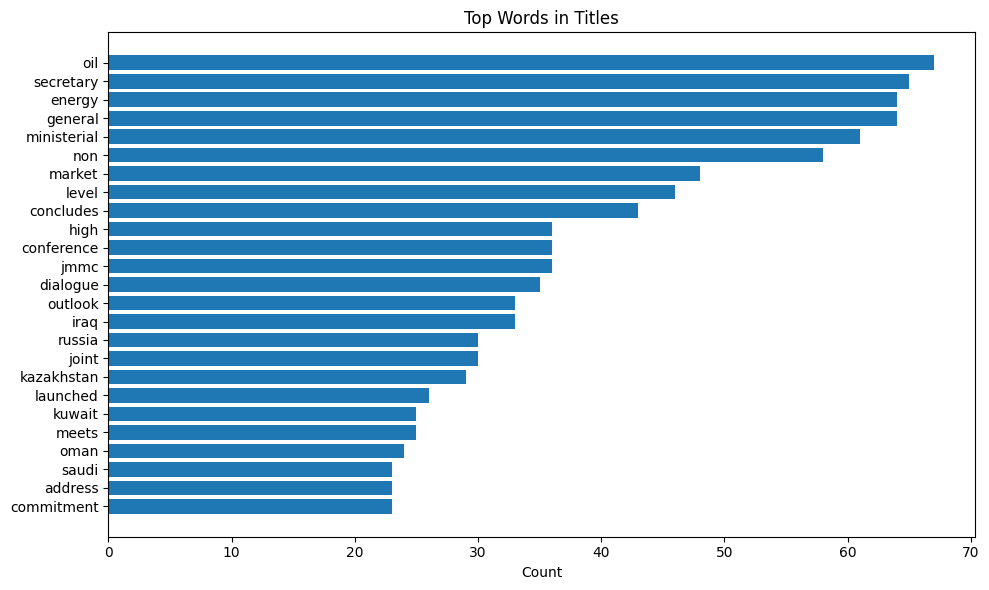

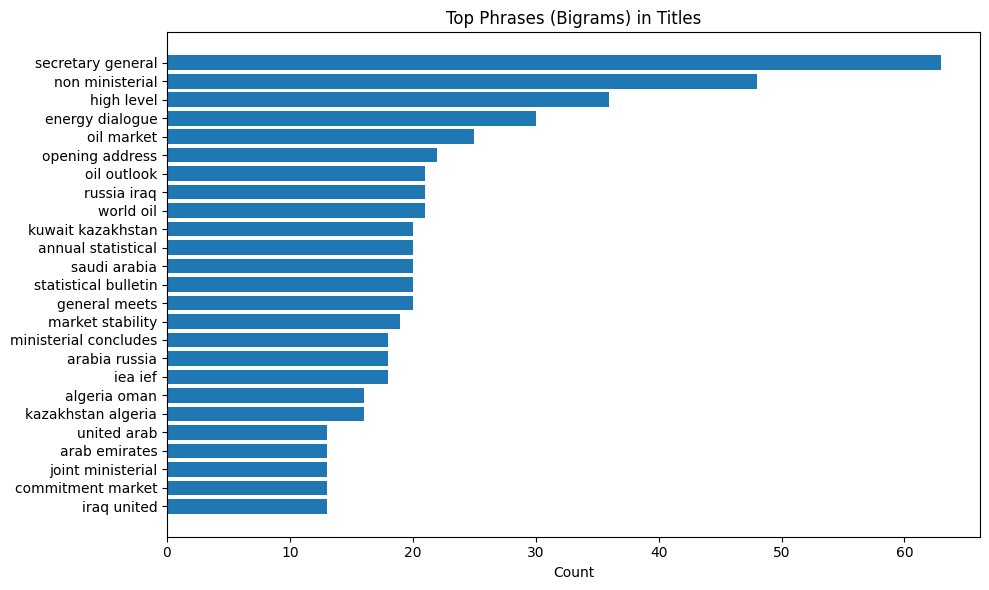

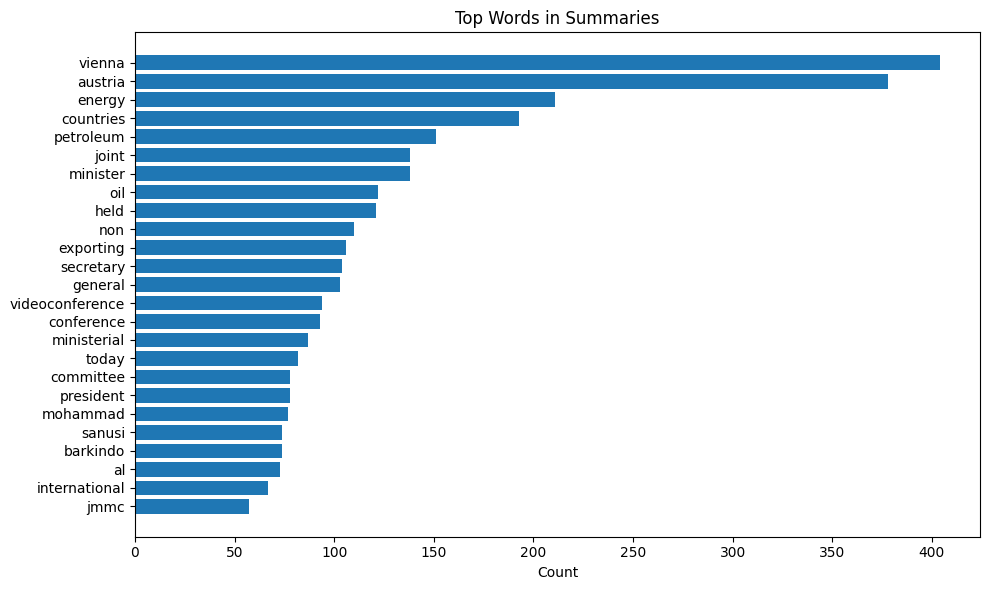

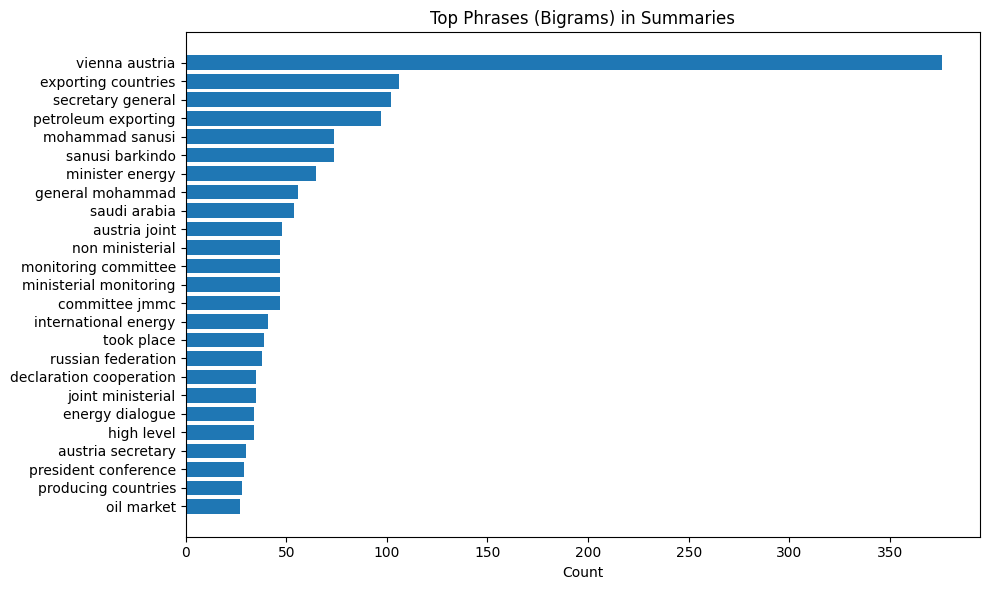

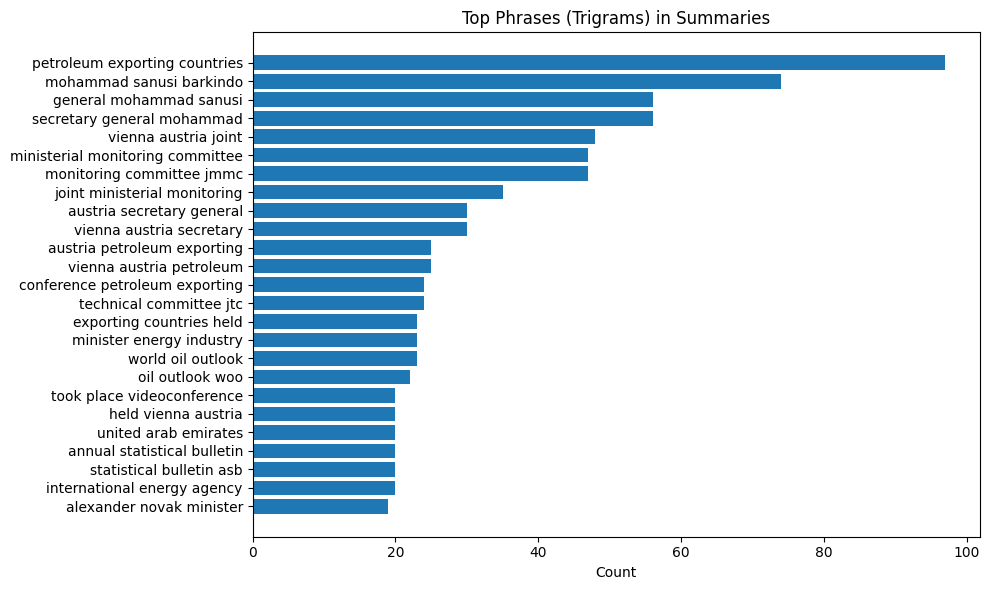

INFO:p-3178:t-125408096462656:category.py:update:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:p-3178:t-125408096462656:category.py:update:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


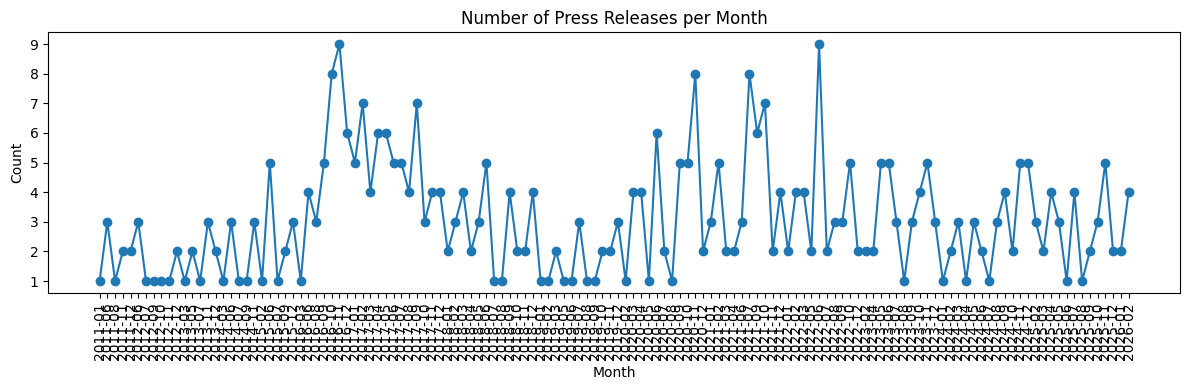

INFO:p-3178:t-125408096462656:category.py:update:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:p-3178:t-125408096462656:category.py:update:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


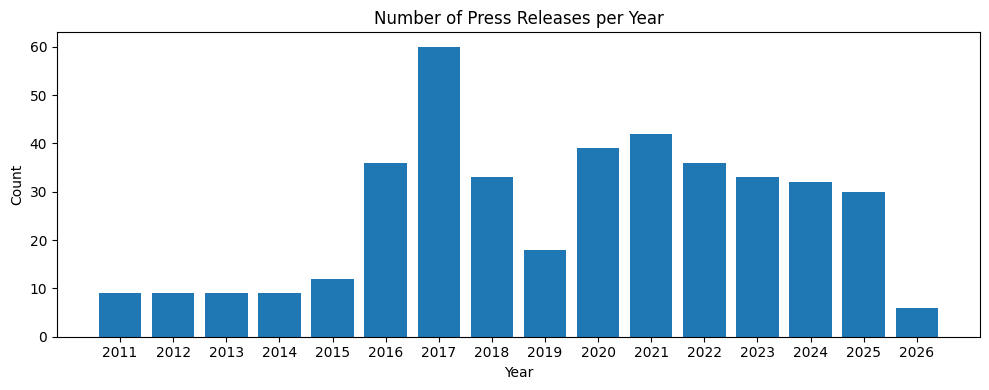

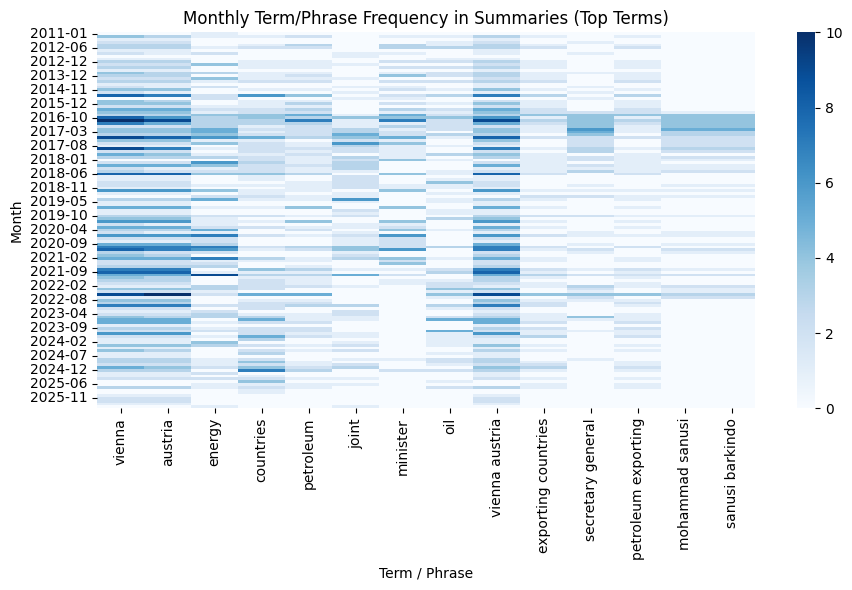

In [16]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

try:
    import seaborn as sns
    _HAS_SEABORN = True
except ImportError:
    _HAS_SEABORN = False


def run_text_eda(df_from_excel: pd.DataFrame):
    # -----------------------------
    # Text normalization
    # -----------------------------
    def normalize_text(s: str) -> str:
        if s is None:
            return ""
        s = str(s).lower()
        s = re.sub(r"https?://\S+|www\.\S+", " ", s)
        s = re.sub(r"[\r\n\t]+", " ", s)
        s = re.sub(r"[^a-z0-9'\- ]+", " ", s)
        s = re.sub(r"\s{2,}", " ", s).strip()
        return s

    BASIC_STOPWORDS = {
        "a","an","the","and","or","but","if","then","else","when","while","for","to","of","in","on","at","by","with",
        "as","is","are","was","were","be","been","being","it","its","this","that","these","those","from","into","over",
        "under","between","about","around","among","after","before","during","than","so","such","not","no","nor",
        "we","our","you","your","they","their","he","his","she","her","i","me","my","us","them",
        "will","would","can","could","may","might","should","must","also","more","most","some","any","all","each",
        "within","without","via","per"
    }

    # Optional: remove boilerplate OPEC words so the “content” stands out
    OPEC_STOPWORDS = {"opec", "press", "release", "secretariat", "organization", "meeting"}
    EXTRA_STOP = OPEC_STOPWORDS  # set to None if you want to KEEP these words

    # -----------------------------
    # Prep dataframe
    # -----------------------------
    df_eda = df_from_excel.copy()
    df_eda["Date"] = pd.to_datetime(df_eda.get("Date"), errors="coerce")
    df_eda["Title"] = df_eda.get("Title", "").fillna("").astype(str)
    df_eda["Summary"] = df_eda.get("Summary", "").fillna("").astype(str)

    df_eda["Title_clean"] = df_eda["Title"].map(normalize_text)
    df_eda["Summary_clean"] = df_eda["Summary"].map(normalize_text)
    df_eda["Month"] = df_eda["Date"].dt.to_period("M").astype(str)
    df_eda["Year"] = df_eda["Date"].dt.year

    # -----------------------------
    # Helper: top n-grams
    # (IMPORTANT FIX: stop_words must be list/None/'english' — not a set)
    # -----------------------------
    def top_ngrams(text_series: pd.Series, ngram_range=(1, 1), top_n=25, min_df=2):
        stopwords = set(BASIC_STOPWORDS)
        if EXTRA_STOP:
            stopwords |= set(EXTRA_STOP)

        vectorizer = CountVectorizer(
            stop_words=sorted(stopwords),   # ✅ list, not set
            ngram_range=ngram_range,
            min_df=min_df
        )
        X = vectorizer.fit_transform(text_series.values)
        counts = np.asarray(X.sum(axis=0)).ravel()
        vocab = np.array(vectorizer.get_feature_names_out())

        if len(counts) == 0:
            return pd.DataFrame(columns=["ngram", "count"])

        idx = counts.argsort()[::-1][:top_n]
        return pd.DataFrame({"ngram": vocab[idx], "count": counts[idx]})

    def plot_top_terms(df_terms: pd.DataFrame, title: str):
        if df_terms.empty:
            print(f"⚠️ No terms found for: {title}")
            return
        plt.figure(figsize=(10, 6))
        plt.barh(df_terms["ngram"][::-1], df_terms["count"][::-1])
        plt.title(title)
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()

    # -----------------------------
    # Top words/phrases
    # -----------------------------
    top_title_uni = top_ngrams(df_eda["Title_clean"], (1, 1), top_n=25, min_df=2)
    top_title_bi = top_ngrams(df_eda["Title_clean"], (2, 2), top_n=25, min_df=2)

    top_sum_uni = top_ngrams(df_eda["Summary_clean"], (1, 1), top_n=25, min_df=2)
    top_sum_bi = top_ngrams(df_eda["Summary_clean"], (2, 2), top_n=25, min_df=2)
    top_sum_tri = top_ngrams(df_eda["Summary_clean"], (3, 3), top_n=25, min_df=2)

    print("\n=== TOP UNIGRAMS (TITLE) ===\n", top_title_uni)
    print("\n=== TOP BIGRAMS (TITLE) ===\n", top_title_bi)
    print("\n=== TOP UNIGRAMS (SUMMARY) ===\n", top_sum_uni)
    print("\n=== TOP BIGRAMS (SUMMARY) ===\n", top_sum_bi)
    print("\n=== TOP TRIGRAMS (SUMMARY) ===\n", top_sum_tri)

    plot_top_terms(top_title_uni, "Top Words in Titles")
    plot_top_terms(top_title_bi, "Top Phrases (Bigrams) in Titles")
    plot_top_terms(top_sum_uni, "Top Words in Summaries")
    plot_top_terms(top_sum_bi, "Top Phrases (Bigrams) in Summaries")
    plot_top_terms(top_sum_tri, "Top Phrases (Trigrams) in Summaries")

    # -----------------------------
    # Compare vs Date: volume over time
    # -----------------------------
    monthly_counts = df_eda.dropna(subset=["Date"]).groupby("Month").size().rename("n_releases").reset_index()
    plt.figure(figsize=(12, 4))
    plt.plot(monthly_counts["Month"], monthly_counts["n_releases"], marker="o")
    plt.xticks(rotation=90)
    plt.title("Number of Press Releases per Month")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    yearly_counts = df_eda.dropna(subset=["Date"]).groupby("Year").size().rename("n_releases").reset_index()
    plt.figure(figsize=(10, 4))
    plt.bar(yearly_counts["Year"].astype(str), yearly_counts["n_releases"])
    plt.title("Number of Press Releases per Year")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Compare vs Date: heatmap for top terms over time
    # -----------------------------
    def term_time_heatmap(text_series: pd.Series, month_series: pd.Series, terms: list, title: str):
        stopwords = set(BASIC_STOPWORDS)
        if EXTRA_STOP:
            stopwords |= set(EXTRA_STOP)

        vectorizer = CountVectorizer(
            stop_words=sorted(stopwords),   # ✅ list, not set
            ngram_range=(1, 2),
            min_df=1
        )
        X = vectorizer.fit_transform(text_series.values)
        vocab = vectorizer.get_feature_names_out()
        vocab_index = {t: i for i, t in enumerate(vocab)}

        terms_present = [t for t in terms if t in vocab_index]
        if not terms_present:
            print(f"⚠️ None of the requested terms exist for heatmap: {title}")
            return None

        months = pd.Series(month_series).fillna("Unknown")
        month_order = sorted([m for m in months.unique() if m != "Unknown"])
        if "Unknown" in months.unique():
            month_order.append("Unknown")

        data = []
        for m in month_order:
            mask = (months == m).values
            Xm = X[mask]
            row = [int(Xm[:, vocab_index[t]].sum()) for t in terms_present]
            data.append(row)

        heat_df = pd.DataFrame(data, index=month_order, columns=terms_present)

        plt.figure(figsize=(min(14, 1 + 0.6 * len(terms_present)), 6))
        if _HAS_SEABORN:
            sns.heatmap(heat_df, cmap="Blues")
        else:
            plt.imshow(heat_df.values, aspect="auto")
            plt.colorbar(label="Count")
            plt.xticks(range(len(terms_present)), terms_present, rotation=45, ha="right")
            plt.yticks(range(len(month_order)), month_order)

        plt.title(title)
        plt.xlabel("Term / Phrase")
        plt.ylabel("Month")
        plt.tight_layout()
        plt.show()
        return heat_df

    # Pick terms to trend (mix of top unigrams + bigrams)
    trend_terms = []
    if not top_sum_uni.empty:
        trend_terms += top_sum_uni["ngram"].head(8).tolist()
    if not top_sum_bi.empty:
        trend_terms += top_sum_bi["ngram"].head(6).tolist()

    # dedupe while preserving order
    seen = set()
    trend_terms = [t for t in trend_terms if not (t in seen or seen.add(t))]

    heat_sum = term_time_heatmap(df_eda["Summary_clean"], df_eda["Month"], trend_terms,
                                 "Monthly Term/Phrase Frequency in Summaries (Top Terms)")

    return {
        "df_eda": df_eda,
        "top_title_uni": top_title_uni,
        "top_title_bi": top_title_bi,
        "top_sum_uni": top_sum_uni,
        "top_sum_bi": top_sum_bi,
        "top_sum_tri": top_sum_tri,
        "monthly_counts": monthly_counts,
        "yearly_counts": yearly_counts,
        "heat_sum": heat_sum
    }


# If you're in a notebook, run this after df_from_excel exists:
eda_outputs = run_text_eda(df_from_excel)

### Merge News OPEC release featrues with Dataset

In [17]:
# ================================================================
# ML Base Dataset Assembler (Target: Predict VLO day-ahead direction)
# + Adds Press Release text features merged by closest date (no new dates)
# ================================================================
import pandas as pd
import numpy as np
import re
from typing import Dict, Optional, Literal


# -----------------------------
# Column helpers
# -----------------------------
def _candidate_names(base: str, ticker: str):
    """Generate possible column name patterns."""
    yield f"{base}|{ticker}"
    yield base


def _find_col(df: pd.DataFrame, base: str, ticker: str) -> Optional[str]:
    """Return column name matching 'base|ticker' or 'base'."""
    cols = [str(c) for c in df.columns]
    lower_map = {c.lower(): c for c in cols}

    for cand in _candidate_names(base, ticker):
        hit = lower_map.get(cand.lower())
        if hit:
            return hit
    return None


def _ensure_dt_index(df: pd.DataFrame) -> pd.DataFrame:
    """Guarantee DateTimeIndex sorted ascending."""
    out = df.copy()
    if not isinstance(out.index, pd.DatetimeIndex):
        out.index = pd.to_datetime(out.index, errors="coerce")
        out = out[~out.index.isna()]
    out.index.name = "Date"
    return out.sort_index()


# -----------------------------
# Price, Volume, OHLC Extraction
# -----------------------------
def _extract_core_series(df: pd.DataFrame, ticker: str):
    """
    Extract:
        - Adj Close or Close (price)
        - Volume
        - High, Low, Open, Close (OHLC)
    """
    df = _ensure_dt_index(df)

    # Price
    adj_col = _find_col(df, "Adj Close", ticker)
    close_col = _find_col(df, "Close", ticker)
    price_col = adj_col if adj_col else close_col
    if price_col is None:
        raise ValueError(f"{ticker}: No price column found.")

    price = pd.to_numeric(df[price_col], errors="coerce")
    price.name = f"PX_{ticker}"

    # Volume
    vol_col = _find_col(df, "Volume", ticker)
    volume = None
    if vol_col:
        volume = pd.to_numeric(df[vol_col], errors="coerce")
        volume.name = f"VOL_{ticker}"

    # OHLC
    open_col  = _find_col(df, "Open", ticker)
    high_col  = _find_col(df, "High", ticker)
    low_col   = _find_col(df, "Low", ticker)
    close_col = _find_col(df, "Close", ticker)

    open_s  = pd.to_numeric(df[open_col], errors="coerce") if open_col else None
    high_s  = pd.to_numeric(df[high_col], errors="coerce") if high_col else None
    low_s   = pd.to_numeric(df[low_col], errors="coerce") if low_col else None
    close_s = pd.to_numeric(df[close_col], errors="coerce") if close_col else None

    return price, volume, open_s, high_s, low_s, close_s


def _log_ret(series: pd.Series) -> pd.Series:
    """1-day log return."""
    return np.log(series / series.shift(1))


def _log_ret_lag2(series: pd.Series) -> pd.Series:
    """Return r_(t-1) = log(P_(t-1)/P_(t-2))."""
    r1 = np.log(series / series.shift(1))
    return r1.shift(1)


# -----------------------------
# UPDATED: Press release feature builder (merge on closest ML dates)
# -----------------------------
def build_press_release_features(
    press_df: pd.DataFrame,
    ml_index: pd.DatetimeIndex,
    date_col: str = "Date",
    title_col: str = "Title",
    summary_col: str = "Summary",
) -> pd.DataFrame:
    """
    Build press-release features indexed by ml_index WITHOUT creating new dates.
    Each press release is assigned to the closest date in ml_index.

    UPDATED (per request):
      - No longer creates a unique PRDATE_YYYYMMDD feature for every release date.
      - Instead creates ONE feature: PR_has_release indicating a release occurred on that (mapped) date.

    Other features unchanged:
      - PR_has_oil (word boundary) in title or summary
      - PR_has_petroleum in title or summary
      - PR_has_market_stability phrase in title or summary
    """

    if press_df is None or press_df.empty:
        # Return empty feature frame aligned to ml_index
        return pd.DataFrame(index=ml_index)

    # Ensure ml_index is datetime & normalized (date-only) for consistent matching
    ml_idx = pd.DatetimeIndex(pd.to_datetime(ml_index, errors="coerce")).dropna()
    ml_idx = ml_idx.normalize()

    # Copy & prep press df
    p = press_df.copy()

    if date_col not in p.columns:
        raise ValueError(f"press_df missing required column: {date_col}")

    p[date_col] = pd.to_datetime(p[date_col], errors="coerce")
    p = p.dropna(subset=[date_col]).copy()
    p[date_col] = p[date_col].dt.normalize()

    # Text fields
    p[title_col] = p[title_col].fillna("").astype(str) if title_col in p.columns else ""
    p[summary_col] = p[summary_col].fillna("").astype(str) if summary_col in p.columns else ""

    text = (p[title_col] + " " + p[summary_col]).str.lower()

    # Keyword matches
    # - oil: word boundary to avoid matching "boil", "spoiled", etc.
    p["has_oil"] = text.str.contains(r"\boil\b", regex=True)
    p["has_petroleum"] = text.str.contains(r"\bpetroleum\b", regex=True)
    p["has_market_stability"] = text.str.contains(r"\bmarket stability\b", regex=True)

    # Map each press date to closest ML date (no new dates)
    if len(ml_idx) == 0:
        return pd.DataFrame(index=ml_index)

    # get_indexer returns positions; method='nearest' ensures closest
    positions = ml_idx.get_indexer(p[date_col], method="nearest")
    # If any are -1 (shouldn't happen unless ml_idx empty), drop them
    valid_mask = positions >= 0
    p = p.loc[valid_mask].copy()
    positions = positions[valid_mask]

    p["ml_date"] = ml_idx[positions]

    # Initialize feature frame
    feat = pd.DataFrame(index=ml_idx)
    feat["PR_has_release"] = 0
    feat["PR_has_oil"] = 0
    feat["PR_has_petroleum"] = 0
    feat["PR_has_market_stability"] = 0

    # Aggregate onto ml_date (if multiple press items map to same ml_date)
    # - presence dummy: any() => 1
    # - keyword dummies: any() => 1
    for _, row in p.iterrows():
        mld = row["ml_date"]

        # Any press release mapped to this ML date
        feat.at[mld, "PR_has_release"] = 1

        if row["has_oil"]:
            feat.at[mld, "PR_has_oil"] = 1
        if row["has_petroleum"]:
            feat.at[mld, "PR_has_petroleum"] = 1
        if row["has_market_stability"]:
            feat.at[mld, "PR_has_market_stability"] = 1

    # Return aligned to original (non-normalized) ml_index if it included times
    # We'll reindex to the dataset's final index later.
    return feat


# -----------------------------
# Main ML dataset builder
# -----------------------------
def build_vlo_ml_base_dataset(
    frames: Dict[str, pd.DataFrame],
    join_policy: Literal["inner", "left_ffill"] = "inner",
    include_levels: bool = True,
    include_px_lags: bool = True,
    include_volume: bool = True,
    include_spreads: bool = True,
    press_releases_df: Optional[pd.DataFrame] = None,   # <-- NEW
) -> pd.DataFrame:
    """
    Builds a unified ML dataset for:
        - Prices, Returns, Volume, OHLC spreads
        - Across: VLO, PSX, MPC, ^GSPC, CL=F, GC=F, ^VIX
        - Target: y = next-day VLO up/down

    Press releases:
        - Adds press release features merged on closest available dates
          (no new dates created).

    UPDATED (per request):
        - Uses ONE press-release presence feature (PR_has_release)
          instead of creating PRDATE_YYYYMMDD for each release date.
    """

    tickers = ["VLO", "PSX", "MPC", "^GSPC", "CL=F", "GC=F", "^VIX"]
    missing = [t for t in tickers if t not in frames or frames[t] is None or frames[t].empty]
    if missing:
        raise ValueError(f"Missing required dataframes: {missing}")

    # Storage
    px = {}
    px_lag1 = {}
    px_lag2 = {}
    vol = {}
    ohlc_spreads = {}
    ret1 = {}
    ret2 = {}

    # ---- 1) Extract all core series ----
    for tkr in tickers:
        price, volume, open_s, high_s, low_s, close_s = _extract_core_series(frames[tkr], tkr)

        px[tkr] = price
        if include_px_lags:
            px_lag1[tkr] = price.shift(1).rename(f"PXlag1_{tkr}")
            px_lag2[tkr] = price.shift(2).rename(f"PXlag2_{tkr}")

        # Volume
        if include_volume and volume is not None:
            vol[tkr] = volume

        # OHLC spreads
        if include_spreads and high_s is not None and low_s is not None and open_s is not None and close_s is not None:
            hl = (high_s - low_s).rename(f"HL_{tkr}")
            oc = (close_s - open_s).rename(f"OC_{tkr}")
            ohlc_spreads.setdefault(tkr, {})
            ohlc_spreads[tkr]["HL"] = hl
            ohlc_spreads[tkr]["OC"] = oc

        # Returns
        r1 = _log_ret(price).rename(f"ret_{tkr}")
        r2 = _log_ret_lag2(price).rename(f"ret2_{tkr}")
        ret1[tkr] = r1
        ret2[tkr] = r2

    # ---- 2) Join all series ----
    series_list = []

    # Returns
    series_list += list(ret1.values()) + list(ret2.values())

    # Price levels
    if include_levels:
        series_list += list(px.values())

    # Price lags
    if include_px_lags:
        series_list += list(px_lag1.values()) + list(px_lag2.values())

    # Volume
    if include_volume:
        series_list += list(vol.values())

    # OHLC spreads
    if include_spreads:
        for tkr in ohlc_spreads:
            series_list.append(ohlc_spreads[tkr]["HL"])
            series_list.append(ohlc_spreads[tkr]["OC"])

    # --- Merge ---
    if join_policy == "inner":
        df = pd.concat(series_list, axis=1, join="inner")
    elif join_policy == "left_ffill":
        # VLO calendar is the base
        df = pd.concat([s for s in series_list if s.name.endswith("VLO")], axis=1)
        for s in series_list:
            if s.name not in df.columns:
                df = df.join(s, how="left")
        df = df.ffill()
    else:
        raise ValueError("join_policy must be 'inner' or 'left_ffill'")

    # Ensure datetime index / sorted
    df = _ensure_dt_index(df)

    # ---- 2.5) Add press release features (closest-date merge; no new dates) ----
    if press_releases_df is not None and not press_releases_df.empty:
        pr_feat = build_press_release_features(
            press_df=press_releases_df,
            ml_index=df.index
        )

        # pr_feat index is normalized; align back to df.index normalized
        df_idx_norm = df.index.normalize()
        pr_feat = pr_feat.reindex(df_idx_norm).fillna(0).astype(int)

        # Join features to df; keep df index unchanged
        df = df.join(pr_feat, how="left")
        # Any remaining NaN in PR features => 0
        pr_cols = [c for c in df.columns if c.startswith("PR_has_")]
        df[pr_cols] = df[pr_cols].fillna(0).astype(int)

    # ---- 3) Create next-day target + next-day return/direction for VLO ----
    df["y"] = (df["ret_VLO"].shift(-1) > 0).astype(int)

    # next-day VLO return (log return) and labeled direction
    df["vlo_next_ret"] = df["ret_VLO"].shift(-1)
    df["vlo_next_dir"] = np.where(df["vlo_next_ret"] > 0, "positive", "negative")

    # ---- 4) Final cleaning ----
    df = df.dropna().sort_index()
    cols = [c for c in df.columns if c != "y"] + ["y"]
    df = df[cols]

    return df


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # frames = read_refining_prices_xlsx(...)

    # press_releases_df should be your text dataframe from Excel:
    # e.g., press_releases_df = df_from_excel  (columns: Date, Title, Summary)
    dataset = build_vlo_ml_base_dataset(
        frames=frames,
        join_policy="inner",
        include_levels=True,
        include_px_lags=True,
        include_volume=True,
        include_spreads=True,
        press_releases_df=df_from_excel,   # <-- NEW
    )

In [20]:
cols = ["PR_has_release", "PR_has_oil", "PR_has_petroleum", "PR_has_market_stability"]

# If values are already 0/1 integers:
counts_01 = dataset[cols].apply(lambda s: s.value_counts(dropna=False)).fillna(0).astype(int)

# Show only rows for 0 and 1 (keeps output focused)
counts_01 = counts_01.reindex([0, 1])

counts_01

,PR_has_release,PR_has_oil,PR_has_petroleum,PR_has_market_stability
0,3153,3371,3350,3457
1,325,107,128,21


#### Add Engineered Featues

In [21]:
# ================================================================
# ENGINEERED FEATURES MODULE
# ================================================================
import pandas as pd
import numpy as np


def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds engineered, domain-specific features to the ML base dataset.
    Assumes df already contains:
        ret_<ticker>, ret2_<ticker>,
        PX_<ticker>, PXlag1_<ticker>, PXlag2_<ticker>,
        VOL_<ticker>, HL_<ticker>, OC_<ticker>

    Returns an enriched DataFrame with engineered signals.
    """

    df = df.copy()
    tickers = ["VLO", "PSX", "MPC", "^GSPC", "CL=F", "GC=F", "^VIX"]

    # ----------------------------------------------------------------
    # 1. CROSS-MARKET INTERACTION FLAGS
    # ----------------------------------------------------------------
    df["EquityDown_OilDown"] = (
        (df["ret_^GSPC"] < 0) &
        (df["ret_CL=F"] < 0)
    ).astype(int)

    df["RiskOff"] = (
        (df["ret_GC=F"] > 0) &      # Gold Up
        (df["ret_^GSPC"] < 0) &     # Equity Down
        (df["ret_^VIX"] > 0)        # Vol Up
    ).astype(int)

    # ----------------------------------------------------------------
    # 2. VOLATILITY REGIME AND ROLLING VOLATILITY
    # ----------------------------------------------------------------
    # High VIX regime
    df["HighVIX"] = (df["PX_^VIX"] > df["PX_^VIX"].rolling(252).mean()).astype(int)

    # Realized volatility (abs returns rolling std)
    df["VLO_vol5"] = df["ret_VLO"].rolling(5).std()
    df["VLO_vol10"] = df["ret_VLO"].rolling(10).std()
    df["VLO_vol20"] = df["ret_VLO"].rolling(20).std()

    # Volatility ratios
    df["VLO_vol_ratio_5_20"] = df["VLO_vol5"] / df["VLO_vol20"]

    # ----------------------------------------------------------------
    # 3. COMMODITY SHOCKS (Oil, Gold)
    # ----------------------------------------------------------------
    # Oil 2-sigma shock
    oil_std = df["ret_CL=F"].rolling(60).std()
    df["OilShock"] = (df["ret_CL=F"].abs() > 2 * oil_std).astype(int)

    # Gold shock (optional symmetrical)
    gold_std = df["ret_GC=F"].rolling(60).std()
    df["GoldShock"] = (df["ret_GC=F"].abs() > 2 * gold_std).astype(int)

    # ----------------------------------------------------------------
    # 4. EXCESS RETURNS
    # ----------------------------------------------------------------
    df["VLO_minus_SPX"] = df["ret_VLO"] - df["ret_^GSPC"]

    # VLO vs refining peers
    df["RefinerPeerAvg"] = (df["ret_PSX"] + df["ret_MPC"]) / 2
    df["VLO_minus_Peers"] = df["ret_VLO"] - df["RefinerPeerAvg"]

    # ----------------------------------------------------------------
    # 5. CRACK-SPREAD PROXY (Oil - Equity style)
    # ----------------------------------------------------------------
    df["Oil_minus_SPX"] = df["ret_CL=F"] - df["ret_^GSPC"]
    df["Oil_minus_Refiners"] = df["ret_CL=F"] - df["RefinerPeerAvg"]

    # ----------------------------------------------------------------
    # 6. ROLLING MOMENTUM AND MEAN-REVERSION
    # ----------------------------------------------------------------
    df["VLO_mom3"] = df["ret_VLO"].rolling(3).sum()
    df["VLO_mom5"] = df["ret_VLO"].rolling(5).sum()

    # Mean reversion indicator (prior 5-day average return)
    df["VLO_ret5_avg"] = df["ret_VLO"].rolling(5).mean()
    df["VLO_reversal_signal"] = -df["VLO_ret5_avg"]  # negative of average return

    # ----------------------------------------------------------------
    # 7. ROLLING Z-SCORES (standardized recent returns)
    # ----------------------------------------------------------------
    df["VLO_zscore20"] = (
        (df["ret_VLO"] - df["ret_VLO"].rolling(20).mean()) /
        df["ret_VLO"].rolling(20).std()
    )

    df["SPX_zscore20"] = (
        (df["ret_^GSPC"] - df["ret_^GSPC"].rolling(20).mean()) /
        df["ret_^GSPC"].rolling(20).std()
    )

    df["Oil_zscore20"] = (
        (df["ret_CL=F"] - df["ret_CL=F"].rolling(20).mean()) /
        df["ret_CL=F"].rolling(20).std()
    )

    # ----------------------------------------------------------------
    # 8. CLEANUP (drop rows with NaN from rolling windows)
    # ----------------------------------------------------------------
    df = df.dropna()

    return df


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # Base dataset created earlier from your ML setup:
    # base_df = build_vlo_ml_base_dataset(...)

    engineered_df = add_engineered_features(dataset)

#### EDA on OPEC News Included Dataset

In [23]:
# ================================================================
# VLO EDA → ONE-PDF REPORT (Matplotlib PdfPages) — EXTENDED
#   Adds: dtypes & non-null counts, missing-values audit,
#         numeric describe(), and histograms for top-variance features
#
# UPDATES (per request):
#   - Tables now paginate to show ALL variables (no truncation)
#   - Class counts chart for y now also shows avg next-day returns (vlo_next_ret)
#   - Added similar charts for:
#         * vlo_next_dir (counts + avg vlo_next_ret)
#         * vlo_next_ret (distribution + comparison vs y and vs vlo_next_dir)
#   - Enables direct comparison of new targets vs y
#
# NEW UPDATE (stat analysis request):
#   - Adds numeric statistical analysis for positive/negative groups
#     for next-day returns (vlo_next_ret) using vlo_next_dir.
#
# NEW UPDATE (vertical tables request):
#   - The new stats tables are rotated vertically for PDF readability.
#     * Group stats: metrics as rows, groups as columns
#     * Between-group tests: metrics as rows, single value column
#
# NEW UPDATE (this request):
#   - Numeric summary tables were too wide. Split into:
#       1) Core numeric summary (count/mean/std/min/max)
#       2) Percentile distribution table (1/5/25/50/75/95/99)
#   - Do not change anything else.
# ================================================================
import warnings
warnings.filterwarnings("ignore")

import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Optional sklearn/scipy
try:
    from sklearn.metrics import roc_auc_score, roc_curve
    from sklearn.feature_selection import mutual_info_classif
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

try:
    from scipy import stats
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False


# -----------------------------
# Utilities
# -----------------------------
def _validate_engineered_df(df: pd.DataFrame) -> None:
    req = ["y", "ret_VLO", "vlo_next_ret", "vlo_next_dir"]
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"engineered_df missing required columns: {missing}")
    if df["y"].dropna().nunique() != 2:
        raise ValueError("Column 'y' must be binary in {0,1}.")
    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.index = pd.to_datetime(df.index, errors="coerce")
        except Exception:
            pass


def _numeric_columns(df: pd.DataFrame, exclude=None):
    exclude = exclude or []
    return [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]


def _point_biserial_corr(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    return df[features].corrwith(df[y_col])


def _welch_t_stat(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SCIPY_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    pos = df[df[y_col] == 1]
    neg = df[df[y_col] == 0]
    out = {}
    for f in features:
        a, b = pos[f].dropna(), neg[f].dropna()
        out[f] = stats.ttest_ind(a, b, equal_var=False)[0] if len(a) > 3 and len(b) > 3 else np.nan
    return pd.Series(out)


def _ks_stat(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SCIPY_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    pos = df[df[y_col] == 1]
    neg = df[df[y_col] == 0]
    out = {}
    for f in features:
        a, b = pos[f].dropna(), neg[f].dropna()
        if len(a) > 3 and len(b) > 3:
            try:
                out[f] = stats.ks_2samp(a, b)[0]
            except Exception:
                out[f] = np.nan
        else:
            out[f] = np.nan
    return pd.Series(out)


def _univariate_auc(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SKLEARN_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    y = df[y_col].values
    aucs = {}
    for f in features:
        x = df[f].copy()
        if np.nanstd(x) == 0 or x.isna().all():
            aucs[f] = np.nan
            continue
        x = x.fillna(x.median()).values
        try:
            aucs[f] = roc_auc_score(y, x)
        except Exception:
            aucs[f] = np.nan
    return pd.Series(aucs)


def _mutual_info(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SKLEARN_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    X = df[features].copy()
    for c in X.columns:
        X[c] = X[c].fillna(X[c].median())
    y = df[y_col].values
    try:
        mi = mutual_info_classif(X.values, y, random_state=42)
        return pd.Series(mi, index=features)
    except Exception:
        return pd.Series(index=features, dtype=float)


# -----------------------------
# Next-day return stats for positive/negative groups
# -----------------------------
def _safe_quantile(s: pd.Series, q: float):
    try:
        return float(s.quantile(q))
    except Exception:
        return np.nan


def _annualized_sharpe(mean: float, std: float, periods: int = 252):
    if std is None or std == 0 or np.isnan(std):
        return np.nan
    return (mean / std) * np.sqrt(periods)


def _group_next_ret_stats(
    df: pd.DataFrame,
    group_col: str = "vlo_next_dir",
    ret_col: str = "vlo_next_ret",
    group_order=None,
    periods: int = 252
) -> pd.DataFrame:
    d = df[[group_col, ret_col]].dropna().copy()
    if d.empty:
        return pd.DataFrame({"message": ["No data available for group stats."]})

    if group_order is None:
        groups = list(pd.Series(d[group_col].unique()).sort_values())
    else:
        groups = [g for g in group_order if g in set(d[group_col].unique())]
        for g in d[group_col].unique():
            if g not in groups:
                groups.append(g)

    rows = []
    for g in groups:
        s = d.loc[d[group_col] == g, ret_col].astype(float).dropna()
        n = int(s.shape[0])
        if n == 0:
            continue

        mean = float(s.mean())
        med = float(s.median())
        std = float(s.std(ddof=1)) if n > 1 else np.nan
        sem = float(std / np.sqrt(n)) if (n > 1 and std == std) else np.nan

        p01 = _safe_quantile(s, 0.01)
        p05 = _safe_quantile(s, 0.05)
        p25 = _safe_quantile(s, 0.25)
        p75 = _safe_quantile(s, 0.75)
        p95 = _safe_quantile(s, 0.95)
        p99 = _safe_quantile(s, 0.99)

        skew = float(s.skew()) if n >= 3 else np.nan
        kurt = float(s.kurtosis()) if n >= 4 else np.nan

        win_rate = float((s > 0).mean()) if n > 0 else np.nan
        mean_up = float(s[s > 0].mean()) if (s > 0).any() else np.nan
        mean_dn = float(s[s < 0].mean()) if (s < 0).any() else np.nan

        sharpe = _annualized_sharpe(mean, std, periods=periods)

        t0, p0 = np.nan, np.nan
        if SCIPY_AVAILABLE and n >= 5:
            try:
                t0, p0 = stats.ttest_1samp(s.values, popmean=0.0, nan_policy="omit")
                t0, p0 = float(t0), float(p0)
            except Exception:
                t0, p0 = np.nan, np.nan

        rows.append({
            "group": g,
            "n": n,
            "mean": mean,
            "median": med,
            "std": std,
            "sem": sem,
            "min": float(s.min()),
            "p01": p01,
            "p05": p05,
            "p25": p25,
            "p75": p75,
            "p95": p95,
            "p99": p99,
            "max": float(s.max()),
            "skew": skew,
            "kurtosis_excess": kurt,
            "win_rate": win_rate,
            "mean_if_up": mean_up,
            "mean_if_down": mean_dn,
            "sharpe_ann": sharpe,
            "t_mean_vs_0": t0,
            "p_mean_vs_0": p0,
        })

    out = pd.DataFrame(rows)
    if out.empty:
        return pd.DataFrame({"message": ["No groups produced stats (empty after filtering)."]})

    num_cols = [c for c in out.columns if c != "group"]
    out[num_cols] = out[num_cols].astype(float).round(8)
    return out


def _cliffs_delta(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a)
    b = np.asarray(b)
    if a.size == 0 or b.size == 0:
        return np.nan
    gt = 0
    lt = 0
    for x in a:
        gt += np.sum(x > b)
        lt += np.sum(x < b)
    return float((gt - lt) / (a.size * b.size))


def _between_group_next_ret_tests(
    df: pd.DataFrame,
    group_col: str = "vlo_next_dir",
    ret_col: str = "vlo_next_ret",
    neg_label="negative",
    pos_label="positive"
) -> pd.DataFrame:
    d = df[[group_col, ret_col]].dropna().copy()
    if d.empty:
        return pd.DataFrame({"message": ["No data available for between-group tests."]})

    a = d.loc[d[group_col] == pos_label, ret_col].astype(float).dropna().values
    b = d.loc[d[group_col] == neg_label, ret_col].astype(float).dropna().values

    if a.size == 0 or b.size == 0:
        return pd.DataFrame({"message": [f"Missing one or both groups: {pos_label} ({a.size}), {neg_label} ({b.size})."]})

    mean_a, mean_b = float(np.mean(a)), float(np.mean(b))
    med_a, med_b = float(np.median(a)), float(np.median(b))
    std_a = float(np.std(a, ddof=1)) if a.size > 1 else np.nan
    std_b = float(np.std(b, ddof=1)) if b.size > 1 else np.nan

    t_w, p_w, ks, p_ks = np.nan, np.nan, np.nan, np.nan
    if SCIPY_AVAILABLE and a.size >= 5 and b.size >= 5:
        try:
            t_w, p_w = stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")
            t_w, p_w = float(t_w), float(p_w)
        except Exception:
            t_w, p_w = np.nan, np.nan
        try:
            ks_res = stats.ks_2samp(a, b)
            ks, p_ks = float(ks_res.statistic), float(ks_res.pvalue)
        except Exception:
            ks, p_ks = np.nan, np.nan

    pooled = np.nan
    if a.size > 1 and b.size > 1:
        pooled = np.sqrt(((a.size - 1) * np.var(a, ddof=1) + (b.size - 1) * np.var(b, ddof=1)) / (a.size + b.size - 2))
    d_cohen = float((mean_a - mean_b) / pooled) if (pooled is not None and pooled == pooled and pooled != 0) else np.nan

    cd = _cliffs_delta(a, b)

    wr_a = float(np.mean(a > 0))
    wr_b = float(np.mean(b > 0))

    out = pd.DataFrame([{
        "pos_label": pos_label,
        "neg_label": neg_label,
        "n_pos": int(a.size),
        "n_neg": int(b.size),
        "mean_pos": mean_a,
        "mean_neg": mean_b,
        "mean_diff_pos_minus_neg": mean_a - mean_b,
        "median_pos": med_a,
        "median_neg": med_b,
        "median_diff_pos_minus_neg": med_a - med_b,
        "std_pos": std_a,
        "std_neg": std_b,
        "welch_t": t_w,
        "welch_p": p_w,
        "ks_stat": ks,
        "ks_p": p_ks,
        "cohens_d": d_cohen,
        "cliffs_delta": cd,
        "win_rate_pos": wr_a,
        "win_rate_neg": wr_b,
        "win_rate_diff_pos_minus_neg": wr_a - wr_b,
    }])

    for c in out.columns:
        if c not in ["pos_label", "neg_label"]:
            out[c] = pd.to_numeric(out[c], errors="coerce").round(8)
    return out


# -----------------------------
# Vertical table transforms (for PDF readability)
# -----------------------------
def _verticalize_group_stats_table(group_stats_wide: pd.DataFrame) -> pd.DataFrame:
    if group_stats_wide is None or group_stats_wide.empty:
        return pd.DataFrame({"message": ["No group stats available."]})
    if "message" in group_stats_wide.columns:
        return group_stats_wide.copy()

    if "group" not in group_stats_wide.columns:
        return pd.DataFrame({"message": ["Expected 'group' column not found in group stats."]})

    tmp = group_stats_wide.copy().set_index("group")
    v = tmp.T.reset_index().rename(columns={"index": "metric"})
    cols = ["metric"] + [c for c in v.columns if c != "metric"]
    return v[cols]


def _verticalize_single_row_table(df_one_row: pd.DataFrame, value_col_name: str = "value") -> pd.DataFrame:
    if df_one_row is None or df_one_row.empty:
        return pd.DataFrame({"message": ["No data available."]})
    if "message" in df_one_row.columns:
        return df_one_row.copy()

    if len(df_one_row) != 1:
        tmp = df_one_row.copy()
        tmp["_row"] = np.arange(len(tmp))
        tmp = tmp.set_index("_row")
        v = tmp.T.reset_index().rename(columns={"index": "metric"})
        return v

    s = df_one_row.iloc[0]
    v = s.to_frame(value_col_name).reset_index().rename(columns={"index": "metric"})
    return v


# -----------------------------
# Figure creators
# -----------------------------
def _fig_title_page():
    fig = plt.figure(figsize=(8.5, 11))
    fig.patch.set_facecolor("white")
    text = "Exploratory Data Analysis — VLO Next‑Day Direction"
    sub  = f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    plt.axis("off")
    plt.text(0.5, 0.70, text, ha="center", va="center", fontsize=22, weight="bold")
    plt.text(0.5, 0.64, sub, ha="center", va="center", fontsize=12)
    body = (
        "Dataset: Engineered features joined across VLO, PSX, MPC, ^GSPC, CL=F, GC=F, ^VIX.\n"
        "This report includes schema, missing values, numeric summaries, and univariate feature analyses.\n"
        "Also includes target comparisons for: y, vlo_next_dir, vlo_next_ret.\n"
        "NEW: Includes numeric stats + tests for vlo_next_dir (positive vs negative) on vlo_next_ret."
    )
    plt.text(0.5, 0.55, body, ha="center", va="center", fontsize=11)
    return fig


def _fig_class_counts_with_mean_return(df: pd.DataFrame, class_col: str, ret_col: str, title: str):
    d = df[[class_col, ret_col]].dropna()
    counts = d[class_col].value_counts().sort_index()
    means = d.groupby(class_col)[ret_col].mean().reindex(counts.index)

    labels = [str(k) for k in counts.index]

    fig, ax1 = plt.subplots(figsize=(8.5, 4))
    ax1.bar(labels, counts.values, color="#4c78a8", alpha=0.85)
    ax1.set_title(title)
    ax1.set_ylabel("Observations")
    ax1.grid(axis="y", alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(labels, means.values, color="#f58518", marker="o", lw=2)
    ax2.set_ylabel(f"Mean {ret_col}")
    ax2.axhline(0, color="gray", lw=1, alpha=0.4)

    fig.tight_layout()
    return fig


def _fig_rolling_share(df, y_col, window=60):
    fig, ax = plt.subplots(figsize=(8.5, 3))
    df[y_col].rolling(window).mean().plot(ax=ax, color="#1b9e77", lw=1.5)
    ax.set_title(f"Rolling {window}-Day Share of Up Days (Next‑Day) — {y_col}")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Share Up")
    ax.grid(alpha=0.3)
    return fig


def _fig_vlo_ret_by_y(df):
    dd = df[["y", "ret_VLO"]].dropna()
    d0 = dd.loc[dd["y"] == 0, "ret_VLO"].values
    d1 = dd.loc[dd["y"] == 1, "ret_VLO"].values
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.boxplot([d0, d1], labels=["y=0 (Down next day)", "y=1 (Up next day)"])
    ax.set_title("VLO Daily Log Returns (ret_VLO) by Next‑Day Direction (y)")
    ax.set_ylabel("ret_VLO")
    ax.grid(alpha=0.3)
    return fig


def _fig_next_ret_by_y(df):
    dd = df[["y", "vlo_next_ret"]].dropna()
    d0 = dd.loc[dd["y"] == 0, "vlo_next_ret"].values
    d1 = dd.loc[dd["y"] == 1, "vlo_next_ret"].values
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.boxplot([d0, d1], labels=["y=0", "y=1"])
    ax.set_title("Next‑Day VLO Return (vlo_next_ret) by y")
    ax.set_ylabel("vlo_next_ret")
    ax.axhline(0, color="gray", lw=1, alpha=0.4)
    ax.grid(alpha=0.3)
    return fig


def _fig_next_ret_by_next_dir(df):
    dd = df[["vlo_next_dir", "vlo_next_ret"]].dropna()
    cats = [c for c in ["negative", "positive"] if c in dd["vlo_next_dir"].unique()]
    if not cats:
        cats = list(pd.Series(dd["vlo_next_dir"].unique()).sort_values())
    data = [dd.loc[dd["vlo_next_dir"] == c, "vlo_next_ret"].values for c in cats]
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.boxplot(data, labels=cats)
    ax.set_title("Next‑Day VLO Return (vlo_next_ret) by vlo_next_dir")
    ax.set_ylabel("vlo_next_ret")
    ax.axhline(0, color="gray", lw=1, alpha=0.4)
    ax.grid(alpha=0.3)
    return fig


def _fig_next_ret_hist(df):
    s = df["vlo_next_ret"].dropna()
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.hist(s.values, bins=60, color="#54a24b", alpha=0.85)
    ax.set_title("Distribution — Next‑Day VLO Return (vlo_next_ret)")
    ax.set_xlabel("vlo_next_ret")
    ax.set_ylabel("Frequency")
    ax.axvline(0, color="gray", lw=1, alpha=0.4)
    ax.grid(alpha=0.25)
    fig.tight_layout()
    return fig


def _fig_corr_heatmap(df, top_features, y_col):
    corr_mat = df[top_features + [y_col]].corr()
    n = corr_mat.shape[0]
    fig = plt.figure(figsize=(min(0.6 * n + 3, 11), min(0.6 * n + 3, 11)))
    ax = fig.add_subplot(111)
    im = ax.imshow(corr_mat, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_xticks(range(n))
    ax.set_xticklabels(corr_mat.columns, rotation=90, fontsize=8)
    ax.set_yticks(range(n))
    ax.set_yticklabels(corr_mat.index, fontsize=8)
    ax.set_title(f"Correlation Heatmap — Top Features vs {y_col}")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_top_feature_boxes(df, top_features, y_col, max_plots=6):
    feats = top_features[:max_plots]
    rows = len(feats)
    fig, axes = plt.subplots(nrows=rows, ncols=1, figsize=(8.5, 1.9 * rows))
    if rows == 1:
        axes = [axes]
    for ax, feat in zip(axes, feats):
        d0 = df.loc[df[y_col] == 0, feat].dropna().values
        d1 = df.loc[df[y_col] == 1, feat].dropna().values
        ax.boxplot([d0, d1], labels=[f"{y_col}=0", f"{y_col}=1"])
        ax.set_title(f"{feat} by {y_col}")
        ax.grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_univariate_roc(df, top_features, y_col, max_plots=6):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 7))
    axes = axes.ravel()
    plotted = 0
    if not SKLEARN_AVAILABLE:
        for ax in axes:
            ax.axis("off")
        fig.suptitle("Univariate ROC — scikit‑learn not available", fontsize=12, y=0.98)
        return fig, False

    y = df[y_col].values
    feats = top_features[:max_plots]
    for ax, feat in zip(axes, feats):
        x = df[feat].copy()
        if np.nanstd(x) == 0 or x.isna().all():
            ax.axis("off")
            continue
        x = x.fillna(x.median()).values
        try:
            fpr, tpr, _ = roc_curve(y, x)
            auc_val = roc_auc_score(y, x)
            ax.plot(fpr, tpr, color="#1b9e77", lw=1.5, label=f"AUC={auc_val:.3f}")
            ax.plot([0, 1], [0, 1], "--", color="gray", lw=1)
            ax.set_title(f"ROC — {feat}")
            ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
            ax.legend(loc="lower right", fontsize=8)
            ax.grid(alpha=0.3)
            plotted += 1
        except Exception:
            ax.text(0.5, 0.5, f"ROC failed: {feat}", ha="center"); ax.axis("off")
    if plotted == 0:
        fig.suptitle("Univariate ROC — none plotted", fontsize=12, y=0.98)
        for ax in axes:
            ax.axis("off")
        return fig, False
    fig.tight_layout()
    return fig, True


# -----------------------------
# TABLE RENDERING (PAGINATED)
# -----------------------------
def _fig_table_pages(
    df_table: pd.DataFrame,
    title: str,
    rows_per_page: int = 45,
    cell_loc: str = "right",
    col_loc: str = "right"
):
    if df_table is None:
        df_table = pd.DataFrame({"message": ["No table data provided."]})

    view = df_table.copy()
    view = view.reset_index(drop=True)

    if len(view) == 0:
        view = pd.DataFrame({"message": ["Empty table."]})

    figs = []
    n = len(view)
    pages = int(np.ceil(n / rows_per_page))

    for p in range(pages):
        start = p * rows_per_page
        end = min((p + 1) * rows_per_page, n)
        chunk = view.iloc[start:end].copy()

        fig, ax = plt.subplots(figsize=(8.5, 11))
        ax.axis("off")
        page_title = title if pages == 1 else f"{title} (page {p+1}/{pages})"
        ax.set_title(page_title, fontsize=14, pad=12)

        table = plt.table(
            cellText=chunk.values,
            colLabels=chunk.columns,
            loc="upper center",
            cellLoc=cell_loc,
            colLoc=col_loc,
        )
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.0, 1.25)

        try:
            table.auto_set_column_width(col=list(range(len(chunk.columns))))
        except Exception:
            pass

        try:
            for (r, c), cell in table.get_celld().items():
                if c == 0:
                    cell._loc = "left"
                    cell.get_text().set_ha("left")
        except Exception:
            pass

        plt.tight_layout()
        figs.append(fig)

    return figs


# -----------------------------
# Schema, Missing, Numeric EDA
# -----------------------------
def _schema_table(df: pd.DataFrame):
    schema = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "non_null": df.notna().sum(),
        "nulls": df.isna().sum(),
        "null_ratio": (df.isna().mean() * 100).round(2).astype(str) + "%"
    }).reset_index().rename(columns={"index": "column"})
    return schema


def _missing_table(df: pd.DataFrame):
    miss = pd.DataFrame({
        "nulls": df.isna().sum(),
        "null_ratio": df.isna().mean()
    })
    miss["null_ratio_%"] = (miss["null_ratio"] * 100).round(2)
    miss = miss.sort_values("null_ratio", ascending=False).reset_index().rename(columns={"index": "column"})
    return miss[["column", "nulls", "null_ratio_%"]]


# --- UPDATED: Split numeric summary into two tables (core + percentiles)
def _describe_tables(df: pd.DataFrame, exclude_cols=None):
    """
    Returns TWO tables:
      1) Core numeric summary: count, mean, std, min, max
      2) Percentile distribution: 1%, 5%, 25%, 50%, 75%, 95%, 99%
    """
    exclude_cols = exclude_cols or []
    num_cols = _numeric_columns(df, exclude=exclude_cols)
    if not num_cols:
        msg = pd.DataFrame({"message": ["No numeric columns found."]})
        return msg, msg

    desc = df[num_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

    # Core stats table
    core_cols = [c for c in ["count", "mean", "std", "min", "max"] if c in desc.columns]
    desc_core = desc[core_cols].round(6).reset_index().rename(columns={"index": "feature"})

    # Percentiles table
    pct_cols = [c for c in ["1%", "5%", "25%", "50%", "75%", "95%", "99%"] if c in desc.columns]
    desc_pct = desc[pct_cols].round(6).reset_index().rename(columns={"index": "feature"})

    return desc_core, desc_pct


def _fig_missing_timeseries(df: pd.DataFrame):
    miss_ts = df.isna().sum(axis=1)
    fig, ax = plt.subplots(figsize=(8.5, 3.0))
    ax.plot(miss_ts.index, miss_ts.values, color="#7570b3", lw=1.0)
    ax.set_title("Total Missing Values per Date")
    ax.set_ylabel("Missing count")
    ax.grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_numeric_histograms(df: pd.DataFrame, top_k_var: int = 12, exclude_cols=None):
    exclude_cols = exclude_cols or []
    num_cols = _numeric_columns(df, exclude=exclude_cols)
    if not num_cols:
        fig = plt.figure(figsize=(8.5, 3))
        plt.axis("off")
        plt.title("No numeric columns available for histograms")
        return fig

    var = df[num_cols].var().replace([np.inf, -np.inf], np.nan).dropna()
    var = var[var > 0].sort_values(ascending=False)
    feats = var.head(top_k_var).index.tolist()

    n = len(feats)
    cols = 3
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(8.5, 2.6 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for i, feat in enumerate(feats):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        series = df[feat].dropna()
        ax.hist(series.values, bins=40, color="#1f77b4", alpha=0.8)
        ax.set_title(feat, fontsize=9)
        ax.grid(alpha=0.2)

    for j in range(n, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis("off")

    fig.suptitle("Top‑Variance Numeric Features — Histograms", fontsize=12)
    fig.tight_layout()
    return fig


# -----------------------------
# Main: EDA → PdfPages
# -----------------------------
def eda_vlo_direction_to_pdf(
    engineered_df: pd.DataFrame,
    pdf_path: str = "VLO_EDA_Report.pdf",
    top_k: int = 15,
    top_k_hist: int = 12
):
    df = engineered_df.copy()
    _validate_engineered_df(df)
    df = df.sort_index()

    y_col = "y"

    # 0) Schema & missing values & numeric describe (tables, paginated)
    schema_tbl = _schema_table(df)
    miss_tbl = _missing_table(df)

    # UPDATED: split numeric summary into two separate tables
    desc_core_tbl, desc_pct_tbl = _describe_tables(df, exclude_cols=[y_col])

    schema_figs = _fig_table_pages(schema_tbl, title="Schema: dtypes, Non‑Null Counts, Missing Ratios", rows_per_page=45)
    miss_figs = _fig_table_pages(miss_tbl, title="Missing Values Summary (by Column)", rows_per_page=50)

    # UPDATED: two separate describe tables (core + percentiles)
    desc_core_figs = _fig_table_pages(desc_core_tbl, title="Numeric Summary: count / mean / std / min / max", rows_per_page=35)
    desc_pct_figs  = _fig_table_pages(desc_pct_tbl,  title="Numeric Percentile Distribution: 1% / 5% / 25% / 50% / 75% / 95% / 99%", rows_per_page=35)

    miss_ts_fig = _fig_missing_timeseries(df)
    numeric_hist_fig = _fig_numeric_histograms(df, top_k_var=top_k_hist, exclude_cols=[y_col])

    # 1) Numeric associations for feature ranking (vs y)
    numeric_feats = _numeric_columns(df, exclude=[y_col])
    corr_pb = _point_biserial_corr(df, y_col, numeric_feats).rename("corr_y")
    t_stat  = _welch_t_stat(df, y_col, numeric_feats).rename("tstat_y")
    ks_stat = _ks_stat(df, y_col, numeric_feats).rename("ks_y")
    auc_uni = _univariate_auc(df, y_col, numeric_feats).rename("auc_y")
    mi_uni  = _mutual_info(df, y_col, numeric_feats).rename("mi_y")

    rankings_df = pd.concat([corr_pb, t_stat, ks_stat, auc_uni, mi_uni], axis=1)
    rankings_df["abs_corr_y"] = rankings_df["corr_y"].abs()
    rankings_df = rankings_df.sort_values("abs_corr_y", ascending=False)

    show_cols = ["corr_y", "abs_corr_y", "tstat_y", "ks_y", "auc_y", "mi_y"]
    feat_table = rankings_df[show_cols].round(6).reset_index().rename(columns={"index": "feature"})
    feat_figs = _fig_table_pages(feat_table, title="All Features — Univariate Associations with y", rows_per_page=40)

    # 2) Class-wise descriptive stats (key series) — include new variables
    key_cols = [c for c in [
        "ret_VLO", "vlo_next_ret",
        "ret_^GSPC", "ret_CL=F", "ret_GC=F", "PX_^VIX"
    ] if c in df.columns]

    class_summary = (
        df.groupby(y_col)[key_cols]
          .agg(["count", "mean", "std", "min", "median", "max"])
    ).round(6)

    if not class_summary.empty:
        cs_view = class_summary.copy()
        cs_view.columns = [' '.join(col).strip() for col in cs_view.columns.values]
        cs_view = cs_view.reset_index().rename(columns={"y": "class"})
    else:
        cs_view = pd.DataFrame({"message": ["No key series available."]})
    cs_figs = _fig_table_pages(cs_view, title="Class‑Wise Summary (Key Series)", rows_per_page=45)

    # 3) Comparison figures
    fig_y_counts_mean = _fig_class_counts_with_mean_return(
        df, class_col="y", ret_col="vlo_next_ret",
        title="Class Counts — y (VLO Next‑Day Direction) + Mean Next‑Day Return (vlo_next_ret)"
    )
    fig_y_roll = _fig_rolling_share(df, "y", window=60)
    fig_ret_by_y = _fig_vlo_ret_by_y(df)

    fig_next_ret_hist = _fig_next_ret_hist(df)
    fig_next_ret_by_y = _fig_next_ret_by_y(df)

    fig_next_dir_counts_mean = _fig_class_counts_with_mean_return(
        df, class_col="vlo_next_dir", ret_col="vlo_next_ret",
        title="Class Counts — vlo_next_dir + Mean Next‑Day Return (vlo_next_ret)"
    )
    fig_next_ret_by_next_dir = _fig_next_ret_by_next_dir(df)

    # 3B) Stats analysis tables, verticalized for PDF readability
    grp_stats_wide = _group_next_ret_stats(
        df, group_col="vlo_next_dir", ret_col="vlo_next_ret",
        group_order=["negative", "positive"], periods=252
    )
    grp_tests_wide = _between_group_next_ret_tests(
        df, group_col="vlo_next_dir", ret_col="vlo_next_ret",
        neg_label="negative", pos_label="positive"
    )

    grp_stats_tbl = _verticalize_group_stats_table(grp_stats_wide)
    grp_tests_tbl = _verticalize_single_row_table(grp_tests_wide, value_col_name="value")

    grp_stats_figs = _fig_table_pages(
        grp_stats_tbl,
        title="Next‑Day Return Stats by vlo_next_dir (metrics as rows; groups as columns)",
        rows_per_page=45,
        cell_loc="left",
        col_loc="left"
    )
    grp_tests_figs = _fig_table_pages(
        grp_tests_tbl,
        title="Between‑Group Comparison (positive vs negative): metrics as rows",
        rows_per_page=55,
        cell_loc="left",
        col_loc="left"
    )

    # 4) Top features for heatmap/boxplots/ROC (ranked vs y)
    top_features = rankings_df.head(top_k).index.tolist()

    # -----------------------------
    # Write PDF
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page()
        pdf.savefig(fig); plt.close(fig)

        for fig in schema_figs:
            pdf.savefig(fig); plt.close(fig)
        for fig in miss_figs:
            pdf.savefig(fig); plt.close(fig)
        pdf.savefig(miss_ts_fig); plt.close(miss_ts_fig)

        # UPDATED: write core summary then percentiles (separate, easier to read)
        for fig in desc_core_figs:
            pdf.savefig(fig); plt.close(fig)
        for fig in desc_pct_figs:
            pdf.savefig(fig); plt.close(fig)

        pdf.savefig(numeric_hist_fig); plt.close(numeric_hist_fig)

        pdf.savefig(fig_y_counts_mean); plt.close(fig_y_counts_mean)
        pdf.savefig(fig_y_roll); plt.close(fig_y_roll)

        pdf.savefig(fig_ret_by_y); plt.close(fig_ret_by_y)

        pdf.savefig(fig_next_ret_hist); plt.close(fig_next_ret_hist)
        pdf.savefig(fig_next_ret_by_y); plt.close(fig_next_ret_by_y)

        pdf.savefig(fig_next_dir_counts_mean); plt.close(fig_next_dir_counts_mean)
        pdf.savefig(fig_next_ret_by_next_dir); plt.close(fig_next_ret_by_next_dir)

        for fig in grp_stats_figs:
            pdf.savefig(fig); plt.close(fig)
        for fig in grp_tests_figs:
            pdf.savefig(fig); plt.close(fig)

        for fig in feat_figs:
            pdf.savefig(fig); plt.close(fig)

        if len(top_features) >= 2:
            fig = _fig_corr_heatmap(df, top_features, y_col)
            pdf.savefig(fig); plt.close(fig)

        if len(top_features) > 0:
            fig = _fig_top_feature_boxes(df, top_features, y_col, max_plots=min(6, len(top_features)))
            pdf.savefig(fig); plt.close(fig)

        fig, _ = _fig_univariate_roc(df, top_features, y_col, max_plots=6)
        pdf.savefig(fig); plt.close(fig)

        for fig in cs_figs:
            pdf.savefig(fig); plt.close(fig)

        fig = plt.figure(figsize=(8.5, 11))
        plt.axis("off")
        meta = (
            f"Report path: {os.path.abspath(pdf_path)}\n"
            f"Rows in dataset: {len(df):,}\n"
            f"Features (numeric): {len(numeric_feats):,}\n"
            f"sklearn available: {SKLEARN_AVAILABLE}\n"
            f"scipy available: {SCIPY_AVAILABLE}\n"
            f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
        )
        plt.text(0.5, 0.9, "Report Metadata", ha="center", va="center", fontsize=14, weight="bold")
        plt.text(0.05, 0.82, meta, ha="left", va="top", fontsize=11)
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ EDA PDF saved to: {os.path.abspath(pdf_path)}")

    return rankings_df, class_summary, grp_stats_wide, grp_tests_wide, grp_stats_tbl, grp_tests_tbl


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    rankings, summary, grp_stats_wide, grp_tests_wide, grp_stats_vertical, grp_tests_vertical = eda_vlo_direction_to_pdf(
        engineered_df,
        pdf_path="VLO_EDA_Report.pdf",
        top_k=50,
        top_k_hist=52
    )
    pass

INFO:p-3178:t-125408096462656:category.py:update:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:p-3178:t-125408096462656:category.py:update:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:p-3178:t-125408096462656:category.py:update:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:p-3178:t-125408096462656:category.py:update:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


✅ EDA PDF saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/VLO_EDA_Report.pdf


### Logistic regression with News Features

In [24]:
# ================================================================
# Logistic Regression for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • GridSearchCV (solver='saga', penalties L1/L2, C grid), refit='roc_auc'
#   • VOL_* + float features StandardScaled (fit on train only)
#   • 5-fold Stratified CV on train period
#   • Accuracy significance context (ROC/PR/confusion & report)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)  ← stop-loss REMOVED
#       4) Model 3× Long-Only on up-pred days (flat otherwise)  ← stop-loss REMOVED
#       5) Model 1× Long-Only on up-pred days (flat otherwise)  ← NEW
#     → Borrow cost (short) and leverage cost (3×) are applied; only AFTER-TAX equity shown
#     → Annual performance table includes an “Average” row (mean of yearly returns)
#   • Artifacts saved into existing subfolders:
#       - PDF report  → "ML Reports/"
#       - Trained scaler (StandardScaler) → "ML Scalers/"
#       - Trained model (Pipeline fit on TRAIN period) → "ML Models/"
#
# UPDATES (this request):
#   - Remove vlo_next_ret and vlo_next_dir from X before modeling.
#   - Show mean vlo_next_ret for each section (TN/FP/FN/TP) of confusion matrices.
#   - NEW: Include Sharpe ratio for TEST investment performance in the report.
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # for saving scaler and model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 52
N_SPLITS       = 5

# Time split boundaries
TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

# Expected existing subfolders (do NOT auto-create)
REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

# Basenames (timestamp appended)
REPORT_BASENAME = "VLO_LogReg_ROCAUC_Grid_Report"
SCALER_BASENAME = "VLO_LogReg_Scaler"
MODEL_BASENAME  = "VLO_LogReg_BestPipeline"

# Grid for Logistic Regression (saga supports l1 and l2)
C_GRID         = np.logspace(-3, 2, 6)   # [0.001, 0.01, 0.1, 1, 10, 100]
PENALTIES      = ["l1", "l2"]
REFIT_SCORING  = "roc_auc"               # <-- judge & refit by AUC


# -----------------------------
# Financial Backtest Assumptions (applied on TEST period only)
# -----------------------------
INITIAL_CAPITAL = 100_000.0

# Transaction costs (per side) in bps -> 2 bps = 0.0002
TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0  # fraction

# Tax rates
LONG_TERM_TAX  = 0.20   # buy & hold (annual MM proxy)
SHORT_TERM_TAX = 0.37   # active strategies — annual on positive P&L with carry-forward

# Short borrow cost (APR) for short days in L/S strategy
SHORT_BORROW_APR   = 0.003          # 0.30% per year
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

# Leverage costs for 3x long-only (APR):
#   Financing on borrowed 2x notional ~ 6% APR
#   Plus an expense drag ~ 1% APR on full 3x exposure
LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
# Daily cost applied when invested long-3x:
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0  # ~0.15/252


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    """Raise if a required directory does not exist."""
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    """
    - Keep numeric features only (defensive)
    - REMOVE vlo_next_ret and vlo_next_dir from X before modeling
    - Scale all floats + all numeric columns with name starting 'VOL_'
    - Passthrough remaining numeric features (ints/bools/flags)
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    # Ensure chronological order
    df = df.sort_index()

    # Drop target + explicitly excluded columns from feature matrix
    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    # numeric only (defensive)
    X = X.select_dtypes(include=[np.number]).copy()

    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]

    return X, y, scale_cols, passthrough_cols


def _make_pipeline(scale_cols, passthrough_cols, penalty="l2", C=1.0):
    """
    Preprocessing: StandardScaler on (floats ∪ VOL_*), passthrough the rest.
    Classifier: LogisticRegression(solver='saga') for L1/L2 compatibility.
    Keeps ColumnTransformer output naming (e.g., 'scale_float_and_vol__feature').
    """
    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", StandardScaler(with_mean=True, with_std=True), scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )

    logreg = LogisticRegression(
        solver="saga",
        max_iter=5000,
        penalty=penalty,
        C=C,
        random_state=RANDOM_SEED
    )
    return Pipeline(steps=[("pre", pre), ("clf", logreg)])


def _run_grid_search(base_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Grid over penalty ∈ {l1, l2} and C grid; refit on best by ROC-AUC."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    param_grid = {
        "clf__penalty": PENALTIES,
        "clf__C": C_GRID,
    }
    gs = GridSearchCV(
        estimator=base_pipe,
        param_grid=param_grid,
        cv=skf,
        scoring={"roc_auc": "roc_auc", "accuracy": "accuracy", "f1": "f1"},
        refit=REFIT_SCORING,
        n_jobs=-1,
        return_train_score=False,
        verbose=0
    )
    gs.fit(X_train, y_train)
    return gs


def _accuracy_from_cm(cm: np.ndarray) -> float:
    correct = np.trace(cm)
    total = cm.sum()
    return float(correct) / float(total) if total > 0 else np.nan


# --- Accuracy significance helpers retained for completeness (not used in tables) ---
def _wilson_ci(k: int, n: int, z: float = 1.959963984540054):
    if n <= 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    margin = z * math.sqrt((p*(1 - p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - margin), min(1.0, center + margin))


def _cohens_h(p1: float, p0: float) -> float:
    if any([p1 < 0, p1 > 1, p0 < 0, p0 > 1]):
        return np.nan
    return 2 * (math.asin(math.sqrt(p1)) - math.asin(math.sqrt(p0)))


def _binom_pvalue(n_correct: int, n_total: int, p0: float = 0.5, alternative: str = "greater") -> float:
    if n_total <= 0:
        return np.nan
    if SCIPY_AVAILABLE:
        try:
            res = binomtest(n_correct, n_total, p=p0, alternative=alternative)
            return float(res.pvalue)
        except Exception:
            pass
    # normal approx with continuity correction
    phat = n_correct / n_total
    se = math.sqrt(p0 * (1 - p0) / n_total)
    z = ((phat - p0) - (0.5 / n_total)) / se
    pval = 0.5 * (1 - math.erf(z / math.sqrt(2)))
    return max(0.0, min(1.0, pval))


# -----------------------------
# NEW: mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    """
    Compute mean vlo_next_ret for each confusion-matrix cell:
      TN: y=0,p=0
      FP: y=0,p=1
      FN: y=1,p=0
      TP: y=1,p=1

    ret_series MUST be aligned to y_true/y_pred order.
    Returns a 2x2 float array with NaN where no samples.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# NEW: Sharpe ratio helper (TEST investment performance)
# -----------------------------
def _sharpe_ratio(daily_ret: pd.Series, periods_per_year: int = 252, rf_annual: float = 0.0) -> float:
    """
    Annualized Sharpe ratio from daily arithmetic returns.
    Uses excess return vs. rf_annual (converted to daily). If std==0 or empty -> NaN.
    """
    if daily_ret is None:
        return np.nan
    r = pd.Series(daily_ret).dropna()
    if r.empty:
        return np.nan
    rf_daily = rf_annual / periods_per_year
    ex = r - rf_daily
    vol = ex.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(np.sqrt(periods_per_year) * (ex.mean() / vol))


# -----------------------------
# CV / Test evaluation (time-based split)
# -----------------------------
def _cv_eval_best(best_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Fresh 5-fold CV on the training set for the **best** pipeline."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    cv_auc_scores = cross_val_score(best_pipe, X_train, y_train, cv=skf, scoring="roc_auc")
    y_train_proba_cv = cross_val_predict(best_pipe, X_train, y_train, cv=skf, method="predict_proba")[:, 1]
    y_train_pred_cv  = (y_train_proba_cv >= 0.5).astype(int)

    cm_cv = confusion_matrix(y_train, y_train_pred_cv)

    cv_metrics = {
        "auc_mean": float(np.mean(cv_auc_scores)),
        "auc_std":  float(np.std(cv_auc_scores)),
    }
    return cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv


def _fit_and_test(best_pipe, X_train, y_train, X_test, y_test):
    """Fit best model on training data; evaluate on held-out TEST period."""
    best_pipe.fit(X_train, y_train)
    y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, zero_division=0),
        "recall": recall_score(y_test, y_test_pred, zero_division=0),
        "f1": f1_score(y_test, y_test_pred, zero_division=0),
        "report": classification_report(y_test, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
    }

    # Coefs in scaled feature space (prefixed names kept)
    clf = best_pipe.named_steps["clf"]
    pre = best_pipe.named_steps["pre"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        scale_names = [f"scale_float_and_vol__{c}" for c in pre.transformers_[0][2]]
        pass_names  = [f"keep_rest__{c}" for c in pre.transformers_[1][2]]
        feature_names = np.array(scale_names + pass_names)

    coefs = clf.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False)

    nnz = int(np.sum(np.abs(coefs) > 1e-12))
    sparsity = 1 - (nnz / len(coefs))

    metrics["coef_df"]   = coef_df
    metrics["nnz_coefs"] = nnz
    metrics["sparsity"]  = float(sparsity)

    return best_pipe, metrics


# -----------------------------
# Financial Backtesting Utilities (TEST period only; NO stop-loss)
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    """
    Apply entry cost on the first day and exit cost on the last day as tiny negative returns.
    """
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    """
    Compute calendar-year total returns from a daily equity curve.
    """
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    """
    Apply taxes annually on positive mark-to-market P&L with loss carry-forward.
    Returns a new after-tax equity series (daily), with tax taken on year-end day.
    """
    if equity.empty:
        return equity

    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0  # accumulated losses to carry forward

    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl  # negative carry forward
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    """
    Buy & Hold on TEST period only (after TX costs; AFTER-TAX equity also computed).
    """
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    """
    Signal-driven strategy on TEST period (arithmetic returns).
      - position[t] ∈ {..., -1, 0, +1, +3}
      - NO stop-loss applied
    """
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    # Strategy return before costs (NO clipping / NO stop-loss)
    raw_strat_ret = pos * r

    # Transaction costs on turnover (per side)
    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    # Borrow cost (short days)
    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    # Leverage cost (e.g., 3x long-only days)
    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers (only AFTER-TAX investment visuals)
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, gs, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = "Logistic Regression (L1/L2 Grid, Refit by ROC‑AUC) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size: {len(X_train):,}  |  TEST size: {len(X_test):,}\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"Grid Search: penalty={PENALTIES}, C={list(C_GRID)}; refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {gs.best_params_}\n"
        f"Best CV ROC‑AUC: {gs.best_score_:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=22, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(
    cm,
    title="Confusion Matrix",
    labels=("Down (0)", "Up (1)"),
    mean_ret=None,
    ret_label="Mean vlo_next_ret"
):
    """
    If mean_ret is provided (2x2 array), annotate each cell with:
      count + mean vlo_next_ret (TN/FP/FN/TP).
    """
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt

            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    # ROC
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")
    # PR
    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_cv_auc_table(cv_metrics: dict):
    rows = [
        ["mean ROC‑AUC (CV folds)", f"{cv_metrics['auc_mean']:.4f}"],
        ["std ROC‑AUC  (CV folds)", f"{cv_metrics['auc_std']:.4f}"],
    ]
    df_view = pd.DataFrame(rows, columns=["metric", "value"])
    fig, ax = plt.subplots(figsize=(7.0, 3.4))
    ax.axis("off")
    ax.set_title("Cross‑Validation ROC‑AUC — Training Set (≤ 2022‑12‑31)", fontsize=13, pad=10)
    table = plt.table(
        cellText=df_view.values,
        colLabels=df_view.columns,
        colLoc="center", cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_coefficients_bar(coef_df: pd.DataFrame, top_n: int = 20, penalty_hint: str | None = None,
                          sparsity: float | None = None, nnz: int | None = None):
    top = pd.concat([
        coef_df.nlargest(top_n, "abs_coef"),
        coef_df.nsmallest(top_n, "abs_coef")
    ]).drop_duplicates(subset=["feature"]).sort_values("coef")

    fig, ax = plt.subplots(figsize=(8.5, max(4.0, 0.35 * len(top))))
    colors = ["#d95f02" if v < 0 else "#1b9e77" for v in top["coef"]]
    ax.barh(top["feature"], top["coef"], color=colors)
    ax.axvline(0, color="black", lw=1)
    ttl = "Logistic Coefficients (scaled feature space)"
    if penalty_hint:
        ttl += f" — penalty={penalty_hint}"
    ax.set_title(ttl)
    ax.set_xlabel("Coefficient")
    if sparsity is not None and nnz is not None:
        ax.text(0.99, 0.02,
                f"Non‑zero: {nnz} | Sparsity: {sparsity*100:.1f}%",
                ha="right", va="bottom", transform=ax.transAxes, fontsize=9)
    fig.tight_layout()
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


# -----------------------------
# NEW: Sharpe table page
# -----------------------------
def _fig_sharpe_table(sharpe_series: pd.Series, title: str = "Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)"):
    """
    Render a simple table of Sharpe ratios for TEST-period investment strategies.
    """
    df_view = sharpe_series.copy()
    df_view = df_view.to_frame(name="Sharpe")
    # Format as strings for display
    df_view["Sharpe"] = df_view["Sharpe"].map(lambda x: "nan" if pd.isna(x) else f"{x:.3f}")

    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.45 * max(4, len(df_view)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)

    table = plt.table(
        cellText=df_view.values,
        rowLabels=df_view.index.astype(str),
        colLabels=df_view.columns,
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.1, 1.25)
    fig.tight_layout()
    return fig


def _fig_grid_heatmap_auc(gs_results: pd.DataFrame):
    """
    Visualize mean_test_roc_auc across (penalty, C) from GridSearchCV results.
    Uses only Matplotlib (no seaborn).
    Expects columns: 'param_clf__penalty', 'param_clf__C', 'mean_test_roc_auc'.
    """
    df = gs_results.copy()
    expected = {"param_clf__penalty", "param_clf__C", "mean_test_roc_auc"}
    if not expected.issubset(df.columns):
        raise ValueError("gs_results missing expected columns for heatmap.")

    df["param_clf__C"] = pd.to_numeric(df["param_clf__C"], errors="coerce")

    pivot = df.pivot_table(
        index="param_clf__penalty",
        columns="param_clf__C",
        values="mean_test_roc_auc",
        aggfunc="mean"
    ).sort_index(axis=1)

    fig, ax = plt.subplots(figsize=(7.8, 3.8))
    im = ax.imshow(pivot.values, aspect="auto", cmap="viridis")

    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{c:g}" for c in pivot.columns])
    ax.set_xlabel("C")
    ax.set_ylabel("penalty")
    ax.set_title("Grid Search — mean ROC‑AUC (CV)")

    mean_val = np.nanmean(pivot.values)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if pd.notna(val):
                ax.text(j, i, f"{val:.3f}", ha="center", va="center",
                        color="white" if val > mean_val else "black")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


# -----------------------------
# Main: Train (≤2022) + Test Backtests (2023+; AFTER-TAX only; NO stop-loss)
# -----------------------------
def train_logreg_auc_grid_and_report_time_split(engineered_df: pd.DataFrame,
                                                reports_dir: str = REPORTS_DIR,
                                                scalers_dir: str = SCALERS_DIR,
                                                models_dir: str  = MODELS_DIR,
                                                report_basename: str = REPORT_BASENAME,
                                                scaler_basename: str = SCALER_BASENAME,
                                                model_basename:  str = MODEL_BASENAME,
                                                random_seed: int  = RANDOM_SEED,
                                                n_splits: int     = N_SPLITS):
    """
    Train Logistic Regression with L1/L2 grid (refit by ROC‑AUC) on data ≤ 2022-12-31.
    Evaluate on TEST data ≥ 2023-01-01. Backtest investments from 2023-01-01 onward
    and include only AFTER‑TAX results (with borrow/leverage costs). NO stop-loss.
    Save report+artifacts.

    Updates:
      - Drops vlo_next_ret and vlo_next_dir from features prior to modeling.
      - Confusion matrices include mean vlo_next_ret per cell (TN/FP/FN/TP).
      - NEW: Adds Sharpe ratios for TEST investment strategies to the report.
    """
    # --- Validate folders exist (do NOT create) ---
    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    ts = _timestamp()
    pdf_path    = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    model_path  = os.path.join(models_dir,  f"{model_basename}_{ts}.joblib")

    # 1) Prepare data and split by date
    full_df = engineered_df.sort_index()

    # Keep vlo_next_ret for confusion-matrix mean annotations
    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    # X excludes vlo_next_ret and vlo_next_dir (handled inside _split_features_target)
    X_all, y_all, scale_cols, passthrough_cols = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test  = X_all.loc[test_mask]
    y_test  = y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    # Align returns for each split (same ordering/index as y_train/y_test)
    vlo_next_ret_train = vlo_next_ret_full.loc[X_train.index]
    vlo_next_ret_test  = vlo_next_ret_full.loc[X_test.index]

    # 2) Pipeline base + Grid (refit by ROC‑AUC) on TRAIN only
    base_pipe = _make_pipeline(scale_cols=scale_cols, passthrough_cols=passthrough_cols, penalty="l2", C=1.0)
    gs = _run_grid_search(base_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits)
    best_pipe = gs.best_estimator_

    gs_results = pd.DataFrame(gs.cv_results_).sort_values(by=f"mean_test_{REFIT_SCORING}", ascending=False)

    # 3) CV eval on TRAIN for diagnostics
    cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv = _cv_eval_best(
        best_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits
    )
    mean_ret_cm_train = _confusion_cell_mean_returns(y_train.values, y_train_pred_cv, vlo_next_ret_train.values)

    # 4) TEST eval for diagnostics (model fit on TRAIN)
    best_pipe, test_metrics = _fit_and_test(best_pipe, X_train, y_train, X_test, y_test)
    mean_ret_cm_test = _confusion_cell_mean_returns(y_test.values, test_metrics["pred"], vlo_next_ret_test.values)

    # 5) Save artifacts (scaler fit on TRAIN; model fit on TRAIN)
    pre = best_pipe.named_steps["pre"]
    try:
        scaler = pre.named_transformers_["scale_float_and_vol"]
    except Exception as e:
        raise RuntimeError("Failed to extract fitted scaler from pipeline.") from e
    joblib.dump(scaler, scaler_path)
    joblib.dump(best_pipe, model_path)

    # 6) Static model predictions on TEST period only
    test_proba = best_pipe.predict_proba(X_test)[:, 1]
    test_pred  = (test_proba >= 0.5).astype(int)
    test_pred  = pd.Series(test_pred, index=X_test.index, name="pred")

    # Positions from static model on TEST period (NO stop-loss downstream)
    model_ls_pos        = test_pred.replace({1: 1.0, 0: -1.0})  # long if up-pred, else short
    model_3x_pos        = test_pred.replace({1: 3.0, 0: 0.0})   # 3x long if up-pred, else flat
    model_longonly_pos  = test_pred.replace({1: 1.0, 0: 0.0})   # 1x long if up-pred, else flat  <-- NEW

    # 7) Backtests on TEST period only (AFTER-TAX results; NO stop-loss)
    # Convert engineered log returns to arithmetic returns
    spx_ar_test = np.expm1(full_df.loc[X_test.index, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[X_test.index, "ret_VLO"].astype(float))

    # Buy & Hold starting at first TEST date
    bh_spx = _backtest_buyhold(X_test.index, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(X_test.index, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    # Model strategies (static model, TEST period)
    model_ls = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    # NEW: Model 1x long-only (up-pred days long, otherwise flat)
    model_longonly = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    # Annual AFTER-TAX performance (TEST period only) + "Average" row
    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),  # NEW
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    # Append "Average" row (mean across all available years for each column)
    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    # -----------------------------
    # NEW: Sharpe ratios (TEST investment performance)
    # -----------------------------
    sharpe_test = pd.Series({
        "BH: S&P 500":         _sharpe_ratio(bh_spx["ret"]),
        "BH: VLO":             _sharpe_ratio(bh_vlo["ret"]),
        "Model: L/S":          _sharpe_ratio(model_ls["ret"]),
        "Model: 1x Long-Only": _sharpe_ratio(model_longonly["ret"]),
        "Model: 3x":           _sharpe_ratio(model_3x["ret"]),
    }, name="Sharpe")

    # -----------------------------
    # 8) PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        # Title + best params (AUC focus)
        fig = _fig_title_page_auc(X_train, X_test, len(scale_cols), len(passthrough_cols),
                                  gs, TRAIN_END_DATE, TEST_START_DATE)
        pdf.savefig(fig); plt.close(fig)

        # Grid heatmap (ROC‑AUC on TRAIN)
        fig = _fig_grid_heatmap_auc(gs_results)
        pdf.savefig(fig); plt.close(fig)

        # CV ROC‑AUC table (TRAIN)
        fig = _fig_cv_auc_table(cv_metrics)
        pdf.savefig(fig); plt.close(fig)

        # TRAIN visuals (confusion + ROC/PR)
        fig = _fig_confusion_matrix(
            cm_cv,
            title="Confusion Matrix — TRAIN (CV predictions)",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_train, y_train_proba_cv, set_name="TRAIN (CV pooled)")
        pdf.savefig(fig); plt.close(fig)

        # TEST visuals (confusion + ROC/PR)
        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title="Confusion Matrix — TEST (2023+)",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test, test_metrics["proba"], set_name="TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        # TEST classification report (context)
        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        # Coefficients + sparsity
        penalty_hint = gs.best_params_.get("clf__penalty", None)
        fig = _fig_coefficients_bar(
            test_metrics["coef_df"], top_n=20,
            penalty_hint=penalty_hint,
            sparsity=test_metrics.get("sparsity"),
            nnz=test_metrics.get("nnz_coefs")
        )
        pdf.savefig(fig); plt.close(fig)

        # === AFTER-TAX Equity Curves (TEST period only) ===
        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],  # NEW
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent")
        pdf.savefig(fig); plt.close(fig)

        # Annual AFTER-TAX performance table (with "Average" row)
        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        # NEW: Sharpe ratio table (TEST investment performance)
        fig = _fig_sharpe_table(sharpe_test, title="Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)")
        pdf.savefig(fig); plt.close(fig)

        # Metadata page (note: NO stop-loss)
        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler saved: {os.path.abspath(scaler_path)}\n"
            f"Model  saved: {os.path.abspath(model_path)}\n"
            f"\nTRAIN period: ≤ {TRAIN_END_DATE.date()} | TEST period: ≥ {TEST_START_DATE.date()}\n"
            f"TRAIN size: {len(X_train):,} | TEST size: {len(X_test):,}\n"
            f"CV folds: {n_splits}\n"
            f"Scaled features (float + VOL_*): {len(scale_cols)}\n"
            f"Passthrough numeric features: {len(passthrough_cols)}\n"
            f"Grid best params: {gs.best_params_}\n"
            f"Grid best CV ROC‑AUC (refit metric): {gs.best_score_:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | "
            f"TEST Accuracy: {accuracy_score(y_test, (test_metrics['proba']>=0.5).astype(int)):.4f}\n"
            f"\nBacktest assumptions (TEST period only, AFTER-TAX curves shown):\n"
            f"  Initial capital: ${INITIAL_CAPITAL:,.0f}\n"
            f"  Tx cost per side: {TX_COST_BPS:.2f} bps\n"
            f"  Taxes (annual on positive P&L, loss carry-forward):\n"
            f"    - Long-term (buy & hold): {LONG_TERM_TAX*100:.1f}%\n"
            f"    - Short-term (active): {SHORT_TERM_TAX*100:.1f}%\n"
            f"  Short borrow APR (L/S shorts): {SHORT_BORROW_APR*100:.2f}%\n"
            f"  3x long-only daily cost (financing+expense): {LEV_DAILY_COST*100:.4f}%\n"
            f"  Stop-loss: NOT APPLIED\n"
            f"\nSharpe ratios (annualized, daily returns; computed from daily strategy returns net of costs):\n"
            f"  BH: S&P 500:         {sharpe_test.get('BH: S&P 500', np.nan):.3f}\n"
            f"  BH: VLO:             {sharpe_test.get('BH: VLO', np.nan):.3f}\n"
            f"  Model: L/S:          {sharpe_test.get('Model: L/S', np.nan):.3f}\n"
            f"  Model: 1x Long-Only: {sharpe_test.get('Model: 1x Long-Only', np.nan):.3f}\n"
            f"  Model: 3x:           {sharpe_test.get('Model: 3x', np.nan):.3f}\n"
            f"\nFeature exclusions (pre-model): vlo_next_ret, vlo_next_dir\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Model  saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    # Ensure the folders already exist in the current working directory:
    #   "ML Reports", "ML Scalers", "ML Models"

    # This block expects a DataFrame named `engineered_df` to already exist.
    # To avoid NameError when running as a script, guard the call:
    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. "
              "Define it and re-run to generate the report.")
    else:
        train_logreg_auc_grid_and_report_time_split(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_LogReg_ROCAUC_Grid_Report",
            scaler_basename="VLO_LogReg_Scaler",
            model_basename="VLO_LogReg_BestPipeline",
            random_seed=61,
            n_splits=5
        )
    pass

✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_LogReg_ROCAUC_Grid_Report_20260226_210045.pdf
✅ Scaler saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_LogReg_Scaler_20260226_210045.joblib
✅ Model  saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_LogReg_BestPipeline_20260226_210045.joblib


## Combine both GARCH and News Features to Dataset

In [6]:
# ================================================================
# ML Base Dataset Assembler (Target: Predict VLO day-ahead direction)
# + Adds VLO GARCH(1,1) 1-day-ahead variance/volatility features
# + Adds Press Release text features merged by closest date (no new dates)
# ================================================================

import pandas as pd
import numpy as np
from typing import Dict, Optional, Literal


# -----------------------------
# Column helpers
# -----------------------------
def _candidate_names(base: str, ticker: str):
    """Generate possible column name patterns."""
    yield f"{base}|{ticker}"
    yield base


def _find_col(df: pd.DataFrame, base: str, ticker: str) -> Optional[str]:
    """Return column name matching 'base|ticker' or 'base' (case-insensitive)."""
    cols = [str(c) for c in df.columns]
    lower_map = {c.lower(): c for c in cols}

    for cand in _candidate_names(base, ticker):
        hit = lower_map.get(cand.lower())
        if hit:
            return hit
    return None


def _ensure_dt_index(df: pd.DataFrame) -> pd.DataFrame:
    """Guarantee DateTimeIndex sorted ascending."""
    out = df.copy()
    if not isinstance(out.index, pd.DatetimeIndex):
        out.index = pd.to_datetime(out.index, errors="coerce")
        out = out[~out.index.isna()]
    out.index.name = "Date"
    return out.sort_index()


# -----------------------------
# Price, Volume, OHLC Extraction
# -----------------------------
def _extract_core_series(df: pd.DataFrame, ticker: str):
    """
    Extract:
        - Adj Close or Close (price)
        - Volume
        - High, Low, Open, Close (OHLC)
    """
    df = _ensure_dt_index(df)

    # Price
    adj_col = _find_col(df, "Adj Close", ticker)
    close_col = _find_col(df, "Close", ticker)
    price_col = adj_col if adj_col else close_col
    if price_col is None:
        raise ValueError(f"{ticker}: No price column found (Adj Close or Close).")

    price = pd.to_numeric(df[price_col], errors="coerce")
    price.name = f"PX_{ticker}"

    # Volume
    vol_col = _find_col(df, "Volume", ticker)
    volume = None
    if vol_col:
        volume = pd.to_numeric(df[vol_col], errors="coerce")
        volume.name = f"VOL_{ticker}"

    # OHLC
    open_col = _find_col(df, "Open", ticker)
    high_col = _find_col(df, "High", ticker)
    low_col = _find_col(df, "Low", ticker)
    close_col2 = _find_col(df, "Close", ticker)

    open_s = pd.to_numeric(df[open_col], errors="coerce") if open_col else None
    high_s = pd.to_numeric(df[high_col], errors="coerce") if high_col else None
    low_s = pd.to_numeric(df[low_col], errors="coerce") if low_col else None
    close_s = pd.to_numeric(df[close_col2], errors="coerce") if close_col2 else None

    return price, volume, open_s, high_s, low_s, close_s


def _log_ret(series: pd.Series) -> pd.Series:
    """1-day log return."""
    return np.log(series / series.shift(1))


def _log_ret_lag2(series: pd.Series) -> pd.Series:
    """Return r_(t-1) = log(P_(t-1)/P_(t-2))."""
    r1 = np.log(series / series.shift(1))
    return r1.shift(1)


# -----------------------------
# GARCH Feature Engineering
# -----------------------------
def _garch11_forecast_features(
    ret: pd.Series,
    *,
    window: int = 252,              # ~1 year of trading days (updated)
    refit_every: int = 5,           # refit weekly-ish (speed/robustness tradeoff)
    dist: str = "t",                # "normal" or "t"
    scale: float = 100.0,           # arch typically prefers returns in percent
    z_window: int = 252,            # ~1-year rolling z-score window
    vol_chg_mode: Literal["diff", "pct"] = "diff",
) -> pd.DataFrame:
    """
    Walk-forward, 1-step-ahead GARCH(1,1) forecasts.

    Returns a DataFrame indexed like ret where row t contains forecasts for t+1
    (safe for predicting next-day outcomes; no look-ahead leakage).

    Output columns:
      - garch_var_1d : 1-day-ahead conditional variance (in return units^2)
      - garch_vol_1d : sqrt(variance) (in return units)
      - garch_vol_z  : rolling z-score of volatility
      - garch_vol_chg: change in volatility (diff or pct change)
    """
    try:
        from arch import arch_model
    except ImportError as e:
        raise ImportError("Missing dependency 'arch'. Install it with: pip install arch") from e

    r = ret.dropna().astype(float) * scale
    idx = r.index

    garch_var = pd.Series(index=idx, dtype=float, name="garch_var_1d")
    garch_vol = pd.Series(index=idx, dtype=float, name="garch_vol_1d")

    last_res = None

    # Start once we have a full training window
    for i in range(window, len(r)):
        # refit on schedule
        if (last_res is None) or ((i - window) % refit_every == 0):
            train = r.iloc[i - window : i]
            am = arch_model(
                train,
                mean="Constant",   # or "Zero" if desired
                vol="GARCH",
                p=1,
                q=1,
                dist=dist,
            )
            last_res = am.fit(disp="off")

        # Forecast 1 step ahead
        fc = last_res.forecast(horizon=1, reindex=False)
        var_1 = float(fc.variance.values[-1, 0])  # last row, horizon=1

        # Store at time t: forecast for t+1 given info through t
        garch_var.iloc[i] = var_1 / (scale ** 2)   # back to "return units" variance
        garch_vol.iloc[i] = np.sqrt(var_1) / scale # back to "return units" vol

    # Z-score of vol vs rolling mean/std (uses only history up through t)
    minp = max(20, z_window // 5)
    vol_roll_mean = garch_vol.rolling(z_window, min_periods=minp).mean()
    vol_roll_std = garch_vol.rolling(z_window, min_periods=minp).std(ddof=0)
    garch_vol_z = ((garch_vol - vol_roll_mean) / vol_roll_std).rename("garch_vol_z")

    # Change in forecasted vol
    if vol_chg_mode == "pct":
        garch_vol_chg = garch_vol.pct_change().rename("garch_vol_chg")
    else:
        garch_vol_chg = garch_vol.diff().rename("garch_vol_chg")

    feats = pd.concat([garch_var, garch_vol, garch_vol_z, garch_vol_chg], axis=1)
    return feats


# -----------------------------
# Press release feature builder (merge on closest ML dates; no new dates)
# -----------------------------
def build_press_release_features(
    press_df: pd.DataFrame,
    ml_index: pd.DatetimeIndex,
    date_col: str = "Date",
    title_col: str = "Title",
    summary_col: str = "Summary",
) -> pd.DataFrame:
    """
    Build press-release features indexed by ml_index WITHOUT creating new dates.
    Each press release is assigned to the closest date in ml_index.

    Features:
      - PR_has_release : 1 if any press release mapped to that ML date
      - PR_has_oil : keyword '\\boil\\b' in title or summary (word boundary)
      - PR_has_petroleum : keyword '\\bpetroleum\\b'
      - PR_has_market_stability : phrase '\\bmarket stability\\b'
    """
    if press_df is None or press_df.empty:
        return pd.DataFrame(index=pd.DatetimeIndex(ml_index))

    # Normalize ML index for consistent matching
    ml_idx = pd.DatetimeIndex(pd.to_datetime(ml_index, errors="coerce")).dropna().normalize()
    if len(ml_idx) == 0:
        return pd.DataFrame(index=pd.DatetimeIndex(ml_index))

    p = press_df.copy()
    if date_col not in p.columns:
        raise ValueError(f"press_df missing required column: {date_col}")

    p[date_col] = pd.to_datetime(p[date_col], errors="coerce")
    p = p.dropna(subset=[date_col]).copy()
    p[date_col] = p[date_col].dt.normalize()

    # Text fields
    title_series = p[title_col].fillna("").astype(str) if title_col in p.columns else pd.Series([""] * len(p))
    summ_series = p[summary_col].fillna("").astype(str) if summary_col in p.columns else pd.Series([""] * len(p))

    text = (title_series + " " + summ_series).str.lower()

    # Keyword matches
    p["has_oil"] = text.str.contains(r"\boil\b", regex=True)
    p["has_petroleum"] = text.str.contains(r"\bpetroleum\b", regex=True)
    p["has_market_stability"] = text.str.contains(r"\bmarket stability\b", regex=True)

    # Map each press date to closest ML date (no new dates)
    positions = ml_idx.get_indexer(p[date_col], method="nearest")
    valid_mask = positions >= 0
    p = p.loc[valid_mask].copy()
    positions = positions[valid_mask]
    p["ml_date"] = ml_idx[positions]

    # Initialize feature frame on normalized ML dates
    feat = pd.DataFrame(index=ml_idx)
    feat["PR_has_release"] = 0
    feat["PR_has_oil"] = 0
    feat["PR_has_petroleum"] = 0
    feat["PR_has_market_stability"] = 0

    # Aggregate onto ml_date (if multiple press items map to same ml_date)
    for _, row in p.iterrows():
        mld = row["ml_date"]
        feat.at[mld, "PR_has_release"] = 1
        if bool(row["has_oil"]):
            feat.at[mld, "PR_has_oil"] = 1
        if bool(row["has_petroleum"]):
            feat.at[mld, "PR_has_petroleum"] = 1
        if bool(row["has_market_stability"]):
            feat.at[mld, "PR_has_market_stability"] = 1

    return feat


# -----------------------------
# Main ML dataset builder (combined)
# -----------------------------
def build_vlo_ml_base_dataset(
    frames: Dict[str, pd.DataFrame],
    join_policy: Literal["inner", "left_ffill"] = "inner",
    include_levels: bool = True,
    include_px_lags: bool = True,
    include_volume: bool = True,
    include_spreads: bool = True,

    # Press releases
    press_releases_df: Optional[pd.DataFrame] = None,

    # GARCH controls
    include_garch: bool = True,
    garch_window: int = 252,            # updated default to ~1 year
    garch_refit_every: int = 5,
    garch_dist: str = "t",
    garch_z_window: int = 252,
    garch_vol_chg_mode: Literal["diff", "pct"] = "diff",
) -> pd.DataFrame:
    """
    Builds a unified ML dataset for:
        - Prices, Returns, Volume, OHLC spreads
        - Across: VLO, PSX, MPC, ^GSPC, CL=F, GC=F, ^VIX
        - Target: y = next-day VLO up/down

    Optional add-ons:
        - VLO GARCH(1,1) day-ahead variance/volatility features
        - Press release features merged to closest ML dates (no new dates)
    """

    tickers = ["VLO", "PSX", "MPC", "^GSPC", "CL=F", "GC=F", "^VIX"]
    missing = [t for t in tickers if t not in frames or frames[t] is None or frames[t].empty]
    if missing:
        raise ValueError(f"Missing required dataframes: {missing}")

    # Storage
    px, px_lag1, px_lag2 = {}, {}, {}
    vol = {}
    ohlc_spreads = {}
    ret1, ret2 = {}, {}

    # ---- 1) Extract core series & compute returns ----
    for tkr in tickers:
        price, volume, open_s, high_s, low_s, close_s = _extract_core_series(frames[tkr], tkr)

        px[tkr] = price
        if include_px_lags:
            px_lag1[tkr] = price.shift(1).rename(f"PXlag1_{tkr}")
            px_lag2[tkr] = price.shift(2).rename(f"PXlag2_{tkr}")

        if include_volume and volume is not None:
            vol[tkr] = volume

        if include_spreads and all(x is not None for x in (high_s, low_s, open_s, close_s)):
            hl = (high_s - low_s).rename(f"HL_{tkr}")
            oc = (close_s - open_s).rename(f"OC_{tkr}")
            ohlc_spreads.setdefault(tkr, {})
            ohlc_spreads[tkr]["HL"] = hl
            ohlc_spreads[tkr]["OC"] = oc

        r1 = _log_ret(price).rename(f"ret_{tkr}")
        r2 = _log_ret_lag2(price).rename(f"ret2_{tkr}")
        ret1[tkr] = r1
        ret2[tkr] = r2

    # ---- 2) Join all series ----
    series_list = []
    series_list += list(ret1.values()) + list(ret2.values())

    if include_levels:
        series_list += list(px.values())

    if include_px_lags:
        series_list += list(px_lag1.values()) + list(px_lag2.values())

    if include_volume:
        series_list += list(vol.values())

    if include_spreads:
        for tkr in ohlc_spreads:
            series_list.append(ohlc_spreads[tkr]["HL"])
            series_list.append(ohlc_spreads[tkr]["OC"])

    if join_policy == "inner":
        df = pd.concat(series_list, axis=1, join="inner")
    elif join_policy == "left_ffill":
        # Use VLO calendar as base (all columns that end with _VLO)
        df = pd.concat([s for s in series_list if s.name.endswith("VLO")], axis=1)
        for s in series_list:
            if s.name not in df.columns:
                df = df.join(s, how="left")
        df = df.ffill()
    else:
        raise ValueError("join_policy must be 'inner' or 'left_ffill'")

    # Ensure datetime index / sorted
    df = _ensure_dt_index(df)

    # ---- 2.5a) Add VLO GARCH(1,1) features (1-day ahead) ----
    if include_garch:
        if "ret_VLO" not in df.columns:
            raise ValueError("ret_VLO column missing; cannot compute GARCH features.")

        garch_feats = _garch11_forecast_features(
            df["ret_VLO"],
            window=garch_window,
            refit_every=garch_refit_every,
            dist=garch_dist,
            z_window=garch_z_window,
            vol_chg_mode=garch_vol_chg_mode,
        )
        df = df.join(garch_feats, how="left")

    # ---- 2.5b) Add press release features (closest-date mapping; no new dates) ----
    if press_releases_df is not None and not press_releases_df.empty:
        pr_feat_norm = build_press_release_features(
            press_df=press_releases_df,
            ml_index=df.index,
        )

        # Align normalized PR features back onto df.index (preserve df index exactly)
        pr_aligned = pr_feat_norm.reindex(df.index.normalize()).fillna(0).astype(int)
        pr_aligned.index = df.index  # keep df index unchanged (handles any time component)

        df = df.join(pr_aligned, how="left")
        pr_cols = [c for c in df.columns if c.startswith("PR_has_")]
        if pr_cols:
            df[pr_cols] = df[pr_cols].fillna(0).astype(int)

    # ---- 3) Create next-day target + next-day return/direction for VLO ----
    df["y"] = (df["ret_VLO"].shift(-1) > 0).astype(int)
    df["vlo_next_ret"] = df["ret_VLO"].shift(-1)
    df["vlo_next_dir"] = np.where(df["vlo_next_ret"] > 0, "positive", "negative")

    # ---- 4) Final cleaning ----
    df = df.dropna().sort_index()
    cols = [c for c in df.columns if c != "y"] + ["y"]
    df = df[cols]

    return df


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # frames = read_refining_prices_xlsx(...)
    # press_releases_df should be your press-release dataframe (columns: Date, Title, Summary)

    dataset = build_vlo_ml_base_dataset(
        frames=frames,
        join_policy="inner",
        include_levels=True,
        include_px_lags=True,
        include_volume=True,
        include_spreads=True,

        # Press release features
        press_releases_df=df_from_excel,

        # GARCH controls (updated to 1-year window)
        include_garch=True,
        garch_window=252,          # ~1 year of trading days
        garch_refit_every=5,
        garch_dist="t",
        garch_z_window=252,
        garch_vol_chg_mode="diff", # or "pct"
    )

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Add Engineered Features

In [7]:
# ================================================================
# ENGINEERED FEATURES MODULE
# ================================================================
import pandas as pd
import numpy as np


def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds engineered, domain-specific features to the ML base dataset.
    Assumes df already contains:
        ret_<ticker>, ret2_<ticker>,
        PX_<ticker>, PXlag1_<ticker>, PXlag2_<ticker>,
        VOL_<ticker>, HL_<ticker>, OC_<ticker>

    Returns an enriched DataFrame with engineered signals.
    """

    df = df.copy()
    tickers = ["VLO", "PSX", "MPC", "^GSPC", "CL=F", "GC=F", "^VIX"]

    # ----------------------------------------------------------------
    # 1. CROSS-MARKET INTERACTION FLAGS
    # ----------------------------------------------------------------
    df["EquityDown_OilDown"] = (
        (df["ret_^GSPC"] < 0) &
        (df["ret_CL=F"] < 0)
    ).astype(int)

    df["RiskOff"] = (
        (df["ret_GC=F"] > 0) &      # Gold Up
        (df["ret_^GSPC"] < 0) &     # Equity Down
        (df["ret_^VIX"] > 0)        # Vol Up
    ).astype(int)

    # ----------------------------------------------------------------
    # 2. VOLATILITY REGIME AND ROLLING VOLATILITY
    # ----------------------------------------------------------------
    # High VIX regime
    df["HighVIX"] = (df["PX_^VIX"] > df["PX_^VIX"].rolling(252).mean()).astype(int)

    # Realized volatility (abs returns rolling std)
    df["VLO_vol5"] = df["ret_VLO"].rolling(5).std()
    df["VLO_vol10"] = df["ret_VLO"].rolling(10).std()
    df["VLO_vol20"] = df["ret_VLO"].rolling(20).std()

    # Volatility ratios
    df["VLO_vol_ratio_5_20"] = df["VLO_vol5"] / df["VLO_vol20"]

    # ----------------------------------------------------------------
    # 3. COMMODITY SHOCKS (Oil, Gold)
    # ----------------------------------------------------------------
    # Oil 2-sigma shock
    oil_std = df["ret_CL=F"].rolling(60).std()
    df["OilShock"] = (df["ret_CL=F"].abs() > 2 * oil_std).astype(int)

    # Gold shock (optional symmetrical)
    gold_std = df["ret_GC=F"].rolling(60).std()
    df["GoldShock"] = (df["ret_GC=F"].abs() > 2 * gold_std).astype(int)

    # ----------------------------------------------------------------
    # 4. EXCESS RETURNS
    # ----------------------------------------------------------------
    df["VLO_minus_SPX"] = df["ret_VLO"] - df["ret_^GSPC"]

    # VLO vs refining peers
    df["RefinerPeerAvg"] = (df["ret_PSX"] + df["ret_MPC"]) / 2
    df["VLO_minus_Peers"] = df["ret_VLO"] - df["RefinerPeerAvg"]

    # ----------------------------------------------------------------
    # 5. CRACK-SPREAD PROXY (Oil - Equity style)
    # ----------------------------------------------------------------
    df["Oil_minus_SPX"] = df["ret_CL=F"] - df["ret_^GSPC"]
    df["Oil_minus_Refiners"] = df["ret_CL=F"] - df["RefinerPeerAvg"]

    # ----------------------------------------------------------------
    # 6. ROLLING MOMENTUM AND MEAN-REVERSION
    # ----------------------------------------------------------------
    df["VLO_mom3"] = df["ret_VLO"].rolling(3).sum()
    df["VLO_mom5"] = df["ret_VLO"].rolling(5).sum()

    # Mean reversion indicator (prior 5-day average return)
    df["VLO_ret5_avg"] = df["ret_VLO"].rolling(5).mean()
    df["VLO_reversal_signal"] = -df["VLO_ret5_avg"]  # negative of average return

    # ----------------------------------------------------------------
    # 7. ROLLING Z-SCORES (standardized recent returns)
    # ----------------------------------------------------------------
    df["VLO_zscore20"] = (
        (df["ret_VLO"] - df["ret_VLO"].rolling(20).mean()) /
        df["ret_VLO"].rolling(20).std()
    )

    df["SPX_zscore20"] = (
        (df["ret_^GSPC"] - df["ret_^GSPC"].rolling(20).mean()) /
        df["ret_^GSPC"].rolling(20).std()
    )

    df["Oil_zscore20"] = (
        (df["ret_CL=F"] - df["ret_CL=F"].rolling(20).mean()) /
        df["ret_CL=F"].rolling(20).std()
    )

    # ----------------------------------------------------------------
    # 8. CLEANUP (drop rows with NaN from rolling windows)
    # ----------------------------------------------------------------
    df = df.dropna()

    return df


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # Base dataset created earlier from your ML setup:
    # base_df = build_vlo_ml_base_dataset(...)

    engineered_df = add_engineered_features(dataset)

### EDA on GARCH and News Dataset

In [8]:
# ================================================================
# VLO EDA → ONE-PDF REPORT (Matplotlib PdfPages) — EXTENDED
#   Adds: dtypes & non-null counts, missing-values audit,
#         numeric describe(), and histograms for top-variance features
#
# UPDATES (per request):
#   - Tables now paginate to show ALL variables (no truncation)
#   - Class counts chart for y now also shows avg next-day returns (vlo_next_ret)
#   - Added similar charts for:
#         * vlo_next_dir (counts + avg vlo_next_ret)
#         * vlo_next_ret (distribution + comparison vs y and vs vlo_next_dir)
#   - Enables direct comparison of new targets vs y
#
# NEW UPDATE (stat analysis request):
#   - Adds numeric statistical analysis for positive/negative groups
#     for next-day returns (vlo_next_ret) using vlo_next_dir.
#
# NEW UPDATE (vertical tables request):
#   - The new stats tables are rotated vertically for PDF readability.
#     * Group stats: metrics as rows, groups as columns
#     * Between-group tests: metrics as rows, single value column
#
# NEW UPDATE (this request):
#   - Numeric summary tables were too wide. Split into:
#       1) Core numeric summary (count/mean/std/min/max)
#       2) Percentile distribution table (1/5/25/50/75/95/99)
#   - Do not change anything else.
# ================================================================
import warnings
warnings.filterwarnings("ignore")

import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Optional sklearn/scipy
try:
    from sklearn.metrics import roc_auc_score, roc_curve
    from sklearn.feature_selection import mutual_info_classif
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

try:
    from scipy import stats
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False


# -----------------------------
# Utilities
# -----------------------------
def _validate_engineered_df(df: pd.DataFrame) -> None:
    req = ["y", "ret_VLO", "vlo_next_ret", "vlo_next_dir"]
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"engineered_df missing required columns: {missing}")
    if df["y"].dropna().nunique() != 2:
        raise ValueError("Column 'y' must be binary in {0,1}.")
    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.index = pd.to_datetime(df.index, errors="coerce")
        except Exception:
            pass


def _numeric_columns(df: pd.DataFrame, exclude=None):
    exclude = exclude or []
    return [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]


def _point_biserial_corr(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    return df[features].corrwith(df[y_col])


def _welch_t_stat(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SCIPY_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    pos = df[df[y_col] == 1]
    neg = df[df[y_col] == 0]
    out = {}
    for f in features:
        a, b = pos[f].dropna(), neg[f].dropna()
        out[f] = stats.ttest_ind(a, b, equal_var=False)[0] if len(a) > 3 and len(b) > 3 else np.nan
    return pd.Series(out)


def _ks_stat(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SCIPY_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    pos = df[df[y_col] == 1]
    neg = df[df[y_col] == 0]
    out = {}
    for f in features:
        a, b = pos[f].dropna(), neg[f].dropna()
        if len(a) > 3 and len(b) > 3:
            try:
                out[f] = stats.ks_2samp(a, b)[0]
            except Exception:
                out[f] = np.nan
        else:
            out[f] = np.nan
    return pd.Series(out)


def _univariate_auc(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SKLEARN_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    y = df[y_col].values
    aucs = {}
    for f in features:
        x = df[f].copy()
        if np.nanstd(x) == 0 or x.isna().all():
            aucs[f] = np.nan
            continue
        x = x.fillna(x.median()).values
        try:
            aucs[f] = roc_auc_score(y, x)
        except Exception:
            aucs[f] = np.nan
    return pd.Series(aucs)


def _mutual_info(df: pd.DataFrame, y_col: str, features: list) -> pd.Series:
    if not SKLEARN_AVAILABLE:
        return pd.Series(index=features, dtype=float)
    X = df[features].copy()
    for c in X.columns:
        X[c] = X[c].fillna(X[c].median())
    y = df[y_col].values
    try:
        mi = mutual_info_classif(X.values, y, random_state=42)
        return pd.Series(mi, index=features)
    except Exception:
        return pd.Series(index=features, dtype=float)


# -----------------------------
# Next-day return stats for positive/negative groups
# -----------------------------
def _safe_quantile(s: pd.Series, q: float):
    try:
        return float(s.quantile(q))
    except Exception:
        return np.nan


def _annualized_sharpe(mean: float, std: float, periods: int = 252):
    if std is None or std == 0 or np.isnan(std):
        return np.nan
    return (mean / std) * np.sqrt(periods)


def _group_next_ret_stats(
    df: pd.DataFrame,
    group_col: str = "vlo_next_dir",
    ret_col: str = "vlo_next_ret",
    group_order=None,
    periods: int = 252
) -> pd.DataFrame:
    d = df[[group_col, ret_col]].dropna().copy()
    if d.empty:
        return pd.DataFrame({"message": ["No data available for group stats."]})

    if group_order is None:
        groups = list(pd.Series(d[group_col].unique()).sort_values())
    else:
        groups = [g for g in group_order if g in set(d[group_col].unique())]
        for g in d[group_col].unique():
            if g not in groups:
                groups.append(g)

    rows = []
    for g in groups:
        s = d.loc[d[group_col] == g, ret_col].astype(float).dropna()
        n = int(s.shape[0])
        if n == 0:
            continue

        mean = float(s.mean())
        med = float(s.median())
        std = float(s.std(ddof=1)) if n > 1 else np.nan
        sem = float(std / np.sqrt(n)) if (n > 1 and std == std) else np.nan

        p01 = _safe_quantile(s, 0.01)
        p05 = _safe_quantile(s, 0.05)
        p25 = _safe_quantile(s, 0.25)
        p75 = _safe_quantile(s, 0.75)
        p95 = _safe_quantile(s, 0.95)
        p99 = _safe_quantile(s, 0.99)

        skew = float(s.skew()) if n >= 3 else np.nan
        kurt = float(s.kurtosis()) if n >= 4 else np.nan

        win_rate = float((s > 0).mean()) if n > 0 else np.nan
        mean_up = float(s[s > 0].mean()) if (s > 0).any() else np.nan
        mean_dn = float(s[s < 0].mean()) if (s < 0).any() else np.nan

        sharpe = _annualized_sharpe(mean, std, periods=periods)

        t0, p0 = np.nan, np.nan
        if SCIPY_AVAILABLE and n >= 5:
            try:
                t0, p0 = stats.ttest_1samp(s.values, popmean=0.0, nan_policy="omit")
                t0, p0 = float(t0), float(p0)
            except Exception:
                t0, p0 = np.nan, np.nan

        rows.append({
            "group": g,
            "n": n,
            "mean": mean,
            "median": med,
            "std": std,
            "sem": sem,
            "min": float(s.min()),
            "p01": p01,
            "p05": p05,
            "p25": p25,
            "p75": p75,
            "p95": p95,
            "p99": p99,
            "max": float(s.max()),
            "skew": skew,
            "kurtosis_excess": kurt,
            "win_rate": win_rate,
            "mean_if_up": mean_up,
            "mean_if_down": mean_dn,
            "sharpe_ann": sharpe,
            "t_mean_vs_0": t0,
            "p_mean_vs_0": p0,
        })

    out = pd.DataFrame(rows)
    if out.empty:
        return pd.DataFrame({"message": ["No groups produced stats (empty after filtering)."]})

    num_cols = [c for c in out.columns if c != "group"]
    out[num_cols] = out[num_cols].astype(float).round(8)
    return out


def _cliffs_delta(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a)
    b = np.asarray(b)
    if a.size == 0 or b.size == 0:
        return np.nan
    gt = 0
    lt = 0
    for x in a:
        gt += np.sum(x > b)
        lt += np.sum(x < b)
    return float((gt - lt) / (a.size * b.size))


def _between_group_next_ret_tests(
    df: pd.DataFrame,
    group_col: str = "vlo_next_dir",
    ret_col: str = "vlo_next_ret",
    neg_label="negative",
    pos_label="positive"
) -> pd.DataFrame:
    d = df[[group_col, ret_col]].dropna().copy()
    if d.empty:
        return pd.DataFrame({"message": ["No data available for between-group tests."]})

    a = d.loc[d[group_col] == pos_label, ret_col].astype(float).dropna().values
    b = d.loc[d[group_col] == neg_label, ret_col].astype(float).dropna().values

    if a.size == 0 or b.size == 0:
        return pd.DataFrame({"message": [f"Missing one or both groups: {pos_label} ({a.size}), {neg_label} ({b.size})."]})

    mean_a, mean_b = float(np.mean(a)), float(np.mean(b))
    med_a, med_b = float(np.median(a)), float(np.median(b))
    std_a = float(np.std(a, ddof=1)) if a.size > 1 else np.nan
    std_b = float(np.std(b, ddof=1)) if b.size > 1 else np.nan

    t_w, p_w, ks, p_ks = np.nan, np.nan, np.nan, np.nan
    if SCIPY_AVAILABLE and a.size >= 5 and b.size >= 5:
        try:
            t_w, p_w = stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")
            t_w, p_w = float(t_w), float(p_w)
        except Exception:
            t_w, p_w = np.nan, np.nan
        try:
            ks_res = stats.ks_2samp(a, b)
            ks, p_ks = float(ks_res.statistic), float(ks_res.pvalue)
        except Exception:
            ks, p_ks = np.nan, np.nan

    pooled = np.nan
    if a.size > 1 and b.size > 1:
        pooled = np.sqrt(((a.size - 1) * np.var(a, ddof=1) + (b.size - 1) * np.var(b, ddof=1)) / (a.size + b.size - 2))
    d_cohen = float((mean_a - mean_b) / pooled) if (pooled is not None and pooled == pooled and pooled != 0) else np.nan

    cd = _cliffs_delta(a, b)

    wr_a = float(np.mean(a > 0))
    wr_b = float(np.mean(b > 0))

    out = pd.DataFrame([{
        "pos_label": pos_label,
        "neg_label": neg_label,
        "n_pos": int(a.size),
        "n_neg": int(b.size),
        "mean_pos": mean_a,
        "mean_neg": mean_b,
        "mean_diff_pos_minus_neg": mean_a - mean_b,
        "median_pos": med_a,
        "median_neg": med_b,
        "median_diff_pos_minus_neg": med_a - med_b,
        "std_pos": std_a,
        "std_neg": std_b,
        "welch_t": t_w,
        "welch_p": p_w,
        "ks_stat": ks,
        "ks_p": p_ks,
        "cohens_d": d_cohen,
        "cliffs_delta": cd,
        "win_rate_pos": wr_a,
        "win_rate_neg": wr_b,
        "win_rate_diff_pos_minus_neg": wr_a - wr_b,
    }])

    for c in out.columns:
        if c not in ["pos_label", "neg_label"]:
            out[c] = pd.to_numeric(out[c], errors="coerce").round(8)
    return out


# -----------------------------
# Vertical table transforms (for PDF readability)
# -----------------------------
def _verticalize_group_stats_table(group_stats_wide: pd.DataFrame) -> pd.DataFrame:
    if group_stats_wide is None or group_stats_wide.empty:
        return pd.DataFrame({"message": ["No group stats available."]})
    if "message" in group_stats_wide.columns:
        return group_stats_wide.copy()

    if "group" not in group_stats_wide.columns:
        return pd.DataFrame({"message": ["Expected 'group' column not found in group stats."]})

    tmp = group_stats_wide.copy().set_index("group")
    v = tmp.T.reset_index().rename(columns={"index": "metric"})
    cols = ["metric"] + [c for c in v.columns if c != "metric"]
    return v[cols]


def _verticalize_single_row_table(df_one_row: pd.DataFrame, value_col_name: str = "value") -> pd.DataFrame:
    if df_one_row is None or df_one_row.empty:
        return pd.DataFrame({"message": ["No data available."]})
    if "message" in df_one_row.columns:
        return df_one_row.copy()

    if len(df_one_row) != 1:
        tmp = df_one_row.copy()
        tmp["_row"] = np.arange(len(tmp))
        tmp = tmp.set_index("_row")
        v = tmp.T.reset_index().rename(columns={"index": "metric"})
        return v

    s = df_one_row.iloc[0]
    v = s.to_frame(value_col_name).reset_index().rename(columns={"index": "metric"})
    return v


# -----------------------------
# Figure creators
# -----------------------------
def _fig_title_page():
    fig = plt.figure(figsize=(8.5, 11))
    fig.patch.set_facecolor("white")
    text = "Exploratory Data Analysis — VLO Next‑Day Direction"
    sub  = f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    plt.axis("off")
    plt.text(0.5, 0.70, text, ha="center", va="center", fontsize=22, weight="bold")
    plt.text(0.5, 0.64, sub, ha="center", va="center", fontsize=12)
    body = (
        "Dataset: Engineered features joined across VLO, PSX, MPC, ^GSPC, CL=F, GC=F, ^VIX.\n"
        "This report includes schema, missing values, numeric summaries, and univariate feature analyses.\n"
        "Also includes target comparisons for: y, vlo_next_dir, vlo_next_ret.\n"
        "NEW: Includes numeric stats + tests for vlo_next_dir (positive vs negative) on vlo_next_ret."
    )
    plt.text(0.5, 0.55, body, ha="center", va="center", fontsize=11)
    return fig


def _fig_class_counts_with_mean_return(df: pd.DataFrame, class_col: str, ret_col: str, title: str):
    d = df[[class_col, ret_col]].dropna()
    counts = d[class_col].value_counts().sort_index()
    means = d.groupby(class_col)[ret_col].mean().reindex(counts.index)

    labels = [str(k) for k in counts.index]

    fig, ax1 = plt.subplots(figsize=(8.5, 4))
    ax1.bar(labels, counts.values, color="#4c78a8", alpha=0.85)
    ax1.set_title(title)
    ax1.set_ylabel("Observations")
    ax1.grid(axis="y", alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(labels, means.values, color="#f58518", marker="o", lw=2)
    ax2.set_ylabel(f"Mean {ret_col}")
    ax2.axhline(0, color="gray", lw=1, alpha=0.4)

    fig.tight_layout()
    return fig


def _fig_rolling_share(df, y_col, window=60):
    fig, ax = plt.subplots(figsize=(8.5, 3))
    df[y_col].rolling(window).mean().plot(ax=ax, color="#1b9e77", lw=1.5)
    ax.set_title(f"Rolling {window}-Day Share of Up Days (Next‑Day) — {y_col}")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Share Up")
    ax.grid(alpha=0.3)
    return fig


def _fig_vlo_ret_by_y(df):
    dd = df[["y", "ret_VLO"]].dropna()
    d0 = dd.loc[dd["y"] == 0, "ret_VLO"].values
    d1 = dd.loc[dd["y"] == 1, "ret_VLO"].values
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.boxplot([d0, d1], labels=["y=0 (Down next day)", "y=1 (Up next day)"])
    ax.set_title("VLO Daily Log Returns (ret_VLO) by Next‑Day Direction (y)")
    ax.set_ylabel("ret_VLO")
    ax.grid(alpha=0.3)
    return fig


def _fig_next_ret_by_y(df):
    dd = df[["y", "vlo_next_ret"]].dropna()
    d0 = dd.loc[dd["y"] == 0, "vlo_next_ret"].values
    d1 = dd.loc[dd["y"] == 1, "vlo_next_ret"].values
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.boxplot([d0, d1], labels=["y=0", "y=1"])
    ax.set_title("Next‑Day VLO Return (vlo_next_ret) by y")
    ax.set_ylabel("vlo_next_ret")
    ax.axhline(0, color="gray", lw=1, alpha=0.4)
    ax.grid(alpha=0.3)
    return fig


def _fig_next_ret_by_next_dir(df):
    dd = df[["vlo_next_dir", "vlo_next_ret"]].dropna()
    cats = [c for c in ["negative", "positive"] if c in dd["vlo_next_dir"].unique()]
    if not cats:
        cats = list(pd.Series(dd["vlo_next_dir"].unique()).sort_values())
    data = [dd.loc[dd["vlo_next_dir"] == c, "vlo_next_ret"].values for c in cats]
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.boxplot(data, labels=cats)
    ax.set_title("Next‑Day VLO Return (vlo_next_ret) by vlo_next_dir")
    ax.set_ylabel("vlo_next_ret")
    ax.axhline(0, color="gray", lw=1, alpha=0.4)
    ax.grid(alpha=0.3)
    return fig


def _fig_next_ret_hist(df):
    s = df["vlo_next_ret"].dropna()
    fig, ax = plt.subplots(figsize=(8.5, 4))
    ax.hist(s.values, bins=60, color="#54a24b", alpha=0.85)
    ax.set_title("Distribution — Next‑Day VLO Return (vlo_next_ret)")
    ax.set_xlabel("vlo_next_ret")
    ax.set_ylabel("Frequency")
    ax.axvline(0, color="gray", lw=1, alpha=0.4)
    ax.grid(alpha=0.25)
    fig.tight_layout()
    return fig


def _fig_corr_heatmap(df, top_features, y_col):
    corr_mat = df[top_features + [y_col]].corr()
    n = corr_mat.shape[0]
    fig = plt.figure(figsize=(min(0.6 * n + 3, 11), min(0.6 * n + 3, 11)))
    ax = fig.add_subplot(111)
    im = ax.imshow(corr_mat, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_xticks(range(n))
    ax.set_xticklabels(corr_mat.columns, rotation=90, fontsize=8)
    ax.set_yticks(range(n))
    ax.set_yticklabels(corr_mat.index, fontsize=8)
    ax.set_title(f"Correlation Heatmap — Top Features vs {y_col}")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_top_feature_boxes(df, top_features, y_col, max_plots=6):
    feats = top_features[:max_plots]
    rows = len(feats)
    fig, axes = plt.subplots(nrows=rows, ncols=1, figsize=(8.5, 1.9 * rows))
    if rows == 1:
        axes = [axes]
    for ax, feat in zip(axes, feats):
        d0 = df.loc[df[y_col] == 0, feat].dropna().values
        d1 = df.loc[df[y_col] == 1, feat].dropna().values
        ax.boxplot([d0, d1], labels=[f"{y_col}=0", f"{y_col}=1"])
        ax.set_title(f"{feat} by {y_col}")
        ax.grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_univariate_roc(df, top_features, y_col, max_plots=6):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 7))
    axes = axes.ravel()
    plotted = 0
    if not SKLEARN_AVAILABLE:
        for ax in axes:
            ax.axis("off")
        fig.suptitle("Univariate ROC — scikit‑learn not available", fontsize=12, y=0.98)
        return fig, False

    y = df[y_col].values
    feats = top_features[:max_plots]
    for ax, feat in zip(axes, feats):
        x = df[feat].copy()
        if np.nanstd(x) == 0 or x.isna().all():
            ax.axis("off")
            continue
        x = x.fillna(x.median()).values
        try:
            fpr, tpr, _ = roc_curve(y, x)
            auc_val = roc_auc_score(y, x)
            ax.plot(fpr, tpr, color="#1b9e77", lw=1.5, label=f"AUC={auc_val:.3f}")
            ax.plot([0, 1], [0, 1], "--", color="gray", lw=1)
            ax.set_title(f"ROC — {feat}")
            ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
            ax.legend(loc="lower right", fontsize=8)
            ax.grid(alpha=0.3)
            plotted += 1
        except Exception:
            ax.text(0.5, 0.5, f"ROC failed: {feat}", ha="center"); ax.axis("off")
    if plotted == 0:
        fig.suptitle("Univariate ROC — none plotted", fontsize=12, y=0.98)
        for ax in axes:
            ax.axis("off")
        return fig, False
    fig.tight_layout()
    return fig, True


# -----------------------------
# TABLE RENDERING (PAGINATED)
# -----------------------------
def _fig_table_pages(
    df_table: pd.DataFrame,
    title: str,
    rows_per_page: int = 45,
    cell_loc: str = "right",
    col_loc: str = "right"
):
    if df_table is None:
        df_table = pd.DataFrame({"message": ["No table data provided."]})

    view = df_table.copy()
    view = view.reset_index(drop=True)

    if len(view) == 0:
        view = pd.DataFrame({"message": ["Empty table."]})

    figs = []
    n = len(view)
    pages = int(np.ceil(n / rows_per_page))

    for p in range(pages):
        start = p * rows_per_page
        end = min((p + 1) * rows_per_page, n)
        chunk = view.iloc[start:end].copy()

        fig, ax = plt.subplots(figsize=(8.5, 11))
        ax.axis("off")
        page_title = title if pages == 1 else f"{title} (page {p+1}/{pages})"
        ax.set_title(page_title, fontsize=14, pad=12)

        table = plt.table(
            cellText=chunk.values,
            colLabels=chunk.columns,
            loc="upper center",
            cellLoc=cell_loc,
            colLoc=col_loc,
        )
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.0, 1.25)

        try:
            table.auto_set_column_width(col=list(range(len(chunk.columns))))
        except Exception:
            pass

        try:
            for (r, c), cell in table.get_celld().items():
                if c == 0:
                    cell._loc = "left"
                    cell.get_text().set_ha("left")
        except Exception:
            pass

        plt.tight_layout()
        figs.append(fig)

    return figs


# -----------------------------
# Schema, Missing, Numeric EDA
# -----------------------------
def _schema_table(df: pd.DataFrame):
    schema = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "non_null": df.notna().sum(),
        "nulls": df.isna().sum(),
        "null_ratio": (df.isna().mean() * 100).round(2).astype(str) + "%"
    }).reset_index().rename(columns={"index": "column"})
    return schema


def _missing_table(df: pd.DataFrame):
    miss = pd.DataFrame({
        "nulls": df.isna().sum(),
        "null_ratio": df.isna().mean()
    })
    miss["null_ratio_%"] = (miss["null_ratio"] * 100).round(2)
    miss = miss.sort_values("null_ratio", ascending=False).reset_index().rename(columns={"index": "column"})
    return miss[["column", "nulls", "null_ratio_%"]]


# --- UPDATED: Split numeric summary into two tables (core + percentiles)
def _describe_tables(df: pd.DataFrame, exclude_cols=None):
    """
    Returns TWO tables:
      1) Core numeric summary: count, mean, std, min, max
      2) Percentile distribution: 1%, 5%, 25%, 50%, 75%, 95%, 99%
    """
    exclude_cols = exclude_cols or []
    num_cols = _numeric_columns(df, exclude=exclude_cols)
    if not num_cols:
        msg = pd.DataFrame({"message": ["No numeric columns found."]})
        return msg, msg

    desc = df[num_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

    # Core stats table
    core_cols = [c for c in ["count", "mean", "std", "min", "max"] if c in desc.columns]
    desc_core = desc[core_cols].round(6).reset_index().rename(columns={"index": "feature"})

    # Percentiles table
    pct_cols = [c for c in ["1%", "5%", "25%", "50%", "75%", "95%", "99%"] if c in desc.columns]
    desc_pct = desc[pct_cols].round(6).reset_index().rename(columns={"index": "feature"})

    return desc_core, desc_pct


def _fig_missing_timeseries(df: pd.DataFrame):
    miss_ts = df.isna().sum(axis=1)
    fig, ax = plt.subplots(figsize=(8.5, 3.0))
    ax.plot(miss_ts.index, miss_ts.values, color="#7570b3", lw=1.0)
    ax.set_title("Total Missing Values per Date")
    ax.set_ylabel("Missing count")
    ax.grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_numeric_histograms(df: pd.DataFrame, top_k_var: int = 12, exclude_cols=None):
    exclude_cols = exclude_cols or []
    num_cols = _numeric_columns(df, exclude=exclude_cols)
    if not num_cols:
        fig = plt.figure(figsize=(8.5, 3))
        plt.axis("off")
        plt.title("No numeric columns available for histograms")
        return fig

    var = df[num_cols].var().replace([np.inf, -np.inf], np.nan).dropna()
    var = var[var > 0].sort_values(ascending=False)
    feats = var.head(top_k_var).index.tolist()

    n = len(feats)
    cols = 3
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(8.5, 2.6 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for i, feat in enumerate(feats):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        series = df[feat].dropna()
        ax.hist(series.values, bins=40, color="#1f77b4", alpha=0.8)
        ax.set_title(feat, fontsize=9)
        ax.grid(alpha=0.2)

    for j in range(n, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis("off")

    fig.suptitle("Top‑Variance Numeric Features — Histograms", fontsize=12)
    fig.tight_layout()
    return fig


# -----------------------------
# Main: EDA → PdfPages
# -----------------------------
def eda_vlo_direction_to_pdf(
    engineered_df: pd.DataFrame,
    pdf_path: str = "VLO_EDA_Report.pdf",
    top_k: int = 15,
    top_k_hist: int = 12
):
    df = engineered_df.copy()
    _validate_engineered_df(df)
    df = df.sort_index()

    y_col = "y"

    # 0) Schema & missing values & numeric describe (tables, paginated)
    schema_tbl = _schema_table(df)
    miss_tbl = _missing_table(df)

    # UPDATED: split numeric summary into two separate tables
    desc_core_tbl, desc_pct_tbl = _describe_tables(df, exclude_cols=[y_col])

    schema_figs = _fig_table_pages(schema_tbl, title="Schema: dtypes, Non‑Null Counts, Missing Ratios", rows_per_page=45)
    miss_figs = _fig_table_pages(miss_tbl, title="Missing Values Summary (by Column)", rows_per_page=50)

    # UPDATED: two separate describe tables (core + percentiles)
    desc_core_figs = _fig_table_pages(desc_core_tbl, title="Numeric Summary: count / mean / std / min / max", rows_per_page=35)
    desc_pct_figs  = _fig_table_pages(desc_pct_tbl,  title="Numeric Percentile Distribution: 1% / 5% / 25% / 50% / 75% / 95% / 99%", rows_per_page=35)

    miss_ts_fig = _fig_missing_timeseries(df)
    numeric_hist_fig = _fig_numeric_histograms(df, top_k_var=top_k_hist, exclude_cols=[y_col])

    # 1) Numeric associations for feature ranking (vs y)
    numeric_feats = _numeric_columns(df, exclude=[y_col])
    corr_pb = _point_biserial_corr(df, y_col, numeric_feats).rename("corr_y")
    t_stat  = _welch_t_stat(df, y_col, numeric_feats).rename("tstat_y")
    ks_stat = _ks_stat(df, y_col, numeric_feats).rename("ks_y")
    auc_uni = _univariate_auc(df, y_col, numeric_feats).rename("auc_y")
    mi_uni  = _mutual_info(df, y_col, numeric_feats).rename("mi_y")

    rankings_df = pd.concat([corr_pb, t_stat, ks_stat, auc_uni, mi_uni], axis=1)
    rankings_df["abs_corr_y"] = rankings_df["corr_y"].abs()
    rankings_df = rankings_df.sort_values("abs_corr_y", ascending=False)

    show_cols = ["corr_y", "abs_corr_y", "tstat_y", "ks_y", "auc_y", "mi_y"]
    feat_table = rankings_df[show_cols].round(6).reset_index().rename(columns={"index": "feature"})
    feat_figs = _fig_table_pages(feat_table, title="All Features — Univariate Associations with y", rows_per_page=40)

    # 2) Class-wise descriptive stats (key series) — include new variables
    key_cols = [c for c in [
        "ret_VLO", "vlo_next_ret",
        "ret_^GSPC", "ret_CL=F", "ret_GC=F", "PX_^VIX"
    ] if c in df.columns]

    class_summary = (
        df.groupby(y_col)[key_cols]
          .agg(["count", "mean", "std", "min", "median", "max"])
    ).round(6)

    if not class_summary.empty:
        cs_view = class_summary.copy()
        cs_view.columns = [' '.join(col).strip() for col in cs_view.columns.values]
        cs_view = cs_view.reset_index().rename(columns={"y": "class"})
    else:
        cs_view = pd.DataFrame({"message": ["No key series available."]})
    cs_figs = _fig_table_pages(cs_view, title="Class‑Wise Summary (Key Series)", rows_per_page=45)

    # 3) Comparison figures
    fig_y_counts_mean = _fig_class_counts_with_mean_return(
        df, class_col="y", ret_col="vlo_next_ret",
        title="Class Counts — y (VLO Next‑Day Direction) + Mean Next‑Day Return (vlo_next_ret)"
    )
    fig_y_roll = _fig_rolling_share(df, "y", window=60)
    fig_ret_by_y = _fig_vlo_ret_by_y(df)

    fig_next_ret_hist = _fig_next_ret_hist(df)
    fig_next_ret_by_y = _fig_next_ret_by_y(df)

    fig_next_dir_counts_mean = _fig_class_counts_with_mean_return(
        df, class_col="vlo_next_dir", ret_col="vlo_next_ret",
        title="Class Counts — vlo_next_dir + Mean Next‑Day Return (vlo_next_ret)"
    )
    fig_next_ret_by_next_dir = _fig_next_ret_by_next_dir(df)

    # 3B) Stats analysis tables, verticalized for PDF readability
    grp_stats_wide = _group_next_ret_stats(
        df, group_col="vlo_next_dir", ret_col="vlo_next_ret",
        group_order=["negative", "positive"], periods=252
    )
    grp_tests_wide = _between_group_next_ret_tests(
        df, group_col="vlo_next_dir", ret_col="vlo_next_ret",
        neg_label="negative", pos_label="positive"
    )

    grp_stats_tbl = _verticalize_group_stats_table(grp_stats_wide)
    grp_tests_tbl = _verticalize_single_row_table(grp_tests_wide, value_col_name="value")

    grp_stats_figs = _fig_table_pages(
        grp_stats_tbl,
        title="Next‑Day Return Stats by vlo_next_dir (metrics as rows; groups as columns)",
        rows_per_page=45,
        cell_loc="left",
        col_loc="left"
    )
    grp_tests_figs = _fig_table_pages(
        grp_tests_tbl,
        title="Between‑Group Comparison (positive vs negative): metrics as rows",
        rows_per_page=55,
        cell_loc="left",
        col_loc="left"
    )

    # 4) Top features for heatmap/boxplots/ROC (ranked vs y)
    top_features = rankings_df.head(top_k).index.tolist()

    # -----------------------------
    # Write PDF
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page()
        pdf.savefig(fig); plt.close(fig)

        for fig in schema_figs:
            pdf.savefig(fig); plt.close(fig)
        for fig in miss_figs:
            pdf.savefig(fig); plt.close(fig)
        pdf.savefig(miss_ts_fig); plt.close(miss_ts_fig)

        # UPDATED: write core summary then percentiles (separate, easier to read)
        for fig in desc_core_figs:
            pdf.savefig(fig); plt.close(fig)
        for fig in desc_pct_figs:
            pdf.savefig(fig); plt.close(fig)

        pdf.savefig(numeric_hist_fig); plt.close(numeric_hist_fig)

        pdf.savefig(fig_y_counts_mean); plt.close(fig_y_counts_mean)
        pdf.savefig(fig_y_roll); plt.close(fig_y_roll)

        pdf.savefig(fig_ret_by_y); plt.close(fig_ret_by_y)

        pdf.savefig(fig_next_ret_hist); plt.close(fig_next_ret_hist)
        pdf.savefig(fig_next_ret_by_y); plt.close(fig_next_ret_by_y)

        pdf.savefig(fig_next_dir_counts_mean); plt.close(fig_next_dir_counts_mean)
        pdf.savefig(fig_next_ret_by_next_dir); plt.close(fig_next_ret_by_next_dir)

        for fig in grp_stats_figs:
            pdf.savefig(fig); plt.close(fig)
        for fig in grp_tests_figs:
            pdf.savefig(fig); plt.close(fig)

        for fig in feat_figs:
            pdf.savefig(fig); plt.close(fig)

        if len(top_features) >= 2:
            fig = _fig_corr_heatmap(df, top_features, y_col)
            pdf.savefig(fig); plt.close(fig)

        if len(top_features) > 0:
            fig = _fig_top_feature_boxes(df, top_features, y_col, max_plots=min(6, len(top_features)))
            pdf.savefig(fig); plt.close(fig)

        fig, _ = _fig_univariate_roc(df, top_features, y_col, max_plots=6)
        pdf.savefig(fig); plt.close(fig)

        for fig in cs_figs:
            pdf.savefig(fig); plt.close(fig)

        fig = plt.figure(figsize=(8.5, 11))
        plt.axis("off")
        meta = (
            f"Report path: {os.path.abspath(pdf_path)}\n"
            f"Rows in dataset: {len(df):,}\n"
            f"Features (numeric): {len(numeric_feats):,}\n"
            f"sklearn available: {SKLEARN_AVAILABLE}\n"
            f"scipy available: {SCIPY_AVAILABLE}\n"
            f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
        )
        plt.text(0.5, 0.9, "Report Metadata", ha="center", va="center", fontsize=14, weight="bold")
        plt.text(0.05, 0.82, meta, ha="left", va="top", fontsize=11)
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ EDA PDF saved to: {os.path.abspath(pdf_path)}")

    return rankings_df, class_summary, grp_stats_wide, grp_tests_wide, grp_stats_tbl, grp_tests_tbl


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    rankings, summary, grp_stats_wide, grp_tests_wide, grp_stats_vertical, grp_tests_vertical = eda_vlo_direction_to_pdf(
        engineered_df,
        pdf_path="VLO_EDA_Report.pdf",
        top_k=50,
        top_k_hist=52
    )
    pass

✅ EDA PDF saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/VLO_EDA_Report.pdf


### Logistic Regression with all features

In [9]:
# ================================================================
# Logistic Regression for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • GridSearchCV (solver='saga', penalties L1/L2, C grid), refit='roc_auc'
#   • VOL_* + float features StandardScaled (fit on train only)
#   • 5-fold Stratified CV on train period
#   • Accuracy significance context (ROC/PR/confusion & report)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)  ← stop-loss REMOVED
#       4) Model 3× Long-Only on up-pred days (flat otherwise)  ← stop-loss REMOVED
#       5) Model 1× Long-Only on up-pred days (flat otherwise)  ← NEW
#     → Borrow cost (short) and leverage cost (3×) are applied; only AFTER-TAX equity shown
#     → Annual performance table includes an “Average” row (mean of yearly returns)
#   • Artifacts saved into existing subfolders:
#       - PDF report  → "ML Reports/"
#       - Trained scaler (StandardScaler) → "ML Scalers/"
#       - Trained model (Pipeline fit on TRAIN period) → "ML Models/"
#
# UPDATES (this request):
#   - Remove vlo_next_ret and vlo_next_dir from X before modeling.
#   - Show mean vlo_next_ret for each section (TN/FP/FN/TP) of confusion matrices.
#   - NEW: Include Sharpe ratio for TEST investment performance in the report.
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # for saving scaler and model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 52
N_SPLITS       = 5

# Time split boundaries
TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

# Expected existing subfolders (do NOT auto-create)
REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

# Basenames (timestamp appended)
REPORT_BASENAME = "VLO_LogReg_ROCAUC_Grid_Report"
SCALER_BASENAME = "VLO_LogReg_Scaler"
MODEL_BASENAME  = "VLO_LogReg_BestPipeline"

# Grid for Logistic Regression (saga supports l1 and l2)
C_GRID         = np.logspace(-3, 2, 6)   # [0.001, 0.01, 0.1, 1, 10, 100]
PENALTIES      = ["l1", "l2"]
REFIT_SCORING  = "roc_auc"               # <-- judge & refit by AUC


# -----------------------------
# Financial Backtest Assumptions (applied on TEST period only)
# -----------------------------
INITIAL_CAPITAL = 100_000.0

# Transaction costs (per side) in bps -> 2 bps = 0.0002
TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0  # fraction

# Tax rates
LONG_TERM_TAX  = 0.20   # buy & hold (annual MM proxy)
SHORT_TERM_TAX = 0.37   # active strategies — annual on positive P&L with carry-forward

# Short borrow cost (APR) for short days in L/S strategy
SHORT_BORROW_APR   = 0.003          # 0.30% per year
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

# Leverage costs for 3x long-only (APR):
#   Financing on borrowed 2x notional ~ 6% APR
#   Plus an expense drag ~ 1% APR on full 3x exposure
LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
# Daily cost applied when invested long-3x:
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0  # ~0.15/252


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    """Raise if a required directory does not exist."""
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    """
    - Keep numeric features only (defensive)
    - REMOVE vlo_next_ret and vlo_next_dir from X before modeling
    - Scale all floats + all numeric columns with name starting 'VOL_'
    - Passthrough remaining numeric features (ints/bools/flags)
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    # Ensure chronological order
    df = df.sort_index()

    # Drop target + explicitly excluded columns from feature matrix
    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    # numeric only (defensive)
    X = X.select_dtypes(include=[np.number]).copy()

    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]

    return X, y, scale_cols, passthrough_cols


def _make_pipeline(scale_cols, passthrough_cols, penalty="l2", C=1.0):
    """
    Preprocessing: StandardScaler on (floats ∪ VOL_*), passthrough the rest.
    Classifier: LogisticRegression(solver='saga') for L1/L2 compatibility.
    Keeps ColumnTransformer output naming (e.g., 'scale_float_and_vol__feature').
    """
    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", StandardScaler(with_mean=True, with_std=True), scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )

    logreg = LogisticRegression(
        solver="saga",
        max_iter=5000,
        penalty=penalty,
        C=C,
        random_state=RANDOM_SEED
    )
    return Pipeline(steps=[("pre", pre), ("clf", logreg)])


def _run_grid_search(base_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Grid over penalty ∈ {l1, l2} and C grid; refit on best by ROC-AUC."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    param_grid = {
        "clf__penalty": PENALTIES,
        "clf__C": C_GRID,
    }
    gs = GridSearchCV(
        estimator=base_pipe,
        param_grid=param_grid,
        cv=skf,
        scoring={"roc_auc": "roc_auc", "accuracy": "accuracy", "f1": "f1"},
        refit=REFIT_SCORING,
        n_jobs=-1,
        return_train_score=False,
        verbose=0
    )
    gs.fit(X_train, y_train)
    return gs


def _accuracy_from_cm(cm: np.ndarray) -> float:
    correct = np.trace(cm)
    total = cm.sum()
    return float(correct) / float(total) if total > 0 else np.nan


# --- Accuracy significance helpers retained for completeness (not used in tables) ---
def _wilson_ci(k: int, n: int, z: float = 1.959963984540054):
    if n <= 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    margin = z * math.sqrt((p*(1 - p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - margin), min(1.0, center + margin))


def _cohens_h(p1: float, p0: float) -> float:
    if any([p1 < 0, p1 > 1, p0 < 0, p0 > 1]):
        return np.nan
    return 2 * (math.asin(math.sqrt(p1)) - math.asin(math.sqrt(p0)))


def _binom_pvalue(n_correct: int, n_total: int, p0: float = 0.5, alternative: str = "greater") -> float:
    if n_total <= 0:
        return np.nan
    if SCIPY_AVAILABLE:
        try:
            res = binomtest(n_correct, n_total, p=p0, alternative=alternative)
            return float(res.pvalue)
        except Exception:
            pass
    # normal approx with continuity correction
    phat = n_correct / n_total
    se = math.sqrt(p0 * (1 - p0) / n_total)
    z = ((phat - p0) - (0.5 / n_total)) / se
    pval = 0.5 * (1 - math.erf(z / math.sqrt(2)))
    return max(0.0, min(1.0, pval))


# -----------------------------
# NEW: mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    """
    Compute mean vlo_next_ret for each confusion-matrix cell:
      TN: y=0,p=0
      FP: y=0,p=1
      FN: y=1,p=0
      TP: y=1,p=1

    ret_series MUST be aligned to y_true/y_pred order.
    Returns a 2x2 float array with NaN where no samples.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# NEW: Sharpe ratio helper (TEST investment performance)
# -----------------------------
def _sharpe_ratio(daily_ret: pd.Series, periods_per_year: int = 252, rf_annual: float = 0.0) -> float:
    """
    Annualized Sharpe ratio from daily arithmetic returns.
    Uses excess return vs. rf_annual (converted to daily). If std==0 or empty -> NaN.
    """
    if daily_ret is None:
        return np.nan
    r = pd.Series(daily_ret).dropna()
    if r.empty:
        return np.nan
    rf_daily = rf_annual / periods_per_year
    ex = r - rf_daily
    vol = ex.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(np.sqrt(periods_per_year) * (ex.mean() / vol))


# -----------------------------
# CV / Test evaluation (time-based split)
# -----------------------------
def _cv_eval_best(best_pipe, X_train, y_train, seed=RANDOM_SEED, n_splits=N_SPLITS):
    """Fresh 5-fold CV on the training set for the **best** pipeline."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    cv_auc_scores = cross_val_score(best_pipe, X_train, y_train, cv=skf, scoring="roc_auc")
    y_train_proba_cv = cross_val_predict(best_pipe, X_train, y_train, cv=skf, method="predict_proba")[:, 1]
    y_train_pred_cv  = (y_train_proba_cv >= 0.5).astype(int)

    cm_cv = confusion_matrix(y_train, y_train_pred_cv)

    cv_metrics = {
        "auc_mean": float(np.mean(cv_auc_scores)),
        "auc_std":  float(np.std(cv_auc_scores)),
    }
    return cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv


def _fit_and_test(best_pipe, X_train, y_train, X_test, y_test):
    """Fit best model on training data; evaluate on held-out TEST period."""
    best_pipe.fit(X_train, y_train)
    y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, zero_division=0),
        "recall": recall_score(y_test, y_test_pred, zero_division=0),
        "f1": f1_score(y_test, y_test_pred, zero_division=0),
        "report": classification_report(y_test, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
    }

    # Coefs in scaled feature space (prefixed names kept)
    clf = best_pipe.named_steps["clf"]
    pre = best_pipe.named_steps["pre"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        scale_names = [f"scale_float_and_vol__{c}" for c in pre.transformers_[0][2]]
        pass_names  = [f"keep_rest__{c}" for c in pre.transformers_[1][2]]
        feature_names = np.array(scale_names + pass_names)

    coefs = clf.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False)

    nnz = int(np.sum(np.abs(coefs) > 1e-12))
    sparsity = 1 - (nnz / len(coefs))

    metrics["coef_df"]   = coef_df
    metrics["nnz_coefs"] = nnz
    metrics["sparsity"]  = float(sparsity)

    return best_pipe, metrics


# -----------------------------
# Financial Backtesting Utilities (TEST period only; NO stop-loss)
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    """
    Apply entry cost on the first day and exit cost on the last day as tiny negative returns.
    """
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    """
    Compute calendar-year total returns from a daily equity curve.
    """
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    """
    Apply taxes annually on positive mark-to-market P&L with loss carry-forward.
    Returns a new after-tax equity series (daily), with tax taken on year-end day.
    """
    if equity.empty:
        return equity

    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0  # accumulated losses to carry forward

    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl  # negative carry forward
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    """
    Buy & Hold on TEST period only (after TX costs; AFTER-TAX equity also computed).
    """
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    """
    Signal-driven strategy on TEST period (arithmetic returns).
      - position[t] ∈ {..., -1, 0, +1, +3}
      - NO stop-loss applied
    """
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    # Strategy return before costs (NO clipping / NO stop-loss)
    raw_strat_ret = pos * r

    # Transaction costs on turnover (per side)
    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    # Borrow cost (short days)
    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    # Leverage cost (e.g., 3x long-only days)
    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers (only AFTER-TAX investment visuals)
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, gs, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = "Logistic Regression (L1/L2 Grid, Refit by ROC‑AUC) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size: {len(X_train):,}  |  TEST size: {len(X_test):,}\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"Grid Search: penalty={PENALTIES}, C={list(C_GRID)}; refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {gs.best_params_}\n"
        f"Best CV ROC‑AUC: {gs.best_score_:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=22, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(
    cm,
    title="Confusion Matrix",
    labels=("Down (0)", "Up (1)"),
    mean_ret=None,
    ret_label="Mean vlo_next_ret"
):
    """
    If mean_ret is provided (2x2 array), annotate each cell with:
      count + mean vlo_next_ret (TN/FP/FN/TP).
    """
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt

            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    # ROC
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")
    # PR
    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)
    fig.tight_layout()
    return fig


def _fig_cv_auc_table(cv_metrics: dict):
    rows = [
        ["mean ROC‑AUC (CV folds)", f"{cv_metrics['auc_mean']:.4f}"],
        ["std ROC‑AUC  (CV folds)", f"{cv_metrics['auc_std']:.4f}"],
    ]
    df_view = pd.DataFrame(rows, columns=["metric", "value"])
    fig, ax = plt.subplots(figsize=(7.0, 3.4))
    ax.axis("off")
    ax.set_title("Cross‑Validation ROC‑AUC — Training Set (≤ 2022‑12‑31)", fontsize=13, pad=10)
    table = plt.table(
        cellText=df_view.values,
        colLabels=df_view.columns,
        colLoc="center", cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_coefficients_bar(coef_df: pd.DataFrame, top_n: int = 20, penalty_hint: str | None = None,
                          sparsity: float | None = None, nnz: int | None = None):
    top = pd.concat([
        coef_df.nlargest(top_n, "abs_coef"),
        coef_df.nsmallest(top_n, "abs_coef")
    ]).drop_duplicates(subset=["feature"]).sort_values("coef")

    fig, ax = plt.subplots(figsize=(8.5, max(4.0, 0.35 * len(top))))
    colors = ["#d95f02" if v < 0 else "#1b9e77" for v in top["coef"]]
    ax.barh(top["feature"], top["coef"], color=colors)
    ax.axvline(0, color="black", lw=1)
    ttl = "Logistic Coefficients (scaled feature space)"
    if penalty_hint:
        ttl += f" — penalty={penalty_hint}"
    ax.set_title(ttl)
    ax.set_xlabel("Coefficient")
    if sparsity is not None and nnz is not None:
        ax.text(0.99, 0.02,
                f"Non‑zero: {nnz} | Sparsity: {sparsity*100:.1f}%",
                ha="right", va="bottom", transform=ax.transAxes, fontsize=9)
    fig.tight_layout()
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


# -----------------------------
# NEW: Sharpe table page
# -----------------------------
def _fig_sharpe_table(sharpe_series: pd.Series, title: str = "Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)"):
    """
    Render a simple table of Sharpe ratios for TEST-period investment strategies.
    """
    df_view = sharpe_series.copy()
    df_view = df_view.to_frame(name="Sharpe")
    # Format as strings for display
    df_view["Sharpe"] = df_view["Sharpe"].map(lambda x: "nan" if pd.isna(x) else f"{x:.3f}")

    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.45 * max(4, len(df_view)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)

    table = plt.table(
        cellText=df_view.values,
        rowLabels=df_view.index.astype(str),
        colLabels=df_view.columns,
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.1, 1.25)
    fig.tight_layout()
    return fig


def _fig_grid_heatmap_auc(gs_results: pd.DataFrame):
    """
    Visualize mean_test_roc_auc across (penalty, C) from GridSearchCV results.
    Uses only Matplotlib (no seaborn).
    Expects columns: 'param_clf__penalty', 'param_clf__C', 'mean_test_roc_auc'.
    """
    df = gs_results.copy()
    expected = {"param_clf__penalty", "param_clf__C", "mean_test_roc_auc"}
    if not expected.issubset(df.columns):
        raise ValueError("gs_results missing expected columns for heatmap.")

    df["param_clf__C"] = pd.to_numeric(df["param_clf__C"], errors="coerce")

    pivot = df.pivot_table(
        index="param_clf__penalty",
        columns="param_clf__C",
        values="mean_test_roc_auc",
        aggfunc="mean"
    ).sort_index(axis=1)

    fig, ax = plt.subplots(figsize=(7.8, 3.8))
    im = ax.imshow(pivot.values, aspect="auto", cmap="viridis")

    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{c:g}" for c in pivot.columns])
    ax.set_xlabel("C")
    ax.set_ylabel("penalty")
    ax.set_title("Grid Search — mean ROC‑AUC (CV)")

    mean_val = np.nanmean(pivot.values)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if pd.notna(val):
                ax.text(j, i, f"{val:.3f}", ha="center", va="center",
                        color="white" if val > mean_val else "black")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


# -----------------------------
# Main: Train (≤2022) + Test Backtests (2023+; AFTER-TAX only; NO stop-loss)
# -----------------------------
def train_logreg_auc_grid_and_report_time_split(engineered_df: pd.DataFrame,
                                                reports_dir: str = REPORTS_DIR,
                                                scalers_dir: str = SCALERS_DIR,
                                                models_dir: str  = MODELS_DIR,
                                                report_basename: str = REPORT_BASENAME,
                                                scaler_basename: str = SCALER_BASENAME,
                                                model_basename:  str = MODEL_BASENAME,
                                                random_seed: int  = RANDOM_SEED,
                                                n_splits: int     = N_SPLITS):
    """
    Train Logistic Regression with L1/L2 grid (refit by ROC‑AUC) on data ≤ 2022-12-31.
    Evaluate on TEST data ≥ 2023-01-01. Backtest investments from 2023-01-01 onward
    and include only AFTER‑TAX results (with borrow/leverage costs). NO stop-loss.
    Save report+artifacts.

    Updates:
      - Drops vlo_next_ret and vlo_next_dir from features prior to modeling.
      - Confusion matrices include mean vlo_next_ret per cell (TN/FP/FN/TP).
      - NEW: Adds Sharpe ratios for TEST investment strategies to the report.
    """
    # --- Validate folders exist (do NOT create) ---
    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    ts = _timestamp()
    pdf_path    = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    model_path  = os.path.join(models_dir,  f"{model_basename}_{ts}.joblib")

    # 1) Prepare data and split by date
    full_df = engineered_df.sort_index()

    # Keep vlo_next_ret for confusion-matrix mean annotations
    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    # X excludes vlo_next_ret and vlo_next_dir (handled inside _split_features_target)
    X_all, y_all, scale_cols, passthrough_cols = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test  = X_all.loc[test_mask]
    y_test  = y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    # Align returns for each split (same ordering/index as y_train/y_test)
    vlo_next_ret_train = vlo_next_ret_full.loc[X_train.index]
    vlo_next_ret_test  = vlo_next_ret_full.loc[X_test.index]

    # 2) Pipeline base + Grid (refit by ROC‑AUC) on TRAIN only
    base_pipe = _make_pipeline(scale_cols=scale_cols, passthrough_cols=passthrough_cols, penalty="l2", C=1.0)
    gs = _run_grid_search(base_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits)
    best_pipe = gs.best_estimator_

    gs_results = pd.DataFrame(gs.cv_results_).sort_values(by=f"mean_test_{REFIT_SCORING}", ascending=False)

    # 3) CV eval on TRAIN for diagnostics
    cv_metrics, y_train_pred_cv, y_train_proba_cv, cm_cv = _cv_eval_best(
        best_pipe, X_train, y_train, seed=random_seed, n_splits=n_splits
    )
    mean_ret_cm_train = _confusion_cell_mean_returns(y_train.values, y_train_pred_cv, vlo_next_ret_train.values)

    # 4) TEST eval for diagnostics (model fit on TRAIN)
    best_pipe, test_metrics = _fit_and_test(best_pipe, X_train, y_train, X_test, y_test)
    mean_ret_cm_test = _confusion_cell_mean_returns(y_test.values, test_metrics["pred"], vlo_next_ret_test.values)

    # 5) Save artifacts (scaler fit on TRAIN; model fit on TRAIN)
    pre = best_pipe.named_steps["pre"]
    try:
        scaler = pre.named_transformers_["scale_float_and_vol"]
    except Exception as e:
        raise RuntimeError("Failed to extract fitted scaler from pipeline.") from e
    joblib.dump(scaler, scaler_path)
    joblib.dump(best_pipe, model_path)

    # 6) Static model predictions on TEST period only
    test_proba = best_pipe.predict_proba(X_test)[:, 1]
    test_pred  = (test_proba >= 0.5).astype(int)
    test_pred  = pd.Series(test_pred, index=X_test.index, name="pred")

    # Positions from static model on TEST period (NO stop-loss downstream)
    model_ls_pos        = test_pred.replace({1: 1.0, 0: -1.0})  # long if up-pred, else short
    model_3x_pos        = test_pred.replace({1: 3.0, 0: 0.0})   # 3x long if up-pred, else flat
    model_longonly_pos  = test_pred.replace({1: 1.0, 0: 0.0})   # 1x long if up-pred, else flat  <-- NEW

    # 7) Backtests on TEST period only (AFTER-TAX results; NO stop-loss)
    # Convert engineered log returns to arithmetic returns
    spx_ar_test = np.expm1(full_df.loc[X_test.index, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[X_test.index, "ret_VLO"].astype(float))

    # Buy & Hold starting at first TEST date
    bh_spx = _backtest_buyhold(X_test.index, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(X_test.index, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    # Model strategies (static model, TEST period)
    model_ls = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    # NEW: Model 1x long-only (up-pred days long, otherwise flat)
    model_longonly = _backtest_signal_strategy(
        dates=X_test.index, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    # Annual AFTER-TAX performance (TEST period only) + "Average" row
    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),  # NEW
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    # Append "Average" row (mean across all available years for each column)
    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    # -----------------------------
    # NEW: Sharpe ratios (TEST investment performance)
    # -----------------------------
    sharpe_test = pd.Series({
        "BH: S&P 500":         _sharpe_ratio(bh_spx["ret"]),
        "BH: VLO":             _sharpe_ratio(bh_vlo["ret"]),
        "Model: L/S":          _sharpe_ratio(model_ls["ret"]),
        "Model: 1x Long-Only": _sharpe_ratio(model_longonly["ret"]),
        "Model: 3x":           _sharpe_ratio(model_3x["ret"]),
    }, name="Sharpe")

    # -----------------------------
    # 8) PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        # Title + best params (AUC focus)
        fig = _fig_title_page_auc(X_train, X_test, len(scale_cols), len(passthrough_cols),
                                  gs, TRAIN_END_DATE, TEST_START_DATE)
        pdf.savefig(fig); plt.close(fig)

        # Grid heatmap (ROC‑AUC on TRAIN)
        fig = _fig_grid_heatmap_auc(gs_results)
        pdf.savefig(fig); plt.close(fig)

        # CV ROC‑AUC table (TRAIN)
        fig = _fig_cv_auc_table(cv_metrics)
        pdf.savefig(fig); plt.close(fig)

        # TRAIN visuals (confusion + ROC/PR)
        fig = _fig_confusion_matrix(
            cm_cv,
            title="Confusion Matrix — TRAIN (CV predictions)",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_train, y_train_proba_cv, set_name="TRAIN (CV pooled)")
        pdf.savefig(fig); plt.close(fig)

        # TEST visuals (confusion + ROC/PR)
        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title="Confusion Matrix — TEST (2023+)",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test, test_metrics["proba"], set_name="TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        # TEST classification report (context)
        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+)")
        pdf.savefig(fig); plt.close(fig)

        # Coefficients + sparsity
        penalty_hint = gs.best_params_.get("clf__penalty", None)
        fig = _fig_coefficients_bar(
            test_metrics["coef_df"], top_n=20,
            penalty_hint=penalty_hint,
            sparsity=test_metrics.get("sparsity"),
            nnz=test_metrics.get("nnz_coefs")
        )
        pdf.savefig(fig); plt.close(fig)

        # === AFTER-TAX Equity Curves (TEST period only) ===
        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],  # NEW
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent")
        pdf.savefig(fig); plt.close(fig)

        # Annual AFTER-TAX performance table (with "Average" row)
        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        # NEW: Sharpe ratio table (TEST investment performance)
        fig = _fig_sharpe_table(sharpe_test, title="Sharpe Ratios (Annualized, Daily Returns) — TEST (2023+ only)")
        pdf.savefig(fig); plt.close(fig)

        # Metadata page (note: NO stop-loss)
        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler saved: {os.path.abspath(scaler_path)}\n"
            f"Model  saved: {os.path.abspath(model_path)}\n"
            f"\nTRAIN period: ≤ {TRAIN_END_DATE.date()} | TEST period: ≥ {TEST_START_DATE.date()}\n"
            f"TRAIN size: {len(X_train):,} | TEST size: {len(X_test):,}\n"
            f"CV folds: {n_splits}\n"
            f"Scaled features (float + VOL_*): {len(scale_cols)}\n"
            f"Passthrough numeric features: {len(passthrough_cols)}\n"
            f"Grid best params: {gs.best_params_}\n"
            f"Grid best CV ROC‑AUC (refit metric): {gs.best_score_:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | "
            f"TEST Accuracy: {accuracy_score(y_test, (test_metrics['proba']>=0.5).astype(int)):.4f}\n"
            f"\nBacktest assumptions (TEST period only, AFTER-TAX curves shown):\n"
            f"  Initial capital: ${INITIAL_CAPITAL:,.0f}\n"
            f"  Tx cost per side: {TX_COST_BPS:.2f} bps\n"
            f"  Taxes (annual on positive P&L, loss carry-forward):\n"
            f"    - Long-term (buy & hold): {LONG_TERM_TAX*100:.1f}%\n"
            f"    - Short-term (active): {SHORT_TERM_TAX*100:.1f}%\n"
            f"  Short borrow APR (L/S shorts): {SHORT_BORROW_APR*100:.2f}%\n"
            f"  3x long-only daily cost (financing+expense): {LEV_DAILY_COST*100:.4f}%\n"
            f"  Stop-loss: NOT APPLIED\n"
            f"\nSharpe ratios (annualized, daily returns; computed from daily strategy returns net of costs):\n"
            f"  BH: S&P 500:         {sharpe_test.get('BH: S&P 500', np.nan):.3f}\n"
            f"  BH: VLO:             {sharpe_test.get('BH: VLO', np.nan):.3f}\n"
            f"  Model: L/S:          {sharpe_test.get('Model: L/S', np.nan):.3f}\n"
            f"  Model: 1x Long-Only: {sharpe_test.get('Model: 1x Long-Only', np.nan):.3f}\n"
            f"  Model: 3x:           {sharpe_test.get('Model: 3x', np.nan):.3f}\n"
            f"\nFeature exclusions (pre-model): vlo_next_ret, vlo_next_dir\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Model  saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # engineered_df = add_engineered_features(base_df)
    # Ensure the folders already exist in the current working directory:
    #   "ML Reports", "ML Scalers", "ML Models"

    # This block expects a DataFrame named `engineered_df` to already exist.
    # To avoid NameError when running as a script, guard the call:
    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. "
              "Define it and re-run to generate the report.")
    else:
        train_logreg_auc_grid_and_report_time_split(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_LogReg_ROCAUC_Grid_Report",
            scaler_basename="VLO_LogReg_Scaler",
            model_basename="VLO_LogReg_BestPipeline",
            random_seed=61,
            n_splits=5
        )
    pass

✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_LogReg_ROCAUC_Grid_Report_20260227_031231.pdf
✅ Scaler saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_LogReg_Scaler_20260227_031231.joblib
✅ Model  saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_LogReg_BestPipeline_20260227_031231.joblib


### CNN 10 Day Look back- with all features 

In [10]:
# ================================================================
# CNN (Conv1D over TIME) for VLO Direction — Time-Split Training (≤2022) + Test Backtests (2023+)
#   • Conv1D operates across TIME with lookback window of 10 days
#   • Train/CV: through 2022-12-31
#   • Test & Investment Backtests: from 2023-01-01 to most recent
#   • Manual Random Search + StratifiedKFold CV, refit by mean ROC-AUC
#   • Random search varies:
#       - Conv blocks (filters, kernel sizes)
#       - dropout, dense units
#       - L2 regularization
#       - learning rate
#       - normalization (Standard / MinMax / Robust / None) on float+VOL_* columns
#       - batch size
#   • Confusion matrices annotated with mean vlo_next_ret per cell (TN/FP/FN/TP)
#   • Investment comparison (TEST period only; AFTER-TAX ONLY):
#       1) Buy & Hold S&P 500
#       2) Buy & Hold VLO
#       3) Model Long/Short on VLO (±1)
#       4) Model 3× Long-Only on up-pred days (flat otherwise)
#       5) Model 1× Long-Only on up-pred days (flat otherwise)
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
import math
import copy
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import StratifiedKFold, ParameterSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Optional SciPy for exact binomial test (not required here but kept)
try:
    from scipy.stats import binomtest
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

import joblib  # saving scaler and preprocessor

# ---- Deep Learning (TensorFlow/Keras) ----
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, optimizers, Model


# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED    = 42
N_SPLITS       = 5
N_ITER_SEARCH  = 50   # CNN w/ windows is heavier; adjust upward if you want
LOOKBACK       = 10   # <-- requested lookback length (days)

TRAIN_END_DATE  = pd.Timestamp("2022-12-31")  # inclusive
TEST_START_DATE = pd.Timestamp("2023-01-01")  # inclusive

REPORTS_DIR    = "ML Reports"
SCALERS_DIR    = "ML Scalers"
MODELS_DIR     = "ML Models"

REPORT_BASENAME  = "VLO_CNN_TIME10_ROCAUC_RandSearch_Report"
SCALER_BASENAME  = "VLO_CNN_TIME10_Scaler"
PREPROC_BASENAME = "VLO_CNN_TIME10_Preprocessor"
MODEL_BASENAME   = "VLO_CNN_TIME10_BestModel"

REFIT_SCORING  = "roc_auc"


# -----------------------------
# CNN randomized search space
# -----------------------------
NORMALIZER_DIST = [
    StandardScaler(with_mean=True, with_std=True),
    MinMaxScaler(),
    RobustScaler(with_centering=True, with_scaling=True),
    "passthrough"
]

CNN_PARAM_SPACE = {
    "normalizer": NORMALIZER_DIST,

    "filters1": [16, 32, 64],
    "filters2": [0, 32, 64, 128],   # 0 means no second conv block
    "kernel_size": [2, 3, 5],       # kernel_size <= LOOKBACK is sensible
    "use_batchnorm": [True, False],
    "pool_type": ["max", "avg", "none"],

    "dense_units": [16, 32, 64, 128],
    "dropout": [0.0, 0.15, 0.30, 0.50],

    "l2": [0.0, 1e-6, 1e-5, 1e-4, 1e-3],
    "learning_rate": [1e-4, 3e-4, 1e-3, 3e-3],
    "batch_size": [32, 64, 128, 256],

    "epochs": [80, 120],
    "patience": [8, 12],
}


# -----------------------------
# Financial Backtest Assumptions
# -----------------------------
INITIAL_CAPITAL = 100_000.0

TX_COST_BPS = 2.0
TX_COST = TX_COST_BPS / 10_000.0

LONG_TERM_TAX  = 0.20
SHORT_TERM_TAX = 0.37

SHORT_BORROW_APR   = 0.003
SHORT_BORROW_DAILY = SHORT_BORROW_APR / 252.0

LEV_FINANCING_APR = 0.06
LEV_ETF_EXPENSE_APR = 0.01
LEV_DAILY_COST = ((LEV_FINANCING_APR * 2.0) + (LEV_ETF_EXPENSE_APR * 3.0)) / 252.0


# -----------------------------
# Helpers
# -----------------------------
def _timestamp() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")


def _assert_dir_exists(path: str, label: str):
    if not os.path.isdir(path):
        raise FileNotFoundError(
            f"Expected existing folder '{path}' for {label} not found. "
            f"Please create it (relative to current working directory)."
        )


def _unique_preserve(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out


def _set_seeds(seed: int = RANDOM_SEED):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


def _split_features_target(df: pd.DataFrame, target_col: str = "y"):
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    df = df.sort_index()

    drop_cols = [target_col]
    for c in ["vlo_next_ret", "vlo_next_dir"]:
        if c in df.columns:
            drop_cols.append(c)

    X = df.drop(columns=drop_cols).copy()
    y = df[target_col].astype(int).copy()

    X = X.select_dtypes(include=[np.number]).copy()

    float_cols = X.select_dtypes(include=[np.floating]).columns.tolist()
    vol_cols   = [c for c in X.columns if str(c).startswith("VOL_")]
    vol_cols   = [c for c in vol_cols if pd.api.types.is_numeric_dtype(X[c])]

    scale_cols = _unique_preserve(float_cols + vol_cols)
    passthrough_cols = [c for c in X.columns if c not in scale_cols]

    return X, y, scale_cols, passthrough_cols


def _make_preprocessor(scale_cols, passthrough_cols, normalizer):
    if normalizer is None:
        normalizer = StandardScaler(with_mean=True, with_std=True)

    pre = ColumnTransformer(
        transformers=[
            ("scale_float_and_vol", normalizer, scale_cols),
            ("keep_rest", "passthrough", passthrough_cols),
        ],
        remainder="drop",
    )
    return pre


def _get_feature_names_from_pre(pre: ColumnTransformer):
    try:
        return pre.get_feature_names_out()
    except Exception:
        scale_cols = pre.transformers_[0][2]
        pass_cols  = pre.transformers_[1][2]
        scale_names = [f"scale_float_and_vol__{c}" for c in scale_cols]
        pass_names  = [f"keep_rest__{c}" for c in pass_cols]
        return np.array(scale_names + pass_names)


def _make_time_windows(X_2d: np.ndarray, y_1d: np.ndarray, dates: pd.DatetimeIndex, lookback: int = LOOKBACK):
    """
    Create windows so Conv1D operates across TIME:
      X_win[t] = X[t-lookback+1 : t+1, :]  -> shape (lookback, n_features)
      y_win[t] = y[t]
    Returns:
      X3d: (n_samples_eff, lookback, n_features)
      y_eff: (n_samples_eff,)
      dates_eff: aligned dates for y_eff
    """
    if len(X_2d) != len(y_1d) or len(X_2d) != len(dates):
        raise ValueError("X, y, and dates must be aligned and same length.")

    n = len(X_2d)
    if n < lookback:
        raise ValueError(f"Not enough rows ({n}) to build lookback={lookback} windows.")

    X_list = []
    y_list = []
    d_list = []

    for t in range(lookback - 1, n):
        X_list.append(X_2d[t - lookback + 1 : t + 1, :])
        y_list.append(y_1d[t])
        d_list.append(dates[t])

    X3d = np.asarray(X_list, dtype=np.float32)
    y_eff = np.asarray(y_list, dtype=np.int32)
    dates_eff = pd.DatetimeIndex(d_list)

    return X3d, y_eff, dates_eff


def _build_cnn_time(input_shape,
                    filters1=32,
                    filters2=0,
                    kernel_size=3,
                    dense_units=64,
                    dropout=0.2,
                    l2=0.0,
                    learning_rate=1e-3,
                    use_batchnorm=True,
                    pool_type="max"):
    reg = regularizers.l2(l2) if (l2 and l2 > 0) else None

    inp = layers.Input(shape=input_shape)  # (lookback, n_features)

    x = layers.Conv1D(filters=filters1, kernel_size=kernel_size,
                      padding="same", kernel_regularizer=reg)(inp)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if pool_type == "max":
        x = layers.MaxPooling1D(pool_size=2)(x)
    elif pool_type == "avg":
        x = layers.AveragePooling1D(pool_size=2)(x)

    if filters2 and filters2 > 0:
        x = layers.Conv1D(filters=filters2, kernel_size=kernel_size,
                          padding="same", kernel_regularizer=reg)(x)
        if use_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        if pool_type == "max":
            x = layers.MaxPooling1D(pool_size=2)(x)
        elif pool_type == "avg":
            x = layers.AveragePooling1D(pool_size=2)(x)

    x = layers.GlobalAveragePooling1D()(x)

    if dense_units and dense_units > 0:
        x = layers.Dense(dense_units, activation="relu", kernel_regularizer=reg)(x)

    if dropout and dropout > 0:
        x = layers.Dropout(dropout)(x)

    out = layers.Dense(1, activation="sigmoid")(x)

    model = Model(inp, out)

    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.BinaryAccuracy(name="accuracy")
        ]
    )
    return model


def _fit_one_cnn_time(pre, params, X_tr_df, y_tr, d_tr, X_va_df, y_va, d_va, lookback=LOOKBACK, seed=RANDOM_SEED, verbose=0):
    """
    Fit preprocessor on fold train, transform, create time windows, train CNN, predict val.
    Uses copy.deepcopy to clone preprocessor (fixes your joblib.loads error).
    """
    pre_fitted = copy.deepcopy(pre)
    pre_fitted.fit(X_tr_df)

    X_tr_2d = pre_fitted.transform(X_tr_df)
    X_va_2d = pre_fitted.transform(X_va_df)

    X_tr_3d, y_tr_eff, _ = _make_time_windows(X_tr_2d, y_tr, d_tr, lookback=lookback)
    X_va_3d, y_va_eff, d_va_eff = _make_time_windows(X_va_2d, y_va, d_va, lookback=lookback)

    input_shape = (X_tr_3d.shape[1], X_tr_3d.shape[2])  # (lookback, n_features)

    _set_seeds(seed)

    model = _build_cnn_time(
        input_shape=input_shape,
        filters1=params["filters1"],
        filters2=params["filters2"],
        kernel_size=params["kernel_size"],
        dense_units=params["dense_units"],
        dropout=params["dropout"],
        l2=params["l2"],
        learning_rate=params["learning_rate"],
        use_batchnorm=params["use_batchnorm"],
        pool_type=params["pool_type"],
    )

    es = callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=params["patience"],
        restore_best_weights=True
    )

    model.fit(
        X_tr_3d, y_tr_eff,
        validation_data=(X_va_3d, y_va_eff),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        verbose=verbose,
        callbacks=[es]
    )

    proba = model.predict(X_va_3d, verbose=0).reshape(-1)
    return proba, y_va_eff, d_va_eff, pre_fitted, model


def _random_search_cnn_time(X_train_df, y_train, dates_train, scale_cols, passthrough_cols,
                            seed=RANDOM_SEED, n_splits=N_SPLITS, n_iter=N_ITER_SEARCH, verbose=0):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    sampler = list(ParameterSampler(CNN_PARAM_SPACE, n_iter=n_iter, random_state=seed))
    results = []

    for t, params in enumerate(sampler, start=1):
        fold_aucs = []
        fold_accs = []

        normalizer = params["normalizer"]
        pre = _make_preprocessor(scale_cols, passthrough_cols, normalizer=normalizer)

        for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_df, y_train), start=1):
            X_tr_df = X_train_df.iloc[tr_idx]
            y_tr    = y_train.iloc[tr_idx].values
            d_tr    = dates_train[tr_idx]

            X_va_df = X_train_df.iloc[va_idx]
            y_va    = y_train.iloc[va_idx].values
            d_va    = dates_train[va_idx]

            # NOTE: windowing reduces samples; that’s OK as long as each fold has >= LOOKBACK
            proba, y_va_eff, _, _, _ = _fit_one_cnn_time(
                pre, params,
                X_tr_df, y_tr, d_tr,
                X_va_df, y_va, d_va,
                lookback=LOOKBACK,
                seed=seed + fold,
                verbose=0
            )

            if len(np.unique(y_va_eff)) == 2:
                auc = roc_auc_score(y_va_eff, proba)
            else:
                auc = np.nan
            pred = (proba >= 0.5).astype(int)
            acc = accuracy_score(y_va_eff, pred)

            fold_aucs.append(auc)
            fold_accs.append(acc)

        row = dict(params)
        row["mean_cv_roc_auc"] = float(np.nanmean(fold_aucs))
        row["std_cv_roc_auc"]  = float(np.nanstd(fold_aucs))
        row["mean_cv_acc"]     = float(np.nanmean(fold_accs))
        results.append(row)

        if verbose:
            print(f"[{t}/{len(sampler)}] mean AUC={row['mean_cv_roc_auc']:.4f} params={params}")

    cv_df = pd.DataFrame(results).sort_values("mean_cv_roc_auc", ascending=False)
    best_params = cv_df.iloc[0].to_dict()
    return best_params, cv_df


def _cv_eval_best_cnn_time(best_params, X_train_df, y_train, dates_train, scale_cols, passthrough_cols,
                           seed=RANDOM_SEED, n_splits=N_SPLITS):
    """
    Pooled OOF predictions, but note: each fold creates windows, so OOF is on
    the effective windowed validation dates within each fold.
    We aggregate by date (each validation date appears once in OOF because split is by row).
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    normalizer = best_params["normalizer"]
    pre = _make_preprocessor(scale_cols, passthrough_cols, normalizer=normalizer)

    oof_proba_by_date = {}
    oof_true_by_date  = {}

    fold_aucs = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_df, y_train), start=1):
        X_tr_df = X_train_df.iloc[tr_idx]
        y_tr    = y_train.iloc[tr_idx].values
        d_tr    = dates_train[tr_idx]

        X_va_df = X_train_df.iloc[va_idx]
        y_va    = y_train.iloc[va_idx].values
        d_va    = dates_train[va_idx]

        proba, y_va_eff, d_va_eff, _, _ = _fit_one_cnn_time(
            pre, best_params,
            X_tr_df, y_tr, d_tr,
            X_va_df, y_va, d_va,
            lookback=LOOKBACK,
            seed=seed + fold,
            verbose=0
        )

        # record OOF per effective date
        for dd, p, yt in zip(d_va_eff, proba, y_va_eff):
            oof_proba_by_date[dd] = float(p)
            oof_true_by_date[dd]  = int(yt)

        if len(np.unique(y_va_eff)) == 2:
            fold_aucs.append(roc_auc_score(y_va_eff, proba))
        else:
            fold_aucs.append(np.nan)

    # build aligned series
    oof_dates = pd.DatetimeIndex(sorted(oof_proba_by_date.keys()))
    y_true = np.array([oof_true_by_date[d] for d in oof_dates], dtype=int)
    y_proba = np.array([oof_proba_by_date[d] for d in oof_dates], dtype=float)
    y_pred = (y_proba >= 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred)

    cv_metrics = {
        "auc_mean": float(np.nanmean(fold_aucs)),
        "auc_std":  float(np.nanstd(fold_aucs)),
    }
    return cv_metrics, oof_dates, y_true, y_pred, y_proba, cm


def _fit_best_and_test_cnn_time(best_params, X_train_df, y_train, dates_train,
                                X_test_df, y_test, dates_test,
                                scale_cols, passthrough_cols,
                                seed=RANDOM_SEED, verbose=0):
    normalizer = best_params["normalizer"]
    pre = _make_preprocessor(scale_cols, passthrough_cols, normalizer=normalizer)
    pre.fit(X_train_df)

    X_tr_2d = pre.transform(X_train_df)
    X_te_2d = pre.transform(X_test_df)

    X_tr_3d, y_tr_eff, d_tr_eff = _make_time_windows(X_tr_2d, y_train.values, dates_train, lookback=LOOKBACK)
    X_te_3d, y_te_eff, d_te_eff = _make_time_windows(X_te_2d, y_test.values, dates_test, lookback=LOOKBACK)

    input_shape = (X_tr_3d.shape[1], X_tr_3d.shape[2])

    _set_seeds(seed)

    model = _build_cnn_time(
        input_shape=input_shape,
        filters1=best_params["filters1"],
        filters2=best_params["filters2"],
        kernel_size=best_params["kernel_size"],
        dense_units=best_params["dense_units"],
        dropout=best_params["dropout"],
        l2=best_params["l2"],
        learning_rate=best_params["learning_rate"],
        use_batchnorm=best_params["use_batchnorm"],
        pool_type=best_params["pool_type"],
    )

    es = callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=best_params["patience"],
        restore_best_weights=True
    )

    model.fit(
        X_tr_3d, y_tr_eff,
        validation_split=0.15,
        epochs=best_params["epochs"],
        batch_size=best_params["batch_size"],
        verbose=verbose,
        callbacks=[es]
    )

    y_test_proba = model.predict(X_te_3d, verbose=0).reshape(-1)
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    cm_test  = confusion_matrix(y_te_eff, y_test_pred)
    test_auc = roc_auc_score(y_te_eff, y_test_proba) if len(np.unique(y_te_eff)) == 2 else np.nan

    metrics = {
        "roc_auc": test_auc,
        "accuracy": accuracy_score(y_te_eff, y_test_pred),
        "precision": precision_score(y_te_eff, y_test_pred, zero_division=0),
        "recall": recall_score(y_te_eff, y_test_pred, zero_division=0),
        "f1": f1_score(y_te_eff, y_test_pred, zero_division=0),
        "report": classification_report(y_te_eff, y_test_pred, digits=3),
        "cm": cm_test,
        "proba": y_test_proba,
        "pred": y_test_pred,
        "dates_eff": d_te_eff
    }

    return pre, model, metrics


# -----------------------------
# Mean vlo_next_ret per confusion-matrix cell
# -----------------------------
def _confusion_cell_mean_returns(y_true, y_pred, ret_series: pd.Series):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.asarray(ret_series)

    means = np.full((2, 2), np.nan, dtype=float)

    m = (y_true == 0) & (y_pred == 0)
    means[0, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 0) & (y_pred == 1)
    means[0, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 0)
    means[1, 0] = np.nanmean(r[m]) if np.any(m) else np.nan

    m = (y_true == 1) & (y_pred == 1)
    means[1, 1] = np.nanmean(r[m]) if np.any(m) else np.nan

    return means


# -----------------------------
# Financial Backtesting Utilities
# -----------------------------
def _apply_entry_exit_costs_on_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series) -> pd.Series:
    out = daily_ar_ret.copy()
    if len(out) == 0:
        return out
    out.iloc[0]  = (1.0 + out.iloc[0])  * (1.0 - TX_COST) - 1.0
    out.iloc[-1] = (1.0 + out.iloc[-1]) * (1.0 - TX_COST) - 1.0
    return out


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


def _apply_annual_taxes(equity: pd.Series, short_term_rate: float) -> pd.Series:
    if equity.empty:
        return equity
    eq_after = equity.copy()
    years = sorted(set(equity.index.year))
    carry = 0.0
    for y in years:
        mask = eq_after.index.year == y
        start_val = eq_after[mask].iloc[0]
        end_val   = eq_after[mask].iloc[-1]
        pnl = (end_val - start_val) + carry
        if pnl > 0:
            tax = pnl * short_term_rate
            eq_after.loc[eq_after[mask].index[-1]] -= tax
            carry = 0.0
        else:
            carry = pnl
    return eq_after


def _backtest_buyhold(dates: pd.DatetimeIndex, daily_ar_ret: pd.Series,
                      initial_capital: float, long_term_tax: float) -> dict:
    ret = _apply_entry_exit_costs_on_buyhold(dates, daily_ar_ret).reindex(dates).fillna(0.0)
    equity_pre_tax   = (1.0 + ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=long_term_tax)
    return {"ret": ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


def _backtest_signal_strategy(
    dates: pd.DatetimeIndex,
    asset_ar_ret: pd.Series,
    position: pd.Series,
    initial_capital: float,
    tx_cost_per_side: float = TX_COST,
    borrow_daily: float = 0.0,
    lev_daily_cost: float = 0.0,
    tax_rate: float = SHORT_TERM_TAX
) -> dict:
    idx = dates
    r   = asset_ar_ret.reindex(idx).fillna(0.0).astype(float)
    pos = position.reindex(idx).fillna(0.0).astype(float)

    raw_strat_ret = pos * r

    pos_prev = pos.shift(1).fillna(0.0)
    turnover = (pos - pos_prev).abs()
    tx_cost  = turnover * tx_cost_per_side

    short_flag  = (pos < 0).astype(float)
    borrow_cost = short_flag * borrow_daily

    lev_flag = (pos > 1.0).astype(float)
    lev_cost = lev_flag * lev_daily_cost

    net_ret = raw_strat_ret - tx_cost - borrow_cost - lev_cost

    equity_pre_tax   = (1.0 + net_ret).cumprod() * initial_capital
    equity_after_tax = _apply_annual_taxes(equity_pre_tax, short_term_rate=tax_rate)
    return {"ret": net_ret, "equity_pre_tax": equity_pre_tax, "equity_after_tax": equity_after_tax}


# -----------------------------
# Plotting helpers
# -----------------------------
def _fig_title_page_auc(X_train, X_test, n_scaled, n_passthrough, best_params, best_cv_auc, train_end, test_start):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    title = f"CNN (Conv1D over TIME, lookback={LOOKBACK}) — Random Search (Refit by ROC‑AUC) — VLO Next‑Day Direction"
    meta = (
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        f"TRAIN period: ≤ {train_end.date()}  |  TEST period: ≥ {test_start.date()}\n"
        f"TRAIN size (rows): {len(X_train):,}  |  TEST size (rows): {len(X_test):,}\n"
        f"Note: windowing reduces effective samples by {LOOKBACK-1} per split segment.\n"
        f"Features — scaled (float + VOL_*): {n_scaled:,} | passthrough: {n_passthrough:,}\n"
        f"Random Search: n_iter={N_ITER_SEARCH}, refit='{REFIT_SCORING}'\n"
        f"Best params (CV): {best_params}\n"
        f"Best CV ROC‑AUC: {best_cv_auc:.4f}"
    )
    plt.text(0.5, 0.70, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.5, 0.58, meta, ha="center", va="center", fontsize=11)
    return fig


def _fig_confusion_matrix(cm, title="Confusion Matrix",
                          labels=("Down (0)", "Up (1)"),
                          mean_ret=None, ret_label="Mean vlo_next_ret"):
    fig, ax = plt.subplots(figsize=(6.4, 5.1))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    thresh = cm.max() / 2.0 if np.max(cm) > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count_txt = format(cm[i, j], "d")
            if mean_ret is not None:
                mr = mean_ret[i, j]
                mr_txt = "nan" if (mr is None or np.isnan(mr)) else f"{mr:.6f}"
                txt = f"{count_txt}\n{ret_label}:\n{mr_txt}"
            else:
                txt = count_txt
            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def _fig_roc_pr(y_true, y_proba, set_name="Test"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    axes[0].plot(fpr, tpr, color="#1b9e77", lw=1.8, label=f"AUC={auc_val:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", lw=1)
    axes[0].set_title(f"ROC Curve — {set_name}")
    axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
    axes[0].grid(alpha=0.3); axes[0].legend(loc="lower right")

    axes[1].plot(recall, precision, color="#d95f02", lw=1.8)
    axes[1].set_title(f"Precision‑Recall — {set_name}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].grid(alpha=0.3)

    fig.tight_layout()
    return fig


def _fig_text_page(text: str, title: str = "Report"):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis("off")
    plt.text(0.5, 0.93, title, ha="center", va="center", fontsize=16, weight="bold")
    plt.text(0.05, 0.88, text, ha="left", va="top", fontsize=10, family="monospace")
    return fig


def _fig_equity_curves_after(curves: dict, title: str = "After‑Tax Equity Curves (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(10.5, 5.5))
    for name, ser in curves.items():
        ax.plot(ser.index, ser.values, label=name, lw=1.6)
    ax.set_title(title)
    ax.set_ylabel("Equity ($)")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


def _fig_annual_perf_table_after(perf_df: pd.DataFrame, title: str = "Annual After‑Tax Performance (TEST: 2023+ only)"):
    fig, ax = plt.subplots(figsize=(8.8, min(9.0, 1.0 + 0.35 * max(3, len(perf_df)))))
    ax.axis("off")
    ax.set_title(title, fontsize=13, pad=10)
    view = perf_df.copy()
    for c in view.columns:
        view[c] = (view[c] * 100.0).map(lambda x: f"{x:,.2f}%")
    table = plt.table(
        cellText=view.values,
        colLabels=view.columns,
        rowLabels=view.index.astype(str),
        colLoc="center",
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.2)
    fig.tight_layout()
    return fig


def _annual_returns_from_equity(equity: pd.Series) -> pd.Series:
    if equity.empty:
        return pd.Series(dtype=float)
    end_vals   = equity.resample("Y").last()
    start_vals = equity.resample("Y").first()
    aligned_end, aligned_start = end_vals.align(start_vals, join="left")
    ann_ret = (aligned_end / aligned_start) - 1.0
    ann_ret.index = ann_ret.index.year
    return ann_ret


# -----------------------------
# Main
# -----------------------------
def train_cnn_time_auc_randomsearch_and_report(engineered_df: pd.DataFrame,
                                               reports_dir: str = REPORTS_DIR,
                                               scalers_dir: str = SCALERS_DIR,
                                               models_dir: str  = MODELS_DIR,
                                               report_basename: str = REPORT_BASENAME,
                                               scaler_basename: str = SCALER_BASENAME,
                                               preproc_basename: str = PREPROC_BASENAME,
                                               model_basename:  str = MODEL_BASENAME,
                                               random_seed: int  = RANDOM_SEED,
                                               n_splits: int     = N_SPLITS,
                                               n_iter: int       = N_ITER_SEARCH,
                                               verbose: int      = 0):
    _assert_dir_exists(reports_dir, "PDF reports")
    _assert_dir_exists(scalers_dir, "trained scalers")
    _assert_dir_exists(models_dir,  "trained models")

    _set_seeds(random_seed)

    ts = _timestamp()
    pdf_path     = os.path.join(reports_dir, f"{report_basename}_{ts}.pdf")
    scaler_path  = os.path.join(scalers_dir, f"{scaler_basename}_{ts}.joblib")
    preproc_path = os.path.join(scalers_dir, f"{preproc_basename}_{ts}.joblib")
    model_path   = os.path.join(models_dir,  f"{model_basename}_{ts}.keras")

    full_df = engineered_df.sort_index()

    if "vlo_next_ret" not in full_df.columns:
        raise ValueError("engineered_df must contain 'vlo_next_ret' to compute mean returns in confusion matrices.")
    vlo_next_ret_full = pd.to_numeric(full_df["vlo_next_ret"], errors="coerce")

    X_all, y_all, scale_cols, passthrough_cols = _split_features_target(full_df, target_col="y")

    train_mask = (X_all.index <= TRAIN_END_DATE)
    test_mask  = (X_all.index >= TEST_START_DATE)

    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test  = X_all.loc[test_mask]
    y_test  = y_all.loc[test_mask]

    if X_train.empty or X_test.empty:
        raise ValueError("Train or Test set is empty after date split. Check date coverage in engineered_df.")

    # dates arrays for splitting/windowing
    d_train = X_train.index.to_numpy()
    d_test  = X_test.index.to_numpy()

    # Random search
    best_params, cv_df = _random_search_cnn_time(
        X_train_df=X_train,
        y_train=y_train,
        dates_train=d_train,
        scale_cols=scale_cols,
        passthrough_cols=passthrough_cols,
        seed=random_seed,
        n_splits=n_splits,
        n_iter=n_iter,
        verbose=verbose
    )
    best_cv_auc = float(cv_df.iloc[0]["mean_cv_roc_auc"])

    # CV evaluation (pooled OOF on effective dates)
    cv_metrics, oof_dates, y_cv_true, y_cv_pred, y_cv_proba, cm_cv = _cv_eval_best_cnn_time(
        best_params, X_train, y_train, d_train, scale_cols, passthrough_cols,
        seed=random_seed, n_splits=n_splits
    )

    # Align train returns to OOF effective dates (for mean-return confusion annotation)
    vlo_next_ret_train_eff = vlo_next_ret_full.loc[pd.DatetimeIndex(oof_dates)]
    mean_ret_cm_train = _confusion_cell_mean_returns(y_cv_true, y_cv_pred, vlo_next_ret_train_eff.values)

    # Fit best on full TRAIN; test on TEST (both windowed)
    pre_fitted, cnn_model, test_metrics = _fit_best_and_test_cnn_time(
        best_params,
        X_train, y_train, d_train,
        X_test, y_test, d_test,
        scale_cols, passthrough_cols,
        seed=random_seed,
        verbose=verbose
    )

    # TEST effective dates (after windowing)
    test_eff_dates = pd.DatetimeIndex(test_metrics["dates_eff"])
    vlo_next_ret_test_eff = vlo_next_ret_full.loc[test_eff_dates]
    mean_ret_cm_test = _confusion_cell_mean_returns(
        y_true=y_test.loc[test_eff_dates].values,
        y_pred=test_metrics["pred"],
        ret_series=vlo_next_ret_test_eff.values
    )

    # Save artifacts
    scaler_or_passthrough = pre_fitted.named_transformers_["scale_float_and_vol"]
    joblib.dump(scaler_or_passthrough, scaler_path)
    joblib.dump(pre_fitted, preproc_path)
    cnn_model.save(model_path)

    # Build TEST predictions series indexed by effective test dates
    test_pred_series = pd.Series(test_metrics["pred"], index=test_eff_dates, name="pred")

    # Positions on TEST effective period only (windowed)
    model_ls_pos        = test_pred_series.replace({1: 1.0, 0: -1.0})
    model_3x_pos        = test_pred_series.replace({1: 3.0, 0: 0.0})
    model_longonly_pos  = test_pred_series.replace({1: 1.0, 0: 0.0})

    # Backtests must use the same dates as predictions (test_eff_dates)
    spx_ar_test = np.expm1(full_df.loc[test_eff_dates, "ret_^GSPC"].astype(float))
    vlo_ar_test = np.expm1(full_df.loc[test_eff_dates, "ret_VLO"].astype(float))

    bh_spx = _backtest_buyhold(test_eff_dates, spx_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)
    bh_vlo = _backtest_buyhold(test_eff_dates, vlo_ar_test, INITIAL_CAPITAL, LONG_TERM_TAX)

    model_ls = _backtest_signal_strategy(
        dates=test_eff_dates, asset_ar_ret=vlo_ar_test, position=model_ls_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=SHORT_BORROW_DAILY,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )
    model_3x = _backtest_signal_strategy(
        dates=test_eff_dates, asset_ar_ret=vlo_ar_test, position=model_3x_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=LEV_DAILY_COST,
        tax_rate=SHORT_TERM_TAX
    )
    model_longonly = _backtest_signal_strategy(
        dates=test_eff_dates, asset_ar_ret=vlo_ar_test, position=model_longonly_pos,
        initial_capital=INITIAL_CAPITAL,
        tx_cost_per_side=TX_COST,
        borrow_daily=0.0,
        lev_daily_cost=0.0,
        tax_rate=SHORT_TERM_TAX
    )

    ann_after = pd.DataFrame({
        "BH: S&P 500 (after-tax)":         _annual_returns_from_equity(bh_spx["equity_after_tax"]),
        "BH: VLO (after-tax)":             _annual_returns_from_equity(bh_vlo["equity_after_tax"]),
        "Model: L/S (after-tax)":          _annual_returns_from_equity(model_ls["equity_after_tax"]),
        "Model: 1x Long-Only (after-tax)": _annual_returns_from_equity(model_longonly["equity_after_tax"]),
        "Model: 3x (after-tax)":           _annual_returns_from_equity(model_3x["equity_after_tax"]),
    }).fillna(0.0)

    avg_row = pd.DataFrame(ann_after.mean(axis=0)).T
    avg_row.index = pd.Index(["Average"])
    ann_after_with_avg = pd.concat([ann_after, avg_row], axis=0)

    # -----------------------------
    # PDF report
    # -----------------------------
    with PdfPages(pdf_path) as pdf:
        fig = _fig_title_page_auc(X_train, X_test, len(scale_cols), len(passthrough_cols),
                                  best_params, best_cv_auc, TRAIN_END_DATE, TEST_START_DATE)
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            cm_cv,
            title=f"Confusion Matrix — TRAIN (CV OOF, windowed lookback={LOOKBACK})",
            mean_ret=mean_ret_cm_train,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_cv_true, y_cv_proba, set_name="TRAIN (CV pooled, windowed)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_confusion_matrix(
            test_metrics["cm"],
            title=f"Confusion Matrix — TEST (2023+, windowed lookback={LOOKBACK})",
            mean_ret=mean_ret_cm_test,
            ret_label="Mean vlo_next_ret"
        )
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_roc_pr(y_test.loc[test_eff_dates].values, test_metrics["proba"], set_name="TEST (2023+, windowed)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_text_page(test_metrics["report"], title="Classification Report — TEST (2023+, windowed)")
        pdf.savefig(fig); plt.close(fig)

        equity_curves_after = {
            "BH: S&P 500 (after-tax)":         bh_spx["equity_after_tax"],
            "BH: VLO (after-tax)":             bh_vlo["equity_after_tax"],
            "Model: L/S (after-tax)":          model_ls["equity_after_tax"],
            "Model: 1x Long-Only (after-tax)": model_longonly["equity_after_tax"],
            "Model: 3x (after-tax)":           model_3x["equity_after_tax"],
        }
        fig = _fig_equity_curves_after(equity_curves_after, title="After‑Tax Equity Curves — TEST: 2023 to most recent (windowed)")
        pdf.savefig(fig); plt.close(fig)

        fig = _fig_annual_perf_table_after(ann_after_with_avg, title="Annual After‑Tax Performance (2023+), incl. Average")
        pdf.savefig(fig); plt.close(fig)

        meta = (
            f"Report saved: {os.path.abspath(pdf_path)}\n"
            f"Scaler/Normalizer saved: {os.path.abspath(scaler_path)}\n"
            f"Preprocessor saved: {os.path.abspath(preproc_path)}\n"
            f"Model saved: {os.path.abspath(model_path)}\n"
            f"\nLOOKBACK: {LOOKBACK}\n"
            f"TRAIN rows: {len(X_train):,} | TEST rows: {len(X_test):,}\n"
            f"Effective TRAIN windowed samples: {len(X_train) - (LOOKBACK-1):,} (within whole TRAIN; folds differ)\n"
            f"Effective TEST windowed samples: {len(test_eff_dates):,}\n"
            f"Best params: {best_params}\n"
            f"Best CV ROC‑AUC: {best_cv_auc:.4f}\n"
            f"TEST ROC‑AUC: {test_metrics['roc_auc']:.4f} | TEST Acc: {test_metrics['accuracy']:.4f}\n"
            f"\nBacktest assumptions: tx cost {TX_COST_BPS:.2f} bps/side, taxes LT {LONG_TERM_TAX:.2f}, ST {SHORT_TERM_TAX:.2f}\n"
        )
        fig = _fig_text_page(meta, title="Run Metadata & Time-Split Summary")
        pdf.savefig(fig); plt.close(fig)

    print(f"✅ Report saved to: {os.path.abspath(pdf_path)}")
    print(f"✅ Scaler/Normalizer saved to: {os.path.abspath(scaler_path)}")
    print(f"✅ Preprocessor saved to: {os.path.abspath(preproc_path)}")
    print(f"✅ Model saved to: {os.path.abspath(model_path)}")


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    if 'engineered_df' not in globals():
        print("Skipping example run: `engineered_df` not found. Define it and re-run to generate the report.")
    else:
        train_cnn_time_auc_randomsearch_and_report(
            engineered_df,
            reports_dir="ML Reports",
            scalers_dir="ML Scalers",
            models_dir="ML Models",
            report_basename="VLO_CNN_TIME10_ROCAUC_RandSearch_Report",
            scaler_basename="VLO_CNN_TIME10_Scaler",
            preproc_basename="VLO_CNN_TIME10_Preprocessor",
            model_basename="VLO_CNN_TIME10_BestModel",
            random_seed=61,
            n_splits=5,
            n_iter=50,
            verbose=0
        )
    pass

2026-02-27 03:16:38.988625: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 03:16:50.667264: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


✅ Report saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Reports/VLO_CNN_TIME10_ROCAUC_RandSearch_Report_20260227_031650.pdf
✅ Scaler/Normalizer saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_CNN_TIME10_Scaler_20260227_031650.joblib
✅ Preprocessor saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Scalers/VLO_CNN_TIME10_Preprocessor_20260227_031650.joblib
✅ Model saved to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Final Project/ML Models/VLO_CNN_TIME10_BestModel_20260227_031650.keras
